In [1]:
##** must be installed locally /usr/local/bin/mkdssp, not in your conda env ***
!which mkdssp
#!mkdssp  2DKE_edit.pdb

/usr/local/bin/mkdssp


In [2]:
### example
#1. using class
#from temBERTure.temBERTure import TemBERTure
#classifier = TemBERTure(adapter_path='/ibmm_data/TemBERTure/model/BERT_cls/BEST_MODEL/lr_1e-5_headropout01/output/best_model_epoch4 (copy)/',task='classification',device='cuda:3')
#classifier.predict([pdb_thermo['COMPLETE_SEQ'][15]])
#2. transformers pipeline
#model_classification=TemBERTure_for_classification(model_path) # to compute classification score
#from transformers import pipeline
#pipe = pipeline("text-classification",model=model_classification,tokenizer='Rostlab/prot_bert_bfd')

In [3]:
# SASA
#https://biopython.org/docs/dev/api/Bio.PDB.SASA.html
#https://www.google.com/search?q=SASA+protein&sxsrf=ALiCzsYMW3POZZINcRQsZX66P4GoJSROnw:1669881805788&source=lnms&tbm=isch&sa=X&ved=2ahUKEwju7ua--tf7AhUei_0HHUWeDeMQ_AUoAXoECAEQAw&biw=1990&bih=1020&dpr=1.25#imgrc=uMFPC-SOr8m9jM
#it gives me the score of exposion, circa 0 in the core since it is not expose and higher and higher more the area is expose
# check if it is a discrimination in both sense

## *** UPDATE 06/02/2022 ******
#Use DSSP (with Biopython) to extract the relative solvent accessibility (RSA) [index 3 in the output tuple]
#https://biopython.org/docs/1.75/api/Bio.PDB.DSSP.html
#Let's define buried residue as any residue with a RSA < 25%
#https://www.biostars.org/p/9481863/
#wE should just extract the ACC column
#This is the absolute value, which you should divide by:
'''normalizing_values={'A' : 106,
'C' : 135,
'D' : 163,
'E' : 194,
'F' : 197,
'G' : 84,
'H' : 184,
'I' : 169,
'K' : 205,
'L' : 164,
'M' : 188,
'N' : 157,
'P' : 136,
'Q' : 198,
'R' : 248,
'S' : 130,
'T' : 142,
'V' : 142,
'W' : 227,
'Y' : 222}'''
# normalizing values from  https://www.biostars.org/p/9518409/#9518448
# DSSP TERMINAL COMMAND: dssp -i 1hl9.pdb -o 1hl9.dssp
# however biopython facilitates things by returning with index 3 in the tuple the already normalized sasa score values ( ACC COLUMN IN THE .DDSP DIVIDED BY THE MAXIMUM VALUES PER AMINO ACID)
# Example:
'''from Bio.PDB import *
from Bio.PDB.DSSP import DSSP
import prody
#from sh import gunzip

#pdb = prody.parsePDB('1hl9',chain='A')

#gunzip('1hl9.pdb.gz')
parser = PDBParser()
io = PDBIO()
structure = parser.get_structure('X', '1hl9_edit.pdb') #using the pdb edited by prody to fix the structure and reading only the interested chain
model = structure[0]
dssp = DSSP(model, '1hl9_edit.pdb', dssp="dssp") #dssp='mkdssp'
dssp_out = list(dssp)
chain_dss= [lis for lis in dssp_out if lis]
res_name = [lis[1] for lis in dssp_out]
sasa_score = [lis[3] for lis in dssp_out]
res_name'''

## UPDATE 28/03
# DONE --> SASA could you plot the SASA score on a few PDB and see if the threshold between exposed and surfaces makes sense? We might have to increase the threshold or add a third level (e.g. expose, semi buried, core).
#for the high E, D, K, H and R, could you check if they form salt-bridges:
#http://www.ks.uiuc.edu/Research/vmd/plugins/saltbr/

## update 18/04
# add the extraction of disulfide bonds as well as we did for saltbridge using biotite library
## code from https://www.biotite-python.org/examples/gallery/structure/disulfide_bonds.html

## update 10/05
#add the category of aa types, this is an aggregate analisys in aa categories

## update
## perform a significance test, fisher exact test, on both single aa and aa types, meso and thermo separately
#The two categories are: Exposed vs Buried and High vs Low

'from Bio.PDB import *\nfrom Bio.PDB.DSSP import DSSP\nimport prody\n#from sh import gunzip\n\n#pdb = prody.parsePDB(\'1hl9\',chain=\'A\')\n\n#gunzip(\'1hl9.pdb.gz\')\nparser = PDBParser()\nio = PDBIO()\nstructure = parser.get_structure(\'X\', \'1hl9_edit.pdb\') #using the pdb edited by prody to fix the structure and reading only the interested chain\nmodel = structure[0]\ndssp = DSSP(model, \'1hl9_edit.pdb\', dssp="dssp") #dssp=\'mkdssp\'\ndssp_out = list(dssp)\nchain_dss= [lis for lis in dssp_out if lis]\nres_name = [lis[1] for lis in dssp_out]\nsasa_score = [lis[3] for lis in dssp_out]\nres_name'

# Notebook Prep

In [4]:
# General Libraries
import re
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import json
import matplotlib

# Notebook Libraries
import math
from transformers import BertTokenizer, BertModel
from adapters import  BertAdapterModel
import torch
import torch.nn as nn
from transformers.modeling_utils import PreTrainedModel , PretrainedConfig

/home/rodelc/anaconda3/envs/adapters_lib/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example: DSSP 

In [5]:
from Bio.PDB import MMCIFParser,PDBParser
from Bio.PDB.Residue import Residue
from Bio.PDB.Atom import Atom
from Bio.PDB.Chain import Chain
from Bio.PDB.Structure import Structure
from Bio.PDB.Model import Model
from Bio.PDB.PDBList import PDBList
from Bio.PDB.SASA import ShrakeRupley
from Bio.PDB.DSSP import DSSP
import Bio.PDB.PDBExceptions
import prody
from collections import OrderedDict

id =  "2DKE_A"

pdb_id,chain=id.rsplit('_')
pdb = prody.parsePDB(pdb_id,chain=chain)
#prot = pdb.select('protein')
pdb = pdb.select(f"protein and resid 1 to {pdb.select('pdbter').getResnums()[0]}")

print('')
print(f'Reading {pdb_id} with chain {chain}')
print('')

prody_seq=pdb.ca.getSequence()

####### SASA SCORE ##########

try:
  mse = pdb.select('resname MSE')
  mse.setResnames(["MET"]*len(mse))
except AttributeError:
  pass

prody.writePDB(pdb_id+'_edit.pdb', pdb)
parser = PDBParser()
structure = parser.get_structure('pdb', pdb_id+'_edit.pdb')


model = structure[0]
dssp = DSSP(model, pdb_id+'_edit.pdb', dssp="dssp") #dssp='mkdssp'
dssp_out = list(dssp)
chain_dss= [lis for lis in dssp_out if lis]
res_name = [lis[1] for lis in dssp_out]
sasa_score = [lis[3] for lis in dssp_out]
print(sasa_score)

@> Connecting wwPDB FTP server RCSB PDB (USA).


@> 2dke downloaded (2dke.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 1970 atoms and 1 coordinate set(s) were parsed in 0.01s.



Reading 2DKE with chain A

[0.9386503067484663, 0.4146341463414634, 0.47692307692307695, 0.08536585365853659, 0.7816901408450704, 0.9745222929936306, 0.09230769230769231, 0.5461538461538461, 0.042682926829268296, 0.12234042553191489, 0.7426470588235294, 0.5915492957746479, 0.018292682926829267, 0.12738853503184713, 0.5073529411764706, 0.0, 0.0, 0.2878787878787879, 0.3181818181818182, 0.0, 0.0, 0.6036585365853658, 0.16981132075471697, 0.0, 0.09433962264150944, 0.5754716981132075, 0.12307692307692308, 0.03524229074889868, 0.29292929292929293, 0.6692307692307692, 0.08536585365853659, 0.5514705882352942, 0.18902439024390244, 0.5609756097560976, 0.7720588235294118, 0.24774774774774774, 0.7575757575757576, 0.07926829268292683, 0.18382352941176472, 0.8144329896907216, 0.4233128834355828, 0.006097560975609756, 0.36904761904761907, 0.5045045045045045, 0.06338028169014084, 0.4948453608247423, 0.14285714285714285, 0.5685483870967742, 0.12195121951219512, 0.8350515463917526, 0.6547619047619048, 0

In [6]:
# from 3 letters lowercase from biopython to single letter aa alphabet
from Bio import SeqUtils
aa_names=SeqUtils.IUPACData.protein_letters_3to1_extended
aa_names_upp=[aa.upper() for aa in aa_names]
#aa_names_upp
d = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
    'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N',
    'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W',
    'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}


## Example: Masks

In [7]:
## EXAMPLE
import prody
pdb = prody.parsePDB("1G9K")
prody_seq=pdb.ca.getSequence()
len(prody_seq)
res_id=pdb.ca.getResnames()
len(res_id)

@> Connecting wwPDB FTP server RCSB PDB (USA).
@> 1g9k downloaded (1g9k.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 3755 atoms and 1 coordinate set(s) were parsed in 0.02s.


455

# CLS MODEL

In [8]:
from sasa_utils import *
model_path = '/ibmm_data/TemBERTure/model/BERT_cls/BEST_MODEL/lr_1e-5_headropout01/output/best_model_epoch4 (copy)/'

In [9]:
# to import the code 
import sys
sys.path.insert(0, '/ibmm_data/TemBERTure/model/code/') 
from temBERTure.temBERTure import TemBERTure
classifier = TemBERTure(adapter_path= model_path ,task='classification',device='cuda:3')
#classifier.predict([pdb_meso['COMPLETE_SEQ'][3]])

In [10]:
# Uploading the TemBERTure cls bert model and initialize it for attention analysis
model_bert = TemBERTure_for_attention(best_model_path=model_path) 
#print(model_bert)

MODEL WITH ADAPTER from /ibmm_data/TemBERTure/model/BERT_cls/BEST_MODEL/lr_1e-5_headropout01/output/best_model_epoch4 (copy)/


In [11]:
## ** DO NOT USE : SEEMS THAT PIPELINE GIVES ONLY SOMETIMES AN ERROR LABEL AND SCORE **
#model_classification=TemBERTure_for_classification(model_path) # to compute classification score
#from transformers import pipeline
#pipe = pipeline(model=model_classification,tokenizer='Rostlab/prot_bert_bfd')
#pipe(pdb_meso['COMPLETE_SEQ'][3].replace('',' ')) # it gives you only label 0 also if is a thermophilic because he is a binary classification

# DATA

In [12]:
path='/ibmm_data/TemBERTure/model/BERT_cls/BEST_MODEL/lr_1e-5_headropout01/ANALYSIS/AA_ENRICHMENT_VS_HAS/pdbs_data_only_correct_one/'

## PDB THERMO (only correctly predicted)

In [13]:
# THERMO PDB
# run the model on complete_seq and plot in the .pdb only the amino acid with mask 1
#pdb_thermo=pd.read_csv(path+'pdbs_thermo_cls_corr_predicted',header=None,sep=',')
pdb_thermo=pd.read_csv(path+'pdbs_thermo_cls_corr_predicted',header=None,sep=',')
pdb_thermo.columns=['PDB_ID','COMPLETE_SEQ','SEQ_MASK','LABEL','CLS_SCORE']
pdb_thermo

,PDB_ID,COMPLETE_SEQ,SEQ_MASK,LABEL,CLS_SCORE
0,3H33_A,IDKITYPTRIGAVVFPHKKHQDALGECRGCHEKGPGRIDGFDKVMA...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1,0.938569
1,1IN4_A,QFLRPKSLDEFIGQENVKKKLSLALEAAKMRGEVLDHVLLAGPPGL...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1,0.930253
2,2Z1E_A,AGGEIMEELLRDVILKTLTLKSAGGIGLDALDDGATIPFGDKHIVF...,[1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. ...,1,0.999733
3,1TML_A,NDSPFYVNPNMSSAEWVRNNPNDPRTPVIRDRIASVPQGTWFAHHN...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1,0.563670
4,1TWL_A,NPFHDLEPGPDVPEVVYAIIEIPKGSRNKYELDKKTGLLKLDRVLY...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1,0.999201
5,1IDM_A,MKVAVLPGDGIGPEVTEAALKVLRALDEAEGLGLAYEVFPFGGAAI...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1,0.999233
6,1DIW_A,EDIDVILKKSTILNLDINNDIISDISGFNSSVITYPDAQLVPGING...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1,0.944316
7,1Y6J_A,RSKVAIIGAGFVGASAAFTMALRQTANELVLIDVFKEKAIGEAMDI...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1,0.832089
8,1EPZ_A,EFRFIKTSLDGAIIIEPEVYTDERGYFMETFNEAIFQENGLEVRFV...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1,0.630431
9,1VE1_A,MRVEGAIGKTPVVRLAKVVEPDMAEVWVKLEGLNPGGSIKDRPAWY...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1,0.999542


In [14]:
### ** COMPUTE THE CLS LABEL AND SCORE **, NOT NECESSARY ANYMORE SINCE WE HAVE ALREADY THIS INFO IN THE DATA
# Apply the pipeline to each row in the 'COMPLETE_SEQ' column
#results = pdb_thermo['COMPLETE_SEQ'].str.replace('',' ').apply(lambda x: pipe(x))

# Extract 'label' and 'score' values into separate columns
#pdb_thermo['label'] = [0 if result[0]['score'] <=0.5 else 1 for result in results]
#pdb_thermo['score'] = [result[0]['score'] for result in results]
#pdb_thermo

## PDB MESO (only correctly predicted)

In [15]:
# MESO PDB
# run the model on complete_seq and plot in the .pdb only the amino acid with mask 1
pdb_meso=pd.read_csv(path+'pdbs_meso_cls_corr_predicted',header=None,sep=',')
pdb_meso.columns=['PDB_ID','COMPLETE_SEQ','SEQ_MASK','LABEL','CLS_SCORE']
pdb_meso

,PDB_ID,COMPLETE_SEQ,SEQ_MASK,LABEL,CLS_SCORE
0,2DKE_A,DLSLTNSSLMPTLNPMIQQLALAIAASWQSLPLKPYQLPEDLGYVE...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.112553
1,2HAH_A,GTTTTLEKRPEILIFVNGYPIKFLLDTGADITVLNRRDFQVKNSIE...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.146408
2,1HH5_A,ADVVTYENKKGNVTFDHKAHAEKLGCDACHEGTPAKIAIDKKSAHK...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.100944
3,1CDG_A,APDTSVSNKQNFSTDVIYQIFTDRFSDGNPANNPTGAAFDGTCTNL...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.149491
4,3F9Q_A,SSNDNIELVDFQNIMFYGDAEVGDNQQPFTFILDTGSANLWVPSVK...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.030880
5,6BLB_A,AIRPLKLADYIGQPSVREQMELFIHAARGRQEALDHTLIFGPPGLG...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.003657
6,2Z1U_A,TLLLDYGSGGRASHRLISDLFLRHFDNPILGTLNDAARLDLTGPLA...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.219185
7,1UP0_A,ANPLAGKPFYVDPASAAMVAARNANPPNAELTSVANTPQSYWLDQA...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.027008
8,6K21_A,SYNNIPAGKDAPNDIYVIIEIPANAAPIKYEIDKDSDALFVDRFMG...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.002284
9,2RDN_A,TNVTGDYTDCTPLLGDRAALDSFYEEHGYLFLRNVLDRDLVKTVAE...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.000169


In [16]:
### ** COMPUTE THE CLS LABEL AND SCORE **, NOT NECESSARY ANYMORE SINCE WE HAVE ALREADY THIS INFO IN THE DATA
# Apply the pipeline to each row in the 'COMPLETE_SEQ' column
#preds = pdb_meso['COMPLETE_SEQ'].apply(lambda x: classifier.predict([x]))

# Extract 'label' and 'score' values into separate columns
#pdb_meso['label'] = [int(p[0]) for p in preds]
#pdb_meso['score'] = [float(p[1]) for p in preds]

In [17]:
import numpy as np
masks=pdb_meso.iloc[28].SEQ_MASK
masks=np.around(np.fromstring(masks[1:-1], sep=' ')).astype(int).tolist()
masks=list(masks[i] for i in masks if i == 1 )
print('all masks',len(masks))
print('masks ==1',)
print(len(pdb.ca.getBetas()))

all masks 455
masks ==1
455


## PDBS PAIRS DATA

In [18]:
pairs = pd.read_csv('/data/TemBERTure/ANALYSIS/Enriched_PDB_data/TEST/FinalPairs',sep=',',header=0)
pairs

,ThermoIds,Non_thermoIds
0,2D1E_A,2DKE_A
1,1B11_A,2HAH_A
2,3H33_A,1HH5_A
3,1CYG_A,1CDG_A
4,5YIA_A,3F9Q_A
5,1IN4_A,6BLB_A
6,2Z1E_A,2Z1U_A
7,1TML_A,1UP0_A
8,1TWL_A,6K21_A
9,2RDQ_A,2RDN_A


# ANALYSIS

## 1ANALYSIS : SASA SCORE


### COMPUTATION

#### MESO

In [27]:
from Bio.PDB import MMCIFParser,PDBParser
from Bio.PDB.Residue import Residue
from Bio.PDB.Atom import Atom
from Bio.PDB.Chain import Chain
from Bio.PDB.Structure import Structure
from Bio.PDB.Model import Model
from Bio.PDB.PDBList import PDBList
from Bio.PDB.SASA import ShrakeRupley
from Bio.PDB.DSSP import DSSP
import Bio.PDB.PDBExceptions
import prody
from collections import OrderedDict

id =  "2DKE_A"

pdb_id,chain=id.rsplit('_')
pdb = prody.parsePDB(pdb_id,chain=chain)
#prot = pdb.select('protein')
pdb = pdb.select(f"protein and resid 1 to {pdb.select('pdbter').getResnums()[0]}")

print('')
print(f'Reading {pdb_id} with chain {chain}')
print('')

prody_seq=pdb.ca.getSequence()

####### SASA SCORE ##########

try:
  mse = pdb.select('resname MSE')
  mse.setResnames(["MET"]*len(mse))
except AttributeError:
  pass

prody.writePDB(pdb_id+'_edit.pdb', pdb)
parser = PDBParser()
structure = parser.get_structure('pdb', pdb_id+'_edit.pdb')


model = structure[0]
dssp = DSSP(model, pdb_id+'_edit.pdb', dssp="dssp") #dssp='mkdssp'
dssp_out = list(dssp)
chain_dss= [lis for lis in dssp_out if lis]
res_name = [lis[1] for lis in dssp_out]
sasa_score = [lis[3] for lis in dssp_out]
print(sasa_score)

@> Connecting wwPDB FTP server RCSB PDB (USA).
@> 2dke downloaded (2dke.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 1970 atoms and 1 coordinate set(s) were parsed in 0.01s.



Reading 2DKE with chain A

[0.9386503067484663, 0.4146341463414634, 0.47692307692307695, 0.08536585365853659, 0.7816901408450704, 0.9745222929936306, 0.09230769230769231, 0.5461538461538461, 0.042682926829268296, 0.12234042553191489, 0.7426470588235294, 0.5915492957746479, 0.018292682926829267, 0.12738853503184713, 0.5073529411764706, 0.0, 0.0, 0.2878787878787879, 0.3181818181818182, 0.0, 0.0, 0.6036585365853658, 0.16981132075471697, 0.0, 0.09433962264150944, 0.5754716981132075, 0.12307692307692308, 0.03524229074889868, 0.29292929292929293, 0.6692307692307692, 0.08536585365853659, 0.5514705882352942, 0.18902439024390244, 0.5609756097560976, 0.7720588235294118, 0.24774774774774774, 0.7575757575757576, 0.07926829268292683, 0.18382352941176472, 0.8144329896907216, 0.4233128834355828, 0.006097560975609756, 0.36904761904761907, 0.5045045045045045, 0.06338028169014084, 0.4948453608247423, 0.14285714285714285, 0.5685483870967742, 0.12195121951219512, 0.8350515463917526, 0.6547619047619048, 0

In [20]:
# minutes
## i.e. with disulfide bonds id 3F9Q 
##meso_HAS_disulfide --> 0 means is a core/surface residue but without disulfide bonds
meso_baseline_sasa, meso_HAS_sasa,n_pdbs_processed,meso_HAS_disulfide, meso_ALL_disulfide = biotite_disulfide_bonds(pdb_meso[:1],model_bert) 

0it [00:00, ?it/s]@> Connecting wwPDB FTP server RCSB PDB (USA).


@> 2dke downloaded (2dke.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 1970 atoms and 1 coordinate set(s) were parsed in 0.01s.



Reading 2DKE with chain A



/ibmm_data/TemBERTure/model/code/analysis/sasa_utils.py:498: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if float(df.sasa_score[i]) <= 0.25: # buried-not buried threshold after DSSP normalization
/ibmm_data/TemBERTure/model/code/analysis/sasa_utils.py:505: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if float(df.sasa_score[i]) > 0.25:
/ibmm_data/TemBERTure/model/code/analysis/sasa_utils.py:507: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.il

DISULFIDE BONDS IDS []
High attention df preview:
7


In [21]:
print('Check # PDBS correctly processed',n_pdbs_processed) 

Check # PDBS correctly processed 1


In [24]:
### *** WITH THIS CODE YOU ARE ALSO COMPUTING THE PDBs FOR THE ATTENTION AND FOR THE SASA ANALYSIS (FOR THE GALLERY) ***
meso_baseline_sasa2, meso_HAS_sasa2, n_pdbs_processed, meso_HAS_salt_bridge, meso_ALL_salt_bridge = biopython_sasa_residue_and_salt_bridges(pdb_meso[:1],model_bert,sasa_on_pdb=False,att_on_pdb=False)

0it [00:00, ?it/s]@> Connecting wwPDB FTP server RCSB PDB (USA).
@> 2dke downloaded (2dke.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 1970 atoms and 1 coordinate set(s) were parsed in 0.01s.



Reading 2DKE with chain A



/ibmm_data/TemBERTure/model/code/analysis/sasa_utils.py:192: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if float(df.sasa_score[i]) <= 0.25: # buried-not buried threshold after DSSP normalization
/ibmm_data/TemBERTure/model/code/analysis/sasa_utils.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if float(df.sasa_score[i]) > 0.25:
/ibmm_data/TemBERTure/model/code/analysis/sasa_utils.py:203: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.il

High attention df preview:
   att_score  seq_mask  sasa_score  res_id
L   0.009016         1    0.006098      58
F   0.006715         1    0.000000     102
C   0.007761         1    0.007407     104
F   0.006676         1    0.000000     176
C   0.008307         1    0.088889     188
A   0.006868         1    0.207547     194
A   0.008287         1    0.226415     229


In [35]:
# check how many 0 o 1 ci sono nel salt_bridges dict
#dizionario = meso_ALL_salt_bridge.copy()
#conteggio = sum(sublista.count(0) for diz in dizionario.values() for sublista in diz.values())
#print("Il numero totale di 1 nel dizionario è:", conteggio)

Il numero totale di 1 nel dizionario è: 34


In [20]:
print('Check # PDBS correctly processed',n_pdbs_processed) #

Check # PDBS correctly processed 1


In [ ]:
## for sanity check the following dictionary should be equal in pairs but the disulfide processed 1 more pdbs
#meso_baseline_sasa1, meso_HAS_sasa1,
#meso_baseline_sasa, meso_HAS_sasa,

In [ ]:
# saving the essentials arrays
import numpy as np
np.save('meso_HAS_sasa.npy',meso_HAS_sasa)
np.save('meso_baseline_sasa.npy',meso_baseline_sasa)
np.save('meso_HAS_salt_bridge.npy',meso_HAS_salt_bridge)
np.save('meso_ALL_salt_bridge.npy',meso_ALL_salt_bridge)
np.save('meso_HAS_disulfide.npy',meso_HAS_disulfide)
np.save('meso_ALL_disulfide.npy',meso_ALL_disulfide)

##### FISHER exact test

In [ ]:
'''
Null (H0): There is no association between gender and voting. They are independent.
Alternative (HA): A relationship between gender and voting exists in the population.
When your p-value is below your significance level (e.g., 0.05), reject the null hypothesis.
The sample data is strong enough to conclude that a relationship between the categorical variables exists in the population.
Knowing the value of one variable provides information about the value of the other variable.'''

#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html
#two sided vs one side : https://stats.stackexchange.com/questions/325744/when-is-a-one-sided-test-used-versus-a-two-sided-test-in-a-fishers-exact-test
import numpy as np
table = np.array([[6, 2], [1, 4]])
#	The two categories are: Exposed(surface) vs Buried(core) and High vs Low
print(table)
from scipy.stats import fisher_exact

res = fisher_exact(table, alternative='two-sided')

res.pvalue

[[6 2]
 [1 4]]


0.10256410256410256

In [ ]:
import numpy as np
from scipy.stats import fisher_exact

meso_aa_significant=[]
with open('NON_THERMO_fisher_exact.txt', 'a') as f:
  f.write('------------------------------------------------------ \n NON THERMOPHILIC - Fisher exact test \n------------------------------------------------------ \n')
for aa in meso_baseline_sasa.keys():
  exposed_high=sum(meso_HAS_sasa[aa]['surface'])
  buried_high=sum(meso_HAS_sasa[aa]['core'])
  exposed_low=sum(meso_baseline_sasa[aa]['surface'])-sum(meso_HAS_sasa[aa]['surface'])
  buried_low=sum(meso_baseline_sasa[aa]['core'])-sum(meso_HAS_sasa[aa]['core'])
  table=np.array([[exposed_high, exposed_low], [buried_high, buried_low]])
  df = pd.DataFrame(table, index=['exposed','buried'], columns=['high att','low att'])
  res = fisher_exact(table, alternative='two-sided')
  significance='SIGNIFICANT (p-value < 0.05)' if res.pvalue < 0.05 else 'non significant (p-value > 0.05)'
  with open('NON_THERMO_fisher_exact.txt', 'a') as f:
    dfAsString = df.to_string(header=True, index=True)
    f.write('AA: '+aa+'\n'+dfAsString+'\n'+'p-value: '+ str(res.pvalue)+'\n'+significance+'\n'+'\n')
  if res.pvalue < 0.05 :
    meso_aa_significant.append(aa)

with open('NON_THERMO_fisher_exact.txt', 'a') as f:
  f.write('------------------------------------------------------ \n AA WITH SIGNIFICANT P-VALUE: '+' '.join(meso_aa_significant)+' \n------------------------------------------------------ \n')

##### Salt bridge analysis

###### HAS

In [ ]:
has_df=pd.DataFrame.from_dict(meso_HAS_salt_bridge)
has_df.loc['nosaltbridge'] = has_df.loc['surface'].apply(len) + has_df.loc['core'].apply(len) - has_df.loc['surface'].apply(sum) - has_df.loc['core'].apply(sum)
has_df.loc['yessaltbridge'] =  has_df.loc['surface'].apply(sum) + has_df.loc['core'].apply(sum)
has_df.drop('surface',inplace=True)
has_df.drop('core',inplace=True)
has_df=has_df.transpose()
has_df['AA']=has_df.index
has_df.reset_index(inplace=True)
has_df.drop('index', axis=1, inplace=True)
HAS_meso_salt_bridge_df=has_df
has_df

,nosaltbridge,yessaltbridge,AA
0,58,57,E
1,62,50,D
2,12,2,K
3,35,12,H
4,72,93,R


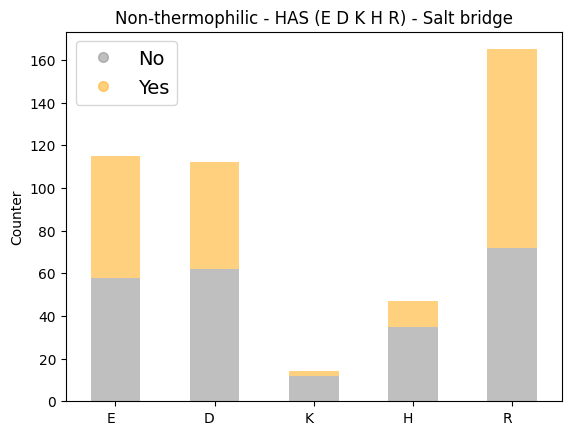

In [ ]:
from matplotlib.colors import to_rgba
color_dict = {'nosaltbridge': to_rgba('gray',0.5),'yessaltbridge': to_rgba('orange',0.5)}

ax=HAS_meso_salt_bridge_df.plot.bar(x='AA',stacked=True, title='Non-thermophilic - HAS (E D K H R) - Salt bridge',color=color_dict)
plt.xticks(rotation=0, ha='right')
ax.set(xlabel=None)
ax.set(ylabel='Counter')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
                  Line2D([], [], marker='.', color= to_rgba('gray',0.5), label='No',
                          markersize=14,linestyle='None'),
                  Line2D([], [], marker='.', color=to_rgba('orange',0.5), label='Yes',
                          markersize=14,linestyle='None')
                  ]

plt.legend(handles=legend_elements, loc='best',fontsize=14,)
#plt.savefig('SALT_BRIDGE_nonthermo.png',dpi=300, bbox_inches = "tight")
#plt.savefig('SALT_BRIDGE_nonthermo.svg',format='svg', dpi=300, bbox_inches = "tight")

###### NO HAS

In [ ]:
df_all=pd.DataFrame.from_dict(meso_ALL_salt_bridge)
df_all.loc['nosaltbridge'] = df_all.loc['surface'].apply(len) + df_all.loc['core'].apply(len) - df_all.loc['surface'].apply(sum) - df_all.loc['core'].apply(sum)
df_all.loc['yessaltbridge'] =  df_all.loc['surface'].apply(sum) + df_all.loc['core'].apply(sum)
df_all

,E,D,K,H,R
surface,"[0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...","[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, ..."
core,"[1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, ...","[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, ...","[0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, ..."
nosaltbridge,1592,1625,1538,655,1015
yessaltbridge,944,965,602,278,998


In [ ]:
#baseline + has = all
df_all=pd.DataFrame.from_dict(meso_ALL_salt_bridge)
df_all.loc['nosaltbridge'] = df_all.loc['surface'].apply(len) + df_all.loc['core'].apply(len) - df_all.loc['surface'].apply(sum) - df_all.loc['core'].apply(sum)
df_all.loc['yessaltbridge'] =  df_all.loc['surface'].apply(sum) + df_all.loc['core'].apply(sum)
df_all.drop('surface',inplace=True)
df_all.drop('core',inplace=True)
df_all=df_all.transpose()
df_all['AA']=df_all.index
df_all.reset_index(inplace=True)
df_all.drop('index', axis=1, inplace=True)
ALL_meso_salt_bridge=df_all
df_all


,nosaltbridge,yessaltbridge,AA
0,1592,944,E
1,1625,965,D
2,1538,602,K
3,655,278,H
4,1015,998,R


In [ ]:
# removing has from the baseline
df_nohas=df_all[['nosaltbridge','yessaltbridge']] - has_df[['nosaltbridge','yessaltbridge']]
df_nohas['AA']=df_all['AA']
NOHAS_meso_salt_bridge_df = df_nohas
df_nohas

,nosaltbridge,yessaltbridge,AA
0,1534,887,E
1,1563,915,D
2,1526,600,K
3,620,266,H
4,943,905,R


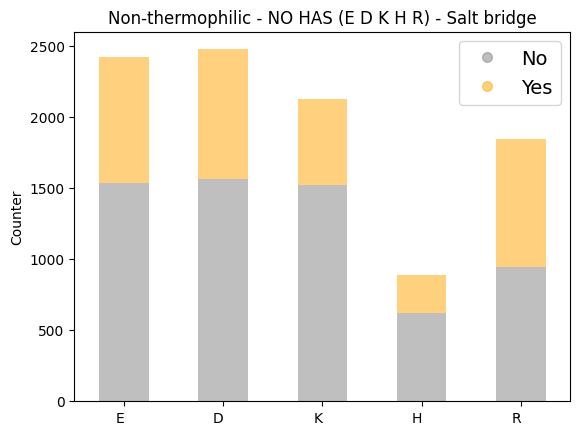

In [ ]:
from matplotlib.colors import to_rgba
color_dict = {'nosaltbridge': to_rgba('gray',0.5),'yessaltbridge': to_rgba('orange',0.5)}

ax=NOHAS_meso_salt_bridge_df.plot.bar(x='AA',stacked=True, title='Non-thermophilic - NO HAS (E D K H R) - Salt bridge',color=color_dict)
plt.xticks(rotation=0, ha='right')
ax.set(xlabel=None)
ax.set(ylabel='Counter')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
                  Line2D([], [], marker='.', color= to_rgba('gray',0.5), label='No',
                          markersize=14,linestyle='None'),
                  Line2D([], [], marker='.', color=to_rgba('orange',0.5), label='Yes',
                          markersize=14,linestyle='None')
                  ]

plt.legend(handles=legend_elements, loc='best',fontsize=14,)
#plt.savefig('SALT_BRIDGE_nonthermo_nohas.png',dpi=300, bbox_inches = "tight")
#plt.savefig('SALT_BRIDGE_nonthermo_nohas.svg',format='svg', dpi=300, bbox_inches = "tight")

###### CONCAT

In [ ]:
meso_concat_salt_bridge=pd.concat([NOHAS_meso_salt_bridge_df,HAS_meso_salt_bridge_df],axis=1)
meso_concat_salt_bridge.columns = ['no_nohas','yes_nohas','AA','no_has','yes_has','AA_TMP']
meso_concat_salt_bridge.drop('AA_TMP',inplace=True,axis=1)
meso_concat_salt_bridge=meso_concat_salt_bridge[['AA','no_nohas','no_has','yes_nohas','yes_has']]
meso_concat_salt_bridge

,AA,no_nohas,no_has,yes_nohas,yes_has
0,E,1534,58,887,57
1,D,1563,62,915,50
2,K,1526,12,600,2
3,H,620,35,266,12
4,R,943,72,905,93


<ipython-input-40-b9275613ced8>:12: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch([], [],  color= to_rgba('lightskyblue',0.9), label='no-salt-bridge', ),
<ipython-input-40-b9275613ced8>:13: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch([], [], color=to_rgba('moccasin',0.9), label='yes-salt-bridge'),
<ipython-input-40-b9275613ced8>:14: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch([], [], color= to_rgba('royalblue',0.9), label='no-salt-bridge'),
<ipython-input-40-b9275613ced8>:15: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch([], [], color=to_rgba('orange',0.9), label='yes-salt-bridge')


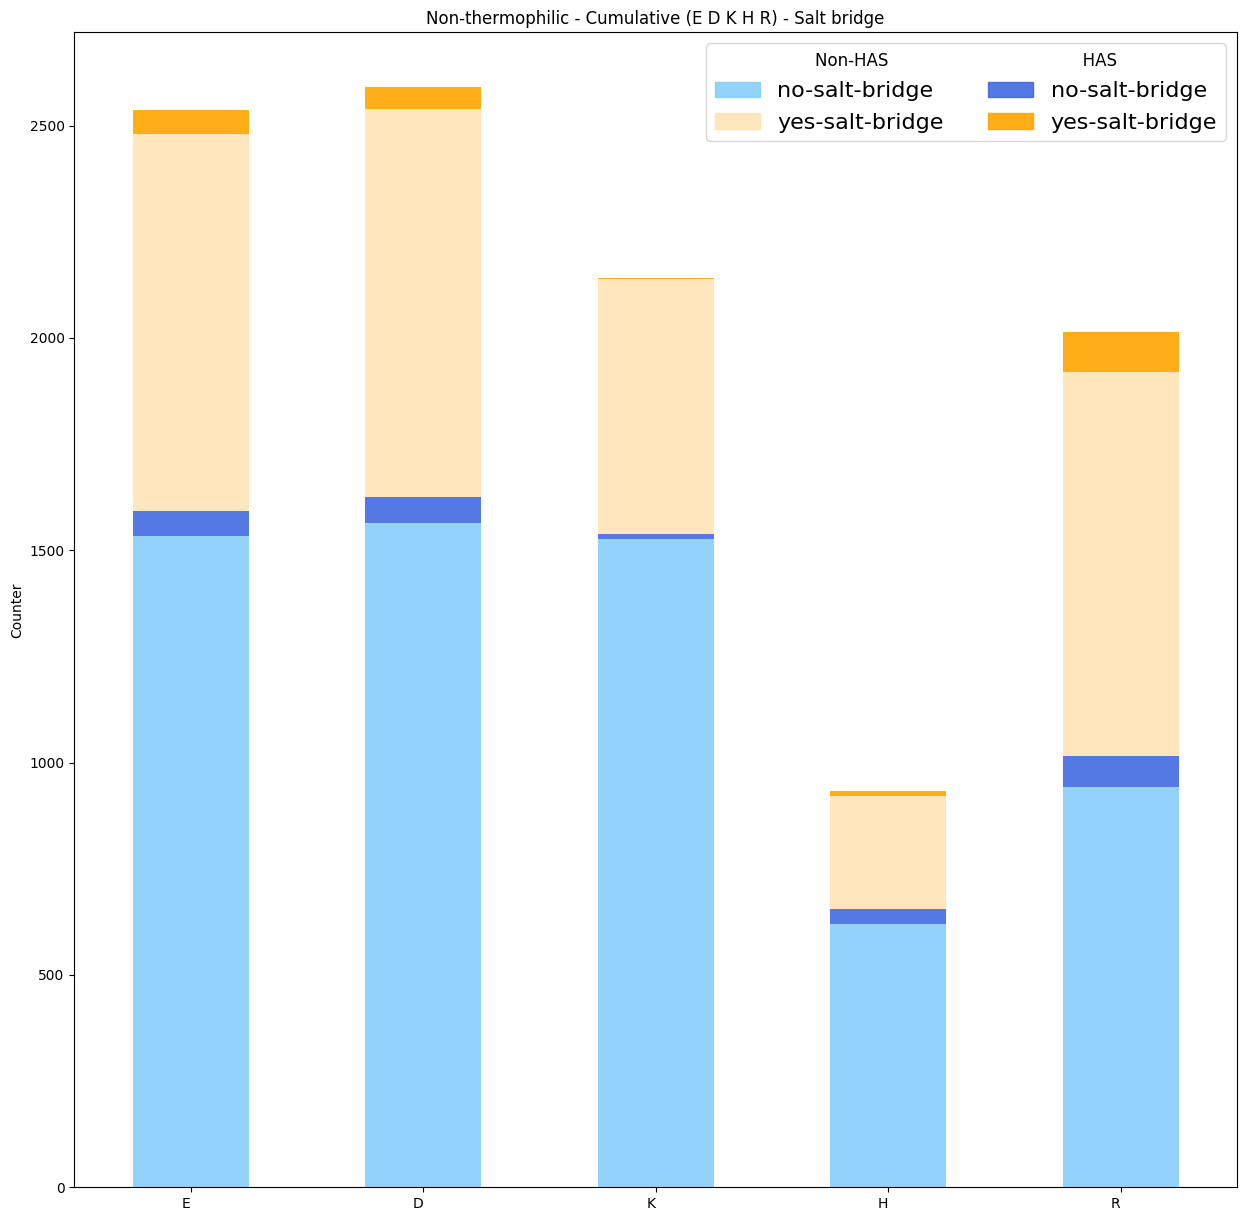

In [ ]:
from matplotlib.colors import to_rgba
color_dict = {'no_nohas': to_rgba('lightskyblue',0.9),'yes_nohas': to_rgba('moccasin',0.9),'no_has': to_rgba('royalblue',0.9),'yes_has': to_rgba('orange',0.9)}

ax=meso_concat_salt_bridge.plot.bar(x='AA',stacked=True, title='Non-thermophilic - Cumulative (E D K H R) - Salt bridge',color=color_dict,figsize=(15, 15))
plt.xticks(rotation=0, ha='right')
ax.set(xlabel=None)
ax.set(ylabel='Counter')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
                  Patch([], [],  color= to_rgba('lightskyblue',0.9), label='no-salt-bridge', ),
                  Patch([], [], color=to_rgba('moccasin',0.9), label='yes-salt-bridge'),
                                     Patch([], [], color= to_rgba('royalblue',0.9), label='no-salt-bridge'),
                  Patch([], [], color=to_rgba('orange',0.9), label='yes-salt-bridge')
                  ]

plt.legend(handles=legend_elements, loc='upper right', ncol=2, title_fontsize='large',title='Non-HAS                                     HAS',fontsize=24,prop={'size': 16} )
#plt.savefig('SALT_BRIDGE_nonthermo_nohas.png',dpi=300, bbox_inches = "tight")
#plt.savefig('SALT_BRIDGE_nonthermo_nohas.svg',format='svg', dpi=300, bbox_inches = "tight")

#### Disulfide bonds analysis

##### HAS

In [ ]:
has_df=pd.DataFrame.from_dict(meso_HAS_disulfide)
has_df

,L,A,G,V,E,S,I,K,R,D,T,P,N,Q,F,Y,M,H,C,W
surface,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]"
core,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
has_df=pd.DataFrame.from_dict(meso_HAS_disulfide)
has_df.loc['nodisulfide'] = has_df.loc['surface'].apply(len) + has_df.loc['core'].apply(len) - has_df.loc['surface'].apply(sum) - has_df.loc['core'].apply(sum)
has_df.loc['yesdisulfide'] =  has_df.loc['surface'].apply(sum) + has_df.loc['core'].apply(sum)
has_df.drop('surface',inplace=True)
has_df.drop('core',inplace=True)
has_df=has_df.transpose()
has_df['AA']=has_df.index
has_df.reset_index(inplace=True)
has_df.drop('index', axis=1, inplace=True)
HAS_meso_disulfide_df=has_df
has_df

,nodisulfide,yesdisulfide,AA
0,90,0,L
1,163,0,A
2,104,0,G
3,109,0,V
4,115,0,E
5,70,0,S
6,146,0,I
7,14,0,K
8,165,0,R
9,112,0,D


##### NO HAS

In [ ]:
#baseline + has = all
df_all=pd.DataFrame.from_dict(meso_ALL_disulfide)
df_all.loc['nodisulfide'] = df_all.loc['surface'].apply(len) + df_all.loc['core'].apply(len) - df_all.loc['surface'].apply(sum) - df_all.loc['core'].apply(sum)
df_all.loc['yesdisulfide'] =  df_all.loc['surface'].apply(sum) + df_all.loc['core'].apply(sum)
df_all.drop('surface',inplace=True)
df_all.drop('core',inplace=True)
df_all=df_all.transpose()
df_all['AA']=df_all.index
df_all.reset_index(inplace=True)
df_all.drop('index', axis=1, inplace=True)
ALL_meso_disulfide_df=df_all
df_all


,nodisulfide,yesdisulfide,AA
0,3567,0,L
1,3874,0,A
2,3312,0,G
3,2922,0,V
4,2540,0,E
5,2143,0,S
6,2265,0,I
7,2144,0,K
8,2013,0,R
9,2596,0,D


In [ ]:
# removing has from the baseline
df_nohas=df_all[['nodisulfide','yesdisulfide']] - has_df[['nodisulfide','yesdisulfide']]
df_nohas['AA']=df_all['AA']
NOHAS_meso_disulfide_df = df_nohas
df_nohas

,nodisulfide,yesdisulfide,AA
0,3477,0,L
1,3711,0,A
2,3208,0,G
3,2813,0,V
4,2425,0,E
5,2073,0,S
6,2119,0,I
7,2130,0,K
8,1848,0,R
9,2484,0,D


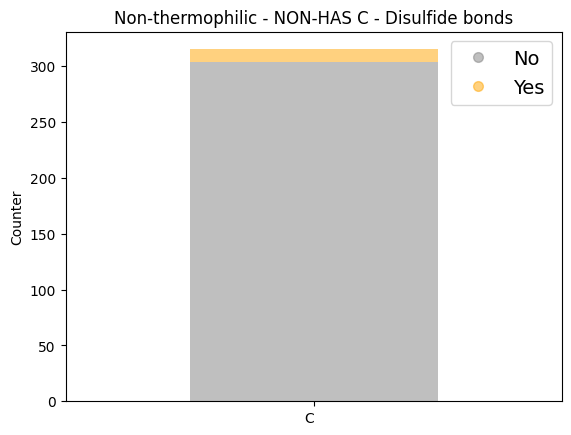

In [ ]:
from matplotlib.colors import to_rgba
color_dict = {'nodisulfide': to_rgba('gray',0.5),'yesdisulfide': to_rgba('orange',0.5)}

ax=NOHAS_meso_disulfide_df.loc[NOHAS_meso_disulfide_df['AA']== 'C'].plot.bar(x='AA',stacked=True, title='Non-thermophilic - NON-HAS C - Disulfide bonds',color=color_dict)
plt.xticks(rotation=0, ha='right')
ax.set(xlabel=None)
ax.set(ylabel='Counter')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
                  Line2D([], [], marker='.', color= to_rgba('gray',0.5), label='No',
                          markersize=14,linestyle='None'),
                  Line2D([], [], marker='.', color=to_rgba('orange',0.5), label='Yes',
                          markersize=14,linestyle='None')
                  ]

plt.legend(handles=legend_elements, loc='best',fontsize=14,)
#plt.savefig('SALT_BRIDGE_nonthermo_nohas.png',dpi=300, bbox_inches = "tight")
#plt.savefig('SALT_BRIDGE_nonthermo_nohas.svg',format='svg', dpi=300, bbox_inches = "tight")

##### CONCAT

In [ ]:
meso_concat_disulfide=pd.concat([NOHAS_meso_disulfide_df,HAS_meso_disulfide_df],axis=1)
meso_concat_disulfide.columns = ['no_nohas','yes_nohas','AA','no_has','yes_has','AA_TMP']
meso_concat_disulfide.drop('AA_TMP',inplace=True,axis=1)
meso_concat_disulfide=meso_concat_disulfide[['AA','no_nohas','no_has','yes_nohas','yes_has']]
meso_concat_disulfide

,AA,no_nohas,no_has,yes_nohas,yes_has
0,L,3477,90,0,0
1,A,3711,163,0,0
2,G,3208,104,0,0
3,V,2813,109,0,0
4,E,2425,115,0,0
5,S,2073,70,0,0
6,I,2119,146,0,0
7,K,2130,14,0,0
8,R,1848,165,0,0
9,D,2484,112,0,0


<ipython-input-47-0a3514ce16f1>:12: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch([], [],  color= to_rgba('lightskyblue',0.9), label='no-disulfide-bonds', ),
<ipython-input-47-0a3514ce16f1>:13: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch([], [], color=to_rgba('moccasin',0.9), label='yes-disulfide-bonds'),
<ipython-input-47-0a3514ce16f1>:14: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch([], [], color= to_rgba('royalblue',0.9), label='no-disulfide-bonds'),
<ipython-input-47-0a3514ce16f1>:15: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch([], [], color=to_rgba('orange',0.9), label='yes-disulfide-bonds')


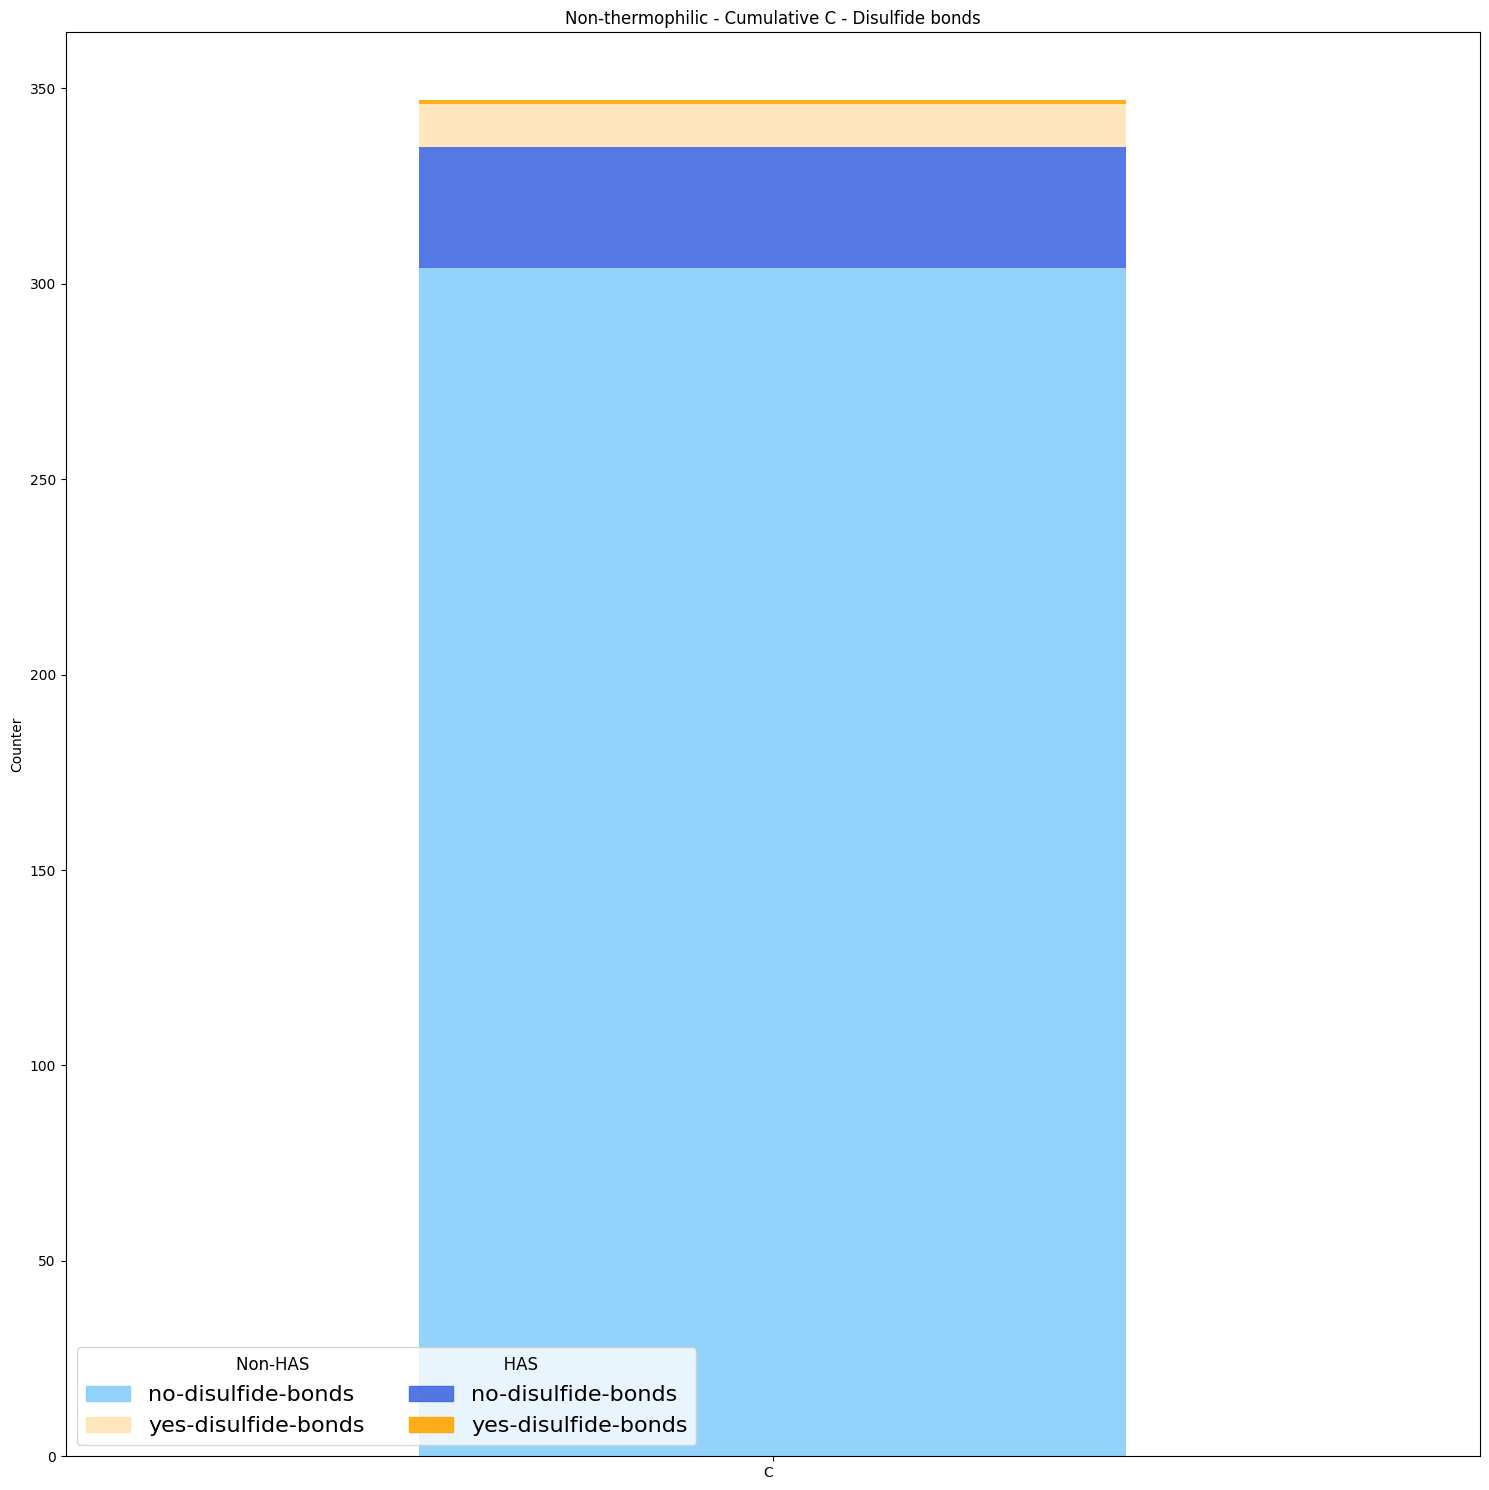

In [ ]:
from matplotlib.colors import to_rgba
color_dict = {'no_nohas': to_rgba('lightskyblue',0.9),'yes_nohas': to_rgba('moccasin',0.9),'no_has': to_rgba('royalblue',0.9),'yes_has': to_rgba('orange',0.9)}

ax=meso_concat_disulfide.loc[NOHAS_meso_disulfide_df['AA']== 'C'].plot.bar(x='AA',stacked=True, title='Non-thermophilic - Cumulative C - Disulfide bonds',color=color_dict,figsize=(15, 15))
plt.xticks(rotation=0, ha='right')
ax.set(xlabel=None)
ax.set(ylabel='Counter')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
                  Patch([], [],  color= to_rgba('lightskyblue',0.9), label='no-disulfide-bonds', ),
                  Patch([], [], color=to_rgba('moccasin',0.9), label='yes-disulfide-bonds'),
                  Patch([], [], color= to_rgba('royalblue',0.9), label='no-disulfide-bonds'),
                  Patch([], [], color=to_rgba('orange',0.9), label='yes-disulfide-bonds')
                  ]

plt.legend(handles=legend_elements, loc='best', ncol=2, title_fontsize='large',title='Non-HAS                                     HAS',fontsize=24,prop={'size': 16} )
plt.tight_layout()
plt.show()
#plt.savefig('SALT_BRIDGE_nonthermo_nohas.png',dpi=300, bbox_inches = "tight")
#plt.savefig('SALT_BRIDGE_nonthermo_nohas.svg',format='svg', dpi=300, bbox_inches = "tight")

####  HYDROPHOBIC, CHARGED, POLAR AGGREGATION

In [ ]:
pos_charged_aa=['R','K','H']
neg_charged_aa=['D','E']
uncharged_polar_aa=['S','T','N','Q',]
hydrophobic_aa=['A','V','L','I','M']
hydrophobic_aa_withrings=['F','W','Y']
gly=['G']
pro=['P']
cys=['C']
len(hydrophobic_aa) + len(hydrophobic_aa_withrings) + len(pos_charged_aa) + len(uncharged_polar_aa) + len(gly) + len(neg_charged_aa) + len(pro) + len(cys)

20

In [ ]:
import copy
meso_baseline_aa_types=copy.deepcopy(meso_baseline_sasa)
meso_HAS_aa_types=copy.deepcopy(meso_HAS_sasa)

#### BASELINE

#1.pos_charged_aa
merged_dict = {}
for key in pos_charged_aa:
    for inner_key, value in meso_baseline_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_baseline_aa_types.pop(key)

meso_baseline_aa_types['pos_charged_aa'] = merged_dict

#2.neg_charged_aa
merged_dict = {}
for key in neg_charged_aa:
    for inner_key, value in meso_baseline_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_baseline_aa_types.pop(key)

meso_baseline_aa_types['neg_charged_aa'] = merged_dict

#3.uncharged_polar_aa
merged_dict = {}
for key in uncharged_polar_aa:
    for inner_key, value in meso_baseline_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_baseline_aa_types.pop(key)

meso_baseline_aa_types['uncharged_polar_aa'] = merged_dict

#4.hydrophobic_aa

merged_dict = {}
for key in hydrophobic_aa:
    for inner_key, value in meso_baseline_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_baseline_aa_types.pop(key)

meso_baseline_aa_types['hydrophobic_aa'] = merged_dict

#5.hydrophobic_aa_withrings
merged_dict = {}
for key in hydrophobic_aa_withrings:
    for inner_key, value in meso_baseline_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_baseline_aa_types.pop(key)

meso_baseline_aa_types['hydrophobic_aa_withrings'] = merged_dict

#6. gly
merged_dict = {}
for key in gly:
    for inner_key, value in meso_baseline_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_baseline_aa_types.pop(key)

meso_baseline_aa_types['gly'] = merged_dict

#7.pro
merged_dict = {}
for key in pro:
    for inner_key, value in meso_baseline_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_baseline_aa_types.pop(key)

meso_baseline_aa_types['pro'] = merged_dict

#8.cys
merged_dict = {}
for key in cys:
    for inner_key, value in meso_baseline_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_baseline_aa_types.pop(key)

meso_baseline_aa_types['cys'] = merged_dict

#### HAS

#1.pos_charged_aa
merged_dict = {}
for key in pos_charged_aa:
    for inner_key, value in meso_HAS_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_HAS_aa_types.pop(key)

meso_HAS_aa_types['pos_charged_aa'] = merged_dict

#2.neg_charged_aa
merged_dict = {}
for key in neg_charged_aa:
    for inner_key, value in meso_HAS_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_HAS_aa_types.pop(key)

meso_HAS_aa_types['neg_charged_aa'] = merged_dict

#3.uncharged_polar_aa
merged_dict = {}
for key in uncharged_polar_aa:
    for inner_key, value in meso_HAS_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_HAS_aa_types.pop(key)

meso_HAS_aa_types['uncharged_polar_aa'] = merged_dict

#4.hydrophobic_aa

merged_dict = {}
for key in hydrophobic_aa:
    for inner_key, value in meso_HAS_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_HAS_aa_types.pop(key)

meso_HAS_aa_types['hydrophobic_aa'] = merged_dict

#5.hydrophobic_aa_withrings
merged_dict = {}
for key in hydrophobic_aa_withrings:
    for inner_key, value in meso_HAS_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_HAS_aa_types.pop(key)

meso_HAS_aa_types['hydrophobic_aa_withrings'] = merged_dict

#6. gly
merged_dict = {}
for key in gly:
    for inner_key, value in meso_HAS_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_HAS_aa_types.pop(key)

meso_HAS_aa_types['gly'] = merged_dict

#7.pro
merged_dict = {}
for key in pro:
    for inner_key, value in meso_HAS_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_HAS_aa_types.pop(key)

meso_HAS_aa_types['pro'] = merged_dict

#8.cys
merged_dict = {}
for key in cys:
    for inner_key, value in meso_HAS_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_HAS_aa_types.pop(key)

meso_HAS_aa_types['cys'] = merged_dict

#check
print(sum(meso_baseline_sasa['S']['surface'])+sum(meso_baseline_sasa['T']['surface']) + sum(meso_baseline_sasa['N']['surface']) + sum(meso_baseline_sasa['Q']['surface']) )
print(sum(meso_baseline_aa_types['uncharged_polar_aa']['surface']))
print(sum(meso_HAS_sasa['C']['core']))
print(sum(meso_HAS_aa_types['cys']['core']))

4116
4116
26
26


##### FISHER exact test

In [ ]:
import numpy as np
from scipy.stats import fisher_exact

meso_aa_types_significant=[]
with open('NON_THERMO_AA_TYPES_fisher_exact.txt', 'a') as f:
  f.write('------------------------------------------------------ \n NON THERMOPHILIC - Fisher exact test \n------------------------------------------------------ \n')
for aa in meso_baseline_aa_types.keys():
  exposed_high=sum(meso_HAS_aa_types[aa]['surface'])
  buried_high=sum(meso_HAS_aa_types[aa]['core'])
  exposed_low=sum(meso_baseline_aa_types[aa]['surface'])-sum(meso_HAS_aa_types[aa]['surface'])
  buried_low=sum(meso_baseline_aa_types[aa]['core'])-sum(meso_HAS_aa_types[aa]['core'])
  table=np.array([[exposed_high, exposed_low], [buried_high, buried_low]])
  df = pd.DataFrame(table, index=['exposed','buried'], columns=['high att','low att'])
  res = fisher_exact(table, alternative='two-sided')
  significance='SIGNIFICANT (p-value < 0.05)' if res.pvalue < 0.05 else 'non significant (p-value > 0.05)'
  with open('NON_THERMO_AA_TYPES_fisher_exact.txt', 'a') as f:
    dfAsString = df.to_string(header=True, index=True)
    f.write('AA: '+aa+'\n'+dfAsString+'\n'+'p-value: '+ str(res.pvalue)+'\n'+significance+'\n'+'\n')
  if res.pvalue < 0.05 :
    meso_aa_types_significant.append(aa)

with open('NON_THERMO_AA_TYPES_fisher_exact.txt', 'a') as f:
  f.write('------------------------------------------------------ \n AA TYPES WITH SIGNIFICANT P-VALUE: '+' '.join(meso_aa_types_significant)+' \n------------------------------------------------------ \n')

In [ ]:
uncharged_polar_aa=['S','T','N','Q',]

In [ ]:
meso_HAS_aa_types.keys()

odict_keys(['pos_charged_aa', 'neg_charged_aa', 'uncharged_polar_aa', 'hydrophobic_aa', 'hydrophobic_aa_withrings', 'gly', 'pro', 'cys'])

In [ ]:
meso_baseline_aa_types.keys()

odict_keys(['pos_charged_aa', 'neg_charged_aa', 'uncharged_polar_aa', 'hydrophobic_aa', 'hydrophobic_aa_withrings', 'gly', 'pro', 'cys'])

In [ ]:
pos_charged_aa=['R','K','H']
neg_charged_aa=['D','E']
uncharged_polar_aa=['S','T','N','Q',]
hydrophobic_aa=['A','V','L','I','M']
hydrophobic_aa_withrings=['F','W','Y']
gly=['G']
pro=['P']
cys=['C']

##### Baseline

In [ ]:
meso_baseline_aa_types_avgDict={}
meso_baseline_aa_types_avgDict_exposition={'pos_charged_aa':{'surface':[],'core':[]},'neg_charged_aa':{'surface':[],'core':[]},'uncharged_polar_aa':{'surface':[],'core':[]},'hydrophobic_aa':{'surface':[],'core':[]},'hydrophobic_aa_withrings':{'surface':[],'core':[]},'gly':{'surface':[],'core':[]},'pro':{'surface':[],'core':[]},'cys':{'surface':[],'core':[]},}

# 1. sum all the matches for each aa
for k in meso_baseline_aa_types:
  tot_per_aa = sum([sum(meso_baseline_aa_types[k][sec]) for sec in meso_baseline_aa_types[k]])
  meso_baseline_aa_types_avgDict[k]=tot_per_aa
  # 2. compute the percentage of exposition for each aa --> meso_HAS_sasa_avgDict_exposition
  for sec in meso_baseline_aa_types[k]:
    if tot_per_aa != 0:
      meso_baseline_aa_types_avgDict_exposition[k][sec]=sum(meso_baseline_aa_types[k][sec])/(tot_per_aa)
    else:
      meso_baseline_aa_types_avgDict_exposition[k][sec]=0  # 'L': {'surface': 0.2126052860877142, 'core': 0.7873947139122858}

# 3. computing aa percentage on total num aminoacid --> meso_HAS_sasa_avgDict
tot_aa = sum(meso_baseline_aa_types_avgDict.values())
for k,v in (meso_baseline_aa_types_avgDict.items()):
  meso_baseline_aa_types_avgDict[k]= (v)/ tot_aa #'L': 0.09191382578285592  L is the 9% of all the aa

# 4. meso_HAS_sasa_avgDict[k] * meso_HAS_sasa_avgDict_exposition[k][sec] for data visualisation reason --> meso_HAS_sasa_avgDict_exposition_plot
# L_surface * totL * %L in all the data
import copy
meso_baseline_aa_types_avgDict_exposition_plot=copy.deepcopy(meso_baseline_aa_types_avgDict_exposition)
for k in meso_baseline_aa_types_avgDict_exposition_plot:
  for sec in meso_baseline_aa_types_avgDict_exposition_plot[k]:
    meso_baseline_aa_types_avgDict_exposition_plot[k][sec] = meso_baseline_aa_types_avgDict[k] * meso_baseline_aa_types_avgDict_exposition[k][sec]


# to df
meso_baseline_aa_types_avgDict_exposition_plot_df=pd.DataFrame.from_dict(meso_baseline_aa_types_avgDict_exposition_plot)
meso_baseline_aa_types_avgDict_exposition_plot_df=meso_baseline_aa_types_avgDict_exposition_plot_df.transpose()

# to df
meso_baseline_aa_types_avgDict_exposition_df=pd.DataFrame.from_dict(meso_baseline_aa_types_avgDict_exposition)

meso_baseline_aa_types_avgDict_exposition_plot

{'pos_charged_aa': {'surface': 0.08764443113473583,
  'core': 0.03928027750742431},
 'neg_charged_aa': {'surface': 0.09246088193456614,
  'core': 0.035462054852636565},
 'uncharged_polar_aa': {'surface': 0.10271767612487835,
  'core': 0.0826532904095231},
 'hydrophobic_aa': {'surface': 0.08634673454618053,
  'core': 0.2497566818896459},
 'hydrophobic_aa_withrings': {'surface': 0.021811284969179705,
  'core': 0.06593296898006039},
 'gly': {'surface': 0.040203638541588683, 'core': 0.0423248733498041},
 'pro': {'surface': 0.025529684809463198, 'core': 0.01931571460657333},
 'cys': {'surface': 0.0015222979211898878, 'core': 0.007037508422549973}}

##### HAS

In [ ]:
meso_HAS_aa_types_avgDict={}
meso_HAS_aa_types_avgDict_exposition={'pos_charged_aa':{'surface':[],'core':[]},'neg_charged_aa':{'surface':[],'core':[]},'uncharged_polar_aa':{'surface':[],'core':[]},'hydrophobic_aa':{'surface':[],'core':[]},'hydrophobic_aa_withrings':{'surface':[],'core':[]},'gly':{'surface':[],'core':[]},'pro':{'surface':[],'core':[]},'cys':{'surface':[],'core':[]},}

# 1. sum all the matches for each aa
for k in meso_HAS_aa_types:
  tot_per_aa = sum([sum(meso_HAS_aa_types[k][sec]) for sec in meso_HAS_aa_types[k]])
  meso_HAS_aa_types_avgDict[k]=tot_per_aa
  # 2. compute the percentage of exposition for each aa --> meso_HAS_sasa_avgDict_exposition
  for sec in meso_HAS_aa_types[k]:
    if tot_per_aa != 0:
      meso_HAS_aa_types_avgDict_exposition[k][sec]=sum(meso_HAS_aa_types[k][sec])/(tot_per_aa)
    else:
      meso_HAS_aa_types_avgDict_exposition[k][sec]=0

# 3. computing aa percentage on total aminoacid --> meso_HAS_sasa_avgDict
tot_aa = sum(meso_HAS_aa_types_avgDict.values())
for k,v in (meso_HAS_aa_types_avgDict.items()):
  meso_HAS_aa_types_avgDict[k]= (v)/ tot_aa

# 4. meso_HAS_sasa_avgDict[k] * meso_HAS_sasa_avgDict_exposition[k][sec] for data visualisation reason --> meso_HAS_sasa_avgDict_exposition_plot
import copy
meso_HAS_aa_types_avgDict_exposition_plot=copy.deepcopy(meso_HAS_aa_types_avgDict_exposition)
for k in meso_HAS_aa_types_avgDict_exposition_plot:
  for sec in meso_HAS_aa_types_avgDict_exposition_plot[k]:
    meso_HAS_aa_types_avgDict_exposition_plot[k][sec] = meso_HAS_aa_types_avgDict[k] * meso_HAS_aa_types_avgDict_exposition[k][sec]

# to df
meso_HAS_aa_types_avgDict_exposition_plot_df=pd.DataFrame.from_dict(meso_HAS_aa_types_avgDict_exposition_plot)
meso_HAS_aa_types_avgDict_exposition_plot_df=meso_HAS_aa_types_avgDict_exposition_plot_df.transpose()

# to df
meso_HAS_aa_types_avgDict_exposition_df=pd.DataFrame.from_dict(meso_HAS_aa_types_avgDict_exposition)

#### SASA

##### Baseline

In [ ]:
meso_baseline_sasa_avgDict={}
meso_baseline_sasa_avgDict_exposition={'L':{'surface':[],'core':[]},'A':{'surface':[],'core':[]},'G':{'surface':[],'core':[]},'V':{'surface':[],'core':[]},'E':{'surface':[],'core':[]},'S':{'surface':[],'core':[]},'I':{'surface':[],'core':[]},'K':{'surface':[],'core':[]},'R':{'surface':[],'core':[]},'D':{'surface':[],'core':[]},'T':{'surface':[],'core':[]},'P':{'surface':[],'core':[]},'N':{'surface':[],'core':[]},'Q':{'surface':[],'core':[]},'F':{'surface':[],'core':[]},'Y':{'surface':[],'core':[]},'M':{'surface':[],'core':[]},'H':{'surface':[],'core':[]},'C':{'surface':[],'core':[]},'W':{'surface':[],'core':[]},}

# 1. sum all the matches for each aa
for k in meso_baseline_sasa:
  tot_per_aa = sum([sum(meso_baseline_sasa[k][sec]) for sec in meso_baseline_sasa[k]])
  meso_baseline_sasa_avgDict[k]=tot_per_aa #'L': 3443
  # 2. compute the percentage of exposition for each aa --> meso_HAS_sasa_avgDict_exposition
  for sec in meso_baseline_sasa[k]:
    if tot_per_aa != 0:
      meso_baseline_sasa_avgDict_exposition[k][sec]=sum(meso_baseline_sasa[k][sec])/(tot_per_aa)
    else:
      meso_baseline_sasa_avgDict_exposition[k][sec]=0  # 'L': {'surface': 0.2126052860877142, 'core': 0.7873947139122858}

# 3. computing aa percentage on total num aminoacid --> meso_HAS_sasa_avgDict
tot_aa = sum(meso_baseline_sasa_avgDict.values())
for k,v in (meso_baseline_sasa_avgDict.items()):
  meso_baseline_sasa_avgDict[k]= (v)/ tot_aa #'L': 0.09191382578285592  L is the 9% of all the aa

# 4. meso_HAS_sasa_avgDict[k] * meso_HAS_sasa_avgDict_exposition[k][sec] for data visualisation reason --> meso_HAS_sasa_avgDict_exposition_plot
# L_surface * totL * %L in all the data
import copy
meso_baseline_sasa_avgDict_exposition_plot=copy.deepcopy(meso_baseline_sasa_avgDict_exposition)
for k in meso_baseline_sasa_avgDict_exposition_plot:
  for sec in meso_baseline_sasa_avgDict_exposition_plot[k]:
    meso_baseline_sasa_avgDict_exposition_plot[k][sec] = meso_baseline_sasa_avgDict[k] * meso_baseline_sasa_avgDict_exposition[k][sec]

#meso_HAS_sasa
#meso_HAS_sasa_avgDict
#meso_HAS_sasa_avgDict_exposition
#meso_HAS_sasa_avgDict_exposition_plot

# to df
meso_baseline_sasa_avgDict_exposition_plot_df=pd.DataFrame.from_dict(meso_baseline_sasa_avgDict_exposition_plot)
meso_baseline_sasa_avgDict_exposition_plot_df=meso_baseline_sasa_avgDict_exposition_plot_df.transpose()

# to df
meso_baseline_sasa_avgDict_exposition_df=pd.DataFrame.from_dict(meso_baseline_sasa_avgDict_exposition)


In [ ]:
meso_baseline_sasa_avgDict_exposition_plot_df

,surface,core
L,0.019366,0.069626
A,0.035113,0.061441
G,0.040204,0.042325
V,0.016296,0.056500
E,0.048339,0.014948
S,0.027376,0.026054
I,0.009982,0.046542
K,0.043797,0.009608
R,0.032667,0.017569
D,0.044122,0.020514


In [ ]:
meso_baseline_sasa_avgDict_exposition_df

,L,A,G,V,E,S,I,K,R,D,T,P,N,Q,F,Y,M,H,C,W
surface,0.217611,0.36366,0.487148,0.22386,0.763801,0.512377,0.1766,0.820093,0.650273,0.682625,0.474483,0.569282,0.624284,0.656662,0.199735,0.301282,0.26322,0.480171,0.177843,0.247934
core,0.782389,0.63634,0.512852,0.77614,0.236199,0.487623,0.8234,0.179907,0.349727,0.317375,0.525517,0.430718,0.375716,0.343338,0.800265,0.698718,0.73678,0.519829,0.822157,0.752066


<ipython-input-60-be49a24f7a8a>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=10)


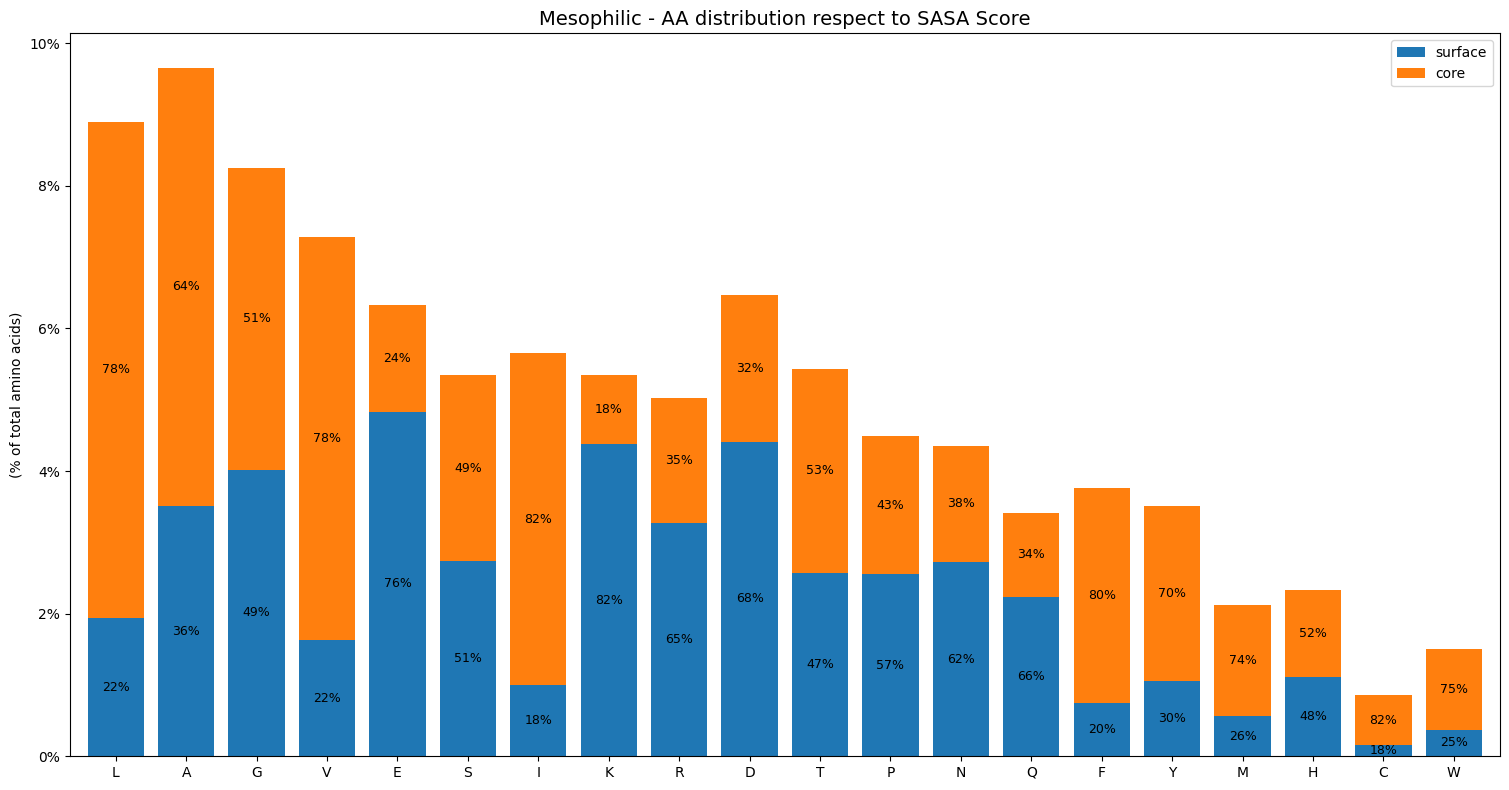

In [ ]:
ax=meso_baseline_sasa_avgDict_exposition_plot_df.plot(kind='bar', stacked=True,width=0.8,align='center',figsize=(15, 8))

plt.title('Mesophilic - AA distribution respect to SASA Score',fontsize=14)

ax.axhline(0, color='black', linewidth=0.5) #adding x ax
# Formatting x labels
plt.xticks(rotation=0)
plt.tight_layout()

## add annotations
df_row=0
#up plot
for c in ax.containers:
  #[word for sentence in text for word in sentence]
  labels = ["{0:.0%}".format(list(meso_baseline_sasa_avgDict_exposition_df.iloc[df_row])[v]) if list(meso_baseline_sasa_avgDict_exposition_df .iloc[df_row])[v] != 0 else '' for v in range(0,len(c)) ]
  #print(labels)
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=9,label_type='center')

ticks =  ax.get_yticks()
ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=10)

plt.ylabel("(% of total amino acids)",fontsize=10)
#plt.savefig('Meso_baseline_sasa_score.png')
plt.show()

##### Has

In [ ]:
meso_HAS_sasa_avgDict={}
meso_HAS_sasa_avgDict_exposition={'L':{'surface':[],'core':[]},'A':{'surface':[],'core':[]},'G':{'surface':[],'core':[]},'V':{'surface':[],'core':[]},'E':{'surface':[],'core':[]},'S':{'surface':[],'core':[]},'I':{'surface':[],'core':[]},'K':{'surface':[],'core':[]},'R':{'surface':[],'core':[]},'D':{'surface':[],'core':[]},'T':{'surface':[],'core':[]},'P':{'surface':[],'core':[]},'N':{'surface':[],'core':[]},'Q':{'surface':[],'core':[]},'F':{'surface':[],'core':[]},'Y':{'surface':[],'core':[]},'M':{'surface':[],'core':[]},'H':{'surface':[],'core':[]},'C':{'surface':[],'core':[]},'W':{'surface':[],'core':[]},}

# 1. sum all the matches for each aa
for k in meso_HAS_sasa:
  tot_per_aa = sum([sum(meso_HAS_sasa[k][sec]) for sec in meso_HAS_sasa[k]])
  meso_HAS_sasa_avgDict[k]=tot_per_aa
  # 2. compute the percentage of exposition for each aa --> meso_HAS_sasa_avgDict_exposition
  for sec in meso_HAS_sasa[k]:
    if tot_per_aa != 0:
      meso_HAS_sasa_avgDict_exposition[k][sec]=sum(meso_HAS_sasa[k][sec])/(tot_per_aa)
    else:
      meso_HAS_sasa_avgDict_exposition[k][sec]=0

# 3. computing aa percentage on total aminoacid --> meso_HAS_sasa_avgDict
tot_aa = sum(meso_HAS_sasa_avgDict.values())
for k,v in (meso_HAS_sasa_avgDict.items()):
  meso_HAS_sasa_avgDict[k]= (v)/ tot_aa

# 4. meso_HAS_sasa_avgDict[k] * meso_HAS_sasa_avgDict_exposition[k][sec] for data visualisation reason --> meso_HAS_sasa_avgDict_exposition_plot
import copy
meso_HAS_sasa_avgDict_exposition_plot=copy.deepcopy(meso_HAS_sasa_avgDict_exposition)
for k in meso_HAS_sasa_avgDict_exposition_plot:
  for sec in meso_HAS_sasa_avgDict_exposition_plot[k]:
    meso_HAS_sasa_avgDict_exposition_plot[k][sec] = meso_HAS_sasa_avgDict[k] * meso_HAS_sasa_avgDict_exposition[k][sec]

#meso_HAS_sasa
#meso_HAS_sasa_avgDict
#meso_HAS_sasa_avgDict_exposition
#meso_HAS_sasa_avgDict_exposition_plot

# to df
meso_HAS_sasa_avgDict_exposition_plot_df=pd.DataFrame.from_dict(meso_HAS_sasa_avgDict_exposition_plot)
meso_HAS_sasa_avgDict_exposition_plot_df=meso_HAS_sasa_avgDict_exposition_plot_df.transpose()

# to df
meso_HAS_sasa_avgDict_exposition_df=pd.DataFrame.from_dict(meso_HAS_sasa_avgDict_exposition)

<ipython-input-62-da935f6902dc>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=10)


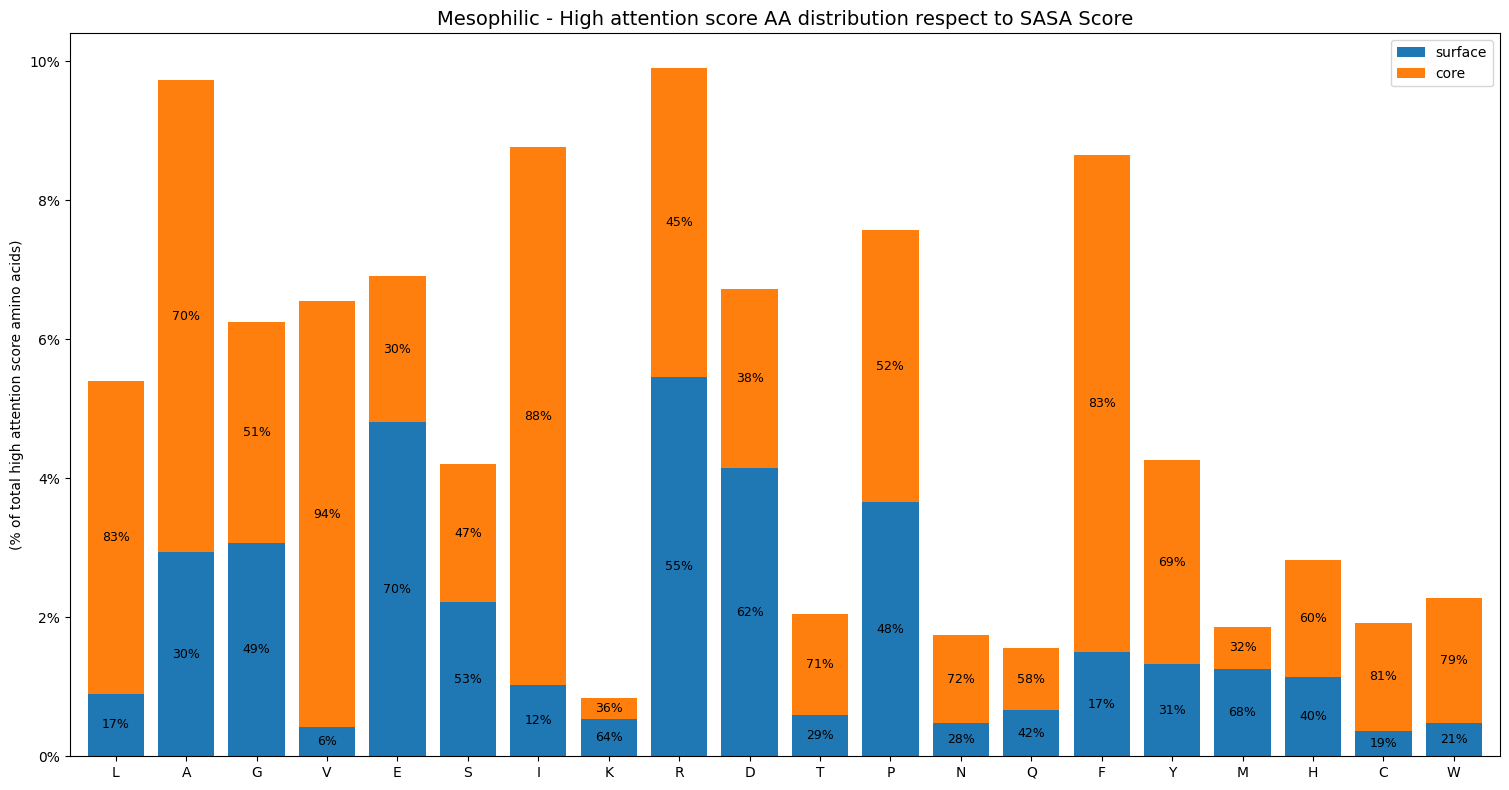

In [ ]:
ax=meso_HAS_sasa_avgDict_exposition_plot_df.plot(kind='bar', stacked=True,width=0.8,align='center',figsize=(15, 8))

plt.title('Mesophilic - High attention score AA distribution respect to SASA Score',fontsize=14)

ax.axhline(0, color='black', linewidth=0.5) #adding x ax
# Formatting x labels
plt.xticks(rotation=0)
plt.tight_layout()

## add annotations
df_row=0
#up plot
for c in ax.containers:
  #[word for sentence in text for word in sentence]
  labels = ["{0:.0%}".format(list(meso_HAS_sasa_avgDict_exposition_df.iloc[df_row])[v]) if list(meso_HAS_sasa_avgDict_exposition_df .iloc[df_row])[v] != 0 else '' for v in range(0,len(c)) ]
  #print(labels)
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=9,label_type='center')

ticks =  ax.get_yticks()
ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=10)

plt.ylabel("(% of total high attention score amino acids)",fontsize=10)
#plt.savefig('Meso_HAS_sasa_score.png')
plt.show()

### THERMO

In [ ]:
pdb_thermo=pdb_thermo[pdb_thermo['PDB_ID'] != '2HPI_A'] #2HPI_A has been removed for an error in saving the seq_masks when creating the data
pdb_thermo

,PDB_ID,COMPLETE_SEQ,SEQ_MASK,LABEL
0,2D1E_A,LSLTNSSLMPTLNPMIQQLALAIAASWQSLPLKPYQLPEDLGYVEG...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1
1,1B11_A,VGTTTTLEKRPEILIFVNGYPIKFLLDTGADITILNRRDFQVKNSI...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1
2,6A8H_A,VHFHPFGNVNFYEMDWSLKGDLWAHAPVIAKEGSRWYVFHTGSGIQ...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1
3,5EQT_A,NVTYNDIGGLKKQLQELREAIELPLKHPELFEEVGIDPPKGVLLYG...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1
4,3H33_A,IDKITYPTRIGAVVFPHKKHQDALGECRGCHEKGPGRIDGFDKVMA...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1
...,...,...,...,...
128,1CAA_A,AKWVCKICGYIYDEDAGDPDNGISPGTKFEELPDDWVCPICGAPKS...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1
129,1LDN_A,MKNNGGARVVVIGAGFVGASYVFALMNQGIADEIVLIDANESKAIG...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1
130,1TFE_A,AREGIIGHYIHHNQRVGVLVELNCETDFVARNELFQNLAKDLAMHI...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1
131,1IQZ_A,PKYTIVDKETCIACGACGAAAPDIYDYDEDGIAYVTLDDNQGIVEV...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1


In [ ]:
thermo_baseline_sasa1, thermo_HAS_sasa1,n_pdbs_processed,thermo_HAS_disulfide, thermo_ALL_disulfide = biotite_disulfide_bonds(pdb_thermo)

0it [00:00, ?it/s]@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2d1e downloaded (2d1e.pdb.gz)
DEBUG:.prody:2d1e downloaded (2d1e.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2341 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:2341 atoms and 1 coordinate set(s) were parsed in 0.07s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1936
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1937
  warnings.warn(



Reading 2D1E with chain A



1it [00:06,  6.52s/it]

DISULFIDE BONDS IDS []
High attention df preview:
7


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1b11 downloaded (1b11.pdb.gz)
DEBUG:.prody:1b11 downloaded (1b11.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1003 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:1003 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 902
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 903
  warnings.warn(



Reading 1B11 with chain A



2it [00:10,  4.84s/it]

DISULFIDE BONDS IDS []
High attention df preview:
8


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 6a8h downloaded (6a8h.pdb.gz)
DEBUG:.prody:6a8h downloaded (6a8h.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2791 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2791 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2525
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2526
  warnings.warn(



Reading 6A8H with chain A



3it [00:18,  6.36s/it]

DISULFIDE BONDS IDS [221, 222]
High attention df preview:
11


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5eqt downloaded (5eqt.pdb.gz)
DEBUG:.prody:5eqt downloaded (5eqt.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2009 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2009 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3906
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3907
  warnings.warn(



Reading 5EQT with chain A



4it [00:24,  6.30s/it]

DISULFIDE BONDS IDS []
High attention df preview:
13


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3h33 downloaded (3h33.pdb.gz)
DEBUG:.prody:3h33 downloaded (3h33.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 719 atoms and 1 coordinate set(s) were parsed in 0.01s.
DEBUG:.prody:719 atoms and 1 coordinate set(s) were parsed in 0.01s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 543
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 544
  warnings.warn(



Reading 3H33 with chain A



5it [00:27,  5.06s/it]

DISULFIDE BONDS IDS []
High attention df preview:
1


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3zse downloaded (3zse.pdb.gz)
DEBUG:.prody:3zse downloaded (3zse.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1629 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:1629 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2926
  warnings.warn(



Reading 3ZSE with chain A



6it [00:33,  5.34s/it]

DISULFIDE BONDS IDS []
High attention df preview:
8


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1cyg downloaded (1cyg.pdb.gz)
DEBUG:.prody:1cyg downloaded (1cyg.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 5551 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:5551 atoms and 1 coordinate set(s) were parsed in 0.07s.



Reading 1CYG with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5320
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5321
  warnings.warn(
7it [00:48,  8.41s/it]

DISULFIDE BONDS IDS [40, 47]
High attention df preview:
26


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5yia downloaded (5yia.pdb.gz)
DEBUG:.prody:5yia downloaded (5yia.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2901 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2901 atoms and 1 coordinate set(s) were parsed in 0.05s.



Reading 5YIA with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5202
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5203
  warnings.warn(
8it [00:54,  7.77s/it]

DISULFIDE BONDS IDS []
High attention df preview:
12


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4o8n downloaded (4o8n.pdb.gz)
DEBUG:.prody:4o8n downloaded (4o8n.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2928 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2928 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4696
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4697
  warnings.warn(



Reading 4O8N with chain A



9it [01:01,  7.68s/it]

DISULFIDE BONDS IDS [27, 297]
High attention df preview:
12


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1tya downloaded (1tya.pdb.gz)
DEBUG:.prody:1tya downloaded (1tya.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2636 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2636 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2463
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2464
  warnings.warn(



Reading 1TYA with chain E



10it [01:08,  7.20s/it]

DISULFIDE BONDS IDS []
High attention df preview:
12


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2zsl downloaded (2zsl.pdb.gz)
DEBUG:.prody:2zsl downloaded (2zsl.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3620 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:3620 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3180
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3181
  warnings.warn(



Reading 2ZSL with chain A



11it [01:17,  7.87s/it]

DISULFIDE BONDS IDS []
High attention df preview:
24


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5zwu downloaded (5zwu.pdb.gz)
DEBUG:.prody:5zwu downloaded (5zwu.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2815 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2815 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5260
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5261
  warnings.warn(



Reading 5ZWU with chain A



12it [01:23,  7.45s/it]

DISULFIDE BONDS IDS []
High attention df preview:
13


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1in4 downloaded (1in4.pdb.gz)
DEBUG:.prody:1in4 downloaded (1in4.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2599 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2599 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2331
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2332
  warnings.warn(



Reading 1IN4 with chain A



13it [01:31,  7.48s/it]

DISULFIDE BONDS IDS []
High attention df preview:
17


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1lqy downloaded (1lqy.pdb.gz)
DEBUG:.prody:1lqy downloaded (1lqy.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1723 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1723 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1435
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1436
  warnings.warn(



Reading 1LQY with chain A



14it [01:35,  6.40s/it]

DISULFIDE BONDS IDS []
High attention df preview:
11


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5aza downloaded (5aza.pdb.gz)
DEBUG:.prody:5aza downloaded (5aza.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 6678 atoms and 1 coordinate set(s) were parsed in 0.09s.
DEBUG:.prody:6678 atoms and 1 coordinate set(s) were parsed in 0.09s.



Reading 5AZA with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 6553
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 6554
  warnings.warn(
15it [01:53,  9.91s/it]

DISULFIDE BONDS IDS []
High attention df preview:
36


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2z1e downloaded (2z1e.pdb.gz)
DEBUG:.prody:2z1e downloaded (2z1e.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2485 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:2485 atoms and 1 coordinate set(s) were parsed in 0.07s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2187
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2188
  warnings.warn(



Reading 2Z1E with chain A



16it [02:00,  9.05s/it]

DISULFIDE BONDS IDS []
High attention df preview:
14


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3m7i downloaded (3m7i.pdb.gz)
DEBUG:.prody:3m7i downloaded (3m7i.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 5274 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:5274 atoms and 1 coordinate set(s) were parsed in 0.06s.



Reading 3M7I with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4903
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4904
  warnings.warn(
17it [02:13, 10.18s/it]

DISULFIDE BONDS IDS []
High attention df preview:
26


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1tml downloaded (1tml.pdb.gz)
DEBUG:.prody:1tml downloaded (1tml.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2843 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2843 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2621
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2622
  warnings.warn(



Reading 1TML with chain A



18it [02:18,  8.79s/it]

DISULFIDE BONDS IDS []
High attention df preview:
14


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1twl downloaded (1twl.pdb.gz)
DEBUG:.prody:1twl downloaded (1twl.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1405 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:1405 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1372
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1373
  warnings.warn(
19it [02:19,  6.30s/it]


Reading 1TWL with chain A

--Error: length prody sequence and length sasa score are different


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1nza downloaded (1nza.pdb.gz)
DEBUG:.prody:1nza downloaded (1nza.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 920 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:920 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 821
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 822
  warnings.warn(



Reading 1NZA with chain A



20it [02:22,  5.36s/it]

DISULFIDE BONDS IDS []
High attention df preview:
6


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1a4h downloaded (1a4h.pdb.gz)
DEBUG:.prody:1a4h downloaded (1a4h.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1892 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:1892 atoms and 1 coordinate set(s) were parsed in 0.06s.



Reading 1A4H with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1700
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1701
  warnings.warn(
21it [02:28,  5.51s/it]

DISULFIDE BONDS IDS []
High attention df preview:
8


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2rdq downloaded (2rdq.pdb.gz)
DEBUG:.prody:2rdq downloaded (2rdq.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2772 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2772 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2132
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2133
  warnings.warn(



Reading 2RDQ with chain A



22it [02:34,  5.60s/it]

DISULFIDE BONDS IDS []
High attention df preview:
18


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1vjw downloaded (1vjw.pdb.gz)
DEBUG:.prody:1vjw downloaded (1vjw.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 465 atoms and 1 coordinate set(s) were parsed in 0.01s.
DEBUG:.prody:465 atoms and 1 coordinate set(s) were parsed in 0.01s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 419
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 420
  warnings.warn(
23it [02:34,  4.03s/it]


Reading 1VJW with chain A

--Error: length prody sequence and length sasa score are different


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4uzu downloaded (4uzu.pdb.gz)
DEBUG:.prody:4uzu downloaded (4uzu.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 4271 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:4271 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3849
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3850
  warnings.warn(



Reading 4UZU with chain A



24it [02:44,  5.88s/it]

DISULFIDE BONDS IDS []
High attention df preview:
23


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1eqp downloaded (1eqp.pdb.gz)
DEBUG:.prody:1eqp downloaded (1eqp.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3494 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:3494 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3214
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3215
  warnings.warn(



Reading 1EQP with chain A



25it [02:53,  6.63s/it]

DISULFIDE BONDS IDS []
High attention df preview:
14


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1o0x downloaded (1o0x.pdb.gz)
DEBUG:.prody:1o0x downloaded (1o0x.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2123 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:2123 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1930
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1931
  warnings.warn(



Reading 1O0X with chain A



26it [02:58,  6.24s/it]

DISULFIDE BONDS IDS []
High attention df preview:
12


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1vpe downloaded (1vpe.pdb.gz)
DEBUG:.prody:1vpe downloaded (1vpe.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3295 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:3295 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3028
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3029
  warnings.warn(



Reading 1VPE with chain A



27it [03:07,  7.06s/it]

DISULFIDE BONDS IDS []
High attention df preview:
7


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3v80 downloaded (3v80.pdb.gz)
DEBUG:.prody:3v80 downloaded (3v80.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2246 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:2246 atoms and 1 coordinate set(s) were parsed in 0.08s.



Reading 3V80 with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4112
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4113
  warnings.warn(
28it [03:13,  6.86s/it]

DISULFIDE BONDS IDS []
High attention df preview:
9


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1o4v downloaded (1o4v.pdb.gz)
DEBUG:.prody:1o4v downloaded (1o4v.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1408 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1408 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1282
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1283
  warnings.warn(



Reading 1O4V with chain A



29it [03:17,  5.90s/it]

DISULFIDE BONDS IDS []
High attention df preview:
7


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3e70 downloaded (3e70.pdb.gz)
DEBUG:.prody:3e70 downloaded (3e70.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2449 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2449 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4630
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4631
  warnings.warn(



Reading 3E70 with chain C



30it [03:25,  6.39s/it]

DISULFIDE BONDS IDS []
High attention df preview:
7


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2prd downloaded (2prd.pdb.gz)
DEBUG:.prody:2prd downloaded (2prd.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1442 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:1442 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1349
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1350
  warnings.warn(



Reading 2PRD with chain A



31it [03:28,  5.62s/it]

DISULFIDE BONDS IDS []
High attention df preview:
1


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1idm downloaded (1idm.pdb.gz)
DEBUG:.prody:1idm downloaded (1idm.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2679 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2679 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2572
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2573
  warnings.warn(



Reading 1IDM with chain A



32it [03:35,  6.00s/it]

DISULFIDE BONDS IDS []
High attention df preview:
14


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5eka downloaded (5eka.pdb.gz)
DEBUG:.prody:5eka downloaded (5eka.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 746 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:746 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1290
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1291
  warnings.warn(



Reading 5EKA with chain A



33it [03:39,  5.37s/it]

DISULFIDE BONDS IDS []
High attention df preview:
5


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1ub2 downloaded (1ub2.pdb.gz)
DEBUG:.prody:1ub2 downloaded (1ub2.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 6243 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:6243 atoms and 1 coordinate set(s) were parsed in 0.08s.



Reading 1UB2 with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5499
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5500
  warnings.warn(
34it [03:54,  8.21s/it]

DISULFIDE BONDS IDS []
High attention df preview:
36


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1b71 downloaded (1b71.pdb.gz)
DEBUG:.prody:1b71 downloaded (1b71.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1696 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1696 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3046
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3047
  warnings.warn(



Reading 1B71 with chain A



35it [03:59,  7.17s/it]

DISULFIDE BONDS IDS []
High attention df preview:
7


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1diw downloaded (1diw.pdb.gz)
DEBUG:.prody:1diw downloaded (1diw.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3924 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:3924 atoms and 1 coordinate set(s) were parsed in 0.06s.



Reading 1DIW with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3568
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3569
  warnings.warn(
36it [04:09,  8.08s/it]

DISULFIDE BONDS IDS []
High attention df preview:
13


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2qht downloaded (2qht.pdb.gz)
DEBUG:.prody:2qht downloaded (2qht.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1946 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1946 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1645
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1646
  warnings.warn(



Reading 2QHT with chain A



37it [04:13,  6.96s/it]

DISULFIDE BONDS IDS []
High attention df preview:
12


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3hr8 downloaded (3hr8.pdb.gz)
DEBUG:.prody:3hr8 downloaded (3hr8.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2918 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2918 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2621
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2622
  warnings.warn(



Reading 3HR8 with chain A



38it [04:21,  7.18s/it]

DISULFIDE BONDS IDS []
High attention df preview:
10


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3a3c downloaded (3a3c.pdb.gz)
DEBUG:.prody:3a3c downloaded (3a3c.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3576 atoms and 1 coordinate set(s) were parsed in 0.09s.
DEBUG:.prody:3576 atoms and 1 coordinate set(s) were parsed in 0.09s.



Reading 3A3C with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3508
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3509
  warnings.warn(
39it [04:30,  7.61s/it]

DISULFIDE BONDS IDS [407, 440, 417, 430]
High attention df preview:
17


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1ml4 downloaded (1ml4.pdb.gz)
DEBUG:.prody:1ml4 downloaded (1ml4.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2543 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2543 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2452
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2453
  warnings.warn(



Reading 1ML4 with chain A



40it [04:37,  7.58s/it]

DISULFIDE BONDS IDS []
High attention df preview:
14


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1sdq downloaded (1sdq.pdb.gz)
DEBUG:.prody:1sdq downloaded (1sdq.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2963 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2963 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2376
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2377
  warnings.warn(



Reading 1SDQ with chain A



41it [04:43,  7.05s/it]

DISULFIDE BONDS IDS []
High attention df preview:
11


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5dn1 downloaded (5dn1.pdb.gz)
DEBUG:.prody:5dn1 downloaded (5dn1.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2053 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2053 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3524
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3525
  warnings.warn(



Reading 5DN1 with chain A



42it [04:53,  7.90s/it]

DISULFIDE BONDS IDS []
High attention df preview:
14


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5e43 downloaded (5e43.pdb.gz)
DEBUG:.prody:5e43 downloaded (5e43.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2258 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2258 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4056
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4057
  warnings.warn(



Reading 5E43 with chain A



43it [04:58,  7.22s/it]

DISULFIDE BONDS IDS []
High attention df preview:
12


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1a80 downloaded (1a80.pdb.gz)
DEBUG:.prody:1a80 downloaded (1a80.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2275 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2275 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2124
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2125
  warnings.warn(



Reading 1A80 with chain A



44it [05:05,  6.97s/it]

DISULFIDE BONDS IDS []
High attention df preview:
10


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4ja2 downloaded (4ja2.pdb.gz)
DEBUG:.prody:4ja2 downloaded (4ja2.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1069 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1069 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 954
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 955
  warnings.warn(



Reading 4JA2 with chain A



45it [05:08,  5.96s/it]

DISULFIDE BONDS IDS []
High attention df preview:
4


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1y6j downloaded (1y6j.pdb.gz)
DEBUG:.prody:1y6j downloaded (1y6j.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2214 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2214 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2216
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2217
  warnings.warn(



Reading 1Y6J with chain A



46it [05:14,  5.95s/it]

DISULFIDE BONDS IDS []
High attention df preview:
17


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1ug6 downloaded (1ug6.pdb.gz)
DEBUG:.prody:1ug6 downloaded (1ug6.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3968 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:3968 atoms and 1 coordinate set(s) were parsed in 0.07s.



Reading 1UG6 with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 6828
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 6829
  warnings.warn(
47it [05:24,  7.00s/it]

DISULFIDE BONDS IDS []
High attention df preview:
20


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3ts1 downloaded (3ts1.pdb.gz)
DEBUG:.prody:3ts1 downloaded (3ts1.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2545 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2545 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2459
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2460
  warnings.warn(



Reading 3TS1 with chain A



48it [05:30,  6.88s/it]

DISULFIDE BONDS IDS []
High attention df preview:
14


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1low downloaded (1low.pdb.gz)
DEBUG:.prody:1low downloaded (1low.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 836 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:836 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 778
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 779
  warnings.warn(



Reading 1LOW with chain A



49it [05:34,  5.98s/it]

DISULFIDE BONDS IDS []
High attention df preview:
2


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1epz downloaded (1epz.pdb.gz)
DEBUG:.prody:1epz downloaded (1epz.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1662 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:1662 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1520
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1521
  warnings.warn(



Reading 1EPZ with chain A



50it [05:39,  5.58s/it]

DISULFIDE BONDS IDS []
High attention df preview:
11


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1ve1 downloaded (1ve1.pdb.gz)
DEBUG:.prody:1ve1 downloaded (1ve1.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2756 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2756 atoms and 1 coordinate set(s) were parsed in 0.04s.



Reading 1VE1 with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2307
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2308
  warnings.warn(
51it [05:46,  5.98s/it]

DISULFIDE BONDS IDS []
High attention df preview:
19


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1h0y downloaded (1h0y.pdb.gz)
DEBUG:.prody:1h0y downloaded (1h0y.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 701 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:701 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 692
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 693
  warnings.warn(



Reading 1H0Y with chain A



52it [05:50,  5.34s/it]

DISULFIDE BONDS IDS []
High attention df preview:
3


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2owt downloaded (2owt.pdb.gz)
DEBUG:.prody:2owt downloaded (2owt.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2514 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2514 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2395
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2396
  warnings.warn(



Reading 2OWT with chain A



53it [05:56,  5.63s/it]

DISULFIDE BONDS IDS []
High attention df preview:
13


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 6joy downloaded (6joy.pdb.gz)
DEBUG:.prody:6joy downloaded (6joy.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 5288 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:5288 atoms and 1 coordinate set(s) were parsed in 0.07s.



Reading 6JOY with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5134
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5135
  warnings.warn(
54it [06:09,  7.92s/it]

DISULFIDE BONDS IDS []
High attention df preview:
28


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1qhp downloaded (1qhp.pdb.gz)
DEBUG:.prody:1qhp downloaded (1qhp.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 6465 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:6465 atoms and 1 coordinate set(s) were parsed in 0.08s.



Reading 1QHP with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5321
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5322
  warnings.warn(
55it [06:25, 10.21s/it]

DISULFIDE BONDS IDS []
High attention df preview:
28


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2x1m downloaded (2x1m.pdb.gz)
DEBUG:.prody:2x1m downloaded (2x1m.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 4120 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:4120 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4078
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4079
  warnings.warn(



Reading 2X1M with chain A



56it [06:36, 10.51s/it]

DISULFIDE BONDS IDS []
High attention df preview:
23


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2z2x downloaded (2z2x.pdb.gz)
DEBUG:.prody:2z2x downloaded (2z2x.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2628 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2628 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2311
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2312
  warnings.warn(



Reading 2Z2X with chain A



57it [06:42,  9.18s/it]

DISULFIDE BONDS IDS []
High attention df preview:
14


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5dmp downloaded (5dmp.pdb.gz)
DEBUG:.prody:5dmp downloaded (5dmp.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1464 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:1464 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1343
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1344
  warnings.warn(



Reading 5DMP with chain A



58it [06:47,  7.96s/it]

DISULFIDE BONDS IDS []
High attention df preview:
11


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2gxu downloaded (2gxu.pdb.gz)
DEBUG:.prody:2gxu downloaded (2gxu.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1788 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1788 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1552
  warnings.warn(



Reading 2GXU with chain A



59it [06:52,  6.92s/it]

DISULFIDE BONDS IDS []
High attention df preview:
11


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2zxo downloaded (2zxo.pdb.gz)
DEBUG:.prody:2zxo downloaded (2zxo.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 5200 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:5200 atoms and 1 coordinate set(s) were parsed in 0.07s.



Reading 2ZXO with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5022
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5023
  warnings.warn(
60it [07:05,  8.90s/it]

DISULFIDE BONDS IDS []
High attention df preview:
30


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 7cki downloaded (7cki.pdb.gz)
DEBUG:.prody:7cki downloaded (7cki.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2800 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2800 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2592
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2593
  warnings.warn(



Reading 7CKI with chain A



61it [07:12,  8.22s/it]

DISULFIDE BONDS IDS []
High attention df preview:
11


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2pvu downloaded (2pvu.pdb.gz)
DEBUG:.prody:2pvu downloaded (2pvu.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2010 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2010 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1833
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1834
  warnings.warn(



Reading 2PVU with chain A



62it [07:17,  7.36s/it]

DISULFIDE BONDS IDS []
High attention df preview:
4


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2zqe downloaded (2zqe.pdb.gz)
DEBUG:.prody:2zqe downloaded (2zqe.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 703 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:703 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 601
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 602
  warnings.warn(



Reading 2ZQE with chain A



63it [07:20,  5.91s/it]

DISULFIDE BONDS IDS []
High attention df preview:
5


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1bqe downloaded (1bqe.pdb.gz)
DEBUG:.prody:1bqe downloaded (1bqe.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2660 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2660 atoms and 1 coordinate set(s) were parsed in 0.04s.



Reading 1BQE with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2337
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2338
  warnings.warn(
64it [07:27,  6.19s/it]

DISULFIDE BONDS IDS []
High attention df preview:
19


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1riy downloaded (1riy.pdb.gz)
DEBUG:.prody:1riy downloaded (1riy.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 552 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:552 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 519
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 520
  warnings.warn(



Reading 1RIY with chain A



65it [07:30,  5.27s/it]

DISULFIDE BONDS IDS []
High attention df preview:
1


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2cya downloaded (2cya.pdb.gz)
DEBUG:.prody:2cya downloaded (2cya.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2753 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2753 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2589
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2590
  warnings.warn(



Reading 2CYA with chain A



66it [07:36,  5.64s/it]

DISULFIDE BONDS IDS []
High attention df preview:
20


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1bq8 downloaded (1bq8.pdb.gz)
DEBUG:.prody:1bq8 downloaded (1bq8.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 612 atoms and 1 coordinate set(s) were parsed in 0.01s.
DEBUG:.prody:612 atoms and 1 coordinate set(s) were parsed in 0.01s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 423
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 424
  warnings.warn(



Reading 1BQ8 with chain A



67it [07:38,  4.64s/it]

DISULFIDE BONDS IDS []
High attention df preview:
1


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 7kb0 downloaded (7kb0.pdb.gz)
DEBUG:.prody:7kb0 downloaded (7kb0.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 6645 atoms and 1 coordinate set(s) were parsed in 0.11s.
DEBUG:.prody:6645 atoms and 1 coordinate set(s) were parsed in 0.11s.



Reading 7KB0 with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 12856
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 12857
  warnings.warn(
68it [07:50,  6.67s/it]

DISULFIDE BONDS IDS []
High attention df preview:
13


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 6fsw downloaded (6fsw.pdb.gz)
DEBUG:.prody:6fsw downloaded (6fsw.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1941 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:1941 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3708
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3709
  warnings.warn(



Reading 6FSW with chain A



69it [07:55,  6.09s/it]

DISULFIDE BONDS IDS []
High attention df preview:
7


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1od6 downloaded (1od6.pdb.gz)
DEBUG:.prody:1od6 downloaded (1od6.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1408 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:1408 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1211
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1212
  warnings.warn(



Reading 1OD6 with chain A



70it [07:59,  5.56s/it]

DISULFIDE BONDS IDS []
High attention df preview:
11


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 6ldl downloaded (6ldl.pdb.gz)
DEBUG:.prody:6ldl downloaded (6ldl.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 4144 atoms and 1 coordinate set(s) were parsed in 0.10s.
DEBUG:.prody:4144 atoms and 1 coordinate set(s) were parsed in 0.10s.



Reading 6LDL with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3432
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3433
  warnings.warn(
71it [08:07,  6.41s/it]

DISULFIDE BONDS IDS []
High attention df preview:
11


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1qhj downloaded (1qhj.pdb.gz)
DEBUG:.prody:1qhj downloaded (1qhj.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2203 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2203 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1754
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1755
  warnings.warn(



Reading 1QHJ with chain A



72it [08:13,  6.15s/it]

DISULFIDE BONDS IDS []
High attention df preview:
5


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5zx8 downloaded (5zx8.pdb.gz)
DEBUG:.prody:5zx8 downloaded (5zx8.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1610 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:1610 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2842
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2843
  warnings.warn(



Reading 5ZX8 with chain A



73it [08:17,  5.67s/it]

DISULFIDE BONDS IDS [162, 171]
High attention df preview:
6


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2cvk downloaded (2cvk.pdb.gz)
DEBUG:.prody:2cvk downloaded (2cvk.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 887 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:887 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 846
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 847
  warnings.warn(



Reading 2CVK with chain A



74it [08:20,  4.85s/it]

DISULFIDE BONDS IDS []
High attention df preview:
3


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1vlv downloaded (1vlv.pdb.gz)
DEBUG:.prody:1vlv downloaded (1vlv.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2513 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2513 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2356
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2357
  warnings.warn(



Reading 1VLV with chain A



75it [08:27,  5.51s/it]

DISULFIDE BONDS IDS []
High attention df preview:
13


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4qwv downloaded (4qwv.pdb.gz)
DEBUG:.prody:4qwv downloaded (4qwv.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2488 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:2488 atoms and 1 coordinate set(s) were parsed in 0.08s.



Reading 4QWV with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4788
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4789
  warnings.warn(
76it [08:34,  5.88s/it]

DISULFIDE BONDS IDS []
High attention df preview:
11


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4pfk downloaded (4pfk.pdb.gz)
DEBUG:.prody:4pfk downloaded (4pfk.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2534 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2534 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2394
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2395
  warnings.warn(



Reading 4PFK with chain A



77it [08:41,  6.19s/it]

DISULFIDE BONDS IDS []
High attention df preview:
12


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1x3o downloaded (1x3o.pdb.gz)
DEBUG:.prody:1x3o downloaded (1x3o.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 732 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:732 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 634
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 635
  warnings.warn(



Reading 1X3O with chain A



78it [08:44,  5.35s/it]

DISULFIDE BONDS IDS []
High attention df preview:
2


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1vc2 downloaded (1vc2.pdb.gz)
DEBUG:.prody:1vc2 downloaded (1vc2.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2606 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2606 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2531
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2532
  warnings.warn(



Reading 1VC2 with chain A



79it [08:51,  5.79s/it]

DISULFIDE BONDS IDS []
High attention df preview:
18


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1bqc downloaded (1bqc.pdb.gz)
DEBUG:.prody:1bqc downloaded (1bqc.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2770 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2770 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2338
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2339
  warnings.warn(



Reading 1BQC with chain A



80it [08:59,  6.40s/it]

DISULFIDE BONDS IDS []
High attention df preview:
15


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1vcm downloaded (1vcm.pdb.gz)
DEBUG:.prody:1vcm downloaded (1vcm.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 4327 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:4327 atoms and 1 coordinate set(s) were parsed in 0.06s.



Reading 1VCM with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4017
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4018
  warnings.warn(
81it [09:10,  7.67s/it]

DISULFIDE BONDS IDS []
High attention df preview:
15


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2dfa downloaded (2dfa.pdb.gz)
DEBUG:.prody:2dfa downloaded (2dfa.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1998 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:1998 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1866
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1867
  warnings.warn(



Reading 2DFA with chain A



82it [09:16,  7.11s/it]

DISULFIDE BONDS IDS []
High attention df preview:
13


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1kkj downloaded (1kkj.pdb.gz)
DEBUG:.prody:1kkj downloaded (1kkj.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3357 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:3357 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3118
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3119
  warnings.warn(



Reading 1KKJ with chain A



83it [09:24,  7.39s/it]

DISULFIDE BONDS IDS []
High attention df preview:
21


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2e0p downloaded (2e0p.pdb.gz)
DEBUG:.prody:2e0p downloaded (2e0p.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 4509 atoms and 1 coordinate set(s) were parsed in 0.12s.
DEBUG:.prody:4509 atoms and 1 coordinate set(s) were parsed in 0.12s.



Reading 2E0P with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4014
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4015
  warnings.warn(
84it [09:34,  8.21s/it]

DISULFIDE BONDS IDS []
High attention df preview:
25


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1h71 downloaded (1h71.pdb.gz)
DEBUG:.prody:1h71 downloaded (1h71.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3684 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:3684 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3390
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3391
  warnings.warn(



Reading 1H71 with chain P



85it [09:34,  5.96s/it]

--Error: length prody sequence and length sasa score are different


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 6v6y downloaded (6v6y.pdb.gz)
DEBUG:.prody:6v6y downloaded (6v6y.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2235 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2235 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2129
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2130
  warnings.warn(



Reading 6V6Y with chain A



86it [09:42,  6.30s/it]

DISULFIDE BONDS IDS []
High attention df preview:
13


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4u00 downloaded (4u00.pdb.gz)
DEBUG:.prody:4u00 downloaded (4u00.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2057 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2057 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1900
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1901
  warnings.warn(



Reading 4U00 with chain A



87it [09:46,  5.85s/it]

DISULFIDE BONDS IDS []
High attention df preview:
8


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 7lyi downloaded (7lyi.pdb.gz)
DEBUG:.prody:7lyi downloaded (7lyi.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2492 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2492 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2348
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2349
  warnings.warn(



Reading 7LYI with chain A



88it [09:53,  6.07s/it]

DISULFIDE BONDS IDS []
High attention df preview:
12


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1tqm downloaded (1tqm.pdb.gz)
DEBUG:.prody:1tqm downloaded (1tqm.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2413 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:2413 atoms and 1 coordinate set(s) were parsed in 0.07s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2187
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2188
  warnings.warn(



Reading 1TQM with chain A



89it [09:59,  6.07s/it]

DISULFIDE BONDS IDS []
High attention df preview:
14


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3jqk downloaded (3jqk.pdb.gz)
DEBUG:.prody:3jqk downloaded (3jqk.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1222 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1222 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1079
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1080
  warnings.warn(



Reading 3JQK with chain A



90it [10:02,  5.24s/it]

DISULFIDE BONDS IDS []
High attention df preview:
6


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5hol downloaded (5hol.pdb.gz)
DEBUG:.prody:5hol downloaded (5hol.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1457 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1457 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1236
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1237
  warnings.warn(



Reading 5HOL with chain A



91it [10:06,  4.84s/it]

DISULFIDE BONDS IDS []
High attention df preview:
2


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2ejc downloaded (2ejc.pdb.gz)
DEBUG:.prody:2ejc downloaded (2ejc.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2525 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:2525 atoms and 1 coordinate set(s) were parsed in 0.08s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2302
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2303
  warnings.warn(



Reading 2EJC with chain A



92it [10:13,  5.31s/it]

DISULFIDE BONDS IDS []
High attention df preview:
13


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1hiz downloaded (1hiz.pdb.gz)
DEBUG:.prody:1hiz downloaded (1hiz.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3730 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:3730 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3073
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3074
  warnings.warn(



Reading 1HIZ with chain A



93it [10:20,  5.87s/it]

DISULFIDE BONDS IDS []
High attention df preview:
13


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1zin downloaded (1zin.pdb.gz)
DEBUG:.prody:1zin downloaded (1zin.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2013 atoms and 1 coordinate set(s) were parsed in 0.09s.
DEBUG:.prody:2013 atoms and 1 coordinate set(s) were parsed in 0.09s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1689
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1690
  warnings.warn(



Reading 1ZIN with chain A



94it [10:26,  5.90s/it]

DISULFIDE BONDS IDS []
High attention df preview:
5


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2iyl downloaded (2iyl.pdb.gz)
DEBUG:.prody:2iyl downloaded (2iyl.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2240 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2240 atoms and 1 coordinate set(s) were parsed in 0.04s.



Reading 2IYL with chain D



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2065
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2066
  warnings.warn(
95it [10:33,  6.20s/it]

DISULFIDE BONDS IDS []
High attention df preview:
8


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4uq9 downloaded (4uq9.pdb.gz)
DEBUG:.prody:4uq9 downloaded (4uq9.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3357 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:3357 atoms and 1 coordinate set(s) were parsed in 0.06s.



Reading 4UQ9 with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 6200
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 6201
  warnings.warn(
96it [10:41,  6.94s/it]

DISULFIDE BONDS IDS []
High attention df preview:
12


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 6xhj downloaded (6xhj.pdb.gz)
DEBUG:.prody:6xhj downloaded (6xhj.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3368 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:3368 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3338
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3339
  warnings.warn(



Reading 6XHJ with chain A



97it [10:53,  8.42s/it]

DISULFIDE BONDS IDS []
High attention df preview:
19


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5zdk downloaded (5zdk.pdb.gz)
DEBUG:.prody:5zdk downloaded (5zdk.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 4508 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:4508 atoms and 1 coordinate set(s) were parsed in 0.06s.



Reading 5ZDK with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4391
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4392
  warnings.warn(
98it [11:04,  9.15s/it]

DISULFIDE BONDS IDS []
High attention df preview:
18


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1srv downloaded (1srv.pdb.gz)
DEBUG:.prody:1srv downloaded (1srv.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1186 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:1186 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1108
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1109
  warnings.warn(



Reading 1SRV with chain A



99it [11:08,  7.56s/it]

DISULFIDE BONDS IDS []
High attention df preview:
11


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2ogt downloaded (2ogt.pdb.gz)
DEBUG:.prody:2ogt downloaded (2ogt.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3777 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:3777 atoms and 1 coordinate set(s) were parsed in 0.07s.



Reading 2OGT with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 7238
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 7239
  warnings.warn(
100it [11:18,  8.30s/it]

DISULFIDE BONDS IDS []
High attention df preview:
16


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4pum downloaded (4pum.pdb.gz)
DEBUG:.prody:4pum downloaded (4pum.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3089 atoms and 1 coordinate set(s) were parsed in 0.10s.
DEBUG:.prody:3089 atoms and 1 coordinate set(s) were parsed in 0.10s.



Reading 4PUM with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5682
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5683
  warnings.warn(
101it [11:25,  7.99s/it]

DISULFIDE BONDS IDS []
High attention df preview:
22


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1ejc downloaded (1ejc.pdb.gz)
DEBUG:.prody:1ejc downloaded (1ejc.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3706 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:3706 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3137
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3138
  warnings.warn(



Reading 1EJC with chain A



102it [11:34,  8.39s/it]

DISULFIDE BONDS IDS []
High attention df preview:
9


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1ril downloaded (1ril.pdb.gz)
DEBUG:.prody:1ril downloaded (1ril.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1174 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1174 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1176
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1177
  warnings.warn(



Reading 1RIL with chain A



103it [11:38,  6.92s/it]

DISULFIDE BONDS IDS []
High attention df preview:
10


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4q7m downloaded (4q7m.pdb.gz)
DEBUG:.prody:4q7m downloaded (4q7m.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2148 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2148 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4042
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4043
  warnings.warn(



Reading 4Q7M with chain B



104it [11:43,  6.46s/it]

DISULFIDE BONDS IDS []
High attention df preview:
15


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5dll downloaded (5dll.pdb.gz)
DEBUG:.prody:5dll downloaded (5dll.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 6951 atoms and 1 coordinate set(s) were parsed in 0.12s.
DEBUG:.prody:6951 atoms and 1 coordinate set(s) were parsed in 0.12s.



Reading 5DLL with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 13736
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 13737
  warnings.warn(
105it [12:04, 10.65s/it]

DISULFIDE BONDS IDS []
High attention df preview:
38


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1wn7 downloaded (1wn7.pdb.gz)
DEBUG:.prody:1wn7 downloaded (1wn7.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 6157 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:6157 atoms and 1 coordinate set(s) were parsed in 0.08s.



Reading 1WN7 with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5875
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5876
  warnings.warn(
106it [12:20, 12.45s/it]

DISULFIDE BONDS IDS [428, 442, 506, 509]
High attention df preview:
33


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2etj downloaded (2etj.pdb.gz)
DEBUG:.prody:2etj downloaded (2etj.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1797 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1797 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1616
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1617
  warnings.warn(



Reading 2ETJ with chain A



107it [12:25, 10.12s/it]

DISULFIDE BONDS IDS []
High attention df preview:
9


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1iuh downloaded (1iuh.pdb.gz)
DEBUG:.prody:1iuh downloaded (1iuh.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1555 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1555 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1483
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1484
  warnings.warn(



Reading 1IUH with chain A



108it [12:31,  8.76s/it]

DISULFIDE BONDS IDS []
High attention df preview:
7


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5yj6 downloaded (5yj6.pdb.gz)
DEBUG:.prody:5yj6 downloaded (5yj6.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 10689 atoms and 1 coordinate set(s) were parsed in 0.29s.
DEBUG:.prody:10689 atoms and 1 coordinate set(s) were parsed in 0.29s.



Reading 5YJ6 with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 19650
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19651
  warnings.warn(
109it [12:45, 10.34s/it]

DISULFIDE BONDS IDS []
High attention df preview:
26


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2c56 downloaded (2c56.pdb.gz)
DEBUG:.prody:2c56 downloaded (2c56.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2056 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:2056 atoms and 1 coordinate set(s) were parsed in 0.08s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1799
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1800
  warnings.warn(



Reading 2C56 with chain A



110it [12:51,  8.99s/it]

DISULFIDE BONDS IDS []
High attention df preview:
8


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5dlh downloaded (5dlh.pdb.gz)
DEBUG:.prody:5dlh downloaded (5dlh.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 4760 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:4760 atoms and 1 coordinate set(s) were parsed in 0.08s.



Reading 5DLH with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 9334
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 9335
  warnings.warn(
111it [12:57,  8.24s/it]

DISULFIDE BONDS IDS []
High attention df preview:
14


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1uar downloaded (1uar.pdb.gz)
DEBUG:.prody:1uar downloaded (1uar.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2719 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2719 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2254
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2255
  warnings.warn(



Reading 1UAR with chain A



112it [13:04,  7.94s/it]

DISULFIDE BONDS IDS []
High attention df preview:
8


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1mkh downloaded (1mkh.pdb.gz)
DEBUG:.prody:1mkh downloaded (1mkh.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 812 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:812 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 798
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 799
  warnings.warn(



Reading 1MKH with chain A



113it [13:07,  6.40s/it]

DISULFIDE BONDS IDS []
High attention df preview:
5


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1eh1 downloaded (1eh1.pdb.gz)
DEBUG:.prody:1eh1 downloaded (1eh1.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1566 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1566 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1480
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1481
  warnings.warn(



Reading 1EH1 with chain A



114it [13:11,  5.69s/it]

DISULFIDE BONDS IDS []
High attention df preview:
5


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4aou downloaded (4aou.pdb.gz)
DEBUG:.prody:4aou downloaded (4aou.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3313 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:3313 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3212
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3213
  warnings.warn(



Reading 4AOU with chain A



115it [13:20,  6.66s/it]

DISULFIDE BONDS IDS []
High attention df preview:
24


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5dk6 downloaded (5dk6.pdb.gz)
DEBUG:.prody:5dk6 downloaded (5dk6.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1917 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:1917 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1758
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1759
  warnings.warn(



Reading 5DK6 with chain A



116it [13:25,  6.11s/it]

DISULFIDE BONDS IDS []
High attention df preview:
5


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2cwa downloaded (2cwa.pdb.gz)
DEBUG:.prody:2cwa downloaded (2cwa.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1828 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:1828 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1674
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1675
  warnings.warn(



Reading 2CWA with chain A



117it [13:31,  6.16s/it]

DISULFIDE BONDS IDS []
High attention df preview:
8


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3m7l downloaded (3m7l.pdb.gz)
DEBUG:.prody:3m7l downloaded (3m7l.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2781 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:2781 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4906
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4907
  warnings.warn(



Reading 3M7L with chain A



118it [13:37,  6.12s/it]

DISULFIDE BONDS IDS []
High attention df preview:
12


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4cg1 downloaded (4cg1.pdb.gz)
DEBUG:.prody:4cg1 downloaded (4cg1.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 4317 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:4317 atoms and 1 coordinate set(s) were parsed in 0.07s.



Reading 4CG1 with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 7936
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 7937
  warnings.warn(
119it [13:44,  6.43s/it]

DISULFIDE BONDS IDS [241, 259]
High attention df preview:
12


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5g3x downloaded (5g3x.pdb.gz)
DEBUG:.prody:5g3x downloaded (5g3x.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3791 atoms and 1 coordinate set(s) were parsed in 0.09s.
DEBUG:.prody:3791 atoms and 1 coordinate set(s) were parsed in 0.09s.



Reading 5G3X with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3674
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3675
  warnings.warn(
120it [13:45,  4.74s/it]

--Error: length prody sequence and length sasa score are different


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1qhg downloaded (1qhg.pdb.gz)
DEBUG:.prody:1qhg downloaded (1qhg.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 5306 atoms and 1 coordinate set(s) were parsed in 0.12s.
DEBUG:.prody:5306 atoms and 1 coordinate set(s) were parsed in 0.12s.



Reading 1QHG with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5151
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5152
  warnings.warn(
121it [14:00,  7.87s/it]

DISULFIDE BONDS IDS []
High attention df preview:
25


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4zyh downloaded (4zyh.pdb.gz)
DEBUG:.prody:4zyh downloaded (4zyh.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1220 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:1220 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1177
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1178
  warnings.warn(



Reading 4ZYH with chain A



122it [14:04,  6.53s/it]

DISULFIDE BONDS IDS []
High attention df preview:
9


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1jpj downloaded (1jpj.pdb.gz)
DEBUG:.prody:1jpj downloaded (1jpj.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2357 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2357 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2268
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2269
  warnings.warn(



Reading 1JPJ with chain A



123it [14:09,  6.26s/it]

DISULFIDE BONDS IDS []
High attention df preview:
12


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1ceg downloaded (1ceg.pdb.gz)
DEBUG:.prody:1ceg downloaded (1ceg.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2886 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2886 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2617
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2618
  warnings.warn(



Reading 1CEG with chain A



124it [14:17,  6.70s/it]

DISULFIDE BONDS IDS []
High attention df preview:
21


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2d0s downloaded (2d0s.pdb.gz)
DEBUG:.prody:2d0s downloaded (2d0s.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 674 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:674 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 602
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 603
  warnings.warn(



Reading 2D0S with chain A



125it [14:20,  5.47s/it]

DISULFIDE BONDS IDS []
High attention df preview:
4


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1aj8 downloaded (1aj8.pdb.gz)
DEBUG:.prody:1aj8 downloaded (1aj8.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3294 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:3294 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2989
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2990
  warnings.warn(



Reading 1AJ8 with chain A



126it [14:29,  6.56s/it]

DISULFIDE BONDS IDS []
High attention df preview:
15


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1bdm downloaded (1bdm.pdb.gz)
DEBUG:.prody:1bdm downloaded (1bdm.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2536 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2536 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2394
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2395
  warnings.warn(



Reading 1BDM with chain A



127it [14:35,  6.59s/it]

DISULFIDE BONDS IDS []
High attention df preview:
17


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1caa downloaded (1caa.pdb.gz)
DEBUG:.prody:1caa downloaded (1caa.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 475 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:475 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 415
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 416
  warnings.warn(



Reading 1CAA with chain A



128it [14:38,  5.26s/it]

DISULFIDE BONDS IDS []
High attention df preview:
1


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1ldn downloaded (1ldn.pdb.gz)
DEBUG:.prody:1ldn downloaded (1ldn.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2590 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:2590 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2450
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2451
  warnings.warn(



Reading 1LDN with chain A



129it [14:47,  6.40s/it]

DISULFIDE BONDS IDS []
High attention df preview:
12


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1tfe downloaded (1tfe.pdb.gz)
DEBUG:.prody:1tfe downloaded (1tfe.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1925 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1925 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1150
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1151
  warnings.warn(



Reading 1TFE with chain A



130it [14:50,  5.61s/it]

DISULFIDE BONDS IDS []
High attention df preview:
7


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1iqz downloaded (1iqz.pdb.gz)
DEBUG:.prody:1iqz downloaded (1iqz.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 791 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:791 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1226
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1227
  warnings.warn(



Reading 1IQZ with chain A



131it [14:54,  4.85s/it]

DISULFIDE BONDS IDS []
High attention df preview:
4


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3mds downloaded (3mds.pdb.gz)
DEBUG:.prody:3mds downloaded (3mds.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1733 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:1733 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1643
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1644
  warnings.warn(



Reading 3MDS with chain A



132it [14:59,  6.82s/it]

DISULFIDE BONDS IDS []
High attention df preview:
7


In [ ]:
#prot=pdb_thermo[pdb_thermo['PDB_ID'] == '2HPI_A']
#prot

In [ ]:
print('Check # PDBS correctly processed',n_pdbs_processed) #128

In [ ]:
thermo_baseline_sasa, thermo_HAS_sasa, n_pdbs_processed,thermo_HAS_salt_bridge, thermo_ALL_salt_bridge = biopython_sasa_residue_and_salt_bridges(pdb_thermo,sasa_on_pdb=True,att_on_pdb=False)

In [ ]:
print('Check # PDBS correctly processed',n_pdbs_processed) #128

In [ ]:
# saving the essentials arrays
import numpy as np
np.save('thermo_HAS_sasa.npy',thermo_HAS_sasa)
np.save('thermo_baseline_sasa.npy',thermo_baseline_sasa)
np.save('thermo_HAS_salt_bridge.npy',thermo_HAS_salt_bridge)
np.save('thermo_ALL_salt_bridge.npy',thermo_ALL_salt_bridge)
np.save('thermo_HAS_disulfide.npy',thermo_HAS_disulfide)
np.save('thermo_ALL_disulfide.npy',thermo_ALL_disulfide)

In [ ]:
from pydrive.auth import GoogleAuth
from google.colab import auth

# Authenticate and create the PyDrive client.
auth.authenticate_user()
'''
# to edit
!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' thermo_HAS_sasa.npy
!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' thermo_baseline_sasa.npy
!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' thermo_HAS_salt_bridge.npy
!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' thermo_ALL_salt_bridge.npy
!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' thermo_HAS_disulfide.npy
!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' thermo_ALL_disulfide.npy'''


##### FISHER exact test

In [ ]:
import numpy as np
from scipy.stats import fisher_exact

thermo_aa_significant=[]
with open('THERMO_fisher_exact.txt', 'a') as f:
  f.write('------------------------------------------------------ \n  THERMOPHILIC - Fisher exact test \n------------------------------------------------------ \n')
for aa in thermo_baseline_sasa.keys():
  exposed_high=sum(thermo_HAS_sasa[aa]['surface'])
  buried_high=sum(thermo_HAS_sasa[aa]['core'])
  exposed_low=sum(thermo_baseline_sasa[aa]['surface'])-sum(thermo_HAS_sasa[aa]['surface'])
  buried_low=sum(thermo_baseline_sasa[aa]['core'])-sum(thermo_HAS_sasa[aa]['core'])
  table=np.array([[exposed_high, exposed_low], [buried_high, buried_low]])
  df = pd.DataFrame(table, index=['exposed','buried'], columns=['high att','low att'])
  res = fisher_exact(table, alternative='two-sided')
  significance='SIGNIFICANT (p-value < 0.05)' if res.pvalue < 0.05 else 'non significant (p-value > 0.05)'
  with open('THERMO_fisher_exact.txt', 'a') as f:
    dfAsString = df.to_string(header=True, index=True)
    f.write('AA: '+aa+'\n'+dfAsString+'\n'+'p-value: '+ str(res.pvalue)+'\n'+significance+'\n'+'\n')
  if res.pvalue < 0.05 :
    thermo_aa_significant.append(aa)

with open('THERMO_fisher_exact.txt', 'a') as f:
  f.write('------------------------------------------------------ \n AA WITH SIGNIFICANT P-VALUE: '+' '.join(thermo_aa_significant)+' \n------------------------------------------------------ \n')

#### Salt bridge analysis

##### HAS

In [ ]:
has_df=pd.DataFrame.from_dict(thermo_HAS_salt_bridge)
has_df.loc['nosaltbridge'] = has_df.loc['surface'].apply(len) + has_df.loc['core'].apply(len) - has_df.loc['surface'].apply(sum) - has_df.loc['core'].apply(sum)
has_df.loc['yessaltbridge'] =  has_df.loc['surface'].apply(sum) + has_df.loc['core'].apply(sum)
has_df.drop('surface',inplace=True)
has_df.drop('core',inplace=True)
has_df=has_df.transpose()
has_df['AA']=has_df.index
has_df.reset_index(inplace=True)
has_df.drop('index', axis=1, inplace=True)
HAS_thermo_salt_bridge_df=has_df
has_df

In [ ]:
from matplotlib.colors import to_rgba
color_dict = {'nosaltbridge': to_rgba('gray',0.5),'yessaltbridge': to_rgba('orange',0.5)}

ax=HAS_thermo_salt_bridge_df.plot.bar(x='AA',stacked=True, title='Thermophilic - HAS (E D K H R) - Salt bridge',color=color_dict)
plt.xticks(rotation=0, ha='right')
ax.set(xlabel=None)
ax.set(ylabel='Counter')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
                  Line2D([], [], marker='.', color= to_rgba('gray',0.5), label='No',
                          markersize=14,linestyle='None'),
                  Line2D([], [], marker='.', color=to_rgba('orange',0.5), label='Yes',
                          markersize=14,linestyle='None')
                  ]

plt.legend(handles=legend_elements, loc='best',fontsize=14,)
#plt.savefig('SALT_BRIDGE_thermo.png',dpi=300, bbox_inches = "tight")
#plt.savefig('SALT_BRIDGE_thermo.svg',format='svg', dpi=300, bbox_inches = "tight")

##### NO HAS

In [ ]:
#baseline + has
df_all=pd.DataFrame.from_dict(thermo_ALL_salt_bridge)
df_all.loc['nosaltbridge'] = df_all.loc['surface'].apply(len) + df_all.loc['core'].apply(len) - df_all.loc['surface'].apply(sum) - df_all.loc['core'].apply(sum)
df_all.loc['yessaltbridge'] =  df_all.loc['surface'].apply(sum) + df_all.loc['core'].apply(sum)
df_all.drop('surface',inplace=True)
df_all.drop('core',inplace=True)
df_all=df_all.transpose()
df_all['AA']=df_all.index
df_all.reset_index(inplace=True)
df_all.drop('index', axis=1, inplace=True)
ALL_thermo_salt_bridge=df_all
df_all

In [ ]:
1111 - 42
724 - 35

In [ ]:
# removing has from the baseline
df_nohas=df_all[['nosaltbridge','yessaltbridge']] - has_df[['nosaltbridge','yessaltbridge']]
df_nohas['AA']=df_all['AA']
NOHAS_thermo_salt_bridge_df = df_nohas
df_nohas

In [ ]:
from matplotlib.colors import to_rgba
color_dict = {'nosaltbridge': to_rgba('gray',0.5),'yessaltbridge': to_rgba('orange',0.5)}

ax=NOHAS_thermo_salt_bridge_df.plot.bar(x='AA',stacked=True, title='Thermophilic - NO HAS (E D K H R) - Salt bridge',color=color_dict)
plt.xticks(rotation=0, ha='right')
ax.set(xlabel=None)
ax.set(ylabel='Counter')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
                  Line2D([], [], marker='.', color= to_rgba('gray',0.5), label='No',
                          markersize=14,linestyle='None'),
                  Line2D([], [], marker='.', color=to_rgba('orange',0.5), label='Yes',
                          markersize=14,linestyle='None')
                  ]

plt.legend(handles=legend_elements, loc='best',fontsize=14,)
#plt.savefig('SALT_BRIDGE_thermo_nohas.png',dpi=300, bbox_inches = "tight")
#plt.savefig('SALT_BRIDGE_thermo_nohas.svg',format='svg', dpi=300, bbox_inches = "tight")

##### CONCAT

In [ ]:
thermo_concat_salt_bridge=pd.concat([NOHAS_thermo_salt_bridge_df,HAS_thermo_salt_bridge_df],axis=1)
thermo_concat_salt_bridge.columns = ['no_nohas','yes_nohas','AA','no_has','yes_has','AA_TMP']
thermo_concat_salt_bridge.drop('AA_TMP',inplace=True,axis=1)
thermo_concat_salt_bridge=thermo_concat_salt_bridge[['AA','no_nohas','no_has','yes_nohas','yes_has']]
thermo_concat_salt_bridge

In [ ]:
from matplotlib.colors import to_rgba
color_dict = {'no_nohas': to_rgba('lightskyblue',0.9),'yes_nohas': to_rgba('moccasin',0.9),'no_has': to_rgba('royalblue',0.9),'yes_has': to_rgba('orange',0.9)}

ax=thermo_concat_salt_bridge.plot.bar(x='AA',stacked=True, title='Thermophilic - Cumulative (E D K H R) - Salt bridge',color=color_dict,figsize=(15, 15))
plt.xticks(rotation=0, ha='right')
ax.set(xlabel=None)
ax.set(ylabel='Counter')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
                  Patch([], [],  color= to_rgba('lightskyblue',0.9), label='no-salt-bridge', ),
                  Patch([], [], color=to_rgba('moccasin',0.9), label='yes-salt-bridge'),
                                     Patch([], [], color= to_rgba('royalblue',0.9), label='no-salt-bridge'),
                  Patch([], [], color=to_rgba('orange',0.9), label='yes-salt-bridge')
                  ]

plt.legend(handles=legend_elements, loc='upper right', ncol=2, title_fontsize='large',title='Non-HAS                                     HAS',fontsize=24,prop={'size': 16} )
#plt.savefig('SALT_BRIDGE_nonthermo_nohas.png',dpi=300, bbox_inches = "tight")
#plt.savefig('SALT_BRIDGE_nonthermo_nohas.svg',format='svg', dpi=300, bbox_inches = "tight")

#### Disulfide bonds analysis

##### HAS

In [ ]:
has_df=pd.DataFrame.from_dict(thermo_HAS_disulfide)
has_df

In [ ]:
has_df=pd.DataFrame.from_dict(thermo_HAS_disulfide)
has_df.loc['nodisulfide'] = has_df.loc['surface'].apply(len) + has_df.loc['core'].apply(len) - has_df.loc['surface'].apply(sum) - has_df.loc['core'].apply(sum)
has_df.loc['yesdisulfide'] =  has_df.loc['surface'].apply(sum) + has_df.loc['core'].apply(sum)
has_df.drop('surface',inplace=True)
has_df.drop('core',inplace=True)
has_df=has_df.transpose()
has_df['AA']=has_df.index
has_df.reset_index(inplace=True)
has_df.drop('index', axis=1, inplace=True)
HAS_thermo_disulfide_df=has_df
has_df

##### NO HAS

In [ ]:
#baseline + has = all
df_all=pd.DataFrame.from_dict(thermo_ALL_disulfide)
df_all.loc['nodisulfide'] = df_all.loc['surface'].apply(len) + df_all.loc['core'].apply(len) - df_all.loc['surface'].apply(sum) - df_all.loc['core'].apply(sum)
df_all.loc['yesdisulfide'] =  df_all.loc['surface'].apply(sum) + df_all.loc['core'].apply(sum)
df_all.drop('surface',inplace=True)
df_all.drop('core',inplace=True)
df_all=df_all.transpose()
df_all['AA']=df_all.index
df_all.reset_index(inplace=True)
df_all.drop('index', axis=1, inplace=True)
ALL_thermo_disulfide_df=df_all
df_all

In [ ]:
# removing has from the baseline
df_nohas=df_all[['nodisulfide','yesdisulfide']] - has_df[['nodisulfide','yesdisulfide']]
df_nohas['AA']=df_all['AA']
NOHAS_thermo_disulfide_df = df_nohas
df_nohas

In [ ]:
from matplotlib.colors import to_rgba
color_dict = {'nodisulfide': to_rgba('gray',0.5),'yesdisulfide': to_rgba('orange',0.5)}

ax=NOHAS_thermo_disulfide_df.loc[NOHAS_thermo_disulfide_df['AA']== 'C'].plot.bar(x='AA',stacked=True, title='Thermophilic - NON-HAS C - Disulfide bonds',color=color_dict)
plt.xticks(rotation=0, ha='right')
ax.set(xlabel=None)
ax.set(ylabel='Counter')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
                  Line2D([], [], marker='.', color= to_rgba('gray',0.5), label='No',
                          markersize=14,linestyle='None'),
                  Line2D([], [], marker='.', color=to_rgba('orange',0.5), label='Yes',
                          markersize=14,linestyle='None')
                  ]

plt.legend(handles=legend_elements, loc='best',fontsize=14,)
#plt.savefig('SALT_BRIDGE_nonthermo_nohas.png',dpi=300, bbox_inches = "tight")
#plt.savefig('SALT_BRIDGE_nonthermo_nohas.svg',format='svg', dpi=300, bbox_inches = "tight")

##### CONCAT

In [ ]:
thermo_concat_disulfide=pd.concat([NOHAS_thermo_disulfide_df,HAS_thermo_disulfide_df],axis=1)
thermo_concat_disulfide.columns = ['no_nohas','yes_nohas','AA','no_has','yes_has','AA_TMP']
thermo_concat_disulfide.drop('AA_TMP',inplace=True,axis=1)
thermo_concat_disulfide=thermo_concat_disulfide[['AA','no_nohas','no_has','yes_nohas','yes_has']]
thermo_concat_disulfide

In [ ]:
from matplotlib.colors import to_rgba
color_dict = {'no_nohas': to_rgba('lightskyblue',0.9),'yes_nohas': to_rgba('moccasin',0.9),'no_has': to_rgba('royalblue',0.9),'yes_has': to_rgba('orange',0.9)}

ax=thermo_concat_disulfide.loc[NOHAS_thermo_disulfide_df['AA']== 'C'].plot.bar(x='AA',stacked=True, title='Thermophilic - Cumulative C - Disulfide bonds',color=color_dict,figsize=(15, 15))
plt.xticks(rotation=0, ha='right')
ax.set(xlabel=None)
ax.set(ylabel='Counter')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
                  Patch([], [],  color= to_rgba('lightskyblue',0.9), label='no-disulfide-bonds', ),
                  Patch([], [], color=to_rgba('moccasin',0.9), label='yes-disulfide-bonds'),
                                     Patch([], [], color= to_rgba('royalblue',0.9), label='no-disulfide-bonds'),
                  Patch([], [], color=to_rgba('orange',0.9), label='yes-disulfide-bonds')
                  ]

plt.legend(handles=legend_elements, loc='best', ncol=2, title_fontsize='large',title='Non-HAS                                     HAS',fontsize=24,prop={'size': 16} )
plt.tight_layout()
plt.show()
#plt.savefig('SALT_BRIDGE_nonthermo_nohas.png',dpi=300, bbox_inches = "tight")
#plt.savefig('SALT_BRIDGE_nonthermo_nohas.svg',format='svg', dpi=300, bbox_inches = "tight")

#### SASA

##### Baseline

In [ ]:
thermo_baseline_sasa_avgDict={}
thermo_baseline_sasa_avgDict_exposition={'L':{'surface':[],'core':[]},'A':{'surface':[],'core':[]},'G':{'surface':[],'core':[]},'V':{'surface':[],'core':[]},'E':{'surface':[],'core':[]},'S':{'surface':[],'core':[]},'I':{'surface':[],'core':[]},'K':{'surface':[],'core':[]},'R':{'surface':[],'core':[]},'D':{'surface':[],'core':[]},'T':{'surface':[],'core':[]},'P':{'surface':[],'core':[]},'N':{'surface':[],'core':[]},'Q':{'surface':[],'core':[]},'F':{'surface':[],'core':[]},'Y':{'surface':[],'core':[]},'M':{'surface':[],'core':[]},'H':{'surface':[],'core':[]},'C':{'surface':[],'core':[]},'W':{'surface':[],'core':[]},}

# 1. sum all the matches for each aa
for k in thermo_baseline_sasa:
  tot_per_aa = sum([sum(thermo_baseline_sasa[k][sec]) for sec in thermo_baseline_sasa[k]])
  thermo_baseline_sasa_avgDict[k]=tot_per_aa
  # 2. compute the percentage of exposition for each aa --> thermo_HAS_sasa_avgDict_exposition
  for sec in thermo_baseline_sasa[k]:
    if tot_per_aa != 0:
      thermo_baseline_sasa_avgDict_exposition[k][sec]=sum(thermo_baseline_sasa[k][sec])/(tot_per_aa)
    else:
      thermo_baseline_sasa_avgDict_exposition[k][sec]=0

# 3. computing aa percentage on total aminoacid --> thermo_HAS_sasa_avgDict
tot_aa = sum(thermo_baseline_sasa_avgDict.values())
for k,v in (thermo_baseline_sasa_avgDict.items()):
  thermo_baseline_sasa_avgDict[k]= (v)/ tot_aa

# 4. thermo_HAS_sasa_avgDict[k] * thermo_HAS_sasa_avgDict_exposition[k][sec] for data visualisation reason --> thermo_HAS_sasa_avgDict_exposition_plot
import copy
thermo_baseline_sasa_avgDict_exposition_plot=copy.deepcopy(thermo_baseline_sasa_avgDict_exposition)
for k in thermo_baseline_sasa_avgDict_exposition_plot:
  for sec in thermo_baseline_sasa_avgDict_exposition_plot[k]:
    thermo_baseline_sasa_avgDict_exposition_plot[k][sec] = thermo_baseline_sasa_avgDict[k] * thermo_baseline_sasa_avgDict_exposition[k][sec]

#thermo_HAS_sasa
#thermo_HAS_sasa_avgDict
#thermo_HAS_sasa_avgDict_exposition
#thermo_HAS_sasa_avgDict_exposition_plot

# to df
thermo_baseline_sasa_avgDict_exposition_plot_df=pd.DataFrame.from_dict(thermo_baseline_sasa_avgDict_exposition_plot)
thermo_baseline_sasa_avgDict_exposition_plot_df=thermo_baseline_sasa_avgDict_exposition_plot_df.transpose()

# to df
thermo_baseline_sasa_avgDict_exposition_df=pd.DataFrame.from_dict(thermo_baseline_sasa_avgDict_exposition)

##### Has

In [ ]:
thermo_HAS_sasa_avgDict={}
thermo_HAS_sasa_avgDict_exposition={'L':{'surface':[],'core':[]},'A':{'surface':[],'core':[]},'G':{'surface':[],'core':[]},'V':{'surface':[],'core':[]},'E':{'surface':[],'core':[]},'S':{'surface':[],'core':[]},'I':{'surface':[],'core':[]},'K':{'surface':[],'core':[]},'R':{'surface':[],'core':[]},'D':{'surface':[],'core':[]},'T':{'surface':[],'core':[]},'P':{'surface':[],'core':[]},'N':{'surface':[],'core':[]},'Q':{'surface':[],'core':[]},'F':{'surface':[],'core':[]},'Y':{'surface':[],'core':[]},'M':{'surface':[],'core':[]},'H':{'surface':[],'core':[]},'C':{'surface':[],'core':[]},'W':{'surface':[],'core':[]},}

# 1. sum all the matches for each aa
for k in thermo_HAS_sasa:
  tot_per_aa = sum([sum(thermo_HAS_sasa[k][sec]) for sec in thermo_HAS_sasa[k]])
  thermo_HAS_sasa_avgDict[k]=tot_per_aa
  # 2. compute the percentage of exposition for each aa --> thermo_HAS_sasa_avgDict_exposition
  for sec in thermo_HAS_sasa[k]:
    if tot_per_aa != 0:
      thermo_HAS_sasa_avgDict_exposition[k][sec]=sum(thermo_HAS_sasa[k][sec])/(tot_per_aa)
    else:
      thermo_HAS_sasa_avgDict_exposition[k][sec]=0

# 3. computing aa percentage on total aminoacid --> thermo_HAS_sasa_avgDict
tot_aa = sum(thermo_HAS_sasa_avgDict.values())
for k,v in (thermo_HAS_sasa_avgDict.items()):
  thermo_HAS_sasa_avgDict[k]= (v)/ tot_aa

# 4. thermo_HAS_sasa_avgDict[k] * thermo_HAS_sasa_avgDict_exposition[k][sec] for data visualisation reason --> thermo_HAS_sasa_avgDict_exposition_plot
import copy
thermo_HAS_sasa_avgDict_exposition_plot=copy.deepcopy(thermo_HAS_sasa_avgDict_exposition)
for k in thermo_HAS_sasa_avgDict_exposition_plot:
  for sec in thermo_HAS_sasa_avgDict_exposition_plot[k]:
    thermo_HAS_sasa_avgDict_exposition_plot[k][sec] = thermo_HAS_sasa_avgDict[k] * thermo_HAS_sasa_avgDict_exposition[k][sec]

#thermo_HAS_sasa
#thermo_HAS_sasa_avgDict
#thermo_HAS_sasa_avgDict_exposition
#thermo_HAS_sasa_avgDict_exposition_plot

# to df
thermo_HAS_sasa_avgDict_exposition_plot_df=pd.DataFrame.from_dict(thermo_HAS_sasa_avgDict_exposition_plot)
thermo_HAS_sasa_avgDict_exposition_plot_df=thermo_HAS_sasa_avgDict_exposition_plot_df.transpose()
# to df
thermo_HAS_sasa_avgDict_exposition_df=pd.DataFrame.from_dict(thermo_HAS_sasa_avgDict_exposition)

####  HYDROPHOBIC, CHARGED, POLAR AGGREGATION

In [ ]:
#hydrophobic_aa=['A','V','L','I','F','W','M','P','G']
#charged_aa=['D','E','R','K','H']
#polar_aa=['S','T','C','N','Q','Y']
#len(hydrophobic) + len(charged) + len(polar)

In [ ]:
import copy
thermo_baseline_aa_types=copy.deepcopy(thermo_baseline_sasa)
thermo_HAS_aa_types=copy.deepcopy(thermo_HAS_sasa)

#### BASELINE

#1.pos_charged_aa
merged_dict = {}
for key in pos_charged_aa:
    for inner_key, value in thermo_baseline_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    thermo_baseline_aa_types.pop(key)

thermo_baseline_aa_types['pos_charged_aa'] = merged_dict

#2.neg_charged_aa
merged_dict = {}
for key in neg_charged_aa:
    for inner_key, value in thermo_baseline_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    thermo_baseline_aa_types.pop(key)

thermo_baseline_aa_types['neg_charged_aa'] = merged_dict

#3.uncharged_polar_aa
merged_dict = {}
for key in uncharged_polar_aa:
    for inner_key, value in thermo_baseline_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    thermo_baseline_aa_types.pop(key)

thermo_baseline_aa_types['uncharged_polar_aa'] = merged_dict

#4.hydrophobic_aa
merged_dict = {}
for key in hydrophobic_aa:
    for inner_key, value in thermo_baseline_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    thermo_baseline_aa_types.pop(key)

thermo_baseline_aa_types['hydrophobic_aa'] = merged_dict

#5.hydrophobic_aa_withrings
merged_dict = {}
for key in hydrophobic_aa_withrings:
    for inner_key, value in thermo_baseline_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    thermo_baseline_aa_types.pop(key)

thermo_baseline_aa_types['hydrophobic_aa_withrings'] = merged_dict

#6. gly
merged_dict = {}
for key in gly:
    for inner_key, value in thermo_baseline_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    thermo_baseline_aa_types.pop(key)

thermo_baseline_aa_types['gly'] = merged_dict

#7.pro
merged_dict = {}
for key in pro:
    for inner_key, value in thermo_baseline_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    thermo_baseline_aa_types.pop(key)

thermo_baseline_aa_types['pro'] = merged_dict

#8.cys
merged_dict = {}
for key in cys:
    for inner_key, value in thermo_baseline_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    thermo_baseline_aa_types.pop(key)

thermo_baseline_aa_types['cys'] = merged_dict

#### HAS

#1.pos_charged_aa
merged_dict = {}
for key in pos_charged_aa:
    for inner_key, value in thermo_HAS_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    thermo_HAS_aa_types.pop(key)

thermo_HAS_aa_types['pos_charged_aa'] = merged_dict

#2.neg_charged_aa
merged_dict = {}
for key in neg_charged_aa:
    for inner_key, value in thermo_HAS_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    thermo_HAS_aa_types.pop(key)

thermo_HAS_aa_types['neg_charged_aa'] = merged_dict

#3.uncharged_polar_aa
merged_dict = {}
for key in uncharged_polar_aa:
    for inner_key, value in thermo_HAS_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    thermo_HAS_aa_types.pop(key)

thermo_HAS_aa_types['uncharged_polar_aa'] = merged_dict

#4.hydrophobic_aa

merged_dict = {}
for key in hydrophobic_aa:
    for inner_key, value in thermo_HAS_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    thermo_HAS_aa_types.pop(key)

thermo_HAS_aa_types['hydrophobic_aa'] = merged_dict

#5.hydrophobic_aa_withrings
merged_dict = {}
for key in hydrophobic_aa_withrings:
    for inner_key, value in thermo_HAS_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    thermo_HAS_aa_types.pop(key)

thermo_HAS_aa_types['hydrophobic_aa_withrings'] = merged_dict

#6. gly
merged_dict = {}
for key in gly:
    for inner_key, value in thermo_HAS_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    thermo_HAS_aa_types.pop(key)

thermo_HAS_aa_types['gly'] = merged_dict

#7.pro
merged_dict = {}
for key in pro:
    for inner_key, value in thermo_HAS_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    thermo_HAS_aa_types.pop(key)

thermo_HAS_aa_types['pro'] = merged_dict

#8.cys
merged_dict = {}
for key in cys:
    for inner_key, value in thermo_HAS_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    thermo_HAS_aa_types.pop(key)

thermo_HAS_aa_types['cys'] = merged_dict

#check
print(sum(thermo_baseline_sasa['S']['core'])+sum(thermo_baseline_sasa['T']['core']) + sum(thermo_baseline_sasa['N']['core']) + sum(thermo_baseline_sasa['Q']['core']) )
print(sum(thermo_baseline_aa_types['uncharged_polar_aa']['core']))
print(sum(thermo_HAS_sasa['P']['surface']))
print(sum(thermo_HAS_aa_types['pro']['surface']))

In [ ]:
thermo_HAS_aa_types.keys()

In [ ]:
thermo_baseline_aa_types.keys()

##### FISHER exact test

In [ ]:
import numpy as np
from scipy.stats import fisher_exact

thermo_aa_types_significant=[]
with open('THERMO_AA_TYPES_fisher_exact.txt', 'a') as f:
  f.write('------------------------------------------------------ \n THERMOPHILIC - Fisher exact test \n------------------------------------------------------ \n')
for aa in thermo_baseline_aa_types.keys():
  exposed_high=sum(thermo_HAS_aa_types[aa]['surface'])
  buried_high=sum(thermo_HAS_aa_types[aa]['core'])
  exposed_low=sum(thermo_baseline_aa_types[aa]['surface'])-sum(thermo_HAS_aa_types[aa]['surface'])
  buried_low=sum(thermo_baseline_aa_types[aa]['core'])-sum(thermo_HAS_aa_types[aa]['core'])
  table=np.array([[exposed_high, exposed_low], [buried_high, buried_low]])
  df = pd.DataFrame(table, index=['exposed','buried'], columns=['high att','low att'])
  res = fisher_exact(table, alternative='two-sided')
  significance='SIGNIFICANT (p-value < 0.05)' if res.pvalue < 0.05 else 'non significant (p-value > 0.05)'
  with open('THERMO_AA_TYPES_fisher_exact.txt', 'a') as f:
    dfAsString = df.to_string(header=True, index=True)
    f.write('AA: '+aa+'\n'+dfAsString+'\n'+'p-value: '+ str(res.pvalue)+'\n'+significance+'\n'+'\n')
  if res.pvalue < 0.05 :
    thermo_aa_types_significant.append(aa)

with open('THERMO_AA_TYPES_fisher_exact.txt', 'a') as f:
  f.write('------------------------------------------------------ \n AA TYPES WITH SIGNIFICANT P-VALUE: '+' '.join(thermo_aa_types_significant)+' \n------------------------------------------------------ \n')

In [ ]:
from pydrive.auth import GoogleAuth
from google.colab import auth

# Authenticate and create the PyDrive client.
auth.authenticate_user()
'''
# to edit
!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' NON_THERMO_fisher_exact.txt
!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' THERMO_fisher_exact.txt
!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' NON_THERMO_AA_TYPES_fisher_exact.txt
!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' THERMO_AA_TYPES_fisher_exact.txt'''

##### Baseline

In [ ]:
thermo_baseline_aa_types_avgDict={}
thermo_baseline_aa_types_avgDict_exposition={'pos_charged_aa':{'surface':[],'core':[]},'neg_charged_aa':{'surface':[],'core':[]},'uncharged_polar_aa':{'surface':[],'core':[]},'hydrophobic_aa':{'surface':[],'core':[]},'hydrophobic_aa_withrings':{'surface':[],'core':[]},'gly':{'surface':[],'core':[]},'pro':{'surface':[],'core':[]},'cys':{'surface':[],'core':[]},}

# 1. sum all the matches for each aa
for k in thermo_baseline_aa_types:
  tot_per_aa = sum([sum(thermo_baseline_aa_types[k][sec]) for sec in thermo_baseline_aa_types[k]])
  thermo_baseline_aa_types_avgDict[k]=tot_per_aa
  # 2. compute the percentage of exposition for each aa --> meso_HAS_sasa_avgDict_exposition
  for sec in thermo_baseline_aa_types[k]:
    if tot_per_aa != 0:
      thermo_baseline_aa_types_avgDict_exposition[k][sec]=sum(thermo_baseline_aa_types[k][sec])/(tot_per_aa)
    else:
      thermo_baseline_aa_types_avgDict_exposition[k][sec]=0  # 'L': {'surface': 0.2126052860877142, 'core': 0.7873947139122858}

# 3. computing aa percentage on total num aminoacid --> meso_HAS_sasa_avgDict
tot_aa = sum(thermo_baseline_aa_types_avgDict.values())
for k,v in (thermo_baseline_aa_types_avgDict.items()):
  thermo_baseline_aa_types_avgDict[k]= (v)/ tot_aa #'L': 0.09191382578285592  L is the 9% of all the aa

# 4. meso_HAS_sasa_avgDict[k] * meso_HAS_sasa_avgDict_exposition[k][sec] for data visualisation reason --> meso_HAS_sasa_avgDict_exposition_plot
# L_surface * totL * %L in all the data
import copy
thermo_baseline_aa_types_avgDict_exposition_plot=copy.deepcopy(thermo_baseline_aa_types_avgDict_exposition)
for k in thermo_baseline_aa_types_avgDict_exposition_plot:
  for sec in thermo_baseline_aa_types_avgDict_exposition_plot[k]:
    thermo_baseline_aa_types_avgDict_exposition_plot[k][sec] = thermo_baseline_aa_types_avgDict[k] * thermo_baseline_aa_types_avgDict_exposition[k][sec]


# to df
thermo_baseline_aa_types_avgDict_exposition_plot_df=pd.DataFrame.from_dict(thermo_baseline_aa_types_avgDict_exposition_plot)
thermo_baseline_aa_types_avgDict_exposition_plot_df=thermo_baseline_aa_types_avgDict_exposition_plot_df.transpose()

# to df
thermo_baseline_aa_types_avgDict_exposition_df=pd.DataFrame.from_dict(thermo_baseline_aa_types_avgDict_exposition)



##### HAS

In [ ]:
thermo_HAS_aa_types_avgDict={}
#thermo_HAS_aa_types_avgDict_exposition={'hydrophobic':{'surface':[],'core':[]},'polar':{'surface':[],'core':[]},'charged':{'surface':[],'core':[]},}
thermo_HAS_aa_types_avgDict_exposition={'pos_charged_aa':{'surface':[],'core':[]},'neg_charged_aa':{'surface':[],'core':[]},'uncharged_polar_aa':{'surface':[],'core':[]},'hydrophobic_aa':{'surface':[],'core':[]},'hydrophobic_aa_withrings':{'surface':[],'core':[]},'gly':{'surface':[],'core':[]},'pro':{'surface':[],'core':[]},'cys':{'surface':[],'core':[]},}

# 1. sum all the matches for each aa
for k in thermo_HAS_aa_types:
  tot_per_aa = sum([sum(thermo_HAS_aa_types[k][sec]) for sec in thermo_HAS_aa_types[k]])
  thermo_HAS_aa_types_avgDict[k]=tot_per_aa
  # 2. compute the percentage of exposition for each aa --> meso_HAS_sasa_avgDict_exposition
  for sec in thermo_HAS_aa_types[k]:
    if tot_per_aa != 0:
      thermo_HAS_aa_types_avgDict_exposition[k][sec]=sum(thermo_HAS_aa_types[k][sec])/(tot_per_aa)
    else:
      thermo_HAS_aa_types_avgDict_exposition[k][sec]=0

# 3. computing aa percentage on total aminoacid --> meso_HAS_sasa_avgDict
tot_aa = sum(thermo_HAS_aa_types_avgDict.values())
for k,v in (thermo_HAS_aa_types_avgDict.items()):
  thermo_HAS_aa_types_avgDict[k]= (v)/ tot_aa

# 4. meso_HAS_sasa_avgDict[k] * meso_HAS_sasa_avgDict_exposition[k][sec] for data visualisation reason --> meso_HAS_sasa_avgDict_exposition_plot
import copy
thermo_HAS_aa_types_avgDict_exposition_plot=copy.deepcopy(thermo_HAS_aa_types_avgDict_exposition)
for k in thermo_HAS_aa_types_avgDict_exposition_plot:
  for sec in thermo_HAS_aa_types_avgDict_exposition_plot[k]:
    thermo_HAS_aa_types_avgDict_exposition_plot[k][sec] = thermo_HAS_aa_types_avgDict[k] * thermo_HAS_aa_types_avgDict_exposition[k][sec]

# to df
thermo_HAS_aa_types_avgDict_exposition_plot_df=pd.DataFrame.from_dict(thermo_HAS_aa_types_avgDict_exposition_plot)
thermo_HAS_aa_types_avgDict_exposition_plot_df=thermo_HAS_aa_types_avgDict_exposition_plot_df.transpose()

# to df
thermo_HAS_aa_types_avgDict_exposition_df=pd.DataFrame.from_dict(thermo_HAS_aa_types_avgDict_exposition)

# CUMULATIVE SALT BRIDGE

##### HAS

In [ ]:
HAS_meso_salt_bridge_df

In [ ]:
HAS_thermo_salt_bridge_df

In [ ]:
HAS_cumulative_salt_bridge = HAS_meso_salt_bridge_df.add(HAS_thermo_salt_bridge_df, fill_value=0)
HAS_cumulative_salt_bridge['AA']=HAS_thermo_salt_bridge_df['AA']
df_has=HAS_cumulative_salt_bridge
HAS_cumulative_salt_bridge

In [ ]:
from matplotlib.colors import to_rgba
color_dict = {'nosaltbridge': to_rgba('gray',0.5),'yessaltbridge': to_rgba('orange',0.5)}

ax=HAS_cumulative_salt_bridge.plot.bar(x='AA',stacked=True, title='Both thermal category - HAS (E D K H R) - Salt bridge',color=color_dict)
plt.xticks(rotation=0, ha='right')
ax.set(xlabel=None)
ax.set(ylabel='Counter')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
                  Line2D([], [], marker='.', color= to_rgba('gray',0.5), label='No',
                          markersize=14,linestyle='None'),
                  Line2D([], [], marker='.', color=to_rgba('orange',0.5), label='Yes',
                          markersize=14,linestyle='None')
                  ]

plt.legend(handles=legend_elements, loc='best',fontsize=14,)
#plt.savefig('SALT_BRIDGE_cumulative.png',dpi=300, bbox_inches = "tight")
#plt.savefig('SALT_BRIDGE_cumulative.svg',format='svg', dpi=300, bbox_inches = "tight")

##### NO HAS

In [ ]:
NOHAS_meso_salt_bridge_df

In [ ]:
NOHAS_thermo_salt_bridge_df

In [ ]:
NOHAS_cumulative_salt_bridge = NOHAS_meso_salt_bridge_df.add(NOHAS_thermo_salt_bridge_df, fill_value=0)
NOHAS_cumulative_salt_bridge['AA']=NOHAS_thermo_salt_bridge_df['AA']
df_nohas=NOHAS_cumulative_salt_bridge
df_nohas

,nosaltbridge,yessaltbridge,AA
0,3191,1975,E
1,2859,1764,D
2,3108,1286,K
3,1166,518,H
4,1926,1891,R


In [ ]:
from matplotlib.colors import to_rgba
color_dict = {'nosaltbridge': to_rgba('gray',0.5),'yessaltbridge': to_rgba('orange',0.5)}

ax=df_nohas.plot.bar(x='AA',stacked=True, title='Both thermal category - NO HAS (E D K H R) - Salt bridge',color=color_dict)
plt.xticks(rotation=0, ha='right')
ax.set(xlabel=None)
ax.set(ylabel='Counter')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
                  Line2D([], [], marker='.', color= to_rgba('gray',0.5), label='No',
                          markersize=14,linestyle='None'),
                  Line2D([], [], marker='.', color=to_rgba('orange',0.5), label='Yes',
                          markersize=14,linestyle='None')
                  ]

plt.legend(handles=legend_elements, loc='best',fontsize=14,)
#plt.savefig('SALT_BRIDGE_thermo_nohas.png',dpi=300, bbox_inches = "tight")
#plt.savefig('SALT_BRIDGE_thermo_nohas.svg',format='svg', dpi=300, bbox_inches = "tight")

##### CONCAT

In [ ]:
thermo_concat_salt_bridge

In [ ]:
meso_concat_salt_bridge

In [ ]:
CONCAT_cumulative_salt_bridge = thermo_concat_salt_bridge.add(meso_concat_salt_bridge, fill_value=0)
CONCAT_cumulative_salt_bridge['AA']=NOHAS_thermo_salt_bridge_df['AA']
CONCAT_cumulative_salt_bridge


,AA,no_nohas,no_has,yes_nohas,yes_has
0,E,3191,124,1975,111
1,D,2859,124,1764,103
2,K,3108,19,1286,4
3,H,1166,73,518,21
4,R,1926,156,1891,180


<ipython-input-108-ada300d16d7e>:12: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch([], [],  color= to_rgba('lightskyblue',0.9), label='no-salt-bridge', ),
<ipython-input-108-ada300d16d7e>:13: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch([], [], color=to_rgba('moccasin',0.9), label='yes-salt-bridge'),
<ipython-input-108-ada300d16d7e>:14: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch([], [], color= to_rgba('royalblue',0.9), label='no-salt-bridge'),
<ipython-input-108-ada300d16d7e>:15: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch([], [], color=to_rgba('orange',0.9), label='yes-salt-bridge')


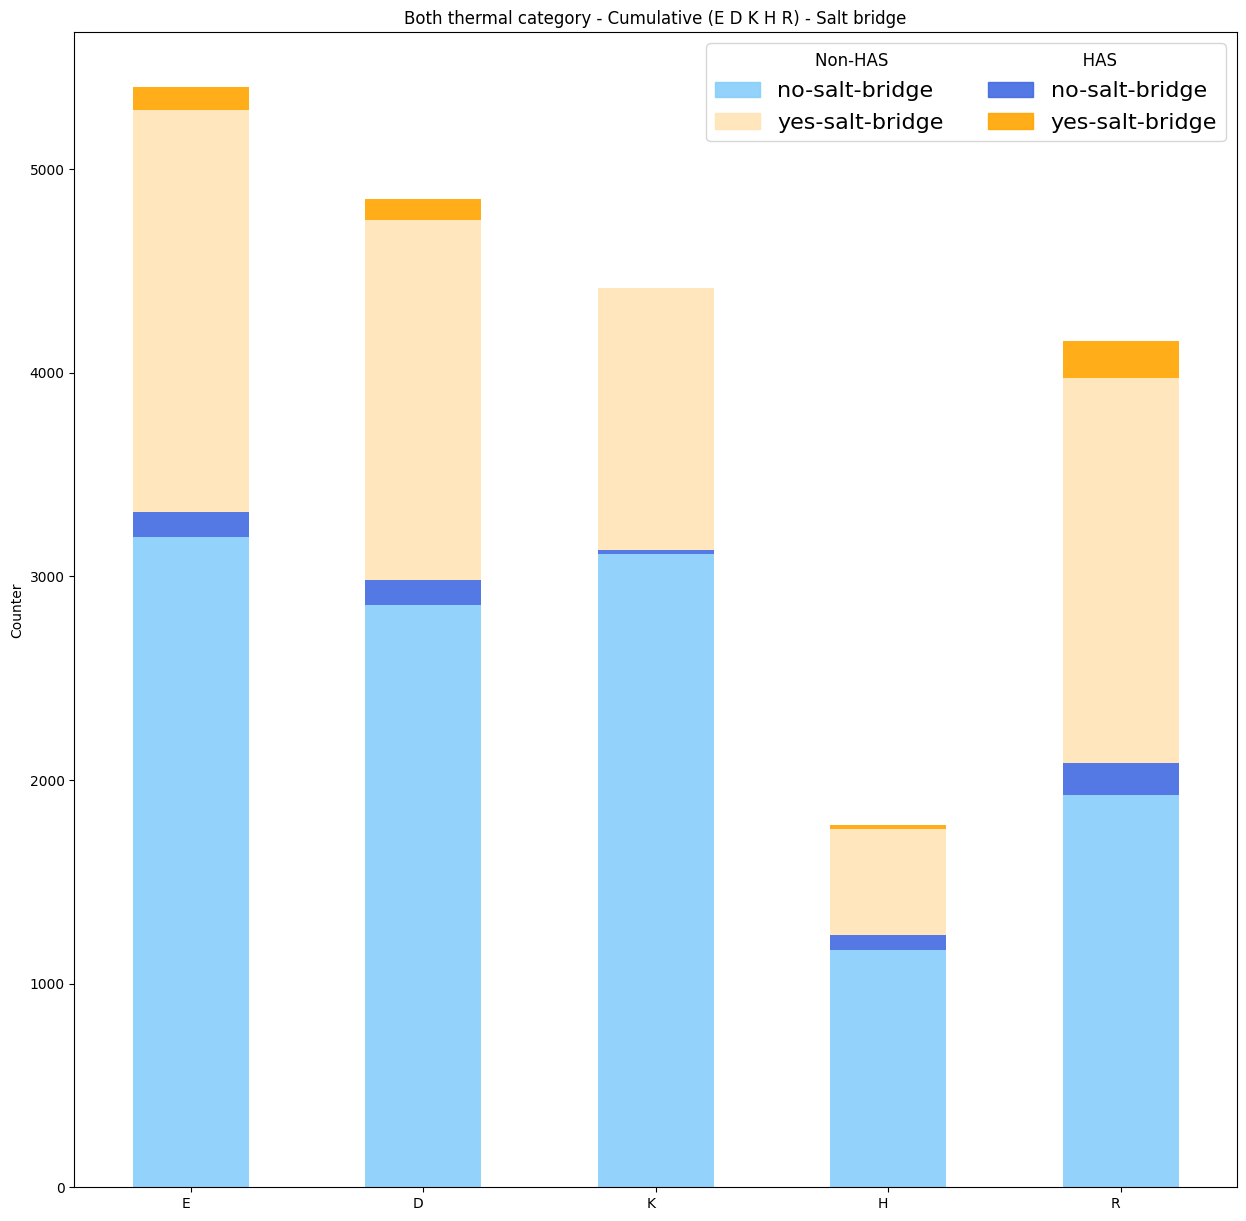

In [ ]:
from matplotlib.colors import to_rgba
color_dict = {'no_nohas': to_rgba('lightskyblue',0.9),'yes_nohas': to_rgba('moccasin',0.9),'no_has': to_rgba('royalblue',0.9),'yes_has': to_rgba('orange',0.9)}

ax=CONCAT_cumulative_salt_bridge.plot.bar(x='AA',stacked=True, title='Both thermal category - Cumulative (E D K H R) - Salt bridge',color=color_dict,figsize=(15, 15))
plt.xticks(rotation=0, ha='right')
ax.set(xlabel=None)
ax.set(ylabel='Counter')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
                  Patch([], [],  color= to_rgba('lightskyblue',0.9), label='no-salt-bridge', ),
                  Patch([], [], color=to_rgba('moccasin',0.9), label='yes-salt-bridge'),
                                     Patch([], [], color= to_rgba('royalblue',0.9), label='no-salt-bridge'),
                  Patch([], [], color=to_rgba('orange',0.9), label='yes-salt-bridge')
                  ]

plt.legend(handles=legend_elements, loc='upper right', ncol=2, title_fontsize='large',title='Non-HAS                                     HAS',fontsize=24,prop={'size': 16} )
#plt.savefig('SALT_BRIDGE_nonthermo_nohas.png',dpi=300, bbox_inches = "tight")
#plt.savefig('SALT_BRIDGE_nonthermo_nohas.svg',format='svg', dpi=300, bbox_inches = "tight")

In [ ]:
from pydrive.auth import GoogleAuth
from google.colab import auth

# Authenticate and create the PyDrive client.
auth.authenticate_user()

# to edit
"""
!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' 'SALT_BRIDGE_nonthermo.svg'
!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' 'SALT_BRIDGE_nonthermo.png'
!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' 'SALT_BRIDGE_thermo.svg'
!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' 'SALT_BRIDGE_thermo.png'
!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' 'SALT_BRIDGE_cumulative.svg'
!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' 'SALT_BRIDGE_cumulative.png' """

"\n!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' 'SALT_BRIDGE_nonthermo.svg'\n!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' 'SALT_BRIDGE_nonthermo.png'\n!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' 'SALT_BRIDGE_thermo.svg'\n!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' 'SALT_BRIDGE_thermo.png'\n!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' 'SALT_BRIDGE_cumulative.svg'\n!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' 'SALT_BRIDGE_cumulative.png' "

# CUMULATIVE DISULFIDE BONDS

##### HAS

In [ ]:
HAS_meso_disulfide_df

,nodisulfide,yesdisulfide,AA
0,90,0,L
1,163,0,A
2,104,0,G
3,109,0,V
4,115,0,E
5,70,0,S
6,146,0,I
7,14,0,K
8,165,0,R
9,112,0,D


In [ ]:
HAS_thermo_disulfide_df

,nodisulfide,yesdisulfide,AA
0,92,0,L
1,130,0,A
2,114,0,G
3,95,0,V
4,120,0,E
5,56,0,S
6,132,0,I
7,9,0,K
8,171,0,R
9,115,0,D


In [ ]:
HAS_cumulative_disulfide = HAS_meso_disulfide_df.add(HAS_thermo_disulfide_df, fill_value=0)
HAS_cumulative_disulfide['AA']=HAS_thermo_disulfide_df['AA']
HAS_cumulative_disulfide

,nodisulfide,yesdisulfide,AA
0,182,0,L
1,293,0,A
2,218,0,G
3,204,0,V
4,235,0,E
5,126,0,S
6,278,0,I
7,23,0,K
8,336,0,R
9,227,0,D


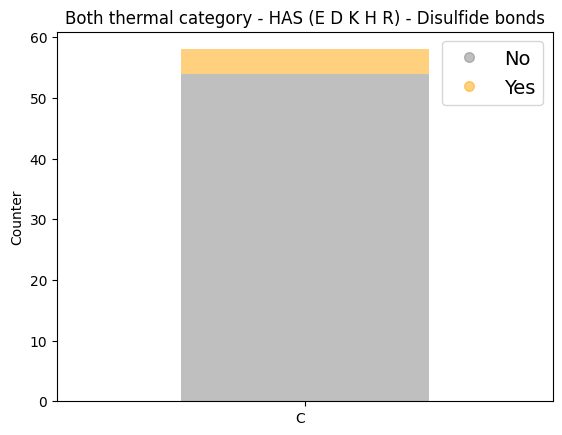

In [ ]:
from matplotlib.colors import to_rgba
color_dict = {'nodisulfide': to_rgba('gray',0.5),'yesdisulfide': to_rgba('orange',0.5)}

ax=HAS_cumulative_disulfide.loc[HAS_cumulative_disulfide['AA']== 'C'].plot.bar(x='AA',stacked=True, title='Both thermal category - HAS (E D K H R) - Disulfide bonds',color=color_dict)
plt.xticks(rotation=0, ha='right')
ax.set(xlabel=None)
ax.set(ylabel='Counter')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
                  Line2D([], [], marker='.', color= to_rgba('gray',0.5), label='No',
                          markersize=14,linestyle='None'),
                  Line2D([], [], marker='.', color=to_rgba('orange',0.5), label='Yes',
                          markersize=14,linestyle='None')
                  ]

plt.legend(handles=legend_elements, loc='best',fontsize=14,)
#plt.savefig('SALT_BRIDGE_cumulative.png',dpi=300, bbox_inches = "tight")
#plt.savefig('SALT_BRIDGE_cumulative.svg',format='svg', dpi=300, bbox_inches = "tight")

##### NO HAS

In [ ]:
NOHAS_meso_disulfide_df

,nodisulfide,yesdisulfide,AA
0,3477,0,L
1,3711,0,A
2,3208,0,G
3,2813,0,V
4,2425,0,E
5,2073,0,S
6,2119,0,I
7,2130,0,K
8,1848,0,R
9,2484,0,D


In [ ]:
NOHAS_thermo_disulfide_df

,nodisulfide,yesdisulfide,AA
0,3473,0,L
1,3370,0,A
2,3073,0,G
3,2867,0,V
4,2745,0,E
5,1801,0,S
6,2118,0,I
7,2268,0,K
8,1969,0,R
9,2145,0,D


In [ ]:
NOHAS_cumulative_disulfide = NOHAS_meso_disulfide_df.add(NOHAS_thermo_disulfide_df, fill_value=0)
NOHAS_cumulative_disulfide['AA']=NOHAS_thermo_disulfide_df['AA']
NOHAS_cumulative_disulfide

,nodisulfide,yesdisulfide,AA
0,6950,0,L
1,7081,0,A
2,6281,0,G
3,5680,0,V
4,5170,0,E
5,3874,0,S
6,4237,0,I
7,4398,0,K
8,3817,0,R
9,4629,0,D


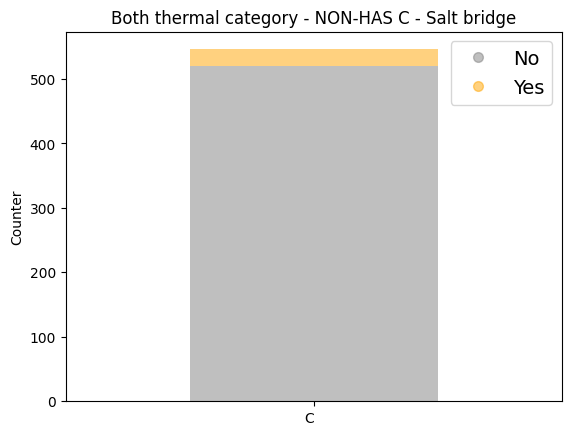

In [ ]:
from matplotlib.colors import to_rgba
color_dict = {'nodisulfide': to_rgba('gray',0.5),'yesdisulfide': to_rgba('orange',0.5)}

ax=NOHAS_cumulative_disulfide.loc[NOHAS_cumulative_disulfide['AA']== 'C'].plot.bar(x='AA',stacked=True, title='Both thermal category - NON-HAS C - Salt bridge',color=color_dict)
plt.xticks(rotation=0, ha='right')
ax.set(xlabel=None)
ax.set(ylabel='Counter')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
                  Line2D([], [], marker='.', color= to_rgba('gray',0.5), label='No',
                          markersize=14,linestyle='None'),
                  Line2D([], [], marker='.', color=to_rgba('orange',0.5), label='Yes',
                          markersize=14,linestyle='None')
                  ]

plt.legend(handles=legend_elements, loc='best',fontsize=14,)
#plt.savefig('SALT_BRIDGE_thermo_nohas.png',dpi=300, bbox_inches = "tight")
#plt.savefig('SALT_BRIDGE_thermo_nohas.svg',format='svg', dpi=300, bbox_inches = "tight")

##### CONCAT

In [ ]:
thermo_concat_disulfide

,AA,no_nohas,no_has,yes_nohas,yes_has
0,L,3473,92,0,0
1,A,3370,130,0,0
2,G,3073,114,0,0
3,V,2867,95,0,0
4,E,2745,120,0,0
5,S,1801,56,0,0
6,I,2118,132,0,0
7,K,2268,9,0,0
8,R,1969,171,0,0
9,D,2145,115,0,0


In [ ]:
meso_concat_disulfide

,AA,no_nohas,no_has,yes_nohas,yes_has
0,L,3477,90,0,0
1,A,3711,163,0,0
2,G,3208,104,0,0
3,V,2813,109,0,0
4,E,2425,115,0,0
5,S,2073,70,0,0
6,I,2119,146,0,0
7,K,2130,14,0,0
8,R,1848,165,0,0
9,D,2484,112,0,0


In [ ]:
CONCAT_cumulative_disulfide = thermo_concat_disulfide.add(meso_concat_disulfide, fill_value=0)
CONCAT_cumulative_disulfide['AA']=NOHAS_thermo_disulfide_df['AA']
CONCAT_cumulative_disulfide

,AA,no_nohas,no_has,yes_nohas,yes_has
0,L,6950,182,0,0
1,A,7081,293,0,0
2,G,6281,218,0,0
3,V,5680,204,0,0
4,E,5170,235,0,0
5,S,3874,126,0,0
6,I,4237,278,0,0
7,K,4398,23,0,0
8,R,3817,336,0,0
9,D,4629,227,0,0


<ipython-input-121-2482064678a3>:12: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch([], [],  color= to_rgba('lightskyblue',0.9), label='no-disulfide-bonds', ),
<ipython-input-121-2482064678a3>:13: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch([], [], color=to_rgba('moccasin',0.9), label='yes-disulfide-bonds'),
<ipython-input-121-2482064678a3>:14: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch([], [], color= to_rgba('royalblue',0.9), label='no-disulfide-bonds'),
<ipython-input-121-2482064678a3>:15: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch([], [], color=to_rgba('orange',0.9), label='yes-disulfide-bonds')


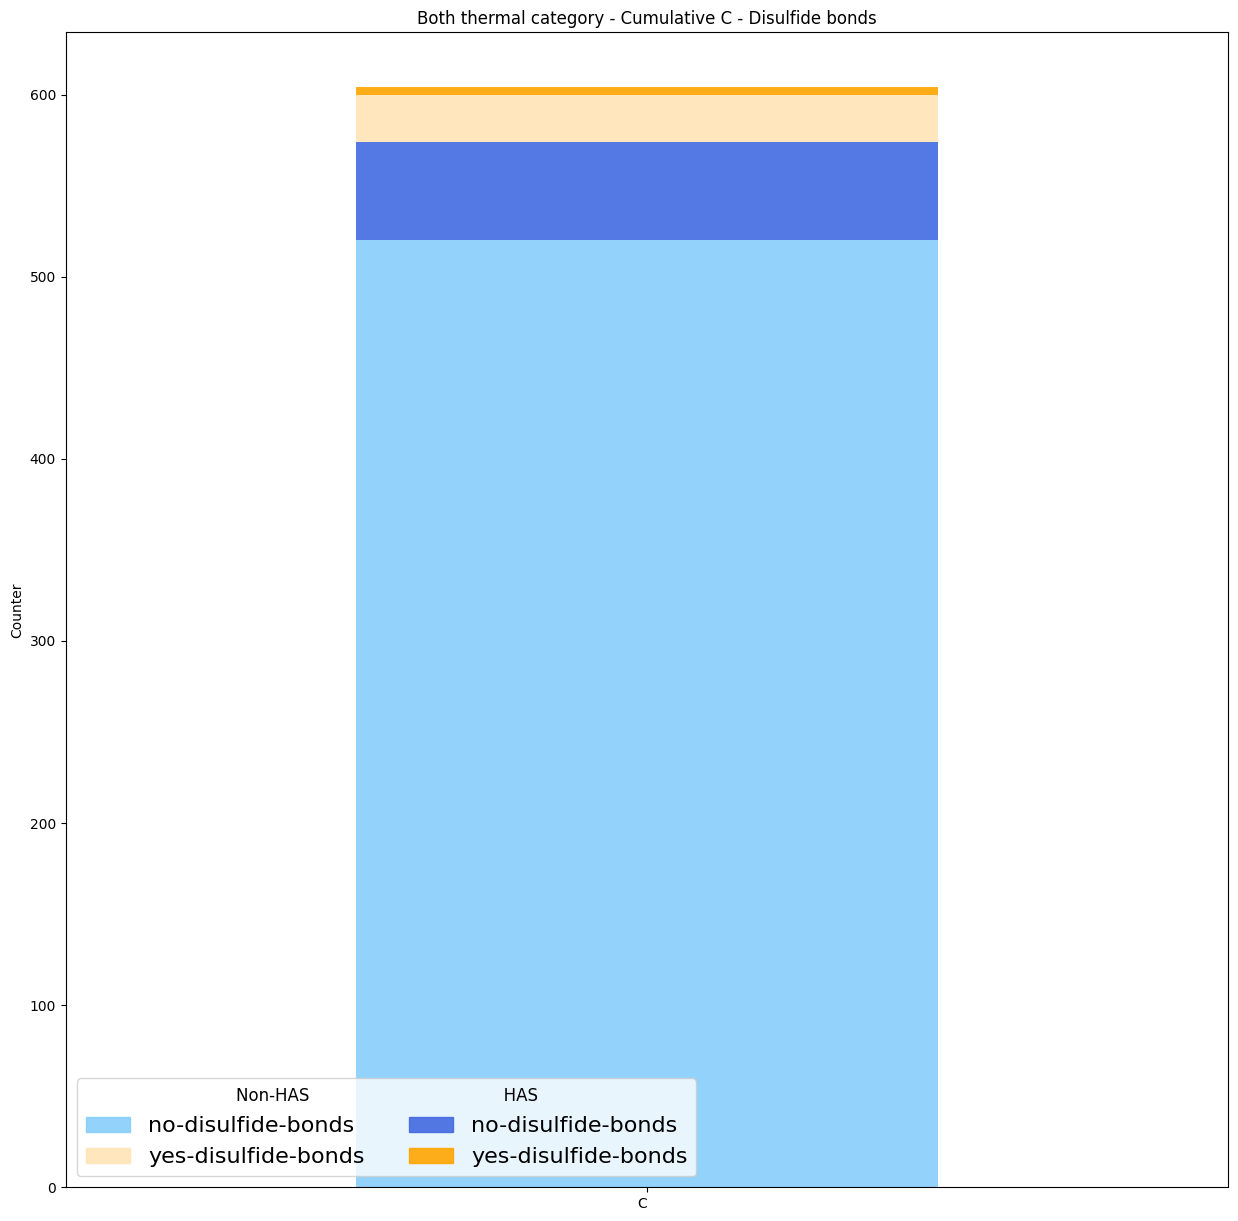

In [ ]:
from matplotlib.colors import to_rgba
color_dict = {'no_nohas': to_rgba('lightskyblue',0.9),'yes_nohas': to_rgba('moccasin',0.9),'no_has': to_rgba('royalblue',0.9),'yes_has': to_rgba('orange',0.9)}

ax=CONCAT_cumulative_disulfide.loc[CONCAT_cumulative_disulfide['AA']== 'C'].plot.bar(x='AA',stacked=True, title='Both thermal category - Cumulative C - Disulfide bonds',color=color_dict,figsize=(15, 15))
plt.xticks(rotation=0, ha='right')
ax.set(xlabel=None)
ax.set(ylabel='Counter')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
                  Patch([], [],  color= to_rgba('lightskyblue',0.9), label='no-disulfide-bonds', ),
                  Patch([], [], color=to_rgba('moccasin',0.9), label='yes-disulfide-bonds'),
                                     Patch([], [], color= to_rgba('royalblue',0.9), label='no-disulfide-bonds'),
                  Patch([], [], color=to_rgba('orange',0.9), label='yes-disulfide-bonds')
                  ]

plt.legend(handles=legend_elements, loc='lower left', ncol=2, title_fontsize='large',title='Non-HAS                                     HAS',fontsize=24,prop={'size': 16} )
#plt.savefig('SALT_BRIDGE_nonthermo_nohas.png',dpi=300, bbox_inches = "tight")
#plt.savefig('SALT_BRIDGE_nonthermo_nohas.svg',format='svg', dpi=300, bbox_inches = "tight")

In [ ]:
from pydrive.auth import GoogleAuth
from google.colab import auth

# Authenticate and create the PyDrive client.
auth.authenticate_user()

# to edit
"""
!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' 'SALT_BRIDGE_nonthermo.svg'
!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' 'SALT_BRIDGE_nonthermo.png'
!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' 'SALT_BRIDGE_thermo.svg'
!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' 'SALT_BRIDGE_thermo.png'
!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' 'SALT_BRIDGE_cumulative.svg'
!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' 'SALT_BRIDGE_cumulative.png' """

"\n!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' 'SALT_BRIDGE_nonthermo.svg'\n!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' 'SALT_BRIDGE_nonthermo.png'\n!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' 'SALT_BRIDGE_thermo.svg'\n!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' 'SALT_BRIDGE_thermo.png'\n!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' 'SALT_BRIDGE_cumulative.svg'\n!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' 'SALT_BRIDGE_cumulative.png' "

# CUMULATIVE SASA ANALYSIS

In [ ]:
#change order in plotting (core and then surface)
thermo_baseline_sasa_avgDict_exposition_plot_df=thermo_baseline_sasa_avgDict_exposition_plot_df[['core','surface']]

meso_baseline_sasa_avgDict_exposition_plot_df=meso_baseline_sasa_avgDict_exposition_plot_df[['core','surface']]

thermo_HAS_sasa_avgDict_exposition_plot_df=thermo_HAS_sasa_avgDict_exposition_plot_df[['core','surface']]

meso_HAS_sasa_avgDict_exposition_plot_df=meso_HAS_sasa_avgDict_exposition_plot_df[['core','surface']]


thermo_baseline_sasa_avgDict_exposition_df.sort_index(axis=0,ascending=True,inplace=True)
thermo_HAS_sasa_avgDict_exposition_df.sort_index(axis=0,ascending=True,inplace=True)

meso_baseline_sasa_avgDict_exposition_df.sort_index(axis=0,ascending=True,inplace=True)
meso_HAS_sasa_avgDict_exposition_df.sort_index(axis=0,ascending=True,inplace=True)

In [ ]:
meso_HAS_sasa_avgDict_exposition_df

,L,A,G,V,E,S,I,K,R,D,T,P,N,Q,F,Y,M,H,C,W
core,0.833333,0.697531,0.509615,0.93578,0.304348,0.471429,0.883562,0.357143,0.448485,0.383929,0.705882,0.515873,0.724138,0.576923,0.826389,0.690141,0.322581,0.595745,0.8125,0.789474
surface,0.166667,0.302469,0.490385,0.06422,0.695652,0.528571,0.116438,0.642857,0.551515,0.616071,0.294118,0.484127,0.275862,0.423077,0.173611,0.309859,0.677419,0.404255,0.1875,0.210526


In [ ]:
#forcing the order of the bars to be the same of the aa types category
aa_order=['R','K','H','D','E','S','T','N','Q','A','V','L','I','M','F','W','Y','G','P','C']
len(aa_order)
thermo_baseline_sasa_avgDict_exposition_df=thermo_baseline_sasa_avgDict_exposition_df[aa_order]
thermo_HAS_sasa_avgDict_exposition_df=thermo_HAS_sasa_avgDict_exposition_df[aa_order]
meso_baseline_sasa_avgDict_exposition_df=meso_baseline_sasa_avgDict_exposition_df[aa_order]
meso_HAS_sasa_avgDict_exposition_df=meso_HAS_sasa_avgDict_exposition_df[aa_order]
thermo_baseline_sasa_avgDict_exposition_plot_df=thermo_baseline_sasa_avgDict_exposition_plot_df.loc[aa_order]
thermo_HAS_sasa_avgDict_exposition_plot_df=thermo_HAS_sasa_avgDict_exposition_plot_df.loc[aa_order]
meso_baseline_sasa_avgDict_exposition_plot_df=meso_baseline_sasa_avgDict_exposition_plot_df.loc[aa_order]
meso_HAS_sasa_avgDict_exposition_plot_df=meso_HAS_sasa_avgDict_exposition_plot_df.loc[aa_order]
meso_HAS_sasa_avgDict_exposition_df

,R,K,H,D,E,S,T,N,Q,A,V,L,I,M,F,W,Y,G,P,C
core,0.448485,0.357143,0.595745,0.383929,0.304348,0.471429,0.705882,0.724138,0.576923,0.697531,0.93578,0.833333,0.883562,0.322581,0.826389,0.789474,0.690141,0.509615,0.515873,0.8125
surface,0.551515,0.642857,0.404255,0.616071,0.695652,0.528571,0.294118,0.275862,0.423077,0.302469,0.06422,0.166667,0.116438,0.677419,0.173611,0.210526,0.309859,0.490385,0.484127,0.1875


In [ ]:
## INFO RECAP SUMMARY (needed only for the manuscript)
meso_recap=meso_baseline_sasa_avgDict_exposition_plot_df.copy(deep=True)
meso_recap['sum']=meso_recap[['core','surface']].sum(axis=1)
meso_HAS_recap=meso_HAS_sasa_avgDict_exposition_plot_df.copy(deep=True)
meso_HAS_recap['sum']=meso_HAS_recap[['core','surface']].sum(axis=1)
thermo_recap=thermo_baseline_sasa_avgDict_exposition_plot_df.copy(deep=True)
thermo_recap['sum']=thermo_recap[['core','surface']].sum(axis=1)
thermo_HAS_recap=thermo_HAS_sasa_avgDict_exposition_plot_df.copy(deep=True)
thermo_HAS_recap['sum']=thermo_HAS_recap[['core','surface']].sum(axis=1)

In [ ]:
print(meso_recap)

       core   surface       sum
R  0.017569  0.032667  0.050236
K  0.009608  0.043797  0.053405
H  0.012104  0.011180  0.023284
D  0.020514  0.044122  0.064635
E  0.014948  0.048339  0.063288
S  0.026054  0.027376  0.053430
T  0.028524  0.025754  0.054279
N  0.016371  0.027202  0.043573
Q  0.011704  0.022385  0.034089
A  0.061441  0.035113  0.096554
V  0.056500  0.016296  0.072796
L  0.069626  0.019366  0.088992
I  0.046542  0.009982  0.056525
M  0.015647  0.005590  0.021237
F  0.030097  0.007512  0.037608
W  0.011355  0.003743  0.015098
Y  0.024482  0.010556  0.035038
G  0.042325  0.040204  0.082529
P  0.019316  0.025530  0.044845
C  0.007038  0.001522  0.008560


In [ ]:
print(meso_HAS_recap)

       core   surface       sum
R  0.044444  0.054655  0.099099
K  0.003003  0.005405  0.008408
H  0.016817  0.011411  0.028228
D  0.025826  0.041441  0.067267
E  0.021021  0.048048  0.069069
S  0.019820  0.022222  0.042042
T  0.014414  0.006006  0.020420
N  0.012613  0.004805  0.017417
Q  0.009009  0.006607  0.015616
A  0.067868  0.029429  0.097297
V  0.061261  0.004204  0.065465
L  0.045045  0.009009  0.054054
I  0.077477  0.010210  0.087688
M  0.006006  0.012613  0.018619
F  0.071471  0.015015  0.086486
W  0.018018  0.004805  0.022823
Y  0.029429  0.013213  0.042643
G  0.031832  0.030631  0.062462
P  0.039039  0.036637  0.075676
C  0.015616  0.003604  0.019219


In [ ]:
print(thermo_recap)

       core   surface       sum
R  0.017893  0.037124  0.055017
K  0.010515  0.048024  0.058539
H  0.011903  0.009821  0.021724
D  0.020464  0.037638  0.058102
E  0.017096  0.056560  0.073656
S  0.024475  0.023267  0.047741
T  0.028485  0.023498  0.051983
N  0.015297  0.024192  0.039489
Q  0.009872  0.019487  0.029360
A  0.060313  0.029668  0.089981
V  0.061187  0.014963  0.076150
L  0.071574  0.020079  0.091652
I  0.047099  0.010746  0.057845
M  0.015040  0.005707  0.020747
F  0.031005  0.007224  0.038229
W  0.011518  0.004191  0.015708
Y  0.026043  0.011852  0.037895
G  0.041931  0.040003  0.081934
P  0.020953  0.026686  0.047639
C  0.005450  0.001157  0.006607


In [ ]:
sum(thermo_recap['sum'])

1.0

In [ ]:
print(thermo_HAS_recap)

       core   surface       sum
R  0.048095  0.058713  0.106808
K  0.001874  0.003748  0.005621
H  0.018114  0.011243  0.029357
D  0.031230  0.040600  0.071830
E  0.031230  0.043723  0.074953
S  0.020612  0.014366  0.034978
T  0.010618  0.004372  0.014991
N  0.011243  0.008745  0.019988
Q  0.004997  0.004372  0.009369
A  0.063710  0.017489  0.081199
V  0.052467  0.006871  0.059338
L  0.051843  0.005621  0.057464
I  0.074953  0.007495  0.082448
M  0.003748  0.015615  0.019363
F  0.073704  0.014991  0.088695
W  0.009994  0.008745  0.018738
Y  0.034978  0.017489  0.052467
G  0.041849  0.029357  0.071205
P  0.048720  0.036227  0.084947
C  0.014366  0.001874  0.016240


In [ ]:
thermo_baseline_sasa_avgDict_exposition_plot_df

,core,surface
R,0.017893,0.037124
K,0.010515,0.048024
H,0.011903,0.009821
D,0.020464,0.037638
E,0.017096,0.056560
S,0.024475,0.023267
T,0.028485,0.023498
N,0.015297,0.024192
Q,0.009872,0.019487
A,0.060313,0.029668


<ipython-input-133-1827dfdbc0dd>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=24)
<ipython-input-133-1827dfdbc0dd>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=24)


Text(308.59722222222223, 0.5, '(% of total HAS amino acids) - (% of total amino acids)')

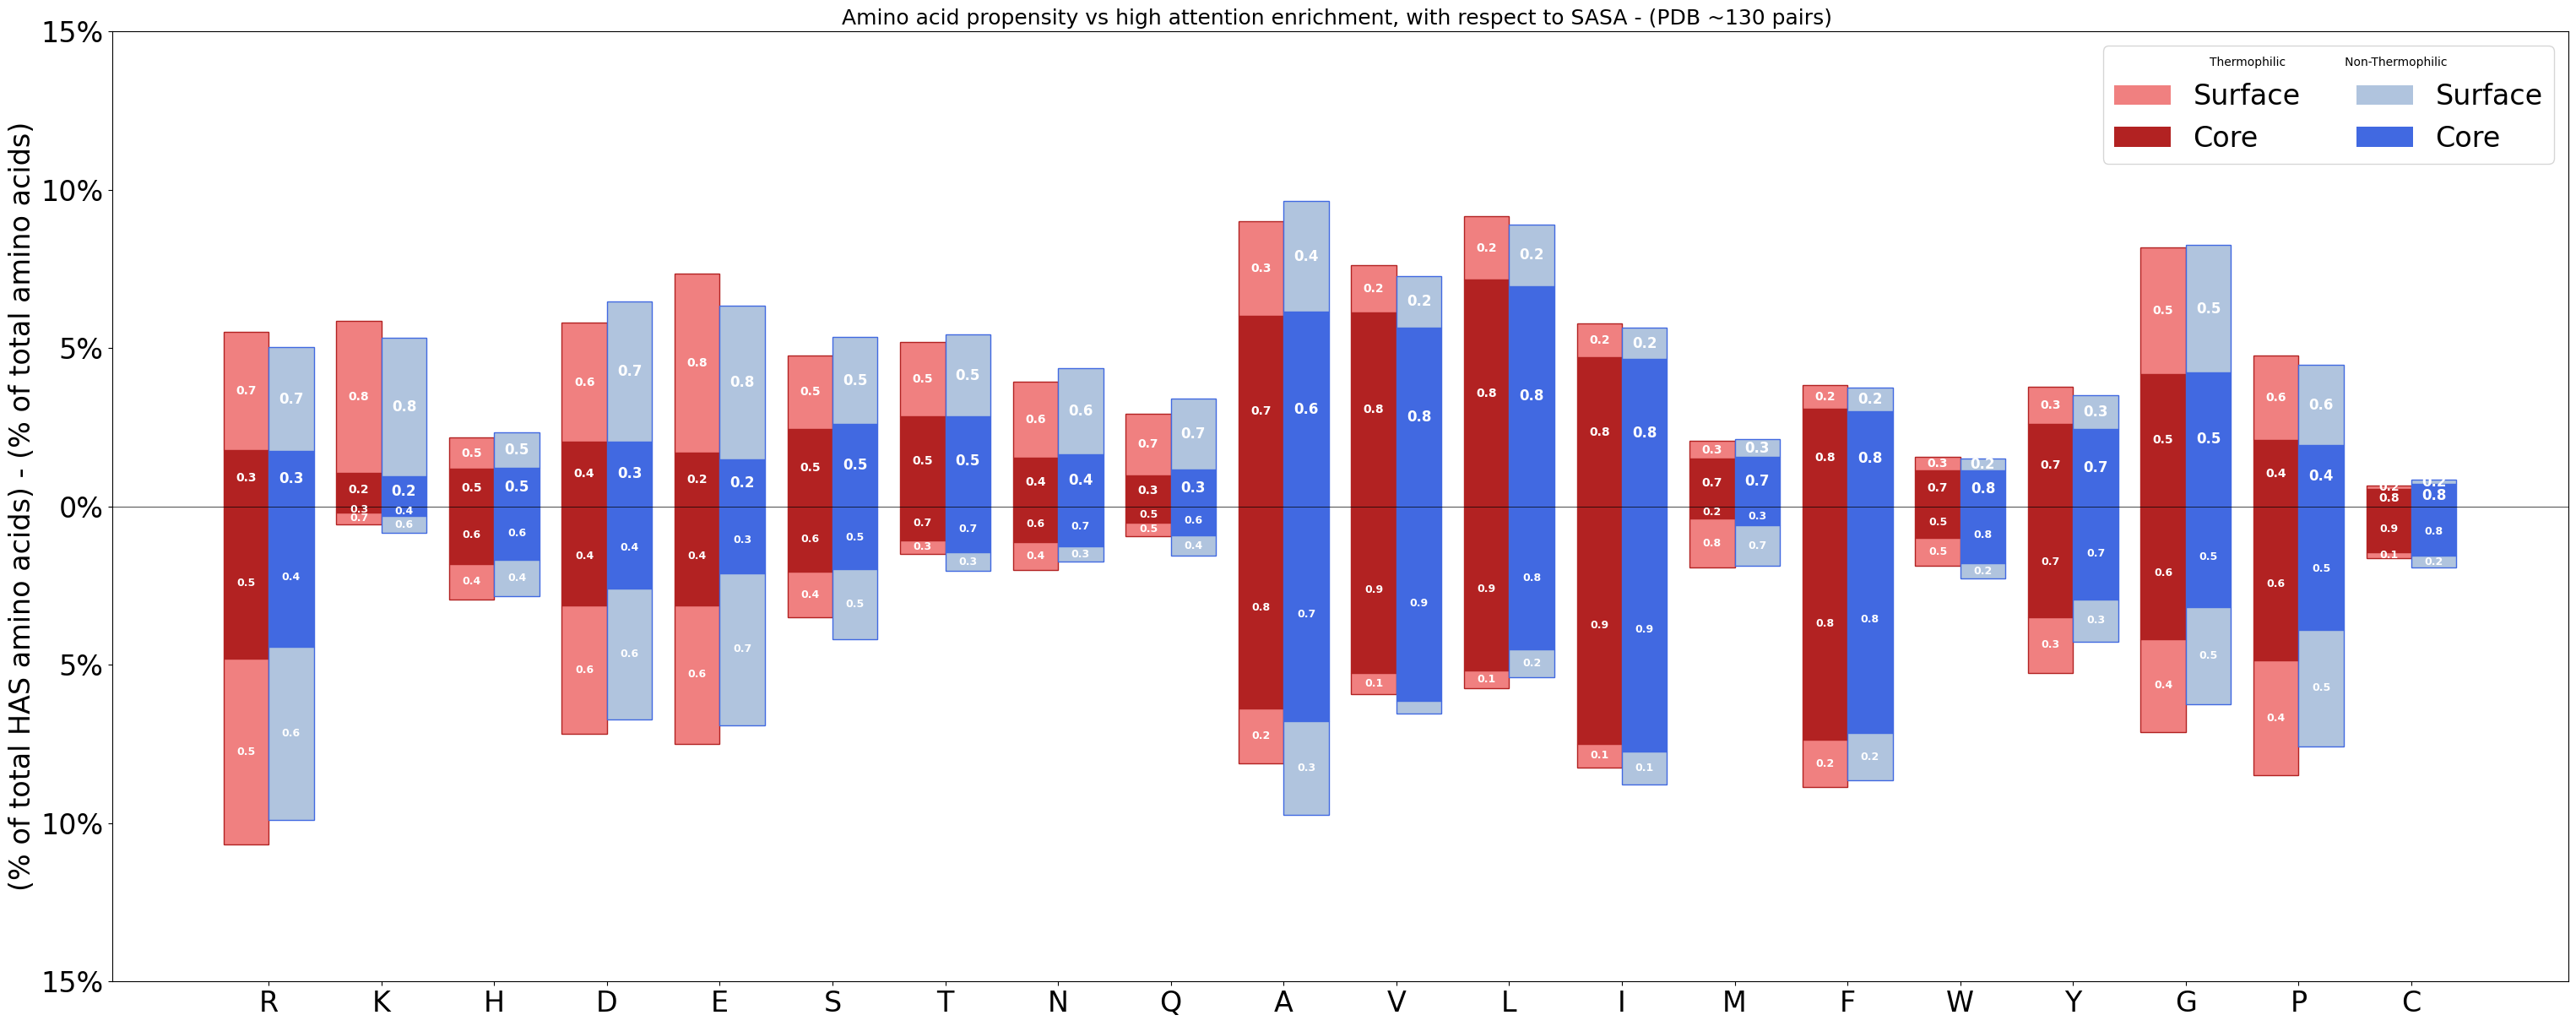

In [ ]:
## BASELINE VS HAS -- ALTERNATIVE COLOR
fig, ax = plt.subplots(figsize=(30, 15))

#baseline
thermo_baseline_sasa_avgDict_exposition_plot_df.plot(kind='bar', stacked=True,width=-0.4,align='edge',ax=ax,edgecolor='firebrick',color=['firebrick','lightcoral',],legend=False)
meso_baseline_sasa_avgDict_exposition_plot_df.plot(kind='bar', stacked=True,width=0.4,align='edge',ax=ax,legend=False,edgecolor='royalblue',color=['royalblue','lightsteelblue'])
#HAS
(thermo_HAS_sasa_avgDict_exposition_plot_df* -1).plot(kind='bar', stacked=True,width=-0.4,align='edge',ax=ax,edgecolor='firebrick',color=['firebrick','lightcoral',],legend=False)
(meso_HAS_sasa_avgDict_exposition_plot_df* -1).plot(kind='bar', stacked=True,width=0.4,align='edge',ax=ax,legend=False,edgecolor='royalblue',color=['royalblue','lightsteelblue',],)


plt.title('Amino acid propensity vs high attention enrichment, with respect to SASA - (PDB ~130 pairs) ',fontsize=18)
ax.autoscale(tight=False)
ax.axhline(0, color='black', linewidth=0.5) #adding x ax

# Formatting x labels
plt.xticks(rotation=0,fontsize=24)
plt.tight_layout()
ax.use_sticky_edges = False


## add annotations
df_row=0
#up plot
for c in ax.containers[0:2]:
  #[word for sentence in text for word in sentence]
  labels = ["{:.1f}".format(list(thermo_baseline_sasa_avgDict_exposition_df.iloc[df_row])[v]) if list(thermo_baseline_sasa_avgDict_exposition_df .iloc[df_row])[v] > 0.09 else '' for v in range(0,len(c)) ]
  #print(labels)
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=10,label_type='center', color= 'white',weight='bold')

df_row=0
for c in ax.containers[2:4]:
  labels = ["{:.1f}".format(list(meso_baseline_sasa_avgDict_exposition_df.iloc[df_row])[v]) if list(meso_baseline_sasa_avgDict_exposition_df .iloc[df_row])[v] > 0.09 else '' for v in range(0,len(c)) ]
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=12,label_type='center',color= 'white',weight='bold')

ticks =  ax.get_yticks()
ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=24)
plt.ylim([-0.15, 0.15])

plt.subplots_adjust(top=0.85,bottom=0.10)

## add annotations
df_row=0
#down plot
for c in ax.containers[4:6]:
  #[word for sentence in text for word in sentence]
  labels = ["{:.1f}".format(list(thermo_HAS_sasa_avgDict_exposition_df.iloc[df_row])[v]) if list(thermo_HAS_sasa_avgDict_exposition_df .iloc[df_row])[v] > 0.09 else '' for v in range(0,len(c)) ]
  #print(labels)
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=9,label_type='center',color= 'white',weight='bold')

df_row=0
for c in ax.containers[6:8]:
  labels = ["{:.1f}".format(list(meso_HAS_sasa_avgDict_exposition_df.iloc[df_row])[v]) if list(meso_HAS_sasa_avgDict_exposition_df .iloc[df_row])[v] > 0.09 else '' for v in range(0,len(c)) ]
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=9,label_type='center',color= 'white',weight='bold')

ticks =  ax.get_yticks()
ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=24)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Patch(facecolor='lightcoral',label='Surface'),
                   Patch(facecolor='firebrick',label='Core'),
                   Patch(facecolor='lightsteelblue',label='Surface'),
                   Patch(facecolor='royalblue',label='Core'),
                  ]

# Create the figure

ax.legend(handles=legend_elements, loc='best',fontsize=24,ncol=2, title='Thermophilic                Non-Thermophilic')
plt.xticks(rotation=0,fontsize=24)
plt.yticks(rotation=0,fontsize=24)

plt.ylabel("(% of total HAS amino acids) - (% of total amino acids)",fontsize=24)
#plt.savefig('propensity_vs_HAS_SASA.png',dpi=300, bbox_inches = "tight")
#plt.savefig('propensity_vs_HAS_SASA.svg',format='svg', dpi=300, bbox_inches = "tight")

<ipython-input-134-983987e08da6>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=24)
<ipython-input-134-983987e08da6>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=24)


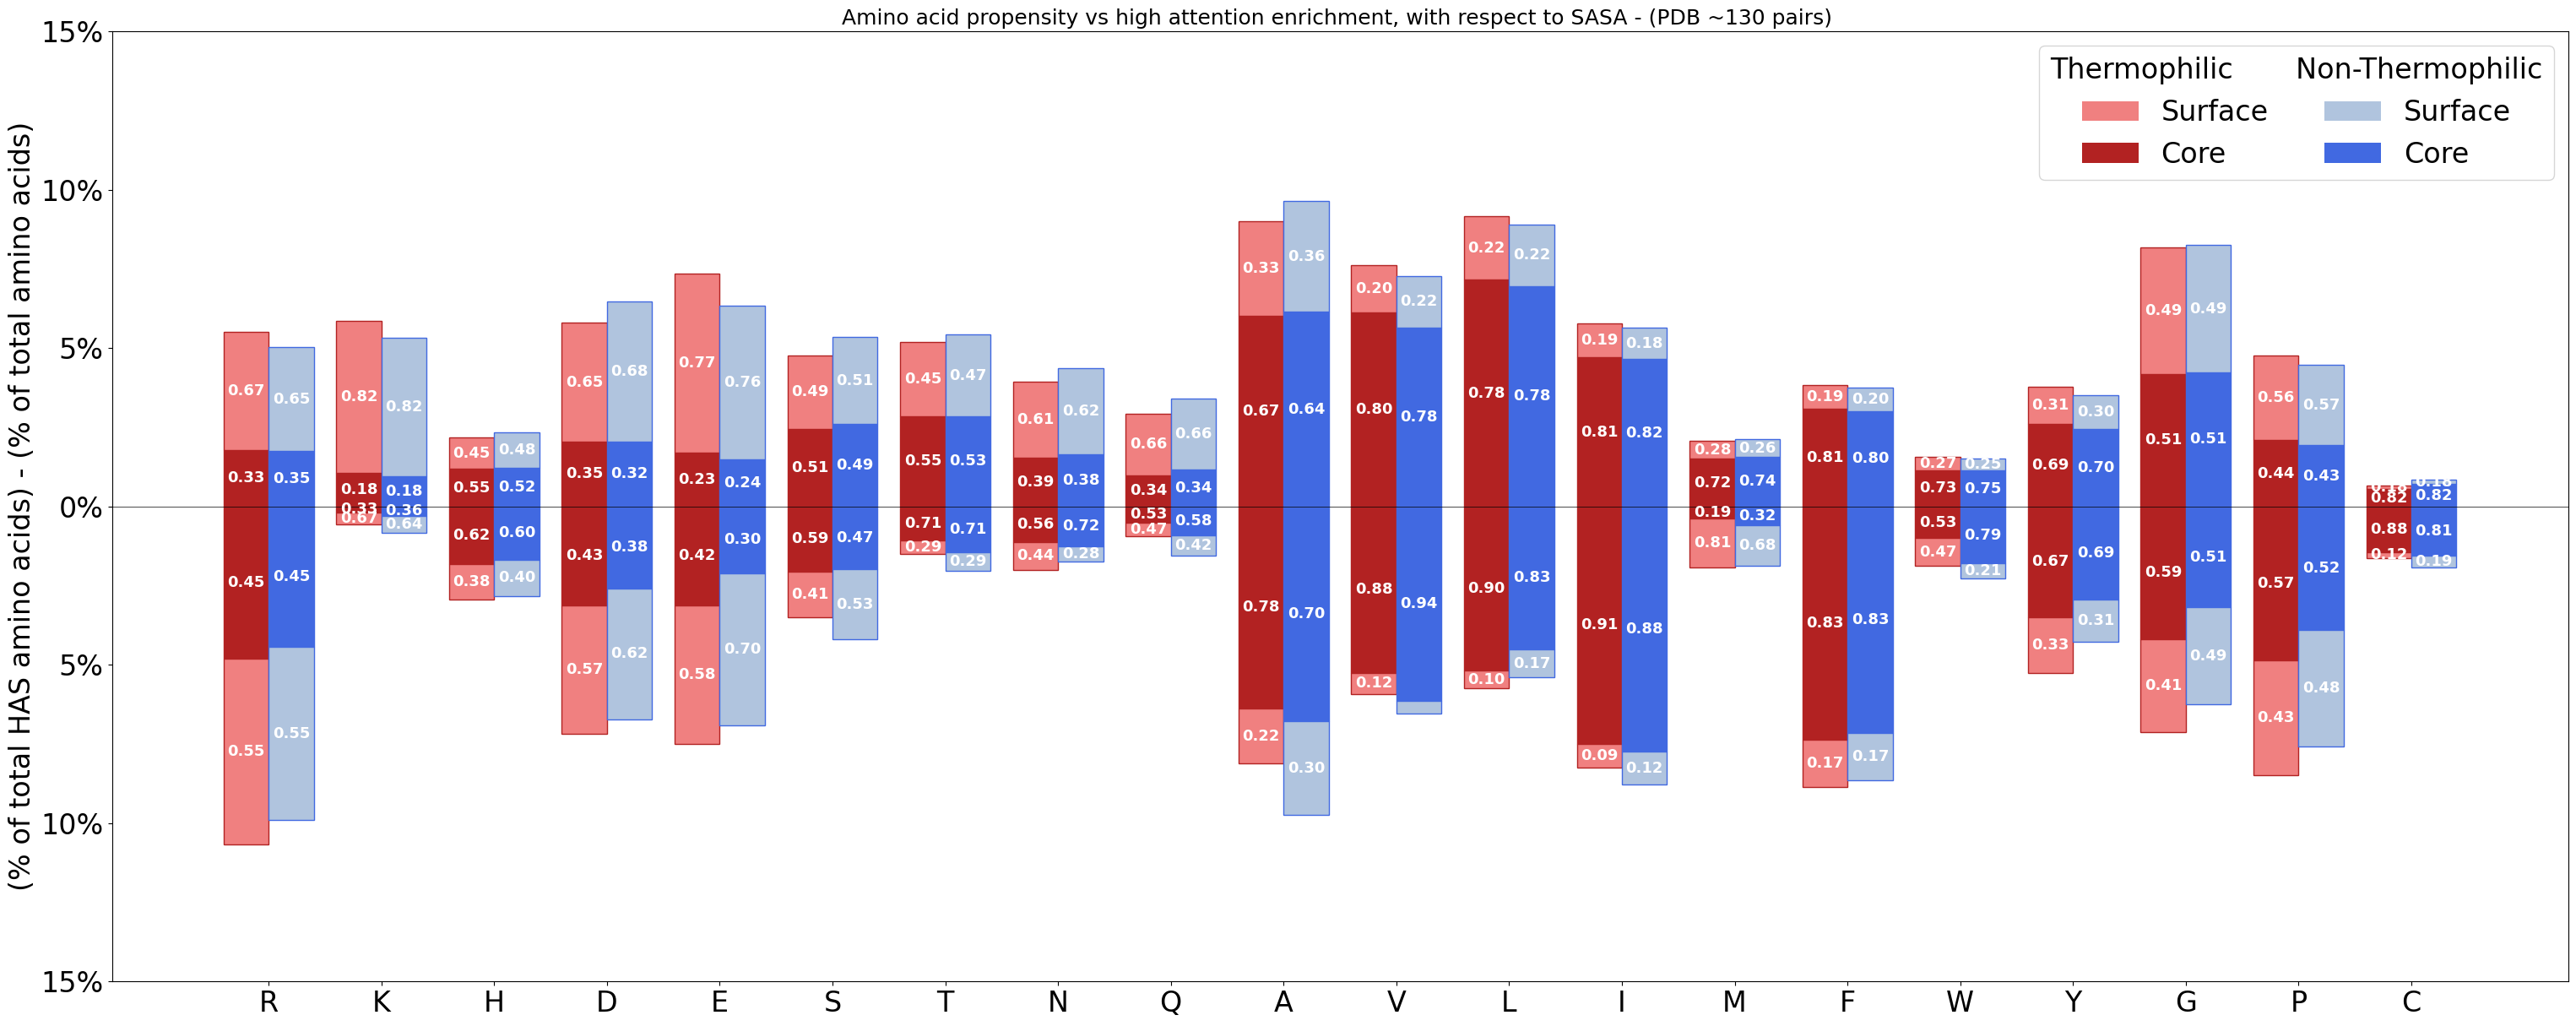

In [ ]:
## BASELINE VS HAS -- ALTERNATIVE COLOR
fig, ax = plt.subplots(figsize=(30, 15))

#baseline
thermo_baseline_sasa_avgDict_exposition_plot_df.plot(kind='bar', stacked=True,width=-0.4,align='edge',ax=ax,edgecolor='firebrick',color=['firebrick','lightcoral',],legend=False)
meso_baseline_sasa_avgDict_exposition_plot_df.plot(kind='bar', stacked=True,width=0.4,align='edge',ax=ax,legend=False,edgecolor='royalblue',color=['royalblue','lightsteelblue'])
#HAS
(thermo_HAS_sasa_avgDict_exposition_plot_df* -1).plot(kind='bar', stacked=True,width=-0.4,align='edge',ax=ax,edgecolor='firebrick',color=['firebrick','lightcoral',],legend=False)
(meso_HAS_sasa_avgDict_exposition_plot_df* -1).plot(kind='bar', stacked=True,width=0.4,align='edge',ax=ax,legend=False,edgecolor='royalblue',color=['royalblue','lightsteelblue',],)


plt.title('Amino acid propensity vs high attention enrichment, with respect to SASA - (PDB ~130 pairs) ',fontsize=18)
ax.autoscale(tight=False)
ax.axhline(0, color='black', linewidth=0.5) #adding x ax

# Formatting x labels
plt.xticks(rotation=0,fontsize=24)
plt.tight_layout()
ax.use_sticky_edges = False


## add annotations
df_row=0
#up plot
for c in ax.containers[0:2]:
  #[word for sentence in text for word in sentence]
  labels = ["{:.2f}".format(list(thermo_baseline_sasa_avgDict_exposition_df.iloc[df_row])[v]) if list(thermo_baseline_sasa_avgDict_exposition_df .iloc[df_row])[v] > 0.09 else '' for v in range(0,len(c)) ]
  #print(labels)
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=13,label_type='center', color= 'white',weight='bold')

df_row=0
for c in ax.containers[2:4]:
  labels = ["{:.2f}".format(list(meso_baseline_sasa_avgDict_exposition_df.iloc[df_row])[v]) if list(meso_baseline_sasa_avgDict_exposition_df .iloc[df_row])[v] > 0.09 else '' for v in range(0,len(c)) ]
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=13,label_type='center',color= 'white',weight='bold')

ticks =  ax.get_yticks()
ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=24)
plt.ylim([-0.15, 0.15])

plt.subplots_adjust(top=0.85,bottom=0.10)

## add annotations
df_row=0
#down plot
for c in ax.containers[4:6]:
  #[word for sentence in text for word in sentence]
  labels = ["{:.2f}".format(list(thermo_HAS_sasa_avgDict_exposition_df.iloc[df_row])[v]) if list(thermo_HAS_sasa_avgDict_exposition_df .iloc[df_row])[v] > 0.09 else '' for v in range(0,len(c)) ]
  #print(labels)
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=13,label_type='center',color= 'white',weight='bold')

df_row=0
for c in ax.containers[6:8]:
  labels = ["{:.2f}".format(list(meso_HAS_sasa_avgDict_exposition_df.iloc[df_row])[v]) if list(meso_HAS_sasa_avgDict_exposition_df .iloc[df_row])[v] > 0.09 else '' for v in range(0,len(c)) ]
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=13,label_type='center',color= 'white',weight='bold')

ticks =  ax.get_yticks()
ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=24)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Patch(facecolor='lightcoral',label='Surface'),
                   Patch(facecolor='firebrick',label='Core'),
                   Patch(facecolor='lightsteelblue',label='Surface'),
                   Patch(facecolor='royalblue',label='Core'),
                  ]

# Create the figure

ax.legend(handles=legend_elements, loc='best',fontsize=24,ncol=2, title='Thermophilic       Non-Thermophilic',title_fontsize=24)
plt.xticks(rotation=0,fontsize=24)
plt.yticks(rotation=0,fontsize=24)

plt.ylabel("(% of total HAS amino acids) - (% of total amino acids)",fontsize=24)
plt.savefig('propensity_vs_HAS_SASA.png',dpi=300, bbox_inches = "tight")
plt.savefig('propensity_vs_HAS_SASA.svg',format='svg', dpi=300, bbox_inches = "tight")

In [ ]:
thermo_baseline_sasa_avgDict_exposition_plot_df

In [ ]:
thermo_baseline_sasa_avgDict_exposition_df

In [ ]:
meso_baseline_sasa_avgDict_exposition_df

,R,K,H,D,E,S,T,N,Q,A,V,L,I,M,F,W,Y,G,P,C
core,0.349727,0.179907,0.519829,0.317375,0.236199,0.487623,0.525517,0.375716,0.343338,0.63634,0.77614,0.782389,0.8234,0.73678,0.800265,0.752066,0.698718,0.512852,0.430718,0.822157
surface,0.650273,0.820093,0.480171,0.682625,0.763801,0.512377,0.474483,0.624284,0.656662,0.36366,0.22386,0.217611,0.1766,0.26322,0.199735,0.247934,0.301282,0.487148,0.569282,0.177843


In [ ]:
thermo_HAS_sasa_avgDict_exposition_df
#meso_HAS_sasa_avgDict_exposition_df

,R,K,H,D,E,S,T,N,Q,A,V,L,I,M,F,W,Y,G,P,C
core,0.450292,0.333333,0.617021,0.434783,0.416667,0.589286,0.708333,0.5625,0.533333,0.784615,0.884211,0.902174,0.909091,0.193548,0.830986,0.533333,0.666667,0.587719,0.573529,0.884615
surface,0.549708,0.666667,0.382979,0.565217,0.583333,0.410714,0.291667,0.4375,0.466667,0.215385,0.115789,0.097826,0.090909,0.806452,0.169014,0.466667,0.333333,0.412281,0.426471,0.115385


In [ ]:
from pydrive.auth import GoogleAuth
from google.colab import auth

# Authenticate and create the PyDrive client.
auth.authenticate_user()

# to edit
'''
!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' propensity_vs_HAS_SASA.png
!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' propensity_vs_HAS_SASA.svg'''

"\n!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' propensity_vs_HAS_SASA.png\n!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' propensity_vs_HAS_SASA.svg"

In [ ]:
'''fig, ax = plt.subplots(figsize=(20, 10))

thermo_baseline_sasa_avgDict_exposition_plot_df.plot(kind='bar', stacked=True,width=-0.4,align='edge',ax=ax,linewidth=3.5,edgecolor='firebrick',color=['antiquewhite','lavender'])
meso_baseline_sasa_avgDict_exposition_plot_df.plot(kind='bar', stacked=True,width=0.4,align='edge',ax=ax,legend=False,linewidth=3.5,edgecolor='royalblue',color=['antiquewhite','lavender'])

plt.title('AA distribution with respect to SASA Score',fontsize=14)
ax.autoscale(tight=False)
ax.axhline(0, color='black', linewidth=0.5) #adding x ax

# Formatting x labels
plt.xticks(rotation=0)
plt.tight_layout()
ax.use_sticky_edges = False

## add annotations
df_row=0
#up plot
for c in ax.containers[0:2]:
  #[word for sentence in text for word in sentence]
  labels = ["{0:.0%}".format(list(thermo_baseline_sasa_avgDict_exposition_df.iloc[df_row])[v]) if list(thermo_baseline_sasa_avgDict_exposition_df .iloc[df_row])[v] != 0 else '' for v in range(0,len(c)) ]
  #print(labels)
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=9,label_type='center')

plt.ylim([None,0.14])

df_row=0
for c in ax.containers[2:5]:
  labels = ["{0:.0%}".format(list(meso_baseline_sasa_avgDict_exposition_df.iloc[df_row])[v]) if list(meso_baseline_sasa_avgDict_exposition_df .iloc[df_row])[v] != 0 else '' for v in range(0,len(c)) ]
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=9,label_type='center')

ticks =  ax.get_yticks()
ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=10)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Patch(facecolor='antiquewhite',label='Surface'),
                   Patch(facecolor='lavender',label='Core'),
                   Line2D([0], [0], color='royalblue', lw=2.5, label='Non-Thermophilic'),
                   Line2D([0], [0], color='firebrick', lw=2.5, label='Thermophilic')]

# Create the figure

ax.legend(handles=legend_elements, loc='best',fontsize=12)

plt.ylabel("(% of total amino acids)",fontsize=12)
plt.savefig('comparison_baseline_sasa_score.png')'''

'fig, ax = plt.subplots(figsize=(20, 10))\n\nthermo_baseline_sasa_avgDict_exposition_plot_df.plot(kind=\'bar\', stacked=True,width=-0.4,align=\'edge\',ax=ax,linewidth=3.5,edgecolor=\'firebrick\',color=[\'antiquewhite\',\'lavender\'])\nmeso_baseline_sasa_avgDict_exposition_plot_df.plot(kind=\'bar\', stacked=True,width=0.4,align=\'edge\',ax=ax,legend=False,linewidth=3.5,edgecolor=\'royalblue\',color=[\'antiquewhite\',\'lavender\'])\n\nplt.title(\'AA distribution with respect to SASA Score\',fontsize=14)\nax.autoscale(tight=False)\nax.axhline(0, color=\'black\', linewidth=0.5) #adding x ax\n\n# Formatting x labels\nplt.xticks(rotation=0)\nplt.tight_layout()\nax.use_sticky_edges = False\n\n## add annotations\ndf_row=0\n#up plot\nfor c in ax.containers[0:2]:\n  #[word for sentence in text for word in sentence]\n  labels = ["{0:.0%}".format(list(thermo_baseline_sasa_avgDict_exposition_df.iloc[df_row])[v]) if list(thermo_baseline_sasa_avgDict_exposition_df .iloc[df_row])[v] != 0 else \'\' for

In [ ]:
'''fig, ax = plt.subplots(figsize=(20, 10))

thermo_HAS_sasa_avgDict_exposition_plot_df.plot(kind='bar', stacked=True,width=-0.4,align='edge',ax=ax,linewidth=3.5,edgecolor='firebrick',color=['antiquewhite','lavender'])
meso_HAS_sasa_avgDict_exposition_plot_df.plot(kind='bar', stacked=True,width=0.4,align='edge',ax=ax,legend=False,linewidth=3.5,edgecolor='royalblue',color=['antiquewhite','lavender'])

plt.title('High attention score AA distribution with respect to SASA Score',fontsize=16)
ax.autoscale(tight=False)
ax.axhline(0, color='black', linewidth=0.5) #adding x ax

# Formatting x labels
plt.xticks(rotation=0)
plt.tight_layout()
ax.use_sticky_edges = False


## add annotations
df_row=0
#up plot
for c in ax.containers[0:2]:
  #[word for sentence in text for word in sentence]
  labels = ["{0:.0%}".format(list(thermo_HAS_sasa_avgDict_exposition_df.iloc[df_row])[v]) if list(thermo_HAS_sasa_avgDict_exposition_df .iloc[df_row])[v] != 0 else '' for v in range(0,len(c)) ]
  #print(labels)
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=9,label_type='center')

df_row=0
for c in ax.containers[2:5]:
  labels = ["{0:.0%}".format(list(meso_HAS_sasa_avgDict_exposition_df.iloc[df_row])[v]) if list(meso_HAS_sasa_avgDict_exposition_df .iloc[df_row])[v] != 0 else '' for v in range(0,len(c)) ]
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=9,label_type='center')

ticks =  ax.get_yticks()
ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=10)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Patch(facecolor='antiquewhite',label='Surface'),
                   Patch(facecolor='lavender',label='Core'),
                   Line2D([0], [0], color='royalblue', lw=2.5, label='Non-Thermophilic'),
                   Line2D([0], [0], color='firebrick', lw=2.5, label='Thermophilic')]

# Create the figure

ax.legend(handles=legend_elements, loc='best',fontsize=14)

plt.subplots_adjust(top=0.95,bottom=0.10)

plt.ylabel("(% of total high attention score amino acids)",fontsize=14)
plt.savefig('comparison_HAS_sasa_score_threshold0.png')'''

'fig, ax = plt.subplots(figsize=(20, 10))\n\nthermo_HAS_sasa_avgDict_exposition_plot_df.plot(kind=\'bar\', stacked=True,width=-0.4,align=\'edge\',ax=ax,linewidth=3.5,edgecolor=\'firebrick\',color=[\'antiquewhite\',\'lavender\'])\nmeso_HAS_sasa_avgDict_exposition_plot_df.plot(kind=\'bar\', stacked=True,width=0.4,align=\'edge\',ax=ax,legend=False,linewidth=3.5,edgecolor=\'royalblue\',color=[\'antiquewhite\',\'lavender\'])\n\nplt.title(\'High attention score AA distribution with respect to SASA Score\',fontsize=16)\nax.autoscale(tight=False)\nax.axhline(0, color=\'black\', linewidth=0.5) #adding x ax\n\n# Formatting x labels\nplt.xticks(rotation=0)\nplt.tight_layout()\nax.use_sticky_edges = False\n\n\n## add annotations\ndf_row=0\n#up plot\nfor c in ax.containers[0:2]:\n  #[word for sentence in text for word in sentence]\n  labels = ["{0:.0%}".format(list(thermo_HAS_sasa_avgDict_exposition_df.iloc[df_row])[v]) if list(thermo_HAS_sasa_avgDict_exposition_df .iloc[df_row])[v] != 0 else \'\' 

# CUMULATIVE AA TYPES ANALYSIS

In [ ]:
#change order in plotting (core and then surface)
thermo_baseline_aa_types_avgDict_exposition_plot_df=thermo_baseline_aa_types_avgDict_exposition_plot_df[['core','surface']]

meso_baseline_aa_types_avgDict_exposition_plot_df=meso_baseline_aa_types_avgDict_exposition_plot_df[['core','surface']]

thermo_HAS_aa_types_avgDict_exposition_plot_df=thermo_HAS_aa_types_avgDict_exposition_plot_df[['core','surface']]

meso_HAS_aa_types_avgDict_exposition_plot_df=meso_HAS_aa_types_avgDict_exposition_plot_df[['core','surface']]


thermo_baseline_aa_types_avgDict_exposition_df.sort_index(axis=0,ascending=True,inplace=True)
thermo_HAS_aa_types_avgDict_exposition_df.sort_index(axis=0,ascending=True,inplace=True)

meso_baseline_aa_types_avgDict_exposition_df.sort_index(axis=0,ascending=True,inplace=True)
meso_HAS_aa_types_avgDict_exposition_df.sort_index(axis=0,ascending=True,inplace=True)

In [ ]:
# removing special amino acids in the plot
meso_HAS_aa_types_avgDict_exposition_df=meso_HAS_aa_types_avgDict_exposition_df[['pos_charged_aa', 'neg_charged_aa', 'uncharged_polar_aa','hydrophobic_aa', 'hydrophobic_aa_withrings']]
meso_baseline_aa_types_avgDict_exposition_df=meso_baseline_aa_types_avgDict_exposition_df[['pos_charged_aa', 'neg_charged_aa', 'uncharged_polar_aa','hydrophobic_aa', 'hydrophobic_aa_withrings']]
thermo_baseline_aa_types_avgDict_exposition_df=thermo_baseline_aa_types_avgDict_exposition_df[['pos_charged_aa', 'neg_charged_aa', 'uncharged_polar_aa','hydrophobic_aa', 'hydrophobic_aa_withrings']]
thermo_HAS_aa_types_avgDict_exposition_df=thermo_HAS_aa_types_avgDict_exposition_df[['pos_charged_aa', 'neg_charged_aa', 'uncharged_polar_aa','hydrophobic_aa', 'hydrophobic_aa_withrings']]

In [ ]:
thermo_baseline_aa_types_avgDict_exposition_plot_df=thermo_baseline_aa_types_avgDict_exposition_plot_df.loc[['pos_charged_aa', 'neg_charged_aa', 'uncharged_polar_aa','hydrophobic_aa', 'hydrophobic_aa_withrings']]
meso_baseline_aa_types_avgDict_exposition_plot_df=meso_baseline_aa_types_avgDict_exposition_plot_df.loc[['pos_charged_aa', 'neg_charged_aa', 'uncharged_polar_aa','hydrophobic_aa', 'hydrophobic_aa_withrings']]
thermo_HAS_aa_types_avgDict_exposition_plot_df=thermo_HAS_aa_types_avgDict_exposition_plot_df.loc[['pos_charged_aa', 'neg_charged_aa', 'uncharged_polar_aa','hydrophobic_aa', 'hydrophobic_aa_withrings']]
meso_HAS_aa_types_avgDict_exposition_plot_df=meso_HAS_aa_types_avgDict_exposition_plot_df.loc[['pos_charged_aa', 'neg_charged_aa', 'uncharged_polar_aa','hydrophobic_aa', 'hydrophobic_aa_withrings']]

In [ ]:
## INFO RECAP SUMMARY (needed only for the manuscript)
meso_recap=meso_baseline_aa_types_avgDict_exposition_plot_df.copy(deep=True)
meso_recap['sum']=meso_recap[['core','surface']].sum(axis=1)
meso_HAS_recap=meso_HAS_aa_types_avgDict_exposition_plot_df.copy(deep=True)
meso_HAS_recap['sum']=meso_HAS_recap[['core','surface']].sum(axis=1)
thermo_recap=thermo_baseline_aa_types_avgDict_exposition_plot_df.copy(deep=True)
thermo_recap['sum']=thermo_recap[['core','surface']].sum(axis=1)
thermo_HAS_recap=thermo_HAS_aa_types_avgDict_exposition_plot_df.copy(deep=True)
thermo_HAS_recap['sum']=thermo_HAS_recap[['core','surface']].sum(axis=1)

In [ ]:
meso_recap

,core,surface,sum
pos_charged_aa,0.039280,0.087644,0.126925
neg_charged_aa,0.035462,0.092461,0.127923
uncharged_polar_aa,0.082653,0.102718,0.185371
hydrophobic_aa,0.249757,0.086347,0.336103
hydrophobic_aa_withrings,0.065933,0.021811,0.087744


In [ ]:
meso_HAS_recap

,core,surface,sum
pos_charged_aa,0.064264,0.071471,0.135736
neg_charged_aa,0.046847,0.089489,0.136336
uncharged_polar_aa,0.055856,0.039640,0.095495
hydrophobic_aa,0.257658,0.065465,0.323123
hydrophobic_aa_withrings,0.118919,0.033033,0.151952


In [ ]:
thermo_recap

,core,surface,sum
pos_charged_aa,0.040312,0.094969,0.135280
neg_charged_aa,0.037561,0.094197,0.131758
uncharged_polar_aa,0.078129,0.090444,0.168573
hydrophobic_aa,0.255212,0.081163,0.336376
hydrophobic_aa_withrings,0.068566,0.023267,0.091832


In [ ]:
thermo_HAS_recap

,core,surface,sum
pos_charged_aa,0.068082,0.073704,0.141786
neg_charged_aa,0.062461,0.084322,0.146783
uncharged_polar_aa,0.047470,0.031855,0.079325
hydrophobic_aa,0.246721,0.053092,0.299813
hydrophobic_aa_withrings,0.118676,0.041224,0.159900


<ipython-input-150-1361c83be0d2>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=18)
<ipython-input-150-1361c83be0d2>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=16)


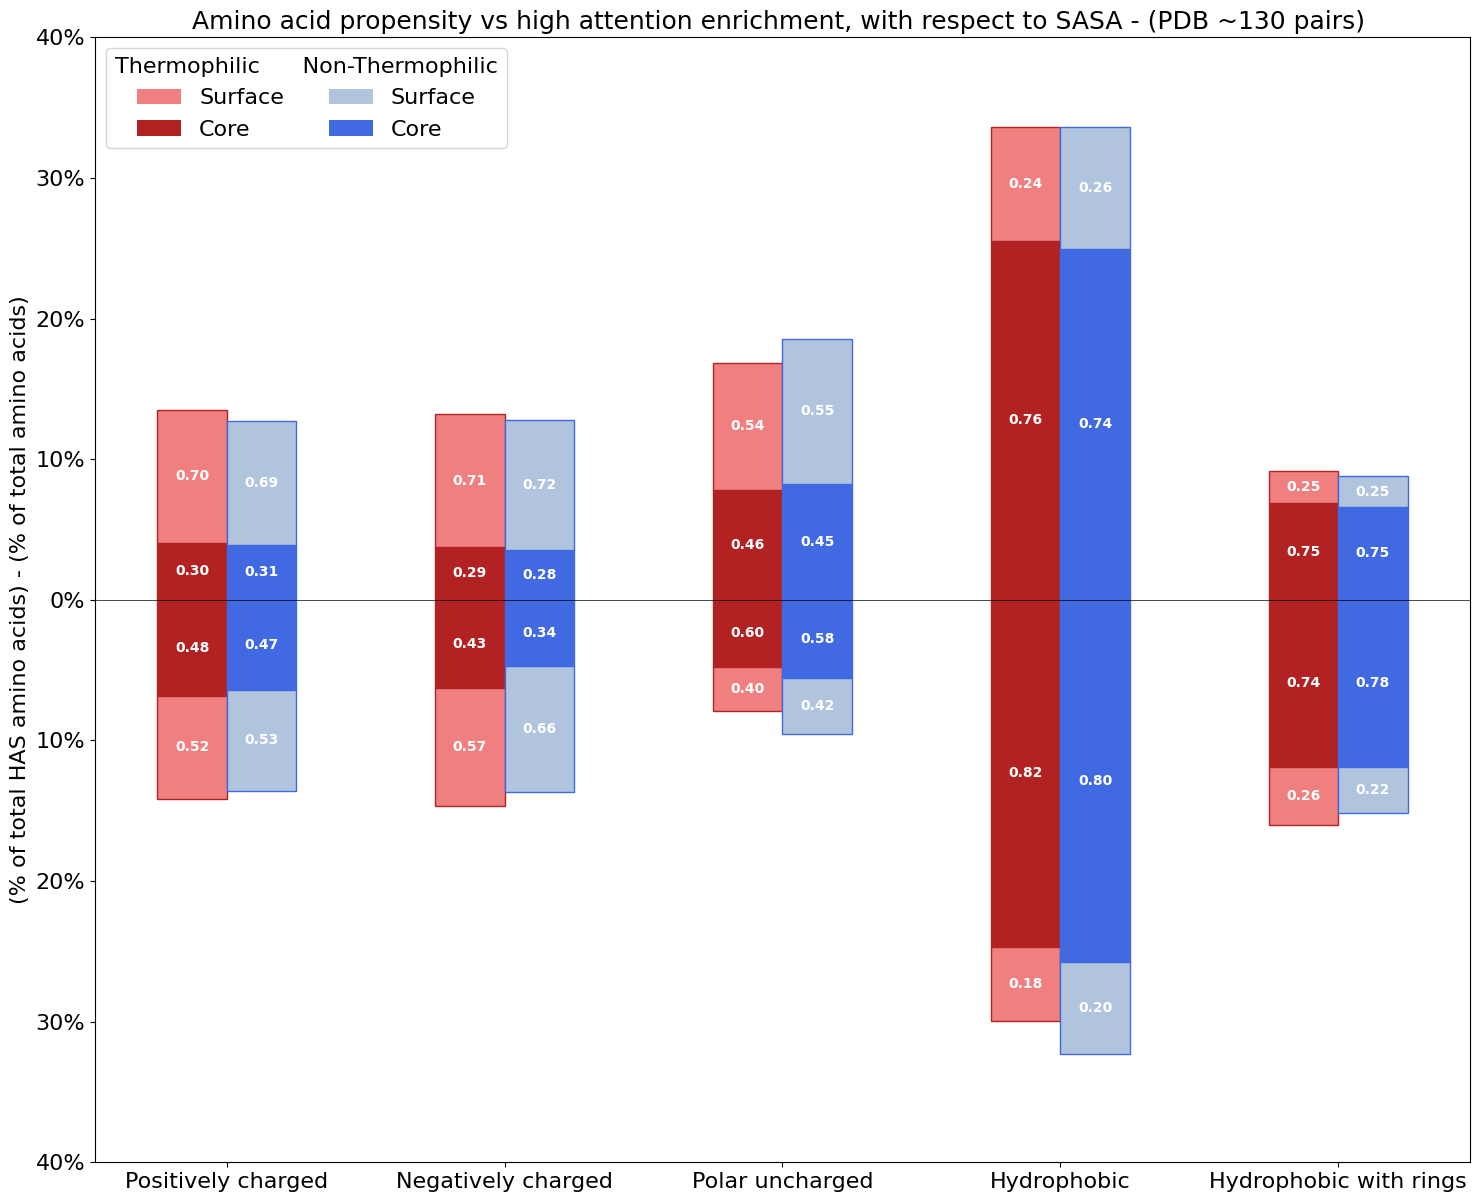

In [ ]:
## BASELINE VS HAS -- ALTERNATIVE COLOR
fig, ax = plt.subplots(figsize=(15, 15))

#baseline
thermo_baseline_aa_types_avgDict_exposition_plot_df.plot(kind='bar',  stacked=True,width=-0.25,align='edge',ax=ax,edgecolor='firebrick',color=['firebrick','lightcoral',],legend=False)
meso_baseline_aa_types_avgDict_exposition_plot_df.plot(kind='bar', stacked=True,width=0.25,align='edge',ax=ax,legend=False,edgecolor='royalblue',color=['royalblue','lightsteelblue'])
#HAS
(thermo_HAS_aa_types_avgDict_exposition_plot_df* -1).plot(kind='bar',  stacked=True,width=-0.25,align='edge',ax=ax,edgecolor='firebrick',color=['firebrick','lightcoral',],legend=False)
(meso_HAS_aa_types_avgDict_exposition_plot_df* -1).plot(kind='bar', stacked=True,width=0.25,align='edge',ax=ax,legend=False,edgecolor='royalblue',color=['royalblue','lightsteelblue',],)


plt.title('Amino acid propensity vs high attention enrichment, with respect to SASA - (PDB ~130 pairs) ',fontsize=18)
ax.autoscale(tight=False)
ax.axhline(0, color='black', linewidth=0.5) #adding x ax

# Formatting x labels
plt.xticks(rotation=0,fontsize=18)
plt.tight_layout()
ax.use_sticky_edges = False


## add annotations
df_row=0
#up plot
for c in ax.containers[0:2]:
  #[word for sentence in text for word in sentence]
  labels = ["{:.2f}".format(list(thermo_baseline_aa_types_avgDict_exposition_df.iloc[df_row])[v]) if list(thermo_baseline_aa_types_avgDict_exposition_df .iloc[df_row])[v] > 0.09 else '' for v in range(0,len(c)) ]
  #print(labels)
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=10,label_type='center', color= 'white',weight='bold')

df_row=0
for c in ax.containers[2:4]:
  labels = ["{:.2f}".format(list(meso_baseline_aa_types_avgDict_exposition_df.iloc[df_row])[v]) if list(meso_baseline_aa_types_avgDict_exposition_df .iloc[df_row])[v] > 0.09 else '' for v in range(0,len(c)) ]
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=10,label_type='center',color= 'white',weight='bold')

ticks =  ax.get_yticks()
ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=18)
plt.ylim([-0.40, 0.40])

plt.subplots_adjust(top=0.85,bottom=0.10)

## add annotations
df_row=0
#down plot
for c in ax.containers[4:6]:
  #[word for sentence in text for word in sentence]
  labels = ["{:.2f}".format(list(thermo_HAS_aa_types_avgDict_exposition_df.iloc[df_row])[v]) if list(thermo_HAS_aa_types_avgDict_exposition_df .iloc[df_row])[v] > 0.09 else '' for v in range(0,len(c)) ]
  #print(labels)
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=10,label_type='center',color= 'white',weight='bold')

df_row=0
for c in ax.containers[6:8]:
  labels = ["{:.2f}".format(list(meso_HAS_aa_types_avgDict_exposition_df.iloc[df_row])[v]) if list(meso_HAS_aa_types_avgDict_exposition_df .iloc[df_row])[v] > 0.09 else '' for v in range(0,len(c)) ]
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=10,label_type='center',color= 'white',weight='bold')

ticks =  ax.get_yticks()
ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=16)

#ax.set_xticklabels(['Hydrophobic amino acids','Polar amino acids','Charged amino acids'])
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Patch(facecolor='lightcoral',label='Surface'),
                   Patch(facecolor='firebrick',label='Core'),
                   Patch(facecolor='lightsteelblue',label='Surface'),
                   Patch(facecolor='royalblue',label='Core'),
                  ]

ax.legend(handles=legend_elements, loc='best',fontsize=16,ncol=2, title='Thermophilic      Non-Thermophilic',title_fontsize=16)
#labels = ('Positively charged', 'Negatively charged', 'Polar uncharged', 'Hydrophobic', 'Hydrophobic with rings','Glycine','Proline','Cysteine')
labels = ('Positively charged', 'Negatively charged', 'Polar uncharged', 'Hydrophobic', 'Hydrophobic with rings')
x_pos = np.arange(len(labels))
ax.set_xticklabels(labels)
plt.xticks(rotation=0,fontsize=16)
plt.yticks(rotation=0,fontsize=16)

plt.ylabel("(% of total HAS amino acids) - (% of total amino acids)",fontsize=16)
plt.savefig('propensity_vs_HAS_SASA_aatypes.png',dpi=300, bbox_inches = "tight")
plt.savefig('propensity_vs_HAS_SASA_aatypes.svg',format='svg', dpi=300, bbox_inches = "tight")

In [ ]:
from pydrive.auth import GoogleAuth
from google.colab import auth

# Authenticate and create the PyDrive client.
auth.authenticate_user()
'''
# to edit
!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' propensity_vs_HAS_SASA_aatypes.png
!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' propensity_vs_HAS_SASA_aatypes.svg'''

# APPENDIX : ATT_SCORE VS SASA FOR ALL THE THERMO AND ALL THE MESO CONCATENATED

In [ ]:
def biopython_sasa_VS_attention(data,sasa_on_pdb=False,att_on_pdb=False):
  '''How to read biopython structure where a is the chain
  for resi_ind, resi in enumerate(struct[0]['A'].get_residues()):

    res_id = resi.get_full_id()
    print(res_id)
    print(res_id[3])
    resi_name=resi.get_resname()
    print(resi_name)'''
  #%shell
  #!gunzip *.gz

  from Bio.PDB import MMCIFParser,PDBParser
  from Bio.PDB.Residue import Residue
  from Bio.PDB.Atom import Atom
  from Bio.PDB.Chain import Chain
  from Bio.PDB.Structure import Structure
  from Bio.PDB.Model import Model
  from Bio.PDB.PDBList import PDBList
  from Bio.PDB.SASA import ShrakeRupley
  from Bio.PDB.DSSP import DSSP
  import Bio.PDB.PDBExceptions
  import prody
  from collections import OrderedDictmeso_baseline_aa_types_avgDict_exposition_plot_df

  n_pdbs_processed=0
  all_df_score=[]

  for ind,prot in tqdm(data.iterrows()):

    !rm -r *.pdb
    #!rm -r *.gz

    id = prot.PDB_ID
    seq_mask =  (np.around(np.fromstring(prot.SEQ_MASK[1:-1], sep=' ')).astype(int)).tolist()
    seq_complete = prot.COMPLETE_SEQ
    seq_complete_aa=list(seq_complete) #reading aa per aa

    try:
      # 1. reading pdb
      pdb_id,chain=id.rsplit('_')
      pdb = prody.parsePDB(pdb_id,chain=chain)
      #prot = pdb.select('protein')
      pdb = pdb.select(f"protein and resid 1 to {pdb.select('pdbter').getResnums()[0]}")


      print('')
      print(f'Reading {pdb_id} with chain {chain}')
      print('')

      prody_seq=pdb.ca.getSequence()

      ####### SASA SCORE ##########

      try:
        mse = pdb.select('resname MSE')
        mse.setResnames(["MET"]*len(mse))
      except AttributeError:
        pass

      prody.writePDB(pdb_id+'_edit.pdb', pdb)
      parser = PDBParser()
      structure = parser.get_structure('pdb', pdb_id+'_edit.pdb')

      try:
        model = structure[0]
        dssp = DSSP(model, pdb_id+'_edit.pdb', dssp="dssp") #dssp='mkdssp'
        dssp_out = list(dssp)
        chain_dss= [lis for lis in dssp_out if lis]
        res_name = [lis[1] for lis in dssp_out]
        sasa_score = [lis[3] for lis in dssp_out]

        prody_seq=pdb.ca.getSequence()
        #print(prody_seq)

        #extract all the res id in the pdb
        res_id=pdb.ca.getResnums()

        #check
        if len(list(prody_seq)) != len(sasa_score):
          print('--Error: length prody sequence and length sasa score are different')
          continue
        if len(seq_complete_aa) != len(seq_mask):
          print('--Error: length complete sequence and length seq masks are different')
          break
        if len(list(prody_seq)) != len(list(seq_mask[i] for i in seq_mask if i == 1 )):
          print('--Error: length prody sequence and length of mask == 1 are different')
          break
        if len(list(res_id)) != len(list(seq_mask[i] for i in seq_mask if i == 1 )):
          print('--Error: length res ids and length of mask == 1 are different')
          break

        ### RUN THE MODEL ON SEQ_COMPLETE AND EXTRACT THE SASA SCORE ONLY FOR THE PARTIAL SEQUENCE FOR WHICH WE HAVE THE STRUCTURE (mask ==1)

        # computing attention respect to cls token
        df_all_vs_all,att_to_cls,df_att_to_cls_exp = attention_score_to_cls_token_and_to_all(seq_complete.replace('',' '),model_bert)
        att_to_cls = att_to_cls.drop(labels = ['[CLS]','[SEP]'])

        # ATTENTION SCORE SOFTMAX SCALING + MAX NORMALIZATION
        from scipy.special import softmax
        att_score_softmax = softmax(att_to_cls)
        att_score_softmax_maxnorm = att_score_softmax / max(att_score_softmax)

        # creating all info df
        df = pd.DataFrame({'att_score':att_score_softmax_maxnorm,'seq_mask':seq_mask})

        print(df)
        # adding the sasa score only at aa with mask 1 (available in the pdb structure)
        df['sasa_score']=sasa_mask_selection(df['seq_mask'],sasa_score)
        #adding a res id column only at aa with mask 1 (available in the pdb structure)
        df['res_id']=sasa_mask_selection(df['seq_mask'],res_id)


        # high attention/outlier detection using IQR method
        HAS_df=find_high_outliers_IQR(df) # only high attention as outlier
        HAS_indexes=list(HAS_df.index)
        print(HAS_df)
        for i in HAS_indexes:
          #print(i)  # adding a col where True means that the aa is an high attention one
          df.loc[i, 'HAS'] = "True"

        df['HAS'].fillna('False', inplace=True)

        #print(df[df['HAS']=='False'])
        df = df.set_index([seq_complete_aa]) #res_name is for the prody seq
        # sub df containing only the masked == 1 aminoacid to perform the b-factor analysis (1:1)
        df_score=df[df['seq_mask']==1]
        print('ciao')
        print(df_score)
        all_df_score.append(df_score)

        # using the b-field as coloring method to check the threshold of sasa score (buried-not buried)
        if sasa_on_pdb==True:
          sasa_buried_not_buried=sasa_buried_not_buried_map(sasa_score)
          if len(pdb.ca.getBetas()) != len(sasa_buried_not_buried):
            print('--ERROR length betas is different from the length of sasa score')
            break
          pdb.setBetas(0)
          pdb.ca.setBetas(sasa_buried_not_buried)
          prody.writePDB((pdb_id+'_'+chain+'_sasa_as_betas.pdb'),pdb.select('ca'))

        # using the b-field as coloring method to plot the attention score only in the aa present in the pdb while the score is obtained on the complete sequence
        if att_on_pdb==True:
          att_for_masked_aa = df[df['seq_mask'] == 1]['att_score'] * 100000
          if len(pdb.ca.getBetas()) != len(att_for_masked_aa):
            print('--ERROR length betas is different from the length of attention score')
            break
          pdb.setBetas(0)
          pdb.ca.setBetas(att_for_masked_aa)
          prody.writePDB((pdb_id+'_'+chain+'_att_as_betas.pdb'),pdb.select('ca'))
          if len(att_for_masked_aa) != len(prody_seq):
            print('--ERROR inconsistency in the attention score length for masked aa and len of masked aa sequence (prody_seq')
            break


        n_pdbs_processed+=1

      except (Bio.PDB.PDBExceptions.PDBException,Exception):
        pass
    except KeyError:
      pass
    except ValueError:
      pass

  return all_df_score,n_pdbs_processed

In [ ]:
#data_sample=pd.concat([pdb_meso.sample(10,random_state=42),pdb_thermo.sample(10,random_state=42)])
data_sample=pd.concat([pdb_meso,pdb_thermo])
data_sample

In [ ]:
few_df_score,n_pdbs_processed = biopython_sasa_VS_attention(data_sample)

0it [00:00, ?it/s]@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2dke downloaded (2dke.pdb.gz)
DEBUG:.prody:2dke downloaded (2dke.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1970 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1970 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1924
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1925
  warnings.warn(



Reading 2DKE with chain A



1it [00:04,  4.89s/it]

     att_score  seq_mask
0     0.993235         1
1     0.992768         1
2     0.992752         1
3     0.994841         1
4     0.995067         1
..         ...       ...
236   0.991442         1
237   0.992170         1
238   0.992651         1
239   0.994171         1
240   0.993241         1

[241 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
55    0.998323         1    0.023669      60
97    1.000000         1    0.000000     102
99    0.998046         1    0.007407     104
103   0.999903         1    0.018868     108
156   0.997711         1    0.270270     161
171   0.998415         1    0.000000     176
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
D    0.993235         1    0.938650       5  False
L    0.992768         1    0.414634       6  False
S    0.992752         1    0.476923       7  False
L    0.994841         1    0.085366       8  False
T    0.995067         1    0.781690       9  False
..        ...       ...         ...     ...    ...

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2hah downloaded (2hah.pdb.gz)
DEBUG:.prody:2hah downloaded (2hah.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1045 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:1045 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 894
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 895
  warnings.warn(



Reading 2HAH with chain A



2it [00:08,  3.88s/it]

     att_score  seq_mask
0     0.978469         1
1     0.978098         1
2     0.977746         1
3     0.977723         1
4     0.977375         1
..         ...       ...
107   0.979976         1
108   0.979553         1
109   0.978846         1
110   0.978143         1
111   0.980291         1

[112 rows x 2 columns]
    att_score  seq_mask  sasa_score  res_id
9    0.988061         1    0.169118      14
53   0.988658         1    0.678571      58
56   0.987426         1    0.404762      61
86   0.987608         1    0.000000      91
96   1.000000         1    0.118343     101
97   0.995833         1    0.000000     102
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
G    0.978469         1    1.000000       5  False
T    0.978098         1    0.478873       6  False
T    0.977746         1    0.866197       7  False
T    0.977723         1    0.352113       8  False
T    0.977375         1    0.542254       9  False
..        ...       ...         ...     ...    ...
I    0

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1gye downloaded (1gye.pdb.gz)
DEBUG:.prody:1gye downloaded (1gye.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2615 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:2615 atoms and 1 coordinate set(s) were parsed in 0.07s.



Reading 1GYE with chain B



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2539
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2540
  warnings.warn(
3it [00:14,  5.25s/it]

     att_score  seq_mask
0     0.990066         1
1     0.990209         1
2     0.990589         1
3     0.990852         1
4     0.991251         1
..         ...       ...
310   0.990073         1
311   0.989978         1
312   0.989144         1
313   0.989852         1
314   0.990222         1

[315 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
43    0.994072         1    0.131980      75
49    0.994599         1    0.136564      81
57    0.994738         1    0.060914      89
85    0.993740         1    0.006369     117
114   0.993885         1    0.206186     146
115   0.994864         1    0.007692     147
120   0.993785         1    0.098160     152
122   0.997732         1    0.140969     154
147   1.000000         1    0.000000     179
208   0.994587         1    0.237805     240
211   0.994213         1    0.524194     243
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
K    0.990066         1    1.000000      32  False
Q    0.990209         1    0.

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1lv7 downloaded (1lv7.pdb.gz)
DEBUG:.prody:1lv7 downloaded (1lv7.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2291 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2291 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3802
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3803
  warnings.warn(



Reading 1LV7 with chain A



4it [00:19,  5.13s/it]

     att_score  seq_mask
0     0.984312         1
1     0.984230         1
2     0.985089         1
3     0.986612         1
4     0.986114         1
..         ...       ...
251   0.990847         1
252   0.987911         1
253   0.988238         1
254   0.985339         1
255   0.988567         1

[256 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
10    0.993561         1   0.203046    154
27    0.990437         1   0.042254    171
41    0.991148         0        NaN    NaN
43    0.993364         1   0.313609    187
47    0.992746         1        0.0    191
50    0.993077         1    0.15493    194
121   0.993479         1   0.943396    265
152   0.993792         1        0.0    296
167   0.990410         1   0.262195    311
188   0.996949         1   0.333333    332
190   0.990527         1        0.0    334
212   0.991219         1        0.0    356
213   0.991383         1   0.654412    357
218   0.992100         1   0.490566    362
230   1.000000         1   0.23

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1hh5 downloaded (1hh5.pdb.gz)
DEBUG:.prody:1hh5 downloaded (1hh5.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 750 atoms and 1 coordinate set(s) were parsed in 0.01s.
DEBUG:.prody:750 atoms and 1 coordinate set(s) were parsed in 0.01s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 507
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 508
  warnings.warn(



Reading 1HH5 with chain A



5it [00:22,  4.18s/it]

    att_score  seq_mask
0    0.976552         1
1    0.978620         1
2    0.972956         1
3    0.980528         1
4    0.974891         1
..        ...       ...
63   0.973492         1
64   0.979296         1
65   0.977852         1
66   0.974083         1
67   0.977897         1

[68 rows x 2 columns]
    att_score  seq_mask  sasa_score  res_id
14   1.000000         1    0.269036      15
51   0.987525         1    0.429630      52
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
A    0.976552         1    1.000000       1  False
D    0.978620         1    0.509202       2  False
V    0.972956         1    0.549296       3  False
V    0.980528         1    0.323944       4  False
T    0.974891         1    0.556338       5  False
..        ...       ...         ...     ...    ...
G    0.973492         1    0.500000      64  False
C    0.979296         1    0.274074      65  False
H    0.977852         1    0.195652      66  False
I    0.974083         1    0.514793      6

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 6kwc downloaded (6kwc.pdb.gz)
DEBUG:.prody:6kwc downloaded (6kwc.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3116 atoms and 1 coordinate set(s) were parsed in 0.10s.
DEBUG:.prody:3116 atoms and 1 coordinate set(s) were parsed in 0.10s.



Reading 6KWC with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5662
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5663
  warnings.warn(
6it [00:27,  4.44s/it]

     att_score  seq_mask
0     0.987135         1
1     0.986582         1
2     0.989123         1
3     0.987294         1
4     0.988739         1
..         ...       ...
185   0.986561         1
186   0.988744         1
187   0.986871         1
188   0.991259         1
189   0.988397         1

[190 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
89    0.995738         1    0.000000      90
90    1.000000         1    0.010309      91
177   0.995258         1    0.011905     178
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
S    0.987135         1    1.000000       1  False
T    0.986582         1    0.535211       2  False
I    0.989123         1    0.254438       3  False
Q    0.987294         1    0.803030       4  False
P    0.988739         1    0.404412       5  False
..        ...       ...         ...     ...    ...
S    0.986561         1    0.369231     186  False
I    0.988744         1    0.000000     187  False
T    0.986871         1    0.408

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1cdg downloaded (1cdg.pdb.gz)
DEBUG:.prody:1cdg downloaded (1cdg.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 5737 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:5737 atoms and 1 coordinate set(s) were parsed in 0.07s.



Reading 1CDG with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5266
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5267
  warnings.warn(
7it [00:41,  7.55s/it]

     att_score  seq_mask
0     0.995545         1
1     0.993951         1
2     0.994251         1
3     0.993750         1
4     0.993869         1
..         ...       ...
681   0.993766         1
682   0.993505         1
683   0.994250         1
684   0.993532         1
685   0.993904         1

[686 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
11    0.996435         1    0.000000      12
12    0.996971         1    0.000000      13
25    0.997305         1    0.192308      26
81    0.999170         1    0.012739      82
83    0.996290         1    0.540541      84
84    0.996503         1    0.246154      85
125   0.996900         1    0.288043     126
234   0.996527         1    0.058824     235
241   0.998916         1    0.000000     242
267   0.996359         1    0.386598     268
292   0.996537         1    0.010152     293
309   0.996279         1    0.000000     310
330   1.000000         1    0.004032     331
331   0.997369         1    0.020305     332
3

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3f9q downloaded (3f9q.pdb.gz)
DEBUG:.prody:3f9q downloaded (3f9q.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2780 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2780 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2570
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2571
  warnings.warn(



Reading 3F9Q with chain A



8it [00:47,  7.05s/it]

     att_score  seq_mask
0     0.989030         1
1     0.988825         1
2     0.988321         1
3     0.989401         1
4     0.988621         1
..         ...       ...
324   0.989025         1
325   0.988282         1
326   0.988295         1
327   0.988593         1
328   0.989786         1

[329 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
5     0.993951         1   0.059172      6
9     0.993664         1   0.251534     10
16    0.995828         1   0.031532     17
40    0.993204         1        0.0     41
42    0.994468         1        0.0     43
59    0.992794         1   0.153846     60
82    1.000000         1   0.323077     83
137   0.993010         1   0.051471    138
151   0.995578         1   0.018868    152
165   0.994285         1        0.0    166
183   0.993069         1   0.373874    184
220   0.992644         1   0.028169    221
ciao
    att_score  seq_mask sasa_score res_id    HAS
S    0.989030         1        1.0      1  False
S    0.988825 

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3wmy downloaded (3wmy.pdb.gz)
DEBUG:.prody:3wmy downloaded (3wmy.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2700 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2700 atoms and 1 coordinate set(s) were parsed in 0.04s.



Reading 3WMY with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2312
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2313
  warnings.warn(
9it [00:54,  7.26s/it]

     att_score  seq_mask
0     0.993254         1
1     0.992470         1
2     0.998184         1
3     0.993644         1
4     0.993951         1
..         ...       ...
297   0.993887         1
298   0.995209         1
299   0.994045         1
300   0.992727         1
301   0.994023         1

[302 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
2     0.998184         1    0.274074     176
28    0.997083         1    0.061350     202
29    0.997077         1    0.005076     203
40    0.997332         1    0.000000     214
79    0.999511         1    0.029412     253
83    0.999112         1    0.247748     257
91    0.999101         1    0.000000     265
94    0.999512         1    0.013514     268
101   1.000000         1    0.000000     275
122   0.997312         1    0.000000     296
126   0.997880         1    0.142012     300
203   0.997365         1    0.000000     377
204   0.997810         1    0.000000     378
205   0.999398         1    0.000000     379
2

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1jii downloaded (1jii.pdb.gz)
DEBUG:.prody:1jii downloaded (1jii.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2585 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2585 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2558
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2559
  warnings.warn(



Reading 1JII with chain A



10it [01:01,  7.00s/it]

     att_score  seq_mask
0     0.999815         1
1     0.995628         1
2     0.992281         1
3     0.993640         1
4     0.995101         1
..         ...       ...
361   0.993547         0
362   0.992809         1
363   0.992487         0
364   0.995197         0
365   0.992841         1

[366 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
0     0.999815         1   0.992958      2
94    0.996779         1        0.0     96
98    0.997061         1   0.142012    100
130   0.996695         1   0.538462    132
136   1.000000         1   0.721774    138
140   0.997406         1    0.82439    142
189   0.997655         1   0.007042    191
247   0.996649         1   0.198529    249
ciao
    att_score  seq_mask sasa_score res_id    HAS
T    0.999815         1   0.992958      2   True
N    0.995628         1   0.420382      3  False
V    0.992281         1   0.626761      4  False
L    0.993640         1    0.04878      5  False
I    0.995101         1    0.04142     

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 6w80 downloaded (6w80.pdb.gz)
DEBUG:.prody:6w80 downloaded (6w80.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3709 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:3709 atoms and 1 coordinate set(s) were parsed in 0.06s.



Reading 6W80 with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 6260
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 6261
  warnings.warn(
11it [01:10,  7.60s/it]

     att_score  seq_mask
0     0.997710         1
1     0.990319         1
2     0.990684         1
3     0.991028         1
4     0.992745         1
..         ...       ...
423   0.991383         1
424   0.991445         1
425   0.991497         1
426   0.990953         1
427   0.990412         1

[428 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
0     0.997710         1   0.489362      1
5     0.996692         1   0.007692      6
9     0.994948         1   0.050761     10
135   0.994240         1   0.294355    136
137   0.994038         1        0.0    138
140   0.996788         1   0.510309    141
152   0.994763         1   0.035211    153
159   0.994134         1    0.22561    160
175   1.000000         1   0.469072    176
187   0.994116         1   0.226415    188
219   0.995227         1   0.333333    220
253   0.994555         1   0.584906    254
292   0.994186         1   0.801471    293
310   0.994514         1   0.219512    311
319   0.995359         1   0.98

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2o5v downloaded (2o5v.pdb.gz)
DEBUG:.prody:2o5v downloaded (2o5v.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3242 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:3242 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2739
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2740
  warnings.warn(



Reading 2O5V with chain A



12it [01:16,  7.18s/it]

     att_score  seq_mask
0     0.989354         1
1     0.988925         1
2     0.989974         1
3     0.991300         1
4     0.990585         1
..         ...       ...
353   0.989291         1
354   0.988866         1
355   0.988908         1
356   0.988826         1
357   0.989567         1

[358 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
22    0.995434         1    0.005076      24
30    0.993320         1    0.288288      32
45    1.000000         1    0.027027      47
50    0.996065         1    0.095238      52
68    0.994373         1    0.018868      70
118   0.994395         1    0.092025     120
134   0.993464         1    0.116564     136
225   0.993802         1    0.004505     227
259   0.993892         1    0.352941     261
291   0.993271         1    0.251534     293
292   0.993904         1    0.014706     294
308   0.993473         1    0.237903     310
310   0.997726         1    0.117117     312
ciao
    att_score  seq_mask  sasa_score  res_

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 6blb downloaded (6blb.pdb.gz)
DEBUG:.prody:6blb downloaded (6blb.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2656 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2656 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4862
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4863
  warnings.warn(



Reading 6BLB with chain A



13it [01:23,  7.25s/it]

     att_score  seq_mask
0     0.986758         1
1     0.989873         1
2     0.990177         1
3     0.989489         1
4     0.986340         1
..         ...       ...
324   0.984587         0
325   0.984649         0
326   0.984515         0
327   0.985058         0
328   0.984664         1

[329 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
1     0.989873         1   0.183432     24
2     0.990177         1   0.387097     25
5     0.991939         1   0.541463     28
6     0.991081         1   0.006098     29
8     0.990689         1   0.368098     31
10    1.000000         1   0.260355     33
17    0.991692         1   0.752577     40
32    0.990185         1   0.169811     55
38    0.994787         1        0.0     61
42    0.990207         1   0.426471     65
44    0.989831         1        0.0     67
51    0.993473         1   0.229299     74
52    0.996427         1   0.005917     75
63    0.990459         1   0.553846     86
71    0.989775         1   0.74

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1q1y downloaded (1q1y.pdb.gz)
DEBUG:.prody:1q1y downloaded (1q1y.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1749 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1749 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1466
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1467
  warnings.warn(



Reading 1Q1Y with chain A



14it [01:27,  6.21s/it]

     att_score  seq_mask
0     0.996511         1
1     0.988682         1
2     0.989304         1
3     0.989970         1
4     0.990891         1
..         ...       ...
186   0.988546         0
187   0.988242         0
188   0.988412         0
189   0.988401         0
190   0.988324         1

[191 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
0     0.996511         1   0.744681      1
8     0.995525         1   0.495968      9
10    0.995418         1   0.785714     11
55    0.996519         1    0.33871     56
59    0.997782         1   0.083333     60
61    0.998419         1        0.0     62
63    0.995915         1   0.014706     64
86    0.995574         1   0.460123     87
110   0.995906         0        NaN    NaN
152   0.997665         1   0.055556    153
156   1.000000         1   0.171779    157
ciao
    att_score  seq_mask sasa_score res_id    HAS
M    0.996511         1   0.744681      1   True
L    0.988682         1   0.182927      2  False
T    0.9

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5aza downloaded (5aza.pdb.gz)
DEBUG:.prody:5aza downloaded (5aza.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 6678 atoms and 1 coordinate set(s) were parsed in 0.09s.
DEBUG:.prody:6678 atoms and 1 coordinate set(s) were parsed in 0.09s.



Reading 5AZA with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 6553
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 6554
  warnings.warn(
15it [01:46,  9.90s/it]

     att_score  seq_mask
0     0.995781         1
1     0.995342         1
2     0.995580         1
3     0.995545         1
4     0.997248         1
..         ...       ...
856   0.995164         1
857   0.995552         1
858   0.995313         1
859   0.995577         1
860   0.995360         1

[861 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
10    0.998188         1   0.023669     11
15    0.997835         1   0.011905     16
22    0.998110         1   0.049296     23
26    0.998193         1        0.0     27
36    0.997867         1    0.21831     37
38    0.999203         1   0.445652     39
46    0.998769         1        0.0     47
47    0.998079         1   0.301471     48
55    0.998807         1   0.154762     56
65    0.999749         1      0.125     66
80    0.998102         1   0.051471     81
90    0.998171         1        0.5     91
93    0.997853         1   0.039648     94
94    0.998379         1   0.570552     95
106   0.997840         1       

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2z1u downloaded (2z1u.pdb.gz)
DEBUG:.prody:2z1u downloaded (2z1u.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2690 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2690 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2477
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2478
  warnings.warn(



Reading 2Z1U with chain A



16it [01:53,  9.22s/it]

     att_score  seq_mask
0     0.992943         1
1     0.991998         1
2     0.993939         1
3     0.993557         1
4     0.992041         1
..         ...       ...
332   0.992244         1
333   0.992288         1
334   0.992255         1
335   0.992884         1
336   0.994217         1

[337 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
12    0.996617         1   0.076923     17
20    1.000000         1   0.055838     25
22    0.997929         1   0.504032     27
83    0.997000         1   0.290323     88
128   0.997687         1   0.794355    133
141   0.997442         1   0.201183    146
155   0.997536         1   0.075472    160
181   0.999561         1   0.390244    186
188   0.996485         1   0.355556    193
244   0.996570         1   0.217742    249
246   0.999834         1   0.153846    251
268   0.997660         1        0.0    273
ciao
    att_score  seq_mask sasa_score res_id    HAS
T    0.992943         1   0.753521      5  False
L    0.991998 

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4xeu downloaded (4xeu.pdb.gz)
DEBUG:.prody:4xeu downloaded (4xeu.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 5176 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:5176 atoms and 1 coordinate set(s) were parsed in 0.08s.



Reading 4XEU with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 9532
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 9533
  warnings.warn(
17it [02:07, 10.47s/it]

     att_score  seq_mask
0     1.000000         1
1     0.995943         1
2     0.995906         1
3     0.997727         1
4     0.996823         1
..         ...       ...
658   0.996351         1
659   0.995950         1
660   0.995966         1
661   0.995859         1
662   0.996036         1

[663 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
0     1.000000         1   0.994681      1
3     0.997727         1   0.342742      4
29    0.997894         1        0.0     30
33    0.998116         1        0.0     34
80    0.997721         1   0.656442     81
81    0.998483         1   0.018293     82
131   0.997791         1        0.0    132
188   0.997747         0        NaN    NaN
191   0.999301         0        NaN    NaN
211   0.998125         1   0.098592    212
212   0.997784         1   0.177515    213
213   0.998632         1   0.455645    214
222   0.997776         1    0.42268    223
236   0.997818         1        0.0    237
240   0.998485         1   0.02

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1up0 downloaded (1up0.pdb.gz)
DEBUG:.prody:1up0 downloaded (1up0.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2478 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2478 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2137
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2138
  warnings.warn(



Reading 1UP0 with chain A



18it [02:13,  9.17s/it]

     att_score  seq_mask
0     0.993055         1
1     0.992597         1
2     0.993612         1
3     0.991919         1
4     0.994588         1
..         ...       ...
288   0.991365         1
289   0.992473         1
290   0.991951         1
291   0.991146         1
292   0.991328         1

[293 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
67    0.996703         1   0.056604    155
76    0.996601         1   0.017751    164
98    0.996098         1        0.0    186
105   0.997538         1   0.107143    193
116   0.996357         1   0.005155    204
133   0.996845         1   0.345361    221
134   0.995953         1   0.020161    222
137   0.996119         1   0.006098    225
144   0.999138         1   0.028169    232
170   1.000000         1   0.575472    258
199   0.998440         1   0.099099    287
203   0.999807         1        0.0    291
261   0.996166         1        0.0    349
ciao
    att_score  seq_mask sasa_score res_id    HAS
A    0.993055       

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 6k21 downloaded (6k21.pdb.gz)
DEBUG:.prody:6k21 downloaded (6k21.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1550 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:1550 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1344
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1345
  warnings.warn(



Reading 6K21 with chain A



19it [02:18,  8.08s/it]

     att_score  seq_mask
0     0.988347         1
1     0.983712         1
2     0.982295         1
3     0.983190         1
4     0.981952         1
..         ...       ...
168   0.983122         1
169   0.981653         1
170   0.981486         1
171   0.983466         1
172   0.981211         1

[173 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
6     0.989588         1    0.103774       7
20    1.000000         1    0.017751      21
22    0.991353         1    0.075472      23
85    0.990077         1    0.209677      86
95    0.989359         1    0.402062      96
102   0.989334         1    0.188679     103
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
S    0.988347         1    0.653846       1  False
Y    0.983712         1    0.216216       2  False
N    0.982295         1    0.592357       3  False
N    0.983190         1    0.821656       4  False
I    0.981952         1    0.207101       5  False
..        ...       ...         ...     ...    ...

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2nuh downloaded (2nuh.pdb.gz)
DEBUG:.prody:2nuh downloaded (2nuh.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 925 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:925 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 814
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 815
  warnings.warn(



Reading 2NUH with chain A



20it [02:23,  6.91s/it]

     att_score  seq_mask
0     0.984228         1
1     0.983520         1
2     0.981055         1
3     0.984551         1
4     0.986550         1
..         ...       ...
99    0.981527         1
100   0.981467         1
101   0.983925         1
102   0.980947         1
103   0.984161         1

[104 rows x 2 columns]
    att_score  seq_mask  sasa_score  res_id
42   1.000000         1    0.717742      45
56   0.993555         1    0.219512      59
58   0.997126         1    0.117073      61
70   0.996097         1    0.318548      73
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
S    0.984228         1    0.361538       3  False
D    0.983520         1    0.607362       4  False
V    0.981055         1    0.028169       5  False
Y    0.984551         1    0.238739       6  False
L    0.986550         1    0.280488       7  False
..        ...       ...         ...     ...    ...
N    0.981527         1    0.267516     102  False
T    0.981467         1    0.626761     103

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2ior downloaded (2ior.pdb.gz)
DEBUG:.prody:2ior downloaded (2ior.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1926 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:1926 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3254
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3255
  warnings.warn(



Reading 2IOR with chain A



21it [02:27,  6.28s/it]

     att_score  seq_mask
0     0.985207         1
1     0.985081         1
2     0.982413         1
3     0.981730         1
4     0.985266         1
..         ...       ...
210   0.983975         0
211   0.985467         0
212   0.983736         0
213   0.983871         0
214   0.983882         1

[215 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
16    0.989560         1    0.02439     17
20    1.000000         1   0.260355     21
29    0.993496         1   0.029586     30
35    0.995211         1   0.011834     36
56    0.988691         1   0.328829     57
62    0.989646         1   0.085366     63
90    0.989087         1   0.112426     91
120   0.990599         1   0.547619    121
126   0.990490         1   0.091371    127
147   0.989184         1   0.235294    148
ciao
    att_score  seq_mask sasa_score res_id    HAS
M    0.985207         1   0.638298      1  False
K    0.985081         1   0.790244      2  False
G    0.982413         1   0.583333      3  False
Q 

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2rdn downloaded (2rdn.pdb.gz)
DEBUG:.prody:2rdn downloaded (2rdn.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2761 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2761 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2203
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2204
  warnings.warn(



Reading 2RDN with chain A



22it [02:34,  6.27s/it]

     att_score  seq_mask
0     0.993544         1
1     0.991031         1
2     0.991566         1
3     0.991691         1
4     0.992087         1
..         ...       ...
270   0.991629         1
271   0.991145         1
272   0.990996         1
273   0.991079         1
274   0.991732         1

[275 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
22    0.997558         1    0.142132      24
23    0.997085         1    0.085586      25
27    0.998413         1    0.000000      29
32    0.999090         1    0.568548      34
35    0.996289         1    0.042683      37
50    0.997751         1    0.000000      52
58    0.997466         1    0.521472      60
93    0.996248         1    0.346154      95
115   0.999483         1    0.100806     117
116   0.996889         1    0.004505     118
137   1.000000         1    0.012270     139
151   0.997138         1    0.039648     153
153   0.999128         1    0.000000     155
163   0.997551         1    0.011905     165
1

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1fxd downloaded (1fxd.pdb.gz)
DEBUG:.prody:1fxd downloaded (1fxd.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 495 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:495 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 426
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 427
  warnings.warn(



Reading 1FXD with chain A



23it [02:37,  5.34s/it]

    att_score  seq_mask
0    0.977046         1
1    0.975438         1
2    0.982604         1
3    0.989092         1
4    0.977361         1
5    0.981858         1
6    0.979688         1
7    0.979503         1
8    0.972851         1
9    0.974837         1
10   0.976030         0
11   0.982293         1
12   0.981545         1
13   0.981980         1
14   0.973142         1
15   0.979288         1
16   0.980437         1
17   0.989011         1
18   0.987509         1
19   0.994493         1
20   0.979799         1
21   0.985125         1
22   0.986113         1
23   0.983091         1
24   0.979127         1
25   0.978518         1
26   0.977889         1
27   0.981830         1
28   0.982641         1
29   0.984293         1
30   0.999243         1
31   0.983554         1
32   0.995700         1
33   0.984741         1
34   0.984103         1
35   0.988688         1
36   0.977576         1
37   0.978773         1
38   0.981070         1
39   0.976005         1
40   0.981536   

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1e3x downloaded (1e3x.pdb.gz)
DEBUG:.prody:1e3x downloaded (1e3x.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 4587 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:4587 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3902
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3903
  warnings.warn(



Reading 1E3X with chain A



24it [02:46,  6.42s/it]

     att_score  seq_mask
0     0.998748         1
1     0.995401         1
2     0.997404         1
3     0.995688         1
4     0.995962         1
..         ...       ...
478   0.993995         1
479   0.994567         1
480   0.994232         1
481   0.993646         1
482   0.994986         1

[483 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     0.998748         1    1.000000       1
2     0.997404         1    0.297619       3
5     0.997202         1    0.000000       6
6     0.997361         1    0.000000       7
8     0.996942         1    0.005076       9
9     1.000000         1    0.025773      10
21    0.997282         1    0.245968      22
30    0.997012         1    0.176923      31
36    0.997243         1    0.000000      37
71    0.997456         1    0.225806      72
82    0.997250         1    0.582822      83
83    0.998095         1    0.000000      84
88    0.998156         1    0.331522      89
104   0.996873         1    0.037736     105
2

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4m80 downloaded (4m80.pdb.gz)
DEBUG:.prody:4m80 downloaded (4m80.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3517 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:3517 atoms and 1 coordinate set(s) were parsed in 0.05s.



Reading 4M80 with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3208
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3209
  warnings.warn(
25it [02:55,  7.10s/it]

     att_score  seq_mask
0     0.995439         1
1     0.992231         1
2     0.992053         1
3     0.992233         1
4     0.991502         1
..         ...       ...
388   0.990867         1
389   0.993570         1
390   0.990879         1
391   0.990850         1
392   0.990988         1

[393 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     0.995439         1    0.387665       8
20    0.995812         1    0.000000      28
62    0.997038         1    0.081522      70
64    0.995855         1    0.430769      72
71    0.996817         1    0.092025      79
84    0.997955         1    0.004032      92
86    0.995573         1    0.036765      94
104   0.995497         1    0.005051     112
107   0.995659         1    0.090090     115
114   0.996915         1    0.193833     122
137   0.997326         1    0.067485     145
202   0.998375         1    0.000000     210
219   1.000000         1    0.079755     227
292   0.996647         1    0.051852     300
c

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4mat downloaded (4mat.pdb.gz)
DEBUG:.prody:4mat downloaded (4mat.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2208 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2208 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2054
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2055
  warnings.warn(



Reading 4MAT with chain A



26it [03:00,  6.52s/it]

     att_score  seq_mask
0     0.995218         1
1     0.992702         1
2     0.992778         1
3     0.993825         1
4     0.993089         1
..         ...       ...
266   0.990777         1
267   0.990337         1
268   0.990353         1
269   0.990202         1
270   0.990806         1

[271 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
19    1.000000         1    0.000000      21
74    0.996574         1    0.126761      76
82    0.997684         1    0.496933      84
136   0.996646         1    0.504032     138
175   0.997019         1    0.116751     177
182   0.997105         1    0.146341     184
226   0.999122         1    0.314516     228
234   0.996964         1    0.005435     236
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
A    0.995218         1    1.000000       2  False
I    0.992702         1    0.236686       3  False
S    0.992778         1    0.392308       4  False
I    0.993825         1    0.538462       5  False
K    0.9930

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4dg5 downloaded (4dg5.pdb.gz)
DEBUG:.prody:4dg5 downloaded (4dg5.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3245 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:3245 atoms and 1 coordinate set(s) were parsed in 0.06s.



Reading 4DG5 with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5972
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5973
  warnings.warn(
27it [03:08,  7.08s/it]

     att_score  seq_mask
0     0.997813         1
1     0.993442         1
2     0.993727         1
3     0.993869         1
4     0.994330         1
..         ...       ...
390   0.995486         1
391   0.993993         1
392   0.993328         1
393   0.993923         1
394   0.994141         1

[395 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     0.997813         1    1.000000       2
62    0.997619         1    0.795122      64
120   0.999421         1    0.092025     122
166   0.999558         1    0.195122     168
167   0.998021         1    0.417526     169
181   0.997644         1    0.000000     183
211   0.998860         1    0.024390     213
220   1.000000         1    0.000000     222
246   0.997781         1    0.053254     248
316   0.997837         1    0.063694     318
379   0.998522         1    0.099099     381
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
A    0.997813         1    1.000000       2   True
K    0.993442         1    0.

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 6rbo downloaded (6rbo.pdb.gz)
DEBUG:.prody:6rbo downloaded (6rbo.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2165 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2165 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4152
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4153
  warnings.warn(



Reading 6RBO with chain A



28it [03:13,  6.46s/it]

     att_score  seq_mask
0     0.994402         1
1     0.991168         1
2     0.991547         1
3     0.991060         1
4     0.994933         1
..         ...       ...
259   0.992463         1
260   0.994657         1
261   0.995423         1
262   0.991530         1
263   0.991793         1

[264 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
23    0.996733         1   0.005076     24
54    0.999386         1   0.063063     55
77    0.998173         1   0.057269     78
85    1.000000         1        0.0     86
108   0.998177         1   0.283784    109
164   0.997559         1   0.414634    165
176   0.999873         1   0.371134    177
185   0.997066         1   0.284615    186
196   0.997391         1   0.553846    197
199   0.997141         1   0.549296    200
ciao
    att_score  seq_mask sasa_score res_id    HAS
M    0.994402         1   0.303191      1  False
K    0.991168         1   0.307317      2  False
Y    0.991547         1   0.040541      3  False
M 

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1qcz downloaded (1qcz.pdb.gz)
DEBUG:.prody:1qcz downloaded (1qcz.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1367 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1367 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1197
  warnings.warn(



Reading 1QCZ with chain A



29it [03:17,  5.78s/it]

     att_score  seq_mask
0     0.990109         1
1     0.991940         1
2     0.989633         1
3     0.994954         1
4     0.988166         1
..         ...       ...
158   0.989769         1
159   0.991072         1
160   0.988345         1
161   0.990488         0
162   0.989145         1

[163 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
5     0.998813         1        0.0     12
15    0.999734         1   0.161972     22
34    0.997280         1   0.429577     41
45    0.996963         1   0.406091     52
59    0.996581         1        0.0     66
60    0.998816         1        0.0     67
86    0.995641         1   0.098592     93
102   1.000000         1   0.757576    109
157   0.999062         1   0.527607    164
ciao
    att_score  seq_mask sasa_score res_id    HAS
P    0.990109         1   0.720588      7  False
A    0.991940         1   0.311321      8  False
R    0.989633         1        0.5      9  False
V    0.994954         1        0.0     10  Fa

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2yhs downloaded (2yhs.pdb.gz)
DEBUG:.prody:2yhs downloaded (2yhs.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2603 atoms and 1 coordinate set(s) were parsed in 0.09s.
DEBUG:.prody:2603 atoms and 1 coordinate set(s) were parsed in 0.09s.



Reading 2YHS with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4740
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4741
  warnings.warn(
30it [03:23,  5.84s/it]

     att_score  seq_mask
0     0.988642         1
1     0.987950         1
2     0.988310         1
3     0.987667         1
4     0.988580         1
..         ...       ...
303   0.988174         1
304   0.988516         1
305   0.990007         1
306   0.990286         1
307   0.990048         1

[308 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
25    0.992410         1    0.083333     213
30    0.993669         1    0.005076     218
68    0.992197         1    0.056604     256
105   0.993908         1    0.000000     293
116   0.995845         1    0.063380     304
123   0.994207         1    0.142857     311
129   0.993749         1    0.010152     317
130   0.992527         1    0.298969     318
140   0.998083         1    0.000000     328
144   0.992651         1    0.746193     332
146   0.992722         1    0.500000     334
158   0.992686         1    0.814516     346
165   0.993357         1    0.254717     353
204   1.000000         1    0.521739     392
2

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3i4q downloaded (3i4q.pdb.gz)
DEBUG:.prody:3i4q downloaded (3i4q.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1501 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1501 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1327
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1328
  warnings.warn(



Reading 3I4Q with chain A



31it [03:27,  5.14s/it]

     att_score  seq_mask
0     0.983775         1
1     0.979438         1
2     0.979573         1
3     0.978890         1
4     0.984795         1
..         ...       ...
168   0.979416         1
169   0.978633         1
170   0.980459         1
171   0.978669         1
172   0.978851         1

[173 rows x 2 columns]
    att_score  seq_mask sasa_score res_id
5    0.986574         1   0.113208      8
19   1.000000         1   0.017751     22
21   0.989355         1   0.066038     24
62   0.987318         1   0.674847     65
84   0.988226         1   0.185484     87
95   0.986486         1   0.122699     98
ciao
    att_score  seq_mask sasa_score res_id    HAS
Y    0.983775         1   0.292793      3  False
N    0.979438         1   0.713376      4  False
T    0.979573         1   0.852113      5  False
I    0.978890         1   0.171598      6  False
P    0.984795         1   0.492647      7  False
..        ...       ...        ...    ...    ...
A    0.979416         1   0.566038

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3vml downloaded (3vml.pdb.gz)
DEBUG:.prody:3vml downloaded (3vml.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3239 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:3239 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2755
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2756
  warnings.warn(



Reading 3VML with chain A



32it [03:35,  5.95s/it]

     att_score  seq_mask
0     0.992815         1
1     0.990021         1
2     0.991079         1
3     0.989254         1
4     0.991565         1
..         ...       ...
358   0.990748         1
359   0.989608         1
360   0.989223         1
361   0.989818         1
362   0.989811         1

[363 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
6     0.993276         1    0.042254       7
14    0.993340         1    0.507353      15
18    0.993803         1    0.490566      19
20    0.993702         1    0.009434      21
28    0.994758         1    0.185567      29
49    0.997246         1    0.566879      50
62    0.995227         1    0.000000      63
82    1.000000         1    0.514706      83
83    0.993209         1    0.647059      84
87    0.997642         1    0.029412      88
91    0.993688         1    0.000000      92
94    0.994323         1    0.433824      95
98    0.994002         1    0.505435      99
115   0.995917         1    0.278351     116
1

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1mul downloaded (1mul.pdb.gz)
DEBUG:.prody:1mul downloaded (1mul.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 589 atoms and 1 coordinate set(s) were parsed in 0.01s.
DEBUG:.prody:589 atoms and 1 coordinate set(s) were parsed in 0.01s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 541
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 542
  warnings.warn(



Reading 1MUL with chain A



33it [03:37,  4.90s/it]

    att_score  seq_mask
0    0.994604         1
1    0.989306         1
2    0.990058         1
3    0.988034         1
4    0.986455         1
..        ...       ...
85   0.993204         1
86   0.992743         1
87   0.987714         1
88   0.987174         1
89   0.983123         1

[90 rows x 2 columns]
    att_score  seq_mask sasa_score res_id
31   1.000000         1   0.159763     32
76   0.997723         1   0.794118     77
ciao
    att_score  seq_mask sasa_score res_id    HAS
M    0.994604         1    0.87234      1  False
N    0.989306         1   0.528662      2  False
K    0.990058         1   0.541463      3  False
T    0.988034         1   0.676056      4  False
Q    0.986455         1   0.484848      5  False
..        ...       ...        ...    ...    ...
K    0.993204         1   0.580488     86  False
D    0.992743         1   0.546012     87  False
A    0.987714         1   0.783019     88  False
V    0.987174         1   0.788732     89  False
K    0.983123      

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3wnu downloaded (3wnu.pdb.gz)
DEBUG:.prody:3wnu downloaded (3wnu.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 6149 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:6149 atoms and 1 coordinate set(s) were parsed in 0.08s.



Reading 3WNU with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5584
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5585
  warnings.warn(
34it [03:52,  7.82s/it]

     att_score  seq_mask
0     0.998829         1
1     0.994415         1
2     0.994632         1
3     0.994494         1
4     0.994736         1
..         ...       ...
705   0.995180         1
706   0.995104         1
707   0.995051         1
708   0.994971         1
709   0.995007         1

[710 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     0.998829         1    1.000000      11
38    0.998109         1    0.335025      49
40    0.996853         1    0.031532      51
55    0.997490         1    0.263804      66
71    0.997429         1    0.246696      82
126   0.999180         1    0.558824     137
149   0.996854         1    0.000000     160
199   0.998775         1    0.340206     210
229   0.997324         1    0.030675     240
234   0.996797         1    0.065990     245
373   0.996794         1    0.000000     384
380   0.998335         1    0.005076     391
410   0.996815         1    0.124260     421
414   0.996890         1    0.218310     425
4

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1s30 downloaded (1s30.pdb.gz)
DEBUG:.prody:1s30 downloaded (1s30.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1702 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1702 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1516
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1517
  warnings.warn(



Reading 1S30 with chain A



35it [03:55,  6.61s/it]

     att_score  seq_mask
0     0.990694         1
1     0.989686         1
2     0.987298         1
3     0.988958         1
4     0.991736         1
..         ...       ...
185   0.988245         1
186   0.987141         1
187   0.987939         1
188   0.987552         1
189   0.990991         1

[190 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
6     0.997763         1    0.483871       8
16    1.000000         1    0.198113      18
42    0.998610         1    0.404908      44
44    0.999814         1    0.000000      46
53    0.995209         1    0.463918      55
163   0.995416         1    0.244565     165
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
K    0.990694         1    0.882927       2  False
S    0.989686         1    0.300000       3  False
L    0.987298         1    0.036585       4  False
K    0.988958         1    0.673171       5  False
G    0.991736         1    0.940476       6  False
..        ...       ...         ...     ...    ...

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1a8d downloaded (1a8d.pdb.gz)
DEBUG:.prody:1a8d downloaded (1a8d.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 4083 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:4083 atoms and 1 coordinate set(s) were parsed in 0.07s.



Reading 1A8D with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 7316
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 7317
  warnings.warn(
36it [04:05,  7.54s/it]

     att_score  seq_mask
0     1.000000         1
1     0.994435         1
2     0.994514         1
3     0.997003         1
4     0.994887         1
..         ...       ...
447   0.994901         1
448   0.995837         1
449   0.994417         1
450   0.994172         1
451   0.994799         1

[452 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     1.000000         1    1.000000       1
5     0.998123         1    0.274074       6
79    0.999356         1    0.666667      80
86    0.998445         1    0.015228      87
93    0.998409         1    0.108871      94
140   0.999009         1    0.006098     141
162   0.999417         1    0.247748     163
171   0.997780         1    0.000000     172
175   0.998543         1    0.263804     176
182   0.998175         1    0.024390     183
191   0.997905         1    0.492308     192
231   0.999334         1    0.141509     232
232   0.997569         1    0.030488     233
ciao
    att_score  seq_mask  sasa_score  res_

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1w66 downloaded (1w66.pdb.gz)
DEBUG:.prody:1w66 downloaded (1w66.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1969 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:1969 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3200
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3201
  warnings.warn(



Reading 1W66 with chain A



37it [04:10,  6.77s/it]

     att_score  seq_mask
0     0.996685         1
1     0.989028         1
2     0.988769         1
3     0.989439         1
4     0.989592         1
..         ...       ...
224   0.989622         0
225   0.988689         0
226   0.989126         0
227   0.988916         0
228   0.989494         1

[229 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
0     0.996685         1   0.414894      1
14    0.996624         1   0.358871     15
97    0.997030         1   0.762887     98
98    0.995451         1   0.948529     99
103   0.997119         1   0.178344    104
116   1.000000         1        0.0    117
138   0.996714         1   0.514706    139
177   0.996125         1    0.12426    178
179   0.995956         1   0.601227    180
205   0.998484         1   0.084906    206
ciao
    att_score  seq_mask sasa_score res_id    HAS
M    0.996685         1   0.414894      1   True
A    0.989028         1   0.801887      2  False
G    0.988769         1   0.535714      3  False
S 

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1g18 downloaded (1g18.pdb.gz)
DEBUG:.prody:1g18 downloaded (1g18.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2236 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2236 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2206
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2207
  warnings.warn(



Reading 1G18 with chain A



38it [04:18,  7.07s/it]

     att_score  seq_mask
0     0.997493         0
1     0.990172         0
2     0.989896         1
3     0.990772         1
4     0.992687         1
..         ...       ...
345   0.989868         0
346   0.990223         0
347   0.991148         0
348   0.991493         0
349   0.992510         0

[350 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
0     0.997493         0        NaN    NaN
17    0.995152         1    0.35503     18
18    0.998634         1   0.221649     19
53    0.998720         1   0.106509     54
58    0.995530         1   0.302419     59
78    0.999096         1   0.097826     79
261   0.995439         1   0.055215    262
262   1.000000         1   0.076923    263
264   0.995566         1   0.585586    265
266   0.996591         1   0.678049    267
304   0.996993         1   0.649682    305
308   0.999453         1    0.22335    309
319   0.996829         1        0.0    320
ciao
    att_score  seq_mask sasa_score res_id    HAS
Q    0.989896       

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3q26 downloaded (3q26.pdb.gz)
DEBUG:.prody:3q26 downloaded (3q26.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3446 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:3446 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 6016
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 6017
  warnings.warn(



Reading 3Q26 with chain A



39it [04:25,  7.12s/it]

     att_score  seq_mask
0     0.992548         1
1     0.992394         1
2     0.992753         1
3     0.992824         1
4     0.995734         1
..         ...       ...
398   0.991619         1
399   0.991967         1
400   0.991495         1
401   0.992244         1
402   0.991700         1

[403 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
10    0.998499         1   0.023669     12
22    0.996913         1   0.070423     24
26    0.997013         1   0.005076     28
38    0.999037         1   0.407609     40
46    0.998737         1        0.0     48
47    0.997330         1   0.198529     49
55    0.997403         1   0.297619     57
65    1.000000         1   0.137097     67
80    0.997103         1   0.066176     82
94    0.996983         1   0.552147     96
110   0.997110         1   0.051546    112
305   0.997373         1   0.438462    307
ciao
    att_score  seq_mask sasa_score res_id    HAS
K    0.992548         1   0.609756      2  False
I    0.992394 

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 6kj7 downloaded (6kj7.pdb.gz)
DEBUG:.prody:6kj7 downloaded (6kj7.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2228 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2228 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4406
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4407
  warnings.warn(



Reading 6KJ7 with chain A



40it [04:33,  7.24s/it]

     att_score  seq_mask
0     0.988441         1
1     0.987709         1
2     0.989083         1
3     0.988994         1
4     0.987283         1
..         ...       ...
304   0.989243         1
305   0.987843         1
306   0.988019         0
307   0.986900         0
308   0.987149         1

[309 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
18    0.992062         1   0.018293     20
45    0.992294         1   0.007407     47
46    0.992037         1        0.0     48
47    0.996050         1    0.19797     49
48    0.992386         1   0.360825     50
58    0.996019         1   0.159794     60
61    0.993245         1        0.0     63
104   0.993819         1      0.125    106
107   0.993650         1   0.680412    109
115   0.992482         1   0.618557    117
122   0.992737         1        0.0    124
163   0.992585         1   0.662162    165
169   0.992246         1   0.038462    171
191   1.000000         1   0.311321    193
192   0.992126         1    0.0

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4xv5 downloaded (4xv5.pdb.gz)
DEBUG:.prody:4xv5 downloaded (4xv5.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2629 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2629 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4658
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4659
  warnings.warn(



Reading 4XV5 with chain A



41it [04:39,  6.95s/it]

     att_score  seq_mask
0     0.991983         1
1     0.991551         1
2     0.991437         1
3     0.991442         1
4     0.991849         1
..         ...       ...
284   0.991286         1
285   0.991337         1
286   0.991217         1
287   0.991751         1
288   0.994204         1

[289 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
15    0.997274         1    0.000000      19
18    0.996842         1    0.000000      22
19    0.997036         1    0.000000      23
72    0.997049         1    0.020619      76
79    0.997313         1    0.245283      83
90    0.997016         1    0.470588      94
112   1.000000         1    0.000000     116
118   0.998361         1    0.095588     122
123   0.998217         1    0.217742     127
146   0.997394         1    0.588957     150
153   0.998105         1    0.106599     157
270   0.999764         1    0.213198     274
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
L    0.991983         1    0.810976

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2y88 downloaded (2y88.pdb.gz)
DEBUG:.prody:2y88 downloaded (2y88.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2235 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2235 atoms and 1 coordinate set(s) were parsed in 0.05s.



Reading 2Y88 with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3610
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3611
  warnings.warn(
42it [04:46,  6.96s/it]

     att_score  seq_mask
0     0.998594         1
1     0.990755         1
2     0.991407         1
3     0.990797         1
4     0.991020         1
..         ...       ...
239   0.991025         1
240   0.991892         1
241   0.989331         1
242   0.989936         1
243   0.990990         1

[244 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     0.998594         1    1.000000       2
46    0.995126         1    0.079295      48
49    0.995800         1    0.000000      51
54    0.999358         1    0.132075      56
56    0.997319         1    0.228426      58
91    0.994991         1    0.028302      93
112   0.995668         1    0.000000     114
113   0.995088         1    0.264151     115
115   0.995447         1    0.014085     117
139   1.000000         1    0.205645     141
156   0.995330         1    0.286290     158
158   0.996170         1    0.386503     160
187   0.995430         1    0.000000     189
206   0.996156         1    0.190184     208
2

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 6xd5 downloaded (6xd5.pdb.gz)
DEBUG:.prody:6xd5 downloaded (6xd5.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2358 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2358 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4012
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4013
  warnings.warn(



Reading 6XD5 with chain A



43it [04:51,  6.50s/it]

     att_score  seq_mask
0     0.992335         1
1     0.991474         1
2     0.990930         1
3     0.990778         1
4     0.991824         1
..         ...       ...
264   0.991418         1
265   0.991311         1
266   0.991150         1
267   0.991293         1
268   0.991844         1

[269 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
20    1.000000         1    0.000000      45
23    0.998638         1    0.000000      48
26    0.996663         1    0.260563      51
39    0.997239         1    0.379032      65
49    0.996954         1    0.000000      75
84    0.998088         1    0.541237     110
168   0.998746         1    0.035211     194
226   0.997485         1    0.036765     252
248   0.996281         1    0.238462     275
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
L    0.992335         1    0.737805      25  False
T    0.991474         1    0.577465      26  False
N    0.990930         1    0.445860      27  False
L    0.990778    

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4otk downloaded (4otk.pdb.gz)
DEBUG:.prody:4otk downloaded (4otk.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2420 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2420 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4190
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4191
  warnings.warn(



Reading 4OTK with chain A



44it [04:58,  6.45s/it]

     att_score  seq_mask
0     0.991665         1
1     0.989642         1
2     0.990145         1
3     0.990877         1
4     0.994994         1
..         ...       ...
271   0.989829         1
272   0.991849         1
273   0.992031         1
274   0.989517         1
275   0.989917         1

[276 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
4     0.994994         1    0.566176      11
21    0.995981         1    0.000000      28
51    1.000000         1    0.702381      58
56    0.996559         1    0.000000      63
60    0.999305         1    0.088757      67
79    0.994747         1    0.514706      86
89    0.996303         1    0.084906      96
112   0.995371         1    0.360294     119
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
A    0.991665         1    1.000000       7  False
A    0.989642         1    0.650943       8  False
A    0.990145         1    0.330189       9  False
A    0.990877         1    0.150943      10  False
P    0.9949

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1nxo downloaded (1nxo.pdb.gz)
DEBUG:.prody:1nxo downloaded (1nxo.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 984 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:984 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1842
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1843
  warnings.warn(



Reading 1NXO with chain A



45it [05:01,  5.54s/it]

     att_score  seq_mask
0     0.982553         1
1     0.978666         1
2     0.984827         1
3     0.981246         1
4     0.995939         1
..         ...       ...
114   0.991292         1
115   0.990680         1
116   0.990939         1
117   0.986384         1
118   0.981119         1

[119 rows x 2 columns]
    att_score  seq_mask sasa_score res_id
4    0.995939         1        0.0      6
17   1.000000         1   0.619289     19
18   0.996481         1   0.178344     20
98   0.992751         1   0.309859    100
ciao
    att_score  seq_mask sasa_score res_id    HAS
K    0.982553         1   0.556098      2  False
K    0.978666         1        0.2      3  False
I    0.984827         1        0.0      4  False
L    0.981246         1        0.0      5  False
I    0.995939         1        0.0      6   True
..        ...       ...        ...    ...    ...
L    0.991292         1   0.085366    116  False
R    0.990680         1   0.766129    117  False
R    0.990939       

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1llc downloaded (1llc.pdb.gz)
DEBUG:.prody:1llc downloaded (1llc.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2479 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2479 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2455
  warnings.warn(



Reading 1LLC with chain A



46it [05:07,  5.73s/it]

     att_score  seq_mask
0     0.994728         1
1     0.991999         1
2     0.991672         1
3     0.991878         1
4     0.991998         1
..         ...       ...
315   0.994282         1
316   0.992358         1
317   0.991731         1
318   0.992026         1
319   0.993132         1

[320 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
24    0.998655         1    0.563452      38
28    0.997014         1    0.530488      42
39    0.996369         1    0.245399      53
47    0.998112         1    0.404762      61
52    0.997509         1    0.048780      66
99    0.996353         1    0.012739     116
100   1.000000         1    0.152439     117
109   0.997097         1    0.397059     126
216   0.997889         1    0.137056     229
237   0.997628         1    0.136095     250
243   0.996807         1    0.322581     256
255   0.996436         1    0.556338     268
289   0.996671         1    0.582474     304
ciao
    att_score  seq_mask  sasa_score  res_

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2o9p downloaded (2o9p.pdb.gz)
DEBUG:.prody:2o9p downloaded (2o9p.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3764 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:3764 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3628
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3629
  warnings.warn(



Reading 2O9P with chain A



47it [05:16,  6.77s/it]

     att_score  seq_mask
0     0.992664         1
1     0.990595         1
2     0.992207         1
3     0.990754         1
4     0.993833         1
..         ...       ...
440   0.991644         1
441   0.990521         1
442   0.991292         1
443   0.991339         1
444   0.993154         1

[445 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
4     0.993833         1    0.025381       8
6     0.994229         1    0.990566      10
12    0.994815         1    0.000000      16
82    0.994382         1    0.008065      86
84    0.994815         1    0.015957      88
127   0.994453         1    0.730061     131
134   0.993971         1    0.407258     138
192   0.994043         1    0.000000     196
222   0.994797         1    0.125000     226
224   0.994271         1    0.300613     228
232   0.996601         1    0.061350     236
239   0.994685         1    0.137097     243
240   0.995151         1    0.049080     244
285   0.995062         1    0.279412     289
2

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1wq3 downloaded (1wq3.pdb.gz)
DEBUG:.prody:1wq3 downloaded (1wq3.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2852 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2852 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2538
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2539
  warnings.warn(



Reading 1WQ3 with chain A



48it [05:22,  6.44s/it]

     att_score  seq_mask
0     0.996706         1
1     0.991505         1
2     0.992208         1
3     0.991717         1
4     0.992687         1
..         ...       ...
317   0.990523         1
318   0.992275         1
319   0.991529         1
320   0.992493         1
321   0.991754         1

[322 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     0.996706         1    0.872340       1
12    0.996812         1    0.120968      13
17    0.995566         1    0.409091      18
25    0.995825         1    0.047170      26
53    0.995995         1    0.095588      54
96    0.997598         1    0.014085      97
99    0.995488         1    0.215859     100
114   0.995775         1    0.895706     115
135   0.996745         1    0.658537     136
139   0.997442         1    0.677419     140
141   0.998686         1    0.029586     142
195   1.000000         1    0.011834     196
205   0.995643         1    0.154930     206
252   0.995918         1    0.154412     253
c

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5gsp downloaded (5gsp.pdb.gz)
DEBUG:.prody:5gsp downloaded (5gsp.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 934 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:934 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 783
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 784
  warnings.warn(



Reading 5GSP with chain A



49it [05:25,  5.39s/it]

     att_score  seq_mask
0     0.987585         1
1     0.990453         1
2     0.988210         1
3     0.991928         1
4     0.986867         1
..         ...       ...
99    0.988668         1
100   0.989299         1
101   0.988728         1
102   0.992279         1
103   0.986868         1

[104 rows x 2 columns]
    att_score  seq_mask  sasa_score  res_id
10   1.000000         1    0.018018      11
79   0.998027         1    0.000000      80
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
A    0.987585         1    1.000000       1  False
C    0.990453         1    0.333333       2  False
D    0.988210         1    0.509202       3  False
Y    0.991928         1    0.279279       4  False
T    0.986867         1    0.330986       5  False
..        ...       ...         ...     ...    ...
F    0.988668         1    0.096447     100  False
V    0.989299         1    0.387324     101  False
E    0.988728         1    0.500000     102  False
C    0.992279         1    0.

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1rtv downloaded (1rtv.pdb.gz)
DEBUG:.prody:1rtv downloaded (1rtv.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1520 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:1520 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1473
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1474
  warnings.warn(



Reading 1RTV with chain A



50it [05:30,  5.10s/it]

     att_score  seq_mask
0     0.992750         1
1     0.989678         1
2     0.991336         1
3     0.990099         1
4     0.991540         1
..         ...       ...
176   0.990438         1
177   0.988408         1
178   0.988524         1
179   0.989198         1
180   0.990210         1

[181 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
6     0.997611         1    0.792453       7
14    0.995449         1    0.262887      15
27    0.995613         1    0.494845      28
54    0.996062         1    0.576613      55
64    0.999343         1    0.218935      65
68    0.995251         1    0.065657      69
73    0.995065         1    0.205645      74
79    1.000000         1    0.000000      80
80    0.996981         1    0.081218      81
113   0.995219         1    0.443396     114
119   0.999660         1    0.020305     120
124   0.995857         1    0.664948     125
141   0.995193         1    0.113402     142
ciao
    att_score  seq_mask  sasa_score  res_

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2q3b downloaded (2q3b.pdb.gz)
DEBUG:.prody:2q3b downloaded (2q3b.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2478 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2478 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2220
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2221
  warnings.warn(



Reading 2Q3B with chain A



51it [05:35,  5.22s/it]

     att_score  seq_mask
0     1.000000         1
1     0.992484         1
2     0.996237         1
3     0.995845         1
4     0.993411         1
..         ...       ...
299   0.990939         0
300   0.992877         0
301   0.991765         0
302   0.994137         0
303   0.992490         1

[304 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
0     1.000000         1        1.0      1
21    0.998236         1        0.0     22
100   0.997405         1   0.742268    101
105   0.997401         1    0.02439    106
123   0.997728         1   0.142857    124
125   0.997084         1    0.43787    126
176   0.999725         1   0.049296    177
185   0.998598         1   0.007042    186
241   0.998271         1   0.429577    242
ciao
    att_score  seq_mask sasa_score res_id    HAS
M    1.000000         1        1.0      1   True
S    0.992484         1        1.0      2  False
I    0.996237         1   0.710059      3  False
A    0.995845         1   0.320755      4  Fa

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1nh9 downloaded (1nh9.pdb.gz)
DEBUG:.prody:1nh9 downloaded (1nh9.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 643 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:643 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 621
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 622
  warnings.warn(



Reading 1NH9 with chain A



52it [05:37,  4.39s/it]

    att_score  seq_mask
0    0.976757         1
1    0.970620         1
2    0.973955         1
3    0.972426         1
4    0.970329         1
..        ...       ...
82   0.971814         1
83   0.969540         1
84   0.976475         1
85   0.969036         1
86   0.972302         1

[87 rows x 2 columns]
    att_score  seq_mask sasa_score res_id
33   1.000000         1        0.5     34
37   0.984044         1   0.230769     38
51   0.990389         1   0.497462     52
62   0.983547         1   0.792899     63
ciao
    att_score  seq_mask sasa_score res_id    HAS
M    0.976757         1        1.0      1  False
D    0.970620         1   0.588957      2  False
N    0.973955         1    0.22293      3  False
V    0.972426         1   0.183099      4  False
V    0.970329         1   0.070423      5  False
..        ...       ...        ...    ...    ...
I    0.971814         1   0.035503     83  False
V    0.969540         1   0.028169     84  False
L    0.976475         1   0.00609

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1y9u downloaded (1y9u.pdb.gz)
DEBUG:.prody:1y9u downloaded (1y9u.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2709 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2709 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4776
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4777
  warnings.warn(



Reading 1Y9U with chain A



53it [05:45,  5.20s/it]

     att_score  seq_mask
0     0.992647         1
1     0.992413         1
2     0.995403         1
3     0.994674         1
4     0.995000         1
..         ...       ...
313   0.990620         1
314   0.991438         1
315   0.992025         1
316   0.991294         1
317   0.991354         1

[318 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
6     0.999639         1        0.0     12
9     0.999223         1   0.582474     15
12    0.997420         1   0.262195     18
13    0.996818         1   0.017751     19
15    0.996218         1   0.632353     21
16    0.997783         1   0.012195     22
20    0.997577         1   0.060914     26
36    0.997478         1   0.297619     42
37    0.997782         1   0.054878     43
60    1.000000         1   0.515924     66
65    0.996970         1    0.28169     71
82    0.997161         1   0.007042     88
131   0.996948         1    0.16129    137
218   0.996434         1   0.108871    224
ciao
    att_score  seq_mask sa

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3k1d downloaded (3k1d.pdb.gz)
DEBUG:.prody:3k1d downloaded (3k1d.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 6047 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:6047 atoms and 1 coordinate set(s) were parsed in 0.08s.



Reading 3K1D with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5726
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5727
  warnings.warn(
54it [05:59,  7.92s/it]

     att_score  seq_mask
0     0.995714         1
1     0.994565         1
2     0.994495         1
3     0.994421         1
4     0.994827         1
..         ...       ...
717   0.994818         1
718   0.994366         1
719   0.994949         1
720   0.994440         1
721   0.995202         1

[722 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
7     0.996849         1    0.660377      17
52    0.996533         1    0.619632      62
53    0.997403         1    0.625000      63
58    0.997388         1    0.880435      68
65    0.997133         1    0.094340      75
82    0.997291         1    0.382883      92
106   0.996754         1    0.581522     116
110   0.998415         1    0.402062     120
113   0.997395         1    0.076087     123
117   0.997595         1    0.044053     127
162   0.997982         1    0.108247     172
164   0.996794         1    0.029412     174
166   0.996714         1    0.096774     176
191   0.996672         1    0.007042     201
2

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 6aij downloaded (6aij.pdb.gz)
DEBUG:.prody:6aij downloaded (6aij.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 5255 atoms and 1 coordinate set(s) were parsed in 0.10s.
DEBUG:.prody:5255 atoms and 1 coordinate set(s) were parsed in 0.10s.



Reading 6AIJ with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 10460
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 10461
  warnings.warn(
55it [06:13,  9.74s/it]

     att_score  seq_mask
0     0.994907         1
1     0.993581         1
2     0.993908         1
3     0.993460         1
4     0.993397         1
..         ...       ...
682   0.993269         1
683   0.993079         1
684   0.993867         1
685   0.993099         1
686   0.993194         1

[687 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
11    0.995818         1    0.000000      12
12    0.995962         1    0.007692      13
25    1.000000         1    0.122642      26
32    0.995780         1    0.222930      33
58    0.996011         1    0.392638      59
81    0.999673         1    0.012739      82
83    0.995957         1    0.704225      84
125   0.996303         1    0.250000     126
195   0.995870         1    0.276074     196
213   0.996002         1    0.000000     214
232   0.995851         1    0.168478     233
234   0.996292         1    0.058824     235
240   0.996295         1    0.000000     241
241   0.997838         1    0.005076     242
2

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 6ax8 downloaded (6ax8.pdb.gz)
DEBUG:.prody:6ax8 downloaded (6ax8.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 4049 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:4049 atoms and 1 coordinate set(s) were parsed in 0.06s.



Reading 6AX8 with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3982
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3983
  warnings.warn(
56it [06:23,  9.77s/it]

     att_score  seq_mask
0     1.000000         1
1     0.993150         1
2     0.994723         1
3     0.994245         1
4     0.993622         1
..         ...       ...
504   0.993884         1
505   0.993527         1
506   0.992754         1
507   0.993532         1
508   0.992713         1

[509 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     1.000000         1    0.691489       1
25    0.996129         1    0.000000      26
26    0.997258         1    0.000000      27
29    0.995905         1    0.000000      30
51    0.996848         1    0.035714      52
54    0.995635         1    0.000000      55
64    0.995894         1    0.698529      65
73    0.999592         1    0.000000      74
76    0.995891         1    0.005076      77
91    0.995829         1    0.000000      92
99    0.995605         1    0.298913     100
101   0.995584         1    0.000000     102
102   0.996760         1    0.000000     103
137   0.997555         1    0.091549     138
1

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1c9j downloaded (1c9j.pdb.gz)
DEBUG:.prody:1c9j downloaded (1c9j.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2040 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:2040 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1885
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1886
  warnings.warn(



Reading 1C9J with chain A



57it [06:29,  8.61s/it]

     att_score  seq_mask
0     0.981568         1
1     0.983442         1
2     0.982457         1
3     0.983442         1
4     0.988640         1
..         ...       ...
264   0.982172         1
265   0.982829         1
266   0.983866         1
267   0.981506         1
268   0.982297         1

[269 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
4     0.988640         1    0.088235       5
9     0.986963         1    0.290323      10
25    0.987290         1    0.028169      26
87    0.988096         1    0.006098      90
110   0.987345         1    0.185022     113
156   0.986926         1    0.523810     159
163   0.986837         1    0.399194     170
226   1.000000         1    0.000000     233
236   0.986640         1    0.133758     243
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
A    0.981568         1    1.000000       1  False
Q    0.983442         1    0.252525       2  False
S    0.982457         1    0.461538       3  False
V    0.983442    

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3n9d downloaded (3n9d.pdb.gz)
DEBUG:.prody:3n9d downloaded (3n9d.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1285 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1285 atoms and 1 coordinate set(s) were parsed in 0.03s.



Reading 3N9D with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1189
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1190
  warnings.warn(
58it [06:33,  7.29s/it]

     att_score  seq_mask
0     0.985978         1
1     0.986538         1
2     0.992352         1
3     0.988955         1
4     0.989704         1
..         ...       ...
145   0.983155         1
146   0.984035         1
147   0.988066         1
148   0.983645         1
149   0.983417         1

[150 rows x 2 columns]
    att_score  seq_mask sasa_score res_id
5    0.999676         1        0.0     39
20   0.997659         1   0.185567     54
33   0.994527         1        0.0     67
66   1.000000         0        NaN    NaN
76   0.994712         1   0.322581    110
ciao
    att_score  seq_mask sasa_score res_id    HAS
L    0.985978         1        1.0     34  False
L    0.986538         1   0.323171     35  False
R    0.992352         1   0.322581     36  False
Y    0.988955         1   0.004505     37  False
C    0.989704         1   0.007407     38  False
..        ...       ...        ...    ...    ...
D    0.983155         1   0.693252    179  False
S    0.984035         1   0

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5gju downloaded (5gju.pdb.gz)
DEBUG:.prody:5gju downloaded (5gju.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3357 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:3357 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3116
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3117
  warnings.warn(



Reading 5GJU with chain A



59it [06:39,  6.93s/it]

     att_score  seq_mask
0     0.990806         1
1     0.988819         1
2     0.995776         1
3     0.995161         1
4     0.989256         1
..         ...       ...
200   0.986607         1
201   0.986945         1
202   0.989530         1
203   0.989122         1
204   0.992876         1

[205 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
2     0.995776         1   0.050761      8
3     0.995161         1   0.490566      9
32    0.995453         1   0.272059     38
41    0.998836         1    0.02439     47
42    0.995805         1        0.0     48
94    0.995558         1   0.190217    100
108   0.995278         0        NaN    NaN
124   1.000000         1        0.0    130
ciao
    att_score  seq_mask sasa_score res_id    HAS
T    0.990806         1   0.809859      6  False
T    0.988819         1   0.485915      7  False
F    0.995776         1   0.050761      8   True
A    0.995161         1   0.490566      9   True
D    0.989256         1   0.699387     

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5f54 downloaded (5f54.pdb.gz)
DEBUG:.prody:5f54 downloaded (5f54.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 5297 atoms and 1 coordinate set(s) were parsed in 0.11s.
DEBUG:.prody:5297 atoms and 1 coordinate set(s) were parsed in 0.11s.



Reading 5F54 with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 10526
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 10527
  warnings.warn(
60it [06:53,  9.11s/it]

     att_score  seq_mask
0     0.996583         1
1     0.996117         1
2     0.995439         1
3     0.996659         1
4     0.995769         1
..         ...       ...
696   0.995457         1
697   0.995426         1
698   0.995337         1
699   0.995556         1
700   0.995988         1

[701 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
57    0.997712         1   0.018868     61
90    0.998550         1   0.011905     94
93    0.999970         1   0.632075     97
101   1.000000         1   0.121827    105
102   0.998895         1   0.147929    106
103   0.998717         1   0.029412    107
108   0.997887         1   0.123711    112
110   0.998758         1   0.328829    114
112   0.998542         1        0.0    116
120   0.997979         1        0.0    124
136   0.997693         1   0.063694    140
139   0.998048         1   0.108247    143
152   0.998483         1        0.0    156
226   0.997999         1   0.041237    230
239   0.997824         1   0.19

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 7el8 downloaded (7el8.pdb.gz)
DEBUG:.prody:7el8 downloaded (7el8.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2614 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:2614 atoms and 1 coordinate set(s) were parsed in 0.07s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2410
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2411
  warnings.warn(



Reading 7EL8 with chain A



61it [06:59,  8.27s/it]

     att_score  seq_mask
0     0.997267         1
1     0.992524         1
2     0.997301         1
3     0.995815         1
4     0.997421         1
..         ...       ...
326   0.992433         1
327   0.995123         1
328   0.994168         0
329   0.992252         1
330   0.992114         1

[331 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
0     0.997267         1   0.815385      7
2     0.997301         1   0.157258      9
4     0.997421         1   0.030457     11
12    0.996498         1   0.472393     19
24    0.996217         1   0.481132     31
39    0.996075         1        0.0     46
45    0.996500         1    0.64497     52
129   0.995996         1   0.077465    136
140   0.997292         1        0.0    147
143   0.996091         1   0.042254    150
212   0.996267         1   0.132353    219
215   1.000000         1   0.007692    222
230   0.996518         1   0.053254    237
ciao
    att_score  seq_mask sasa_score res_id    HAS
S    0.997267       

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1wdn downloaded (1wdn.pdb.gz)
DEBUG:.prody:1wdn downloaded (1wdn.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1871 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1871 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1742
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1743
  warnings.warn(



Reading 1WDN with chain A



62it [07:04,  7.33s/it]

     att_score  seq_mask
0     0.993387         0
1     0.989965         0
2     0.991243         0
3     0.991074         1
4     0.998082         1
..         ...       ...
221   0.993832         1
222   0.991746         1
223   0.991083         1
224   0.994091         1
225   0.990776         1

[226 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
4     0.998082         1   0.237805      5
23    0.999392         1   0.220721     24
27    0.998650         1   0.006135     28
54    0.999810         1   0.441176     55
66    1.000000         1   0.018868     67
70    0.997529         1   0.248521     71
121   0.998620         1   0.564417    122
144   0.997689         1   0.190722    145
188   0.999400         1        0.0    189
ciao
    att_score  seq_mask sasa_score res_id    HAS
K    0.991074         1   0.863415      4  False
L    0.998082         1   0.237805      5   True
V    0.992262         1   0.183099      6  False
V    0.994380         1        0.0      7  Fa

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4od6 downloaded (4od6.pdb.gz)
DEBUG:.prody:4od6 downloaded (4od6.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1393 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:1393 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2552
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2553
  warnings.warn(



Reading 4OD6 with chain A



63it [07:08,  6.22s/it]

    att_score  seq_mask
0    0.969858         1
1    0.970747         1
2    0.967346         1
3    0.967050         1
4    0.974416         1
..        ...       ...
77   0.967550         1
78   0.966793         1
79   0.967058         1
80   0.967166         1
81   0.971024         1

[82 rows x 2 columns]
    att_score  seq_mask  sasa_score  res_id
8    0.985327         1    0.625000     693
36   0.982127         1    0.000000     721
38   1.000000         1    0.032609     723
45   0.983766         1    0.146341     730
46   0.977649         1    0.229839     731
53   0.978056         1    0.018293     738
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
R    0.969858         1    1.000000     685  False
F    0.970747         1    0.416244     686  False
D    0.967346         1    0.920245     687  False
N    0.967050         1    0.363057     688  False
E    0.974416         1    0.365979     689  False
..        ...       ...         ...     ...    ...
V    0.967550      

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2x3u downloaded (2x3u.pdb.gz)
DEBUG:.prody:2x3u downloaded (2x3u.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2832 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2832 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2339
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2340
  warnings.warn(



Reading 2X3U with chain A



64it [07:16,  6.67s/it]

     att_score  seq_mask
0     0.989026         1
1     0.987945         1
2     0.989453         1
3     0.988328         1
4     0.989915         1
..         ...       ...
290   0.988902         1
291   0.988634         1
292   0.988409         1
293   0.988214         1
294   0.989119         1

[295 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
11    0.994853         1    0.205882      20
19    0.993121         1    0.152866      28
29    0.993392         1    0.428571      38
36    0.993650         1    0.000000      45
47    1.000000         1    0.020619      56
54    0.993803         1    0.142012      63
64    0.994381         1    0.742647      73
95    0.994670         1    0.369369     104
117   0.994664         1    0.522059     126
124   0.996524         1    0.028169     133
150   0.994731         1    0.000000     159
152   0.997895         1    0.014706     161
155   0.994500         1    0.000000     164
159   0.993263         1    0.068548     168
1

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4p3v downloaded (4p3v.pdb.gz)
DEBUG:.prody:4p3v downloaded (4p3v.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1112 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1112 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1998
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1999
  warnings.warn(



Reading 4P3V with chain A



65it [07:19,  5.75s/it]

    att_score  seq_mask
0    0.988875         1
1    0.984188         1
2    0.984294         1
3    0.984966         1
4    0.981621         1
..        ...       ...
85   0.987873         1
86   0.988550         1
87   0.983244         1
88   0.983805         1
89   0.979585         1

[90 rows x 2 columns]
    att_score  seq_mask sasa_score res_id
20   0.994880         1        0.0     21
21   1.000000         1   0.119048     22
39   0.994882         1   0.601227     40
ciao
    att_score  seq_mask sasa_score res_id    HAS
M    0.988875         1   0.765957      1  False
N    0.984188         1   0.579618      2  False
K    0.984294         1   0.497561      3  False
S    0.984966         1   0.576923      4  False
Q    0.981621         1   0.505051      5  False
..        ...       ...        ...    ...    ...
K    0.987873         1   0.604878     86  False
D    0.988550         1   0.619632     87  False
A    0.983244         1   0.735849     88  False
V    0.983805         1   

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 7c5c downloaded (7c5c.pdb.gz)
DEBUG:.prody:7c5c downloaded (7c5c.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2676 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:2676 atoms and 1 coordinate set(s) were parsed in 0.08s.



Reading 7C5C with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4932
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4933
  warnings.warn(
66it [07:26,  6.02s/it]

     att_score  seq_mask
0     0.993864         1
1     0.992893         1
2     0.996999         1
3     0.992634         1
4     0.992353         1
..         ...       ...
308   0.991635         1
309   0.991794         1
310   0.991662         1
311   0.991772         1
312   0.992129         1

[313 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
2     0.996999         1   0.040609      4
31    0.997113         1   0.005917     33
33    0.999195         1   0.060914     35
43    0.997343         1    0.11413     45
44    0.999066         1   0.135135     46
69    1.000000         1        0.0     71
71    0.998035         1    0.20122     73
72    0.997643         1   0.082803     74
80    0.997556         1   0.017751     82
119   0.996747         1   0.018293    121
179   0.998112         1   0.145161    181
199   0.997373         1   0.321429    201
220   0.999411         1        0.0    222
ciao
    att_score  seq_mask sasa_score res_id    HAS
D    0.993864       

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2dsx downloaded (2dsx.pdb.gz)
DEBUG:.prody:2dsx downloaded (2dsx.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 498 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:498 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 794
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 795
  warnings.warn(



Reading 2DSX with chain A



67it [07:28,  4.88s/it]

    att_score  seq_mask
0    0.986193         1
1    0.979122         1
2    0.974385         1
3    0.975664         1
4    0.987258         1
5    0.972318         1
6    0.974600         1
7    0.976005         1
8    0.975183         1
9    0.976724         1
10   0.982409         1
11   0.975639         1
12   0.983952         1
13   0.980901         1
14   0.981855         1
15   0.984832         1
16   0.978420         1
17   0.984794         1
18   0.988246         1
19   0.976335         1
20   0.977010         1
21   0.973531         1
22   0.981222         1
23   0.981977         1
24   0.975026         1
25   0.983732         1
26   0.975716         1
27   0.974813         1
28   0.975546         1
29   0.985924         1
30   0.982493         1
31   0.980311         1
32   0.980251         1
33   0.977206         1
34   0.987577         1
35   0.975494         1
36   0.974970         1
37   0.985607         1
38   0.972542         1
39   0.980543         1
40   0.976552   

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2rfv downloaded (2rfv.pdb.gz)
DEBUG:.prody:2rfv downloaded (2rfv.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3360 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:3360 atoms and 1 coordinate set(s) were parsed in 0.07s.



Reading 2RFV with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5908
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5909
  warnings.warn(
68it [07:37,  6.15s/it]

     att_score  seq_mask
0     0.996285         1
1     0.993416         1
2     0.993875         1
3     0.994915         1
4     0.993806         1
..         ...       ...
391   0.994151         1
392   0.993844         1
393   0.993723         1
394   0.994055         1
395   0.994525         1

[396 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
68    0.997463         1   0.041237     70
106   0.998495         1        0.0    108
107   0.997004         1   0.028302    109
109   0.997187         1   0.339623    111
112   0.997212         1   0.630952    114
115   1.000000         1   0.353261    117
117   0.997210         1   0.101523    119
190   0.997639         1   0.157658    192
227   0.999703         1    0.13198    229
228   0.997401         1   0.005917    230
238   0.997210         1   0.588957    240
ciao
    att_score  seq_mask sasa_score res_id    HAS
S    0.996285         1        1.0      2  False
D    0.993416         1   0.533742      3  False
C    0.9

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1p9q downloaded (1p9q.pdb.gz)
DEBUG:.prody:1p9q downloaded (1p9q.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1979 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:1979 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1836
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1837
  warnings.warn(



Reading 1P9Q with chain C



69it [07:42,  5.82s/it]

     att_score  seq_mask
0     0.982425         1
1     0.979041         1
2     0.979933         1
3     0.981212         1
4     0.979179         1
..         ...       ...
228   0.985541         1
229   0.980290         1
230   0.981399         1
231   0.980241         1
232   0.979710         1

[233 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
84    0.987474         1   0.323232     86
117   1.000000         1   0.463235    119
118   0.985076         1   0.081522    120
122   0.989330         1   0.229839    124
136   0.987747         1   0.047337    138
172   0.985698         1   0.163043    174
228   0.985541         1   0.390244    230
ciao
    att_score  seq_mask sasa_score res_id    HAS
V    0.982425         1   0.415493      2  False
S    0.979041         1   0.353846      3  False
L    0.979933         1   0.634146      4  False
D    0.981212         1   0.907975      5  False
K    0.979179         1   0.639024      6  False
..        ...       ...        ..

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 6a6d downloaded (6a6d.pdb.gz)
DEBUG:.prody:6a6d downloaded (6a6d.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1378 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1378 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1307
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1308
  warnings.warn(



Reading 6A6D with chain A



70it [07:47,  5.35s/it]

     att_score  seq_mask
0     0.991763         1
1     0.986875         1
2     0.987412         1
3     0.986438         1
4     0.987190         1
..         ...       ...
158   0.986880         1
159   0.985915         1
160   0.985972         1
161   0.986781         1
162   0.988041         1

[163 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
8     1.000000         1    0.073529       9
50    0.995430         1    0.350515      51
51    0.995650         1    0.024194      52
77    0.997999         1    0.045685      78
97    0.996134         1    0.623711      98
107   0.997380         1    0.358871     108
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
M    0.991763         1    1.000000       1  False
S    0.986875         1    0.892308       2  False
K    0.987412         1    0.687805       3  False
T    0.986438         1    0.274648       4  False
R    0.987190         1    0.173387       5  False
..        ...       ...         ...     ...    ...

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 6ro8 downloaded (6ro8.pdb.gz)
DEBUG:.prody:6ro8 downloaded (6ro8.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3479 atoms and 1 coordinate set(s) were parsed in 0.09s.
DEBUG:.prody:3479 atoms and 1 coordinate set(s) were parsed in 0.09s.



Reading 6RO8 with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3356
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3357
  warnings.warn(
71it [07:55,  6.25s/it]

     att_score  seq_mask
0     0.997974         1
1     0.994785         1
2     0.994635         1
3     0.995306         1
4     0.994786         1
..         ...       ...
417   0.994353         0
418   0.994684         0
419   0.994739         0
420   0.994502         0
421   0.995916         1

[422 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
35    0.998379         1   0.220588     54
60    0.998688         1   0.257353     79
79    0.999099         1   0.056604     98
83    0.999109         1   0.115854    102
109   0.998556         1   0.396341    128
115   0.998717         1   0.669118    134
124   0.998579         1   0.269036    143
150   0.998371         1    0.07489    169
151   0.998785         1   0.262887    170
153   0.998638         1        0.0    172
167   1.000000         1   0.558282    186
183   0.998559         1   0.022026    202
395   0.998565         1   0.234234    414
ciao
    att_score  seq_mask sasa_score res_id    HAS
S    0.997974       

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1f50 downloaded (1f50.pdb.gz)
DEBUG:.prody:1f50 downloaded (1f50.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2074 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2074 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1722
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1723
  warnings.warn(



Reading 1F50 with chain A



72it [08:00,  5.83s/it]

     att_score  seq_mask
0     0.989321         1
1     0.987972         1
2     0.988283         1
3     0.990165         1
4     0.988165         1
..         ...       ...
222   0.992961         1
223   0.990103         1
224   0.987693         1
225   0.992083         1
226   0.991646         1

[227 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
58    1.000000         1   0.297619     63
72    0.994958         1   0.294118     77
150   0.999063         1   0.511905    155
189   0.995750         1        0.0    194
221   0.998995         1   0.184615    226
ciao
    att_score  seq_mask sasa_score res_id    HAS
T    0.989321         1   0.732394      5  False
G    0.987972         1   0.928571      6  False
R    0.988283         1   0.193548      7  False
P    0.990165         1   0.602941      8  False
E    0.988165         1   0.046392      9  False
..        ...       ...        ...    ...    ...
R    0.992961         1   0.697581    227  False
A    0.990103        

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2z2i downloaded (2z2i.pdb.gz)
DEBUG:.prody:2z2i downloaded (2z2i.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1516 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:1516 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1339
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1340
  warnings.warn(



Reading 2Z2I with chain A



73it [08:05,  5.56s/it]

     att_score  seq_mask
0     0.985656         1
1     0.983444         1
2     0.985722         1
3     0.986095         1
4     0.983854         1
..         ...       ...
180   0.984237         0
181   0.983807         1
182   0.986560         0
183   0.983058         0
184   0.984718         1

[185 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
17    0.989962         1   0.462264     18
20    1.000000         1   0.024194     21
142   0.992766         1   0.830645    143
ciao
    att_score  seq_mask sasa_score res_id    HAS
M    0.985656         1   0.808511      1  False
A    0.983444         1   0.933962      2  False
E    0.985722         1   0.479381      3  False
P    0.986095         1   0.235294      4  False
L    0.983854         1   0.030488      5  False
..        ...       ...        ...    ...    ...
L    0.983892         1   0.591463    175  False
L    0.983511         1   0.115854    176  False
I    0.983109         1   0.059172    177  False
E    0.98

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2o85 downloaded (2o85.pdb.gz)
DEBUG:.prody:2o85 downloaded (2o85.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 796 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:796 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 758
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 759
  warnings.warn(



Reading 2O85 with chain A



74it [08:08,  4.70s/it]

     att_score  seq_mask
0     0.998064         1
1     0.988123         1
2     0.987776         1
3     0.989753         1
4     0.993610         1
..         ...       ...
98    0.990347         1
99    0.990020         1
100   0.987215         1
101   0.990125         1
102   0.990298         1

[103 rows x 2 columns]
    att_score  seq_mask  sasa_score  res_id
0    0.998064         1    1.000000       2
6    0.997358         1    0.288344       8
16   1.000000         1    0.404762      18
21   0.997553         1    0.000000      23
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
A    0.998064         1    1.000000       2   True
I    0.988123         1    0.218935       3  False
V    0.987776         1    0.450704       4  False
K    0.989753         1    0.341463       5  False
V    0.993610         1    0.021127       6  False
..        ...       ...         ...     ...    ...
L    0.990347         1    0.012195     100  False
D    0.990020         1    0.552147     101

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1dxh downloaded (1dxh.pdb.gz)
DEBUG:.prody:1dxh downloaded (1dxh.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2784 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2784 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2671
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2672
  warnings.warn(



Reading 1DXH with chain A



75it [08:13,  5.03s/it]

     att_score  seq_mask
0     0.985896         1
1     0.985401         1
2     0.986024         1
3     0.987121         1
4     0.984525         1
..         ...       ...
330   0.984578         1
331   0.985932         1
332   0.984773         1
333   0.985687         1
334   0.984585         1

[335 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
9     0.990578         1    0.195122      10
13    0.989929         1    0.853261      14
14    0.990645         1    0.048913      15
38    0.991586         1    0.211340      39
50    0.991381         1    0.011834      51
83    0.991274         1    0.147929      84
85    1.000000         1    0.896739      86
104   0.990586         1    0.000000     105
116   0.989585         1    0.000000     117
171   0.992437         1    0.024390     172
186   0.989681         1    0.000000     187
192   0.991644         1    0.007353     193
200   0.990261         1    0.000000     201
ciao
    att_score  seq_mask  sasa_score  res_

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4qwv downloaded (4qwv.pdb.gz)
DEBUG:.prody:4qwv downloaded (4qwv.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2488 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2488 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4788
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4789
  warnings.warn(



Reading 4QWV with chain A



76it [08:21,  5.75s/it]

     att_score  seq_mask
0     0.992201         1
1     0.991285         1
2     0.993421         1
3     0.991344         1
4     0.993214         1
..         ...       ...
315   0.993309         1
316   0.995625         1
317   0.994611         1
318   0.993361         1
319   0.998282         1

[320 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
140   0.998304         1    0.007042     141
141   0.997362         1    0.000000     142
176   0.999748         1    0.520619     177
192   0.997017         1    0.367021     193
258   0.998525         1    0.726415     259
267   0.998100         1    0.004505     268
290   1.000000         1    0.088235     291
294   0.997397         1    0.014085     295
299   0.997306         1    0.716981     300
311   0.997495         1    0.008811     312
319   0.998282         1    1.000000     320
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
D    0.992201         1    0.914110       1  False
D    0.991285         1    0.

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1zxx downloaded (1zxx.pdb.gz)
DEBUG:.prody:1zxx downloaded (1zxx.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2649 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2649 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2389
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2390
  warnings.warn(



Reading 1ZXX with chain A



77it [08:26,  5.72s/it]

     att_score  seq_mask
0     0.999116         1
1     0.993176         1
2     0.994019         1
3     0.994872         1
4     0.995121         1
..         ...       ...
314   0.994913         1
315   0.994725         1
316   0.994460         1
317   0.993800         1
318   0.993206         1

[319 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     0.999116         1    0.500000       1
20    0.997575         1    0.294355      21
37    0.998197         1    0.314516      38
47    0.997792         1    0.306748      48
53    0.999566         1    0.361538      54
74    0.997374         1    0.458763      75
75    0.999849         1    0.030457      76
98    0.998404         1    0.000000      99
99    0.999267         1    0.000000     100
139   0.997348         1    0.257669     140
152   0.999086         1    0.094675     153
153   0.999882         1    0.282258     154
154   1.000000         1    0.680982     155
161   0.997399         1    0.185484     162
1

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1t8k downloaded (1t8k.pdb.gz)
DEBUG:.prody:1t8k downloaded (1t8k.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 736 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:736 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1196
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1197
  warnings.warn(



Reading 1T8K with chain A



78it [08:29,  4.77s/it]

    att_score  seq_mask
0    0.989241         1
1    0.984633         1
2    0.988695         1
3    0.989246         1
4    0.990559         1
..        ...       ...
72   0.987257         1
73   0.989418         1
74   0.986538         1
75   0.983254         1
76   0.986652         1

[77 rows x 2 columns]
    att_score  seq_mask  sasa_score  res_id
10   0.999272         1    0.000000      11
50   1.000000         1    0.809816      51
71   0.999959         1    0.029586      72
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
S    0.989241         1    1.000000       1  False
T    0.984633         1    0.521127       2  False
I    0.988695         1    0.207101       3  False
E    0.989246         1    0.453608       4  False
E    0.990559         1    0.551546       5  False
..        ...       ...         ...     ...    ...
N    0.987257         1    0.445860      73  False
G    0.989418         1    0.714286      74  False
H    0.986538         1    0.358696      75  Fals

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1s7c downloaded (1s7c.pdb.gz)
DEBUG:.prody:1s7c downloaded (1s7c.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2631 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:2631 atoms and 1 coordinate set(s) were parsed in 0.08s.



Reading 1S7C with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2490
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2491
  warnings.warn(
79it [08:36,  5.42s/it]

     att_score  seq_mask
0     0.995665         1
1     0.989107         1
2     0.988459         1
3     0.990073         1
4     0.989282         1
..         ...       ...
325   0.991158         1
326   0.990170         1
327   0.990228         1
328   0.994196         1
329   0.989311         1

[330 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     0.995665         1    0.598592       2
5     0.993744         1    0.005917       7
8     0.995233         1    0.010152      10
11    0.994102         1    0.289941      13
16    0.997946         1    0.000000      18
22    0.994054         1    0.209677      24
64    0.993887         1    0.153846      66
74    0.994904         1    0.518868      76
76    0.995896         1    0.814516      78
104   0.993609         1    0.000000     106
155   1.000000         1    0.000000     157
200   0.993426         1    0.661616     202
229   0.994469         1    0.365482     231
251   0.998326         1    0.216216     253
2

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4fk9 downloaded (4fk9.pdb.gz)
DEBUG:.prody:4fk9 downloaded (4fk9.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 5165 atoms and 1 coordinate set(s) were parsed in 0.09s.
DEBUG:.prody:5165 atoms and 1 coordinate set(s) were parsed in 0.09s.



Reading 4FK9 with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 9304
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 9305
  warnings.warn(
80it [08:42,  5.70s/it]

     att_score  seq_mask
0     0.993494         1
1     0.992359         1
2     0.992675         1
3     0.992754         1
4     0.992788         1
..         ...       ...
309   0.992136         1
310   0.993048         1
311   0.991419         1
312   0.991421         1
313   0.992324         1

[314 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
27    0.997211         1    0.091549      62
34    0.999471         1    0.055838      69
39    0.996888         1    0.000000      74
40    0.998887         1    0.000000      75
41    0.999586         1    0.000000      76
42    0.998932         1    0.037736      77
52    0.997516         1    0.015385      87
56    0.998639         1    0.000000      91
65    0.999253         1    0.000000     100
73    0.997067         1    0.395161     108
74    1.000000         1    0.343612     109
77    0.999333         1    0.089172     112
89    0.997122         1    0.000000     124
108   0.998303         1    0.510309     143
1

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4zdj downloaded (4zdj.pdb.gz)
DEBUG:.prody:4zdj downloaded (4zdj.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 4382 atoms and 1 coordinate set(s) were parsed in 0.15s.
DEBUG:.prody:4382 atoms and 1 coordinate set(s) were parsed in 0.15s.



Reading 4ZDJ with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 8182
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 8183
  warnings.warn(
81it [08:54,  7.39s/it]

     att_score  seq_mask
0     0.995411         1
1     0.994959         1
2     0.995079         1
3     0.995405         1
4     0.995455         1
..         ...       ...
572   0.994916         0
573   0.995147         0
574   0.994782         0
575   0.994963         0
576   0.995049         1

[577 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
30    0.998102         1        0.0     35
32    0.997908         1   0.141509     37
50    0.997822         1   0.051471     55
55    0.998830         1   0.286765     60
56    0.998572         1   0.177665     61
62    0.997853         1        0.0     67
88    0.998450         1   0.361538     93
96    0.997820         1   0.007042    101
145   0.999581         1        0.0    150
152   1.000000         1   0.098592    157
200   0.998593         1   0.690217    205
207   0.998522         1   0.707692    212
278   0.997887         1   0.119718    283
284   0.999158         1   0.288344    289
287   0.998915         1   0.12

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2xu2 downloaded (2xu2.pdb.gz)
DEBUG:.prody:2xu2 downloaded (2xu2.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1896 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:1896 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3606
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3607
  warnings.warn(



Reading 2XU2 with chain A



82it [08:59,  6.83s/it]

     att_score  seq_mask
0     0.993496         1
1     0.994416         1
2     0.992079         1
3     0.992092         1
4     0.993126         1
..         ...       ...
236   0.993978         1
237   0.992694         1
238   0.995530         1
239   0.993228         1
240   0.994221         1

[241 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
15    1.000000         1    0.604839      23
71    0.998230         1    0.302419      79
72    0.997544         1    0.520161      80
73    0.997621         1    0.607692      81
80    0.998182         1    0.577320      88
95    0.997486         1    0.248731     103
96    0.998294         1    0.000000     104
147   0.999201         1    0.114650     155
167   0.998746         1    0.000000     175
188   0.997477         1    0.603261     196
205   0.997061         1    0.415094     213
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
R    0.993496         1    0.604839       8  False
I    0.994416         1    0.

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3g8m downloaded (3g8m.pdb.gz)
DEBUG:.prody:3g8m downloaded (3g8m.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3200 atoms and 1 coordinate set(s) were parsed in 0.09s.
DEBUG:.prody:3200 atoms and 1 coordinate set(s) were parsed in 0.09s.



Reading 3G8M with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3187
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3188
  warnings.warn(
83it [09:07,  7.06s/it]

     att_score  seq_mask
0     1.000000         1
1     0.994270         1
2     0.994816         1
3     0.996622         1
4     0.995924         1
..         ...       ...
412   0.993865         1
413   0.995428         1
414   0.993209         1
415   0.993251         1
416   0.994947         1

[417 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     1.000000         1    1.000000       1
102   0.997692         1    0.279188     103
105   0.998499         1    0.018018     106
111   0.999520         1    0.720588     112
145   0.997549         1    0.309524     146
156   0.998521         1    0.331288     157
170   0.997465         1    0.005917     171
182   0.998891         1    0.017621     183
189   0.998084         1    0.000000     190
207   0.997214         1    0.105634     208
217   0.997475         1    0.492647     218
242   0.998560         1    0.773810     243
253   0.998354         1    0.546154     254
255   0.998212         1    0.028169     256
2

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3ik2 downloaded (3ik2.pdb.gz)
DEBUG:.prody:3ik2 downloaded (3ik2.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 4733 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:4733 atoms and 1 coordinate set(s) were parsed in 0.08s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4021
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4022
  warnings.warn(



Reading 3IK2 with chain A



84it [09:17,  8.11s/it]

     att_score  seq_mask
0     0.993983         1
1     0.992853         1
2     0.994122         1
3     0.992381         1
4     0.993492         1
..         ...       ...
512   0.992241         0
513   0.992546         0
514   0.992419         0
515   0.992318         0
516   0.992451         1

[517 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
6     0.995908         1   0.011834      7
19    0.996044         1        0.0     20
79    0.995910         1   0.161765     80
154   0.995329         1        0.0    155
200   0.995079         1        0.0    201
207   0.997643         1        0.0    208
228   0.995999         1   0.030457    229
247   0.995304         1   0.171171    248
250   1.000000         1        0.0    251
252   0.994915         1   0.055215    253
262   0.994930         1   0.015385    263
323   0.995378         1   0.792952    324
368   0.995510         1        0.0    369
371   0.996070         1   0.059524    372
373   0.995021         1   0.01

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1g9k downloaded (1g9k.pdb.gz)
DEBUG:.prody:1g9k downloaded (1g9k.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3755 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:3755 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3389
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3390
  warnings.warn(



Reading 1G9K with chain A



85it [09:25,  8.07s/it]

     att_score  seq_mask
0     0.994494         0
1     0.992419         0
2     0.992860         1
3     0.992661         1
4     0.992576         1
..         ...       ...
458   0.992707         1
459   0.993099         1
460   0.993229         1
461   0.992964         1
462   0.994487         1

[463 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
55    0.997927         1   0.053254     56
61    0.996663         1   0.045685     62
80    0.998523         1        0.0     81
108   0.996838         1   0.660377    109
163   0.998262         1        0.0    164
164   0.996764         1   0.005051    165
165   0.997246         1   0.028169    166
166   0.997181         1   0.030488    167
172   1.000000         1   0.108696    173
304   0.996935         1    0.27381    305
306   0.996854         1   0.025381    307
318   0.997885         1        0.0    319
379   0.997700         1   0.067485    380
ciao
    att_score  seq_mask sasa_score res_id    HAS
G    0.992860       

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1b0a downloaded (1b0a.pdb.gz)
DEBUG:.prody:1b0a downloaded (1b0a.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2234 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:2234 atoms and 1 coordinate set(s) were parsed in 0.08s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2175
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2176
  warnings.warn(



Reading 1B0A with chain A



86it [09:32,  7.60s/it]

     att_score  seq_mask
0     0.996631         1
1     0.992990         1
2     0.993864         1
3     0.994683         1
4     0.997139         1
..         ...       ...
282   0.992326         1
283   0.991924         1
284   0.991613         1
285   0.992111         1
286   0.992392         1

[287 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
39    1.000000         1    0.049296      41
68    0.999439         1    0.292683      70
105   0.998866         1    0.382166     107
138   0.999330         1    0.058824     140
139   0.998151         1    0.037037     141
144   0.997716         1    0.000000     146
145   0.998257         1    0.098592     147
149   0.997684         1    0.484536     151
168   0.999031         1    0.627219     170
212   0.997981         1    0.416667     214
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
A    0.996631         1    1.000000       2  False
A    0.992990         1    0.226415       3  False
K    0.993864         1

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5lew downloaded (5lew.pdb.gz)
DEBUG:.prody:5lew downloaded (5lew.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 7253 atoms and 1 coordinate set(s) were parsed in 0.10s.
DEBUG:.prody:7253 atoms and 1 coordinate set(s) were parsed in 0.10s.



Reading 5LEW with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 7111
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 7112
  warnings.warn(
87it [09:52, 11.34s/it]

     att_score  seq_mask
0     0.996096         1
1     0.996072         1
2     0.998751         1
3     0.998740         1
4     0.996503         1
..         ...       ...
922   0.995796         1
923   0.995961         1
924   0.996074         1
925   0.995825         1
926   0.995847         1

[927 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
2     0.998751         1   0.246154      9
3     0.998740         1        0.0     10
5     0.997749         1   0.005435     12
44    0.997797         1   0.005319     51
47    0.998155         1        0.0     54
49    0.999487         1   0.340206     56
156   0.997713         1   0.007042    163
159   0.997836         1   0.137097    166
162   0.998447         1   0.067073    169
202   0.999103         1   0.166667    209
203   0.998721         1   0.030488    210
233   0.997795         1   0.018868    240
236   0.998761         1   0.007407    243
237   0.998502         1   0.147887    244
248   0.997890         1   0.08

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1b0u downloaded (1b0u.pdb.gz)
DEBUG:.prody:1b0u downloaded (1b0u.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2376 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2376 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2025
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2026
  warnings.warn(
88it [09:52,  8.11s/it]


Reading 1B0U with chain A

--Error: length prody sequence and length sasa score are different


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 7tq4 downloaded (7tq4.pdb.gz)
DEBUG:.prody:7tq4 downloaded (7tq4.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2198 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2198 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2137
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2138
  warnings.warn(



Reading 7TQ4 with chain A



89it [10:00,  7.87s/it]

     att_score  seq_mask
0     1.000000         1
1     0.992457         1
2     0.992479         1
3     0.992373         1
4     0.992380         1
..         ...       ...
290   0.991321         1
291   0.991487         1
292   0.991448         1
293   0.990599         1
294   0.994981         1

[295 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
0     1.000000         1        1.0      6
71    0.995566         1   0.126761     77
73    0.996130         1   0.309524     79
79    0.997464         1   0.111111     85
95    0.997430         1   0.279279    101
100   0.999352         1    0.04142    106
102   0.998686         1   0.308824    108
106   0.998210         1        0.0    112
110   0.995517         1   0.056604    116
120   0.997631         1   0.220721    126
122   0.997822         1   0.007407    128
ciao
    att_score  seq_mask sasa_score res_id    HAS
M    1.000000         1        1.0      6   True
A    0.992457         1   0.311321      7  False
F    0.9

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1tqp downloaded (1tqp.pdb.gz)
DEBUG:.prody:1tqp downloaded (1tqp.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2392 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2392 atoms and 1 coordinate set(s) were parsed in 0.04s.



Reading 1TQP with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2191
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2192
  warnings.warn(
90it [10:06,  7.35s/it]

     att_score  seq_mask
0     0.996837         1
1     0.990279         1
2     0.990862         1
3     0.991691         1
4     0.990280         1
..         ...       ...
277   0.992135         1
278   0.992084         1
279   0.991878         1
280   0.990866         1
281   0.991425         1

[282 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
0     0.996837         1   0.824468      1
105   0.996162         1   0.204225    106
116   0.995947         1        0.0    117
126   0.998131         0        NaN    NaN
127   0.998209         0        NaN    NaN
128   0.998599         0        NaN    NaN
148   0.999069         1   0.451613    149
166   0.996743         1   0.014706    167
221   0.995937         1   0.540541    222
234   0.997321         1   0.165644    235
239   0.999249         1   0.176056    240
252   1.000000         1   0.399194    253
256   0.996082         1   0.464968    257
261   0.997267         1        0.0    262
ciao
    att_score  seq_mask sa

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1ekr downloaded (1ekr.pdb.gz)
DEBUG:.prody:1ekr downloaded (1ekr.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1122 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1122 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1083
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1084
  warnings.warn(



Reading 1EKR with chain A



91it [10:10,  6.30s/it]

     att_score  seq_mask
0     0.991068         1
1     0.992602         1
2     1.000000         1
3     0.990566         1
4     0.988758         1
..         ...       ...
141   0.988673         1
142   0.989458         1
143   0.989502         1
144   0.991931         1
145   0.990989         1

[146 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
2      1.00000         1   0.726415     13
119    0.99689         1        0.0    130
135    0.99704         1   0.037736    146
ciao
    att_score  seq_mask sasa_score res_id    HAS
G    0.991068         1        1.0     11  False
E    0.992602         1   0.835052     12  False
A    1.000000         1   0.726415     13   True
H    0.990566         1    0.76087     14  False
M    0.988758         1   0.542553     15  False
..        ...       ...        ...    ...    ...
S    0.988673         1        1.0    152  False
G    0.989458         1   0.511905    153  False
D    0.989502         1   0.742331    154  False
F    0.99

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5zu7 downloaded (5zu7.pdb.gz)
DEBUG:.prody:5zu7 downloaded (5zu7.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1449 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:1449 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2442
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2443
  warnings.warn(



Reading 5ZU7 with chain A



92it [10:14,  5.65s/it]

     att_score  seq_mask
0     0.989074         1
1     0.985809         1
2     0.986826         1
3     0.985922         1
4     0.989288         1
..         ...       ...
159   0.987174         1
160   0.988064         1
161   0.987302         1
162   0.986624         1
163   0.985959         1

[164 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
109   0.996299         1    0.007407     110
128   1.000000         1    0.727811     129
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
P    0.989074         1    0.536765       1  False
L    0.985809         1    0.164634       2  False
S    0.986826         1    0.884615       3  False
N    0.985922         1    0.764331       4  False
F    0.989288         1    0.152284       5  False
..        ...       ...         ...     ...    ...
K    0.987174         1    0.565854     160  False
S    0.988064         1    0.600000     161  False
L    0.987302         1    0.140244     162  False
T    0.986624         1   

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3uy4 downloaded (3uy4.pdb.gz)
DEBUG:.prody:3uy4 downloaded (3uy4.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2492 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:2492 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4498
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4499
  warnings.warn(



Reading 3UY4 with chain A



93it [10:19,  5.54s/it]

     att_score  seq_mask
0     0.994784         1
1     0.988737         1
2     0.989437         1
3     0.988753         1
4     0.988958         1
..         ...       ...
277   0.987557         1
278   0.988196         1
279   0.988267         1
280   0.987432         1
281   0.987419         1

[282 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     0.994784         1    0.393617       1
31    0.995246         1    0.182741      32
35    0.991623         1    0.142857      36
38    1.000000         1    0.184615      39
40    0.991884         1    0.049296      41
47    0.993781         1    0.552147      48
76    0.992559         1    0.012270      77
101   0.995320         1    0.355330     102
121   0.991724         1    0.571429     122
160   0.992194         1    0.650307     161
161   0.994227         1    0.564417     162
172   0.994452         1    0.580882     173
173   0.991859         1    0.159763     174
175   0.995411         1    0.241935     176
1

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 6lps downloaded (6lps.pdb.gz)
DEBUG:.prody:6lps downloaded (6lps.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3130 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:3130 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2898
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2899
  warnings.warn(



Reading 6LPS with chain A



94it [10:27,  6.21s/it]

     att_score  seq_mask
0     0.992469         1
1     0.991408         1
2     0.990978         1
3     0.991943         1
4     0.991943         1
..         ...       ...
346   0.993202         1
347   0.992144         1
348   0.991571         1
349   0.992182         1
350   0.993881         1

[351 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
9     0.995309         1    0.566038      19
15    0.997262         1    0.009009      25
19    0.998007         1    0.035533      29
21    0.995610         1    0.005917      31
23    1.000000         1    0.000000      33
24    0.998585         1    0.000000      34
27    0.997611         1    0.176471      37
34    0.998203         1    0.156566      44
63    0.996999         1    0.281938      73
83    0.995417         1    0.008065      93
125   0.995811         1    0.088710     135
203   0.995508         1    0.282209     213
236   0.995394         1    0.288344     246
297   0.996780         1    0.103659     307
3

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3fb4 downloaded (3fb4.pdb.gz)
DEBUG:.prody:3fb4 downloaded (3fb4.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1986 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:1986 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1675
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1676
  warnings.warn(



Reading 3FB4 with chain A



95it [10:31,  5.60s/it]

     att_score  seq_mask
0     0.995464         1
1     0.988997         1
2     0.989256         1
3     0.991448         1
4     0.991301         1
..         ...       ...
210   0.989899         1
211   0.989978         1
212   0.990083         1
213   0.988712         1
214   0.988875         1

[215 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     0.995464         1    0.255319       1
19    0.995723         1    0.000000      20
85    1.000000         1    0.000000      86
96    0.995521         1    0.294479      97
156   0.997739         1    0.048780     157
173   0.996701         1    0.239437     174
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
M    0.995464         1    0.255319       1   True
N    0.988997         1    0.095541       2  False
I    0.989256         1    0.000000       3  False
V    0.991448         1    0.007042       4  False
L    0.991301         1    0.000000       5  False
..        ...       ...         ...     ...    ...

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2qy9 downloaded (2qy9.pdb.gz)
DEBUG:.prody:2qy9 downloaded (2qy9.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2535 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:2535 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2306
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2307
  warnings.warn(



Reading 2QY9 with chain A



96it [10:37,  5.66s/it]

     att_score  seq_mask
0     0.988818         1
1     0.988371         1
2     0.989109         1
3     0.988790         1
4     0.987472         1
..         ...       ...
295   0.987916         1
296   0.988236         1
297   0.989865         1
298   0.990099         1
299   0.989881         1

[300 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
22    0.993336         1    0.005076     218
97    0.994068         1    0.000000     293
108   0.995516         1    0.063380     304
115   0.994199         1    0.119048     311
121   0.993582         1    0.020305     317
132   0.997938         1    0.028302     328
136   0.992577         1    0.588832     332
138   0.992425         1    0.490566     334
150   0.992412         1    0.754032     346
157   0.992919         1    0.273585     353
196   1.000000         1    0.635870     392
285   0.992903         1    0.334677     481
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
F    0.988818         1    0.629442

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2y24 downloaded (2y24.pdb.gz)
DEBUG:.prody:2y24 downloaded (2y24.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3575 atoms and 1 coordinate set(s) were parsed in 0.12s.
DEBUG:.prody:3575 atoms and 1 coordinate set(s) were parsed in 0.12s.



Reading 2Y24 with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5928
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5929
  warnings.warn(
97it [10:45,  6.34s/it]

     att_score  seq_mask
0     0.994705         1
1     0.992679         1
2     0.995885         1
3     0.993513         1
4     0.995928         1
..         ...       ...
378   0.992721         1
379   0.994692         1
380   0.994509         1
381   0.992173         1
382   0.992510         1

[383 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
2     0.995885         1    0.000000      33
4     0.995928         1    0.017751      35
16    0.995948         1    0.010152      47
18    0.998864         1    0.000000      49
52    0.995873         1    0.044355      83
53    0.996198         1    0.000000      84
60    0.996102         1    0.057269      91
79    0.996373         1    0.000000     110
102   1.000000         1    0.617647     133
103   0.997387         1    0.915094     134
106   0.996916         1    0.446154     137
171   0.996933         1    0.000000     202
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
D    0.994705         1    0.662577

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 7r9e downloaded (7r9e.pdb.gz)
DEBUG:.prody:7r9e downloaded (7r9e.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 7726 atoms and 1 coordinate set(s) were parsed in 0.10s.
DEBUG:.prody:7726 atoms and 1 coordinate set(s) were parsed in 0.10s.



Reading 7R9E with chain J



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 7728
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 7729
  warnings.warn(
98it [10:55,  7.63s/it]

     att_score  seq_mask
0     0.993930         1
1     0.993621         1
2     0.995041         1
3     0.993442         1
4     0.992895         1
..         ...       ...
500   0.993406         1
501   0.993055         1
502   0.993353         1
503   0.993722         1
504   0.995006         1

[505 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
15    0.996101         1    0.458763      33
19    0.995939         1    0.376923      37
52    0.995985         1    0.345070      70
85    0.996244         1    0.024390     103
89    0.996606         1    0.169811     107
90    0.998670         1    0.448454     108
91    0.997699         1    0.613402     109
93    0.996060         1    0.323171     111
97    0.996355         1    0.105634     115
103   0.996874         1    0.147887     121
110   1.000000         1    0.037736     128
112   0.995947         1    0.302439     130
115   0.995891         1    0.634021     133
117   0.995958         1    0.042683     135
1

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2hz7 downloaded (2hz7.pdb.gz)
DEBUG:.prody:2hz7 downloaded (2hz7.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 4648 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:4648 atoms and 1 coordinate set(s) were parsed in 0.07s.



Reading 2HZ7 with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4490
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4491
  warnings.warn(
99it [11:08,  9.25s/it]

     att_score  seq_mask
0     0.998344         1
1     0.995812         1
2     0.995556         1
3     0.995904         1
4     0.995891         1
..         ...       ...
680   0.995213         0
681   0.995358         0
682   0.995454         0
683   0.995224         0
684   0.995802         1

[685 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
0     0.998344         1        1.0     43
82    0.998316         1        0.0    125
101   0.998092         1   0.010152    144
102   0.998096         1   0.638037    145
103   0.998490         1   0.435484    146
112   0.998654         1   0.005917    155
145   0.997853         1   0.852761    188
218   0.999105         1   0.141509    261
221   0.999870         1   0.452381    264
231   0.997953         1   0.274112    274
258   0.997876         1   0.451613    301
273   0.998036         1   0.443299    316
301   0.998420         1   0.147059    344
311   0.998522         1   0.106509    354
326   0.997853         1    0.1

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1jon downloaded (1jon.pdb.gz)
DEBUG:.prody:1jon downloaded (1jon.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1033 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1033 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1027
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1028
  warnings.warn(



Reading 1JON with chain A



100it [11:16,  8.60s/it]

     att_score  seq_mask
0     0.982531         1
1     0.980833         1
2     0.980035         1
3     0.984210         1
4     0.983880         1
..         ...       ...
141   0.985961         1
142   0.985826         1
143   0.987538         1
144   0.984490         1
145   0.980307         1

[146 rows x 2 columns]
    att_score  seq_mask sasa_score res_id
20   1.000000         1    0.27381    211
23   0.993233         1   0.335052    214
36   0.993654         1        0.0    227
39   0.991018         1   0.230769    230
44   0.991459         1   0.367647    235
68   0.990109         1   0.219512    259
ciao
    att_score  seq_mask sasa_score res_id    HAS
E    0.982531         1   0.670103    191  False
G    0.980833         1    0.52381    192  False
M    0.980035         1   0.260638    193  False
Q    0.984210         1   0.575758    194  False
F    0.983880         1   0.030457    195  False
..        ...       ...        ...    ...    ...
I    0.985961         1   0.029586

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1c7j downloaded (1c7j.pdb.gz)
DEBUG:.prody:1c7j downloaded (1c7j.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 4055 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:4055 atoms and 1 coordinate set(s) were parsed in 0.07s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3781
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3782
  warnings.warn(



Reading 1C7J with chain A



101it [11:29,  9.93s/it]

     att_score  seq_mask
0     0.994129         1
1     0.990435         1
2     0.990895         1
3     0.991159         1
4     0.991027         1
..         ...       ...
480   0.990329         1
481   0.990464         1
482   0.990705         1
483   0.990398         1
484   0.990998         1

[485 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     0.994129         1    1.000000       2
66    0.993569         1    0.000000      68
75    0.993488         1    0.737903      77
87    0.993380         1    0.028302      89
96    0.993879         1    0.102941      98
111   0.995444         1    0.000000     113
112   0.993884         1    0.061538     114
120   0.994124         1    0.443902     122
143   0.993365         1    0.032609     145
145   0.993642         1    0.153846     147
150   0.994020         1    0.490566     152
151   1.000000         1    0.031532     153
153   0.993722         1    0.024540     155
154   0.993484         1    0.000000     156
2

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4leq downloaded (4leq.pdb.gz)
DEBUG:.prody:4leq downloaded (4leq.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3345 atoms and 1 coordinate set(s) were parsed in 0.09s.
DEBUG:.prody:3345 atoms and 1 coordinate set(s) were parsed in 0.09s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5752
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5753
  warnings.warn(



Reading 4LEQ with chain A



102it [11:37,  9.46s/it]

     att_score  seq_mask
0     0.994522         1
1     0.993872         1
2     0.995015         1
3     0.994857         1
4     0.996156         1
..         ...       ...
369   0.994338         1
370   0.994136         1
371   0.996064         1
372   0.994165         1
373   0.994637         1

[374 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
70    0.997664         1   0.009434     80
72    0.997397         1   0.620968     82
73    0.998201         1        0.0     83
108   0.997615         1   0.430769    118
111   0.997918         1   0.083333    121
121   0.998843         1   0.269231    131
127   0.997871         1        0.0    137
129   0.997482         1   0.181452    139
135   0.998730         1   0.336957    145
136   0.998540         1   0.207317    146
152   0.997545         1   0.786765    162
153   0.999026         1   0.169811    163
155   0.997707         1   0.580882    165
156   0.998188         1   0.646154    166
157   1.000000         1   0.70

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1uae downloaded (1uae.pdb.gz)
DEBUG:.prody:1uae downloaded (1uae.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3602 atoms and 1 coordinate set(s) were parsed in 0.09s.
DEBUG:.prody:3602 atoms and 1 coordinate set(s) were parsed in 0.09s.



Reading 1UAE with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3135
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3136
  warnings.warn(
103it [11:45,  8.92s/it]

     att_score  seq_mask
0     0.998258         1
1     0.996254         1
2     0.994012         1
3     0.997488         1
4     0.995171         1
..         ...       ...
413   0.994089         1
414   0.994552         1
415   0.993546         1
416   0.994001         1
417   0.993217         1

[418 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     0.998258         1    0.622340       1
3     0.997488         1    0.005076       4
36    0.996975         1    0.479381      37
43    0.997070         1    0.049296      44
49    0.997288         1    0.000000      50
110   1.000000         1    0.432927     111
129   0.997591         1    0.458763     130
190   0.996656         1    0.005917     191
194   0.997711         1    0.000000     195
219   0.996689         1    0.403226     220
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
M    0.998258         1    0.622340       1   True
D    0.996254         1    0.361963       2  False
K    0.994012         1

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1jxb downloaded (1jxb.pdb.gz)
DEBUG:.prody:1jxb downloaded (1jxb.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1369 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1369 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1210
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1211
  warnings.warn(



Reading 1JXB with chain A



104it [11:48,  7.24s/it]

     att_score  seq_mask
0     0.988034         1
1     0.983030         1
2     0.987337         1
3     0.990499         1
4     0.985679         1
..         ...       ...
147   0.984796         1
148   0.989412         1
149   0.983221         1
150   0.981790         1
151   0.984607         1

[152 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
16    0.991670         1    0.367647      19
24    1.000000         1    0.181452      27
33    0.998094         1    0.423077      36
36    0.999848         1    0.103604      39
43    0.992335         1    0.000000      46
58    0.991899         1    0.819588      61
94    0.995038         1    0.602941      97
103   0.994855         1    0.362903     106
126   0.992481         1    0.201031     129
145   0.991953         1    0.085890     148
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
K    0.988034         1    1.000000       3  False
Q    0.983030         1    0.520202       4  False
V    0.987337         1

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2ff7 downloaded (2ff7.pdb.gz)
DEBUG:.prody:2ff7 downloaded (2ff7.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2115 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:2115 atoms and 1 coordinate set(s) were parsed in 0.08s.



Reading 2FF7 with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3826
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3827
  warnings.warn(
105it [11:54,  6.86s/it]

     att_score  seq_mask
0     0.989393         1
1     0.989441         1
2     0.991758         1
3     0.994931         1
4     0.997622         1
..         ...       ...
238   0.988959         1
239   0.989736         1
240   0.988776         1
241   0.989675         1
242   0.998518         1

[243 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
3     0.994931         1    0.000000     468
4     0.997622         1    0.077465     469
5     1.000000         1    0.010152     470
10    0.999339         1    0.025381     475
23    0.995121         1    0.011834     488
35    0.997142         1    0.017751     500
49    0.996197         1    0.018293     514
50    0.997064         1    0.017751     515
62    0.998675         1    0.115854     527
69    0.995057         1    0.518868     534
71    0.996810         1    0.169811     536
77    0.997174         1    0.830645     542
134   0.998741         1    0.000000     599
159   0.994966         1    0.022059     624
1

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2hpo downloaded (2hpo.pdb.gz)
DEBUG:.prody:2hpo downloaded (2hpo.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 8115 atoms and 1 coordinate set(s) were parsed in 0.13s.
DEBUG:.prody:8115 atoms and 1 coordinate set(s) were parsed in 0.13s.



Reading 2HPO with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 13882
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 13883
  warnings.warn(
106it [12:14, 10.72s/it]

     att_score  seq_mask
0     0.998678         1
1     0.996159         1
2     0.996922         1
3     0.997073         1
4     0.996917         1
..         ...       ...
861   0.996566         1
862   0.995927         1
863   0.997082         1
864   0.996378         1
865   0.996558         1

[866 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     0.998678         1    0.632353       5
5     0.997943         1    0.266129      10
15    0.998723         1    0.005917      20
66    0.997999         1    0.224670      71
71    0.998681         1    0.448454      76
76    0.998233         1    0.000000      81
85    0.998293         1    0.035533      90
91    0.997866         1    0.000000      96
134   0.998579         1    0.000000     139
179   0.997737         1    0.007407     184
194   0.998273         1    0.361963     199
207   0.998577         1    0.108247     212
216   0.997833         1    0.509202     221
217   0.998142         1    0.080645     222
2

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1qqc downloaded (1qqc.pdb.gz)
DEBUG:.prody:1qqc downloaded (1qqc.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 6167 atoms and 1 coordinate set(s) were parsed in 0.09s.
DEBUG:.prody:6167 atoms and 1 coordinate set(s) were parsed in 0.09s.



Reading 1QQC with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 6031
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 6032
  warnings.warn(
107it [12:29, 11.99s/it]

     att_score  seq_mask
0     0.996346         1
1     0.993188         1
2     0.993300         1
3     0.993484         1
4     0.994452         1
..         ...       ...
751   0.993473         1
752   0.993328         1
753   0.993126         1
754   0.993179         1
755   0.993327         1

[756 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
0     0.996346         1    0.18617      1
111   0.996374         1   0.135135    112
119   0.995395         1   0.063063    120
124   0.995521         1   0.559524    125
134   0.995761         1   0.152439    135
154   0.996310         1   0.261905    155
155   0.998515         1   0.323529    156
156   1.000000         1        0.0    157
157   0.995732         1   0.140244    158
159   0.995625         1   0.017751    160
161   0.995345         1   0.135135    162
162   0.995597         1   0.018868    163
166   0.995937         1   0.607143    167
182   0.996540         1   0.407692    183
186   0.995822         1   0.11

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5y9p downloaded (5y9p.pdb.gz)
DEBUG:.prody:5y9p downloaded (5y9p.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1722 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:1722 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1621
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1622
  warnings.warn(



Reading 5Y9P with chain A



108it [12:34,  9.93s/it]

     att_score  seq_mask
0     0.994383         1
1     0.990667         1
2     0.990388         1
3     0.991364         1
4     0.991616         1
..         ...       ...
215   0.990526         0
216   0.990260         0
217   0.990236         1
218   0.990073         1
219   0.990395         1

[220 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
44    0.999229         1        0.0     88
47    0.997595         1        0.0     91
60    0.998059         1   0.309524    104
62    0.997349         0        NaN    NaN
63    1.000000         0        NaN    NaN
91    0.998066         1        0.0    135
115   0.998230         1   0.595238    159
135   0.997749         1   0.463235    179
142   0.997622         1        0.0    186
159   0.997507         1   0.335025    203
ciao
    att_score  seq_mask sasa_score res_id    HAS
A    0.994383         1        1.0     44  False
L    0.990667         1   0.817073     45  False
E    0.990388         1   0.860825     46  False
K 

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5h7f downloaded (5h7f.pdb.gz)
DEBUG:.prody:5h7f downloaded (5h7f.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1531 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:1531 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2806
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2807
  warnings.warn(



Reading 5H7F with chain A



109it [12:38,  8.17s/it]

     att_score  seq_mask
0     0.986156         1
1     0.985891         1
2     0.986667         1
3     0.987830         1
4     0.989056         1
..         ...       ...
177   0.987128         1
178   0.986605         1
179   0.985844         1
180   0.985882         1
181   0.985948         1

[182 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
6     0.997082         1    0.596774      41
47    0.997649         1    0.000000      82
50    0.995075         1    0.000000      85
83    0.993572         1    0.316176     118
88    1.000000         1    0.257353     123
104   0.993520         1    0.000000     139
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
H    0.986156         1    0.809783      35  False
Q    0.985891         1    0.848485      36  False
P    0.986667         1    0.779412      37  False
S    0.987830         1    0.676923      38  False
T    0.989056         1    0.457746      39  False
..        ...       ...         ...     ...    ...

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1g9j downloaded (1g9j.pdb.gz)
DEBUG:.prody:1g9j downloaded (1g9j.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 5392 atoms and 1 coordinate set(s) were parsed in 0.09s.
DEBUG:.prody:5392 atoms and 1 coordinate set(s) were parsed in 0.09s.



Reading 1G9J with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5017
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5018
  warnings.warn(
110it [12:50,  9.46s/it]

     att_score  seq_mask
0     1.000000         1
1     0.994369         1
2     0.993904         1
3     0.994128         1
4     0.995473         1
..         ...       ...
624   0.993526         1
625   0.993618         1
626   0.993784         1
627   0.993730         1
628   0.993986         1

[629 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     1.000000         1    1.000000       1
42    0.996400         1    0.042254      43
44    0.996293         1    0.462264      45
47    0.996336         1    0.103604      48
67    0.997108         1    0.000000      68
68    0.996846         1    0.060484      69
69    0.997017         1    0.131980      70
71    0.996885         1    0.130952      72
223   0.997169         1    0.112195     224
224   0.998304         1    0.004505     225
226   0.998725         1    0.012739     227
227   0.996547         1    0.056604     228
228   0.996674         1    0.000000     229
233   0.996259         1    0.008065     234
2

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1eug downloaded (1eug.pdb.gz)
DEBUG:.prody:1eug downloaded (1eug.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2090 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2090 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1792
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1793
  warnings.warn(



Reading 1EUG with chain A



111it [12:55,  7.92s/it]

     att_score  seq_mask
0     0.991423         1
1     0.989163         1
2     0.990949         1
3     0.990299         1
4     0.989717         1
..         ...       ...
220   0.990207         1
221   0.990212         1
222   0.989509         1
223   0.989969         1
224   0.989252         1

[225 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
14    0.994647         1    0.261261      19
22    0.995026         1    0.049296      27
26    1.000000         1    0.241935      31
43    0.995375         1    0.091371      48
56    0.994642         1    0.012195      61
64    0.994831         1    0.764706      69
86    0.994891         1    0.044586      91
92    0.995776         1    0.448454      97
98    0.997322         1    0.060914     103
139   0.995208         1    0.010152     144
191   0.995212         1    0.369048     196
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
L    0.991423         1    0.774390       5  False
T    0.989163         1    0.

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1npc downloaded (1npc.pdb.gz)
DEBUG:.prody:1npc downloaded (1npc.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2699 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:2699 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2392
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2393
  warnings.warn(



Reading 1NPC with chain A



112it [13:01,  7.41s/it]

     att_score  seq_mask
0     0.992201         1
1     0.992433         1
2     0.994440         1
3     0.992539         1
4     0.993539         1
..         ...       ...
312   0.993081         1
313   0.992069         1
314   0.993124         1
315   0.993426         1
316   0.992925         1

[317 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
15    0.997410         1    0.276074      16
35    0.997594         1    0.205645      36
37    0.996649         1    0.009434      38
65    0.997033         1    0.943396      66
66    0.996863         1    0.405405      67
70    0.996729         1    0.000000      71
71    0.996428         1    0.000000      72
75    0.996518         1    0.225225      76
78    0.996613         1    0.000000      79
124   1.000000         1    0.190184     125
172   0.997284         1    0.020305     173
178   0.996424         1    0.253807     179
277   0.996808         1    0.575758     278
294   0.996933         1    0.398773     295
c

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3hzu downloaded (3hzu.pdb.gz)
DEBUG:.prody:3hzu downloaded (3hzu.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2460 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:2460 atoms and 1 coordinate set(s) were parsed in 0.06s.



Reading 3HZU with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2296
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2297
  warnings.warn(
113it [13:07,  7.10s/it]

     att_score  seq_mask
0     0.995501         1
1     0.993486         1
2     0.994329         1
3     0.993911         1
4     0.993264         1
..         ...       ...
290   0.992263         0
291   0.992706         0
292   0.993980         0
293   0.992485         1
294   0.993570         1

[295 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
14    0.997211         1   0.279412     17
67    0.997003         1   0.459677     70
92    1.000000         1        0.0     95
97    0.996934         1   0.292308    100
100   0.998128         1   0.096916    103
123   0.996841         1   0.068548    126
124   0.997952         1   0.527607    127
150   0.997577         1    0.16129    153
202   0.997029         1   0.014706    205
257   0.996756         1   0.048913    260
260   0.997013         1   0.428571    263
266   0.997689         1        0.0    269
281   0.998693         1   0.389706    284
ciao
    att_score  seq_mask sasa_score res_id    HAS
L    0.995501       

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3ers downloaded (3ers.pdb.gz)
DEBUG:.prody:3ers downloaded (3ers.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 944 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:944 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 872
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 873
  warnings.warn(



Reading 3ERS with chain X



114it [13:10,  5.81s/it]

     att_score  seq_mask
0     0.990549         1
1     0.984600         1
2     0.984516         1
3     0.987228         1
4     0.987289         1
..         ...       ...
107   0.983620         1
108   0.983944         1
109   0.983795         1
110   0.982269         1
111   0.982834         1

[112 rows x 2 columns]
    att_score  seq_mask  sasa_score  res_id
5    0.997804         1    0.671171       6
28   0.994296         1    0.748466      29
44   0.996078         1    0.014085      45
50   1.000000         1    0.823529      51
76   0.995311         1    0.247423      77
79   0.997517         1    0.278351      80
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
M    0.990549         1    1.000000       1  False
E    0.984600         1    0.912371       2  False
T    0.984516         1    0.929577       3  False
V    0.987228         1    0.823944       4  False
A    0.987289         1    0.518868       5  False
..        ...       ...         ...     ...    ...
R    0

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1is1 downloaded (1is1.pdb.gz)
DEBUG:.prody:1is1 downloaded (1is1.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1668 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:1668 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1443
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1444
  warnings.warn(



Reading 1IS1 with chain A



115it [13:14,  5.21s/it]

     att_score  seq_mask
0     0.990312         1
1     0.991911         1
2     0.988605         1
3     0.988522         1
4     0.991689         1
..         ...       ...
180   0.988559         1
181   0.989354         1
182   0.986559         1
183   0.989472         1
184   0.990158         1

[185 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
59    0.997112         1    0.489691      60
93    0.994091         1    0.688679      94
97    1.000000         1    0.000000      98
98    0.997713         1    0.387097      99
113   0.993737         1    0.126761     114
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
M    0.990312         1    0.542553       1  False
I    0.991911         1    0.142012       2  False
N    0.988605         1    0.668790       3  False
E    0.988522         1    0.649485       4  False
I    0.991689         1    0.118343       5  False
..        ...       ...         ...     ...    ...
E    0.988559         1    0.164948     181 

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4aov downloaded (4aov.pdb.gz)
DEBUG:.prody:4aov downloaded (4aov.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3469 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:3469 atoms and 1 coordinate set(s) were parsed in 0.07s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3175
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3176
  warnings.warn(



Reading 4AOV with chain A



116it [13:22,  6.08s/it]

     att_score  seq_mask
0     0.997619         1
1     0.990851         1
2     0.992937         1
3     0.991150         1
4     0.990762         1
..         ...       ...
397   0.990827         1
398   0.990495         1
399   0.991380         1
400   0.990851         0
401   0.990819         1

[402 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
0     0.997619         1        1.0      1
7     0.994448         1      0.125      8
10    1.000000         1   0.020619     11
24    0.996857         1        0.0     25
47    0.994749         1        0.0     48
69    0.994652         1        0.0     70
100   0.994393         1   0.271277    101
106   0.994463         1   0.050761    107
150   0.995500         1   0.103659    151
165   0.994657         1   0.471831    166
177   0.998756         1   0.285714    178
184   0.996075         1   0.007692    185
186   0.998180         1   0.047619    187
187   0.997055         1   0.304348    188
190   0.995245         1   0.34

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4wkc downloaded (4wkc.pdb.gz)
DEBUG:.prody:4wkc downloaded (4wkc.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1912 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:1912 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1710
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1711
  warnings.warn(



Reading 4WKC with chain A



117it [13:27,  5.75s/it]

     att_score  seq_mask
0     0.999203         1
1     0.991345         1
2     0.992142         1
3     0.991750         1
4     0.994469         1
..         ...       ...
234   0.991167         0
235   0.991637         0
236   0.991901         0
237   0.990935         0
238   0.991291         1

[239 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
0     0.999203         1   0.617021      1
10    0.997366         1   0.448454     11
49    1.000000         1   0.585799     50
131   0.999437         1   0.007407    132
179   0.997954         1   0.217391    180
209   0.998608         1   0.294416    210
ciao
    att_score  seq_mask sasa_score res_id    HAS
M    0.999203         1   0.617021      1   True
K    0.991345         1   0.307317      2  False
I    0.992142         1        0.0      3  False
G    0.991750         1        0.0      4  False
I    0.994469         1   0.011834      5  False
..        ...       ...        ...    ...    ...
K    0.991943         1   0

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1se8 downloaded (1se8.pdb.gz)
DEBUG:.prody:1se8 downloaded (1se8.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1868 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:1868 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1684
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1685
  warnings.warn(



Reading 1SE8 with chain A



118it [13:34,  6.15s/it]

     att_score  seq_mask
0     0.990835         1
1     0.990590         1
2     0.991005         1
3     0.991864         1
4     0.989968         1
..         ...       ...
272   0.988935         0
273   0.989056         0
274   0.989674         0
275   0.989591         0
276   0.990166         1

[277 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
54    0.995834         1   0.123077     57
55    0.998265         1        0.0     58
57    1.000000         1   0.285714     60
61    0.996388         1   0.252577     64
77    0.995465         1   0.592784     80
159   0.996426         1   0.360825    162
178   0.995847         1   0.014085    181
179   0.995670         1        0.0    182
180   0.995551         1   0.352423    183
182   0.996203         1   0.736196    185
199   0.995546         1   0.244681    202
ciao
    att_score  seq_mask sasa_score res_id    HAS
R    0.990835         1   0.741935      3  False
G    0.990590         1   0.357143      4  False
M    0.9

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 8en9 downloaded (8en9.pdb.gz)
DEBUG:.prody:8en9 downloaded (8en9.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2720 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2720 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2420
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2421
  warnings.warn(



Reading 8EN9 with chain A



119it [13:40,  6.12s/it]

     att_score  seq_mask
0     0.989902         1
1     0.988184         1
2     0.988323         1
3     0.991231         1
4     0.990119         1
..         ...       ...
305   0.987403         0
306   0.988810         0
307   0.989320         0
308   0.987407         0
309   0.988214         1

[310 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
5     0.999630         1   0.389706     10
16    0.993979         1   0.009434     21
19    0.995983         1        0.0     24
22    1.000000         1   0.242291     27
24    0.994799         1    0.38587     29
87    0.993879         1   0.073171     92
88    0.992572         1   0.021127     93
95    0.995670         1    0.53304    100
140   0.994219         1   0.007353    145
148   0.992909         1        0.0    153
177   0.995951         1   0.551471    182
261   0.992556         1   0.069231    266
ciao
    att_score  seq_mask sasa_score res_id    HAS
K    0.989902         1        1.0      5  False
P    0.988184 

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 7sh6 downloaded (7sh6.pdb.gz)
DEBUG:.prody:7sh6 downloaded (7sh6.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2282 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2282 atoms and 1 coordinate set(s) were parsed in 0.05s.



Reading 7SH6 with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1917
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1918
  warnings.warn(
120it [13:47,  6.48s/it]

     att_score  seq_mask
0     0.979730         1
1     0.981784         1
2     0.980135         1
3     0.980997         1
4     0.979843         1
..         ...       ...
256   0.979966         1
257   0.979052         1
258   0.980250         1
259   0.979021         1
260   0.980949         1

[261 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
54    0.985857         1    0.000000      83
77    0.985107         1    0.000000     106
81    1.000000         1    0.000000     110
85    0.986560         1    0.662420     114
90    0.986992         1    0.444444     119
94    0.986699         1    0.000000     123
98    0.986143         1    0.000000     127
244   0.985545         1    0.222222     273
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
T    0.979730         1    1.000000      29  False
N    0.981784         1    0.343949      30  False
P    0.980135         1    0.654412      31  False
Y    0.980997         1    0.315315      32  False
A    0.9798

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2wuy downloaded (2wuy.pdb.gz)
DEBUG:.prody:2wuy downloaded (2wuy.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1723 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:1723 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1725
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1726
  warnings.warn(



Reading 2WUY with chain A



121it [13:52,  6.03s/it]

     att_score  seq_mask
0     0.994043         1
1     0.992827         1
2     0.992735         1
3     0.993769         1
4     0.993923         1
..         ...       ...
233   0.995905         1
234   0.995221         1
235   0.994678         1
236   0.995601         1
237   0.995472         1

[238 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
80    1.000000         1    0.52381     88
109   0.998820         1   0.190184    117
124   0.998435         1        1.0    132
150   0.998228         1   0.176471    158
186   0.999651         1   0.081218    194
201   0.999593         1   0.063063    209
ciao
    att_score  seq_mask sasa_score res_id    HAS
P    0.994043         1        1.0      8  False
T    0.992827         1   0.366197      9  False
I    0.992735         1   0.704142     10  False
G    0.993769         1   0.630952     11  False
R    0.993923         1   0.298387     12  False
..        ...       ...        ...    ...    ...
T    0.995905         1   0

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3lfu downloaded (3lfu.pdb.gz)
DEBUG:.prody:3lfu downloaded (3lfu.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 5780 atoms and 1 coordinate set(s) were parsed in 0.09s.
DEBUG:.prody:5780 atoms and 1 coordinate set(s) were parsed in 0.09s.



Reading 3LFU with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5041
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5042
  warnings.warn(
122it [14:05,  8.02s/it]

     att_score  seq_mask
0     0.996020         1
1     0.994715         1
2     0.995232         1
3     0.995708         1
4     0.996738         1
..         ...       ...
640   0.994404         1
641   0.993999         1
642   0.994127         1
643   0.994281         1
644   0.994675         1

[645 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
12    0.998678         1   0.580645     15
24    0.997205         1        0.0     27
26    0.997306         1   0.018868     29
45    0.997229         1   0.323077     48
47    0.997840         1   0.396907     50
66    0.997339         1   0.438144     69
71    0.997030         1   0.029586     74
88    0.998613         1   0.380435     91
91    0.998340         1        0.0     94
98    0.996935         1   0.201087    101
110   0.998667         1   0.289941    113
118   0.999079         1   0.681452    121
141   0.997719         1   0.312775    144
177   0.997320         1   0.254717    180
195   0.997285         1   0.35

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 7e1p downloaded (7e1p.pdb.gz)
DEBUG:.prody:7e1p downloaded (7e1p.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1371 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:1371 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1203
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1204
  warnings.warn(



Reading 7E1P with chain A



123it [14:08,  6.60s/it]

     att_score  seq_mask
0     0.989261         1
1     0.983380         1
2     0.983545         1
3     0.985529         1
4     0.986842         1
..         ...       ...
145   0.984268         1
146   0.986402         1
147   0.984755         1
148   0.982891         1
149   0.983130         1

[150 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
21    0.993730         1    0.059524      22
41    0.994913         1    0.015228      42
71    0.991795         1    0.284264      72
82    0.991367         1    0.088757      83
129   0.994299         1    0.226190     130
130   1.000000         1    0.607143     131
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
M    0.989261         1    0.882979       1  False
I    0.983380         1    0.420118       2  False
V    0.983545         1    0.133803       3  False
Y    0.985529         1    0.175676       4  False
G    0.986842         1    0.000000       5  False
..        ...       ...         ...     ...    ...

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 7o9i downloaded (7o9i.pdb.gz)
DEBUG:.prody:7o9i downloaded (7o9i.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2206 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2206 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2154
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2155
  warnings.warn(



Reading 7O9I with chain A



124it [14:15,  6.59s/it]

     att_score  seq_mask
0     0.994498         1
1     0.987947         1
2     0.989104         1
3     0.989001         1
4     0.988605         1
..         ...       ...
281   0.989377         1
282   0.989702         1
283   0.988918         1
284   0.987625         1
285   0.988297         1

[286 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     0.994498         1    0.634146       9
7     0.994436         1    0.733728      16
8     0.992964         1    0.053846      17
9     0.993237         1    0.226190      18
10    0.996343         1    0.879032      19
11    0.995466         1    0.380952      20
54    0.992908         1    0.675258      63
97    0.993823         1    0.000000     106
102   0.992908         1    0.047170     111
109   1.000000         1    0.011905     118
152   0.995247         1    0.661765     161
210   0.993097         1    0.005076     219
280   0.997860         1    0.572581     289
ciao
    att_score  seq_mask  sasa_score  res_

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1sde downloaded (1sde.pdb.gz)
DEBUG:.prody:1sde downloaded (1sde.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3187 atoms and 1 coordinate set(s) were parsed in 0.10s.
DEBUG:.prody:3187 atoms and 1 coordinate set(s) were parsed in 0.10s.



Reading 1SDE with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5206
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5207
  warnings.warn(
125it [14:16,  4.88s/it]

--Error: length prody sequence and length sasa score are different


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 451c downloaded (451c.pdb.gz)
DEBUG:.prody:451c downloaded (451c.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 726 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:726 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 612
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 613
  warnings.warn(



Reading 451C with chain A



126it [14:18,  4.20s/it]

    att_score  seq_mask
0    0.982278         1
1    0.993274         1
2    0.984118         1
3    0.984649         1
4    0.981468         1
..        ...       ...
77   0.988878         1
78   0.985847         1
79   0.987479         1
80   0.984083         1
81   0.985204         1

[82 rows x 2 columns]
    att_score  seq_mask  sasa_score  res_id
28   1.000000         1    0.392638      29
29   0.996915         1    0.063380      30
39   0.998115         1    0.094340      40
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
E    0.982278         1    0.695876       1  False
D    0.993274         1    0.478528       2  False
P    0.984118         1    0.161765       3  False
E    0.984649         1    0.628866       4  False
V    0.981468         1    0.514085       5  False
..        ...       ...         ...     ...    ...
V    0.988878         1    0.056338      78  False
L    0.985847         1    0.189024      79  False
S    0.987479         1    0.569231      80  Fals

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1csh downloaded (1csh.pdb.gz)
DEBUG:.prody:1csh downloaded (1csh.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3596 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:3596 atoms and 1 coordinate set(s) were parsed in 0.08s.



Reading 1CSH with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3393
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3394
  warnings.warn(
127it [14:26,  5.26s/it]

     att_score  seq_mask
0     0.994753         1
1     0.993366         1
2     0.993906         1
3     0.996062         1
4     0.994753         1
..         ...       ...
430   0.994826         1
431   0.994940         1
432   0.994999         1
433   0.994343         1
434   0.993671         1

[435 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
14    0.998722         1    0.226804      17
46    0.997790         1    0.814634      49
71    0.999875         1    0.022222      74
95    0.997372         1    0.056338      98
98    0.998841         1    0.313609     101
121   0.997197         1    0.000000     124
144   0.997919         1    0.245283     147
159   0.997534         1    0.307692     162
176   0.997353         1    0.000000     179
183   0.997406         1    0.000000     186
185   0.997803         1    0.131707     188
289   0.999793         1    0.329268     292
290   0.998199         1    0.452381     293
293   0.997996         1    0.103774     296
3

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4mdh downloaded (4mdh.pdb.gz)
DEBUG:.prody:4mdh downloaded (4mdh.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2828 atoms and 1 coordinate set(s) were parsed in 0.10s.
DEBUG:.prody:2828 atoms and 1 coordinate set(s) were parsed in 0.10s.



Reading 4MDH with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2552
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2553
  warnings.warn(
128it [14:33,  5.83s/it]

     att_score  seq_mask
0     0.992087         1
1     0.992004         1
2     0.993046         1
3     0.992290         1
4     0.991449         1
..         ...       ...
328   0.991725         1
329   0.991426         1
330   0.991461         1
331   0.990872         1
332   0.991636         1

[333 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
7     0.998597         1    0.000000       8
17    0.995657         1    0.392308      18
22    0.995894         1    0.011834      23
23    0.995672         1    0.011905      24
26    0.995420         1    0.384615      27
28    0.997254         1    0.020305      29
31    0.995556         1    0.742331      32
57    0.996269         1    0.865031      58
65    0.995362         1    0.527607      66
68    1.000000         1    0.339623      69
89    0.994500         1    0.617647      90
90    0.995828         1    0.338710      91
111   0.997594         1    0.000000     112
121   0.994658         1    0.538462     122
1

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 8rxn downloaded (8rxn.pdb.gz)
DEBUG:.prody:8rxn downloaded (8rxn.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 497 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:497 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 391
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 392
  warnings.warn(



Reading 8RXN with chain A



129it [14:36,  4.82s/it]

    att_score  seq_mask
0    0.985346         1
1    0.978560         1
2    0.979397         1
3    0.977083         1
4    0.984949         1
5    0.973399         1
6    0.975378         1
7    0.977500         1
8    0.975952         1
9    0.978252         1
10   0.983354         1
11   0.976903         1
12   0.984568         1
13   0.982013         1
14   0.981902         1
15   0.985689         1
16   0.980676         1
17   0.988470         1
18   0.992448         1
19   0.976727         1
20   0.978583         1
21   0.974954         1
22   0.982610         1
23   0.980683         1
24   0.975764         1
25   0.985238         1
26   0.976601         1
27   0.976896         1
28   0.976761         1
29   0.988069         1
30   0.982639         1
31   0.981072         1
32   0.981140         1
33   0.977595         1
34   0.985157         1
35   0.977045         1
36   0.976823         1
37   0.989873         1
38   0.973360         1
39   0.982377         1
40   0.976855   

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1ldg downloaded (1ldg.pdb.gz)
DEBUG:.prody:1ldg downloaded (1ldg.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2654 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2654 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2386
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2387
  warnings.warn(



Reading 1LDG with chain A



130it [14:44,  5.77s/it]

     att_score  seq_mask
0     0.997760         1
1     0.993486         1
2     0.994289         1
3     0.998956         1
4     0.992900         1
..         ...       ...
310   0.993687         1
311   0.994258         1
312   0.993983         1
313   0.993423         1
314   0.995127         1

[315 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
3     0.998956         1    0.150943      21
10    1.000000         1    0.000000      28
26    0.999677         1    0.103659      45
33    0.998353         1    0.153374      53
160   0.999964         1    0.189189     175
189   0.999500         1    0.524194     204
197   0.999651         1    0.500000     209
216   0.998569         1    0.157360     229
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
A    0.997760         1    1.000000      18  False
P    0.993486         1    1.000000      19  False
K    0.994289         1    0.326829      20  False
A    0.998956         1    0.150943      21   True
K    0.9929

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1efu downloaded (1efu.pdb.gz)
DEBUG:.prody:1efu downloaded (1efu.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2464 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:2464 atoms and 1 coordinate set(s) were parsed in 0.08s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2124
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2125
  warnings.warn(



Reading 1EFU with chain B



131it [14:50,  5.85s/it]

     att_score  seq_mask
0     0.999403         1
1     0.993721         1
2     0.995032         1
3     0.993196         1
4     0.994117         1
..         ...       ...
277   0.992640         1
278   0.993591         1
279   0.992247         1
280   0.991635         1
281   0.992554         1

[282 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     0.999403         1    0.764151       1
5     0.998083         1    0.700000       6
44    0.997993         1    0.443396      45
60    1.000000         1    0.005917      61
73    0.999071         1    0.000000      74
76    0.997565         1    0.000000      77
90    0.997875         1    0.060914      91
91    0.997320         1    0.000000      92
142   0.999714         1    0.142857     143
143   0.998641         1    0.369231     144
150   0.998230         1    0.106509     151
158   0.997813         1    0.583333     159
261   0.996829         1    0.355670     262
ciao
    att_score  seq_mask  sasa_score  res_

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1fca downloaded (1fca.pdb.gz)
DEBUG:.prody:1fca downloaded (1fca.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 508 atoms and 1 coordinate set(s) were parsed in 0.01s.
DEBUG:.prody:508 atoms and 1 coordinate set(s) were parsed in 0.01s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 449
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 450
  warnings.warn(



Reading 1FCA with chain A



132it [14:52,  4.87s/it]

    att_score  seq_mask
0    0.986005         1
1    0.987275         1
2    0.980786         1
3    0.987313         1
4    0.981699         1
5    0.985487         1
6    0.987386         1
7    0.982952         1
8    0.983877         1
9    0.978527         1
10   0.980500         1
11   0.980407         1
12   0.982151         1
13   0.981433         1
14   0.981186         1
15   0.995331         1
16   0.983880         1
17   0.983226         1
18   0.982295         1
19   0.995631         1
20   0.992641         1
21   0.990467         1
22   0.999751         1
23   1.000000         1
24   0.993848         1
25   0.988489         1
26   0.979054         1
27   0.982757         1
28   0.983170         1
29   0.988761         1
30   0.984839         1
31   0.997651         1
32   0.982444         1
33   0.993009         1
34   0.989602         1
35   0.982408         1
36   0.979953         1
37   0.982229         1
38   0.984998         1
39   0.980544         1
40   0.986021   

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1qnm downloaded (1qnm.pdb.gz)
DEBUG:.prody:1qnm downloaded (1qnm.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1681 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:1681 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1574
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1575
  warnings.warn(



Reading 1QNM with chain A



133it [14:59,  5.32s/it]

     att_score  seq_mask
0     0.991669         1
1     0.990158         1
2     0.990099         1
3     0.990689         1
4     0.990829         1
..         ...       ...
193   0.986675         1
194   0.989124         1
195   0.990849         1
196   0.987808         1
197   0.987690         1

[198 rows x 2 columns]
    att_score  seq_mask  sasa_score  res_id
10   1.000000         1    0.355856      11
14   0.995900         1    0.515464      15
34   0.995539         1    0.091549      35
61   0.994315         1    0.661765      62
84   0.994531         1    0.571429      85
86   0.995116         1    0.642857      87
87   0.998834         1    0.551546      88
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
K    0.991669         1    0.902439       1  False
H    0.990158         1    0.407609       2  False
S    0.990099         1    0.707692       3  False
L    0.990689         1    0.390244       4  False
P    0.990829         1    0.330882       5  False
..        ...

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2d1e downloaded (2d1e.pdb.gz)
DEBUG:.prody:2d1e downloaded (2d1e.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2341 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:2341 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1936
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1937
  warnings.warn(



Reading 2D1E with chain A



134it [15:04,  5.24s/it]

     att_score  seq_mask
0     0.994256         1
1     0.992461         1
2     0.993910         1
3     0.994250         1
4     0.992643         1
..         ...       ...
238   0.993870         1
239   0.993011         1
240   0.992175         1
241   0.992672         1
242   0.992375         1

[243 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
54    0.998351         1    0.005917      60
96    1.000000         1    0.000000     102
98    0.997941         1    0.051852     104
102   0.999829         1    0.000000     108
155   0.997925         1    0.274775     161
170   0.998453         1    0.000000     176
223   0.997719         1    0.047170     229
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
L    0.994256         1    0.304878       6  False
S    0.992461         1    0.623077       7  False
L    0.993910         1    0.109756       8  False
T    0.994250         1    0.781690       9  False
N    0.992643         1    0.987261      10  False
..   

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1b11 downloaded (1b11.pdb.gz)
DEBUG:.prody:1b11 downloaded (1b11.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1003 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1003 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 902
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 903
  warnings.warn(



Reading 1B11 with chain A



135it [15:07,  4.56s/it]

     att_score  seq_mask
0     0.976853         1
1     0.976412         1
2     0.976671         1
3     0.975784         1
4     0.975449         1
..         ...       ...
108   0.978186         1
109   0.977521         1
110   0.976919         1
111   0.976086         1
112   0.978230         1

[113 rows x 2 columns]
    att_score  seq_mask  sasa_score  res_id
10   0.987155         1    0.191176      14
26   0.985421         1    0.251534      30
39   0.984871         1    0.035533      43
54   0.986959         1    0.523810      58
87   0.986664         1    0.000000      91
96   0.984443         1    0.139706     100
97   0.990492         1    0.195122     101
98   1.000000         1    0.000000     102
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
V    0.976853         1    0.880282       4  False
G    0.976412         1    1.000000       5  False
T    0.976671         1    0.507042       6  False
T    0.975784         1    0.823944       7  False
T    0.975449       

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 6a8h downloaded (6a8h.pdb.gz)
DEBUG:.prody:6a8h downloaded (6a8h.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2791 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:2791 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2525
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2526
  warnings.warn(



Reading 6A8H with chain A



136it [15:14,  5.48s/it]

     att_score  seq_mask
0     0.993530         1
1     0.991888         1
2     0.993305         1
3     0.992056         1
4     0.992424         1
..         ...       ...
315   0.993411         0
316   0.992084         0
317   0.991722         0
318   0.991551         0
319   0.991795         1

[320 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
65    0.997939         1   0.146341     67
68    0.997678         1   0.207048     70
97    0.996205         1        0.0     99
105   0.997297         1   0.057325    107
135   0.997616         1   0.007692    137
141   1.000000         1   0.216216    143
143   0.996133         1        0.0    145
166   0.997591         1        0.0    168
191   0.996778         1   0.137097    193
294   0.996168         1   0.110294    296
298   0.997265         1   0.023669    300
ciao
    att_score  seq_mask sasa_score res_id    HAS
V    0.993530         1   0.535211      2  False
H    0.991888         1    0.63587      3  False
F    0.9

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5eqt downloaded (5eqt.pdb.gz)
DEBUG:.prody:5eqt downloaded (5eqt.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2009 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:2009 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3906
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3907
  warnings.warn(



Reading 5EQT with chain A



137it [15:20,  5.42s/it]

     att_score  seq_mask
0     0.985960         1
1     0.990918         1
2     0.987697         1
3     0.998185         1
4     0.985946         1
..         ...       ...
252   0.986144         1
253   0.985638         1
254   0.985704         1
255   0.986686         1
256   0.987513         1

[257 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
3     0.998185         1   0.144144    105
6     0.992451         1   0.100592    108
34    0.992890         1   0.619048    136
37    0.995773         1   0.029412    139
79    1.000000         1   0.905325    181
81    0.994381         1   0.427835    183
95    0.992071         1    0.78866    197
120   0.995484         0        NaN    NaN
133   0.995435         1   0.433962    235
171   0.992751         1   0.510309    273
179   0.996067         1   0.035714    281
182   0.997670         1   0.448454    284
211   0.992975         1   0.462264    313
ciao
    att_score  seq_mask sasa_score res_id    HAS
N    0.985960       

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3h33 downloaded (3h33.pdb.gz)
DEBUG:.prody:3h33 downloaded (3h33.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 719 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:719 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 543
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 544
  warnings.warn(



Reading 3H33 with chain A



138it [15:22,  4.55s/it]

    att_score  seq_mask
0    0.970271         1
1    0.973948         1
2    0.968556         1
3    0.983288         1
4    0.972866         1
..        ...       ...
67   0.977486         1
68   0.980413         1
69   0.971573         1
70   0.973344         1
71   0.974134         1

[72 rows x 2 columns]
    att_score  seq_mask  sasa_score  res_id
14        1.0         1    0.248731      15
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
I    0.970271         1    1.000000       1  False
D    0.973948         1    0.601227       2  False
K    0.968556         1    0.678049       3  False
I    0.983288         1    0.343195       4  False
T    0.972866         1    0.577465       5  False
..        ...       ...         ...     ...    ...
C    0.977486         1    0.266667      68  False
H    0.980413         1    0.211957      69  False
K    0.971573         1    0.653659      70  False
G    0.973344         1    0.988095      71  False
G    0.974134         1    1.000000

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3zse downloaded (3zse.pdb.gz)
DEBUG:.prody:3zse downloaded (3zse.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1629 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:1629 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2926
  warnings.warn(



Reading 3ZSE with chain A



139it [15:28,  4.81s/it]

     att_score  seq_mask
0     0.985050         1
1     0.984634         1
2     0.985266         1
3     0.987597         1
4     0.986638         1
..         ...       ...
186   0.985751         0
187   0.987354         0
188   0.984989         0
189   0.984596         0
190   0.985612         1

[191 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
61    0.992072         1   0.461538    104
64    0.995264         1   0.030457    107
75    0.992029         1   0.036036    118
88    0.991990         1        0.0    131
89    1.000000         1        0.0    132
113   0.992083         1        0.0    156
154   0.992435         1   0.028302    197
169   0.991945         1        0.0    212
ciao
    att_score  seq_mask sasa_score res_id    HAS
A    0.985050         1   0.962264     43  False
V    0.984634         1   0.084507     44  False
T    0.985266         1   0.485915     45  False
S    0.987597         1   0.553846     46  False
N    0.986638         1    0.55414     

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1cyg downloaded (1cyg.pdb.gz)
DEBUG:.prody:1cyg downloaded (1cyg.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 5551 atoms and 1 coordinate set(s) were parsed in 0.09s.
DEBUG:.prody:5551 atoms and 1 coordinate set(s) were parsed in 0.09s.



Reading 1CYG with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5320
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5321
  warnings.warn(
140it [15:41,  7.51s/it]

     att_score  seq_mask
0     0.995711         1
1     0.993619         1
2     0.993646         1
3     0.993824         1
4     0.993886         1
..         ...       ...
675   0.993485         1
676   0.993416         1
677   0.993997         1
678   0.993374         1
679   0.993462         1

[680 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
8     0.996812         1    0.005076       9
20    0.996403         1    0.000000      21
22    0.996825         1    0.197183      23
78    1.000000         1    0.000000      79
80    0.997198         1    0.324873      81
112   0.996131         1    0.177914     113
120   0.996302         1    0.000000     121
121   0.996264         1    0.239130     122
191   0.996524         1    0.319018     192
209   0.995970         1    0.000000     210
228   0.996062         1    0.119565     229
230   0.996792         1    0.132353     231
237   0.996101         1    0.006098     238
241   0.997159         1    0.000000     242
3

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5yia downloaded (5yia.pdb.gz)
DEBUG:.prody:5yia downloaded (5yia.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2901 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:2901 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5202
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5203
  warnings.warn(



Reading 5YIA with chain A



141it [15:48,  7.16s/it]

     att_score  seq_mask
0     0.989394         1
1     0.988240         1
2     0.989350         1
3     0.988507         1
4     0.993796         1
..         ...       ...
323   0.988917         1
324   0.988218         1
325   0.988186         1
326   0.988490         1
327   0.989717         1

[328 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
4     0.993796         1    0.076923       8
8     0.993600         1    0.239264      12
15    0.995721         1    0.013514      19
39    0.993079         1    0.000000      43
41    0.994427         1    0.000000      45
58    0.992758         1    0.084615      62
81    1.000000         1    0.284615      85
136   0.992743         1    0.088235     140
150   0.995422         1    0.009434     154
164   0.994229         1    0.000000     168
182   0.992921         1    0.346847     186
219   0.992482         1    0.014085     223
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
S    0.989394         1    1.000000

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4o8n downloaded (4o8n.pdb.gz)
DEBUG:.prody:4o8n downloaded (4o8n.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2928 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:2928 atoms and 1 coordinate set(s) were parsed in 0.07s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4696
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4697
  warnings.warn(



Reading 4O8N with chain A



142it [15:55,  7.28s/it]

     att_score  seq_mask
0     0.998233         1
1     0.992077         1
2     0.993147         1
3     0.992550         1
4     0.994220         1
..         ...       ...
297   0.992903         1
298   0.994385         1
299   0.992997         1
300   0.991957         1
301   0.993935         1

[302 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     0.998233         1    0.422222      27
27    0.997608         1    0.005076      54
31    0.997969         1    0.338235      58
78    0.998653         1    0.022059     105
82    0.998756         1    0.256757     109
90    0.998781         1    0.000000     117
93    0.998977         1    0.004505     120
100   1.000000         1    0.000000     127
125   0.997117         1    0.159763     152
202   0.996982         1    0.000000     229
204   0.999753         1    0.000000     231
205   0.998634         1    0.000000     232
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
C    0.998233         1    0.422222

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1tya downloaded (1tya.pdb.gz)
DEBUG:.prody:1tya downloaded (1tya.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2636 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:2636 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2463
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2464
  warnings.warn(



Reading 1TYA with chain E



143it [16:02,  6.99s/it]

     att_score  seq_mask
0     0.992346         1
1     0.990603         1
2     0.991326         1
3     0.992409         1
4     0.991431         1
..         ...       ...
314   0.989732         1
315   0.991175         1
316   0.991517         1
317   0.990482         1
318   0.990590         1

[319 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
8     0.994059         1   0.343612      9
9     0.994403         1   0.032258     10
45    0.994777         1   0.023669     46
62    0.994336         1   0.054348     63
93    0.996046         1   0.014085     94
97    0.996333         1   0.061538     98
128   0.994537         1       0.75    129
132   0.995807         1   0.686391    133
136   1.000000         1   0.701613    137
189   0.999934         1   0.005917    190
198   0.994339         1        0.0    199
247   0.994520         1   0.110294    248
ciao
    att_score  seq_mask sasa_score res_id    HAS
M    0.992346         1   0.074468      1  False
D    0.990603 

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2zsl downloaded (2zsl.pdb.gz)
DEBUG:.prody:2zsl downloaded (2zsl.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3620 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:3620 atoms and 1 coordinate set(s) were parsed in 0.08s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3180
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3181
  warnings.warn(



Reading 2ZSL with chain A



144it [16:11,  7.75s/it]

     att_score  seq_mask
0     0.994680         1
1     0.993350         1
2     0.994019         1
3     1.000000         1
4     0.994825         1
..         ...       ...
421   0.993773         1
422   0.993501         1
423   0.993365         1
424   0.993077         1
425   0.993998         1

[426 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
3     1.000000         1   0.023077     12
35    0.996575         1   0.431452     44
129   0.996730         1   0.193548    138
131   0.997980         1   0.018293    140
134   0.997918         1   0.039024    143
136   0.997043         1   0.263804    145
145   0.997286         1   0.084906    154
148   0.997761         1   0.049296    157
149   0.997089         1   0.292453    158
155   0.997894         0        NaN    NaN
171   0.997698         1   0.633065    180
172   0.996580         1   0.286585    181
175   0.997004         1   0.133803    184
177   0.997659         1   0.345588    186
188   0.997805         1   0.08

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5zwu downloaded (5zwu.pdb.gz)
DEBUG:.prody:5zwu downloaded (5zwu.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2815 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:2815 atoms and 1 coordinate set(s) were parsed in 0.07s.



Reading 5ZWU with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5260
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5261
  warnings.warn(
145it [16:18,  7.38s/it]

     att_score  seq_mask
0     0.996154         1
1     0.994162         1
2     0.991864         1
3     0.992113         1
4     0.991862         1
..         ...       ...
336   0.990596         1
337   0.990891         1
338   0.991152         1
339   0.991019         1
340   0.991524         1

[341 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     0.996154         1    0.085106       1
43    1.000000         1    0.108696      44
48    0.995293         1    0.107143      49
59    0.997467         1    0.358871      60
60    0.996736         1    0.949239      61
78    0.995940         1    0.238739      79
132   0.996523         1    0.202454     133
142   0.995553         1    0.000000     143
254   0.995874         1    0.213235     255
258   0.997273         1    0.406091     259
287   0.996020         1    0.014706     288
302   0.996254         1    0.181452     303
305   0.995810         1    0.264151     306
ciao
    att_score  seq_mask  sasa_score  res_

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1in4 downloaded (1in4.pdb.gz)
DEBUG:.prody:1in4 downloaded (1in4.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2599 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2599 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2331
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2332
  warnings.warn(



Reading 1IN4 with chain A



146it [16:26,  7.57s/it]

     att_score  seq_mask
0     0.990262         1
1     0.990227         1
2     0.994549         1
3     0.999515         1
4     0.995324         1
..         ...       ...
308   0.989964         1
309   0.992001         1
310   0.989568         1
311   0.989462         1
312   0.990389         1

[313 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
2     0.994549         1   0.103659     19
3     0.999515         1   0.306452     20
4     0.995324         1   0.169118     21
6     0.996670         1   0.146154     23
7     0.994610         1   0.134146     24
9     0.996432         1   0.324742     26
11    0.998221         1   0.242604     28
20    0.995438         1        0.0     37
52    0.996079         1   0.336957     69
53    1.000000         1   0.011834     70
72    0.994545         1   0.687805     89
96    0.995219         1   0.447581    113
116   0.996025         0        NaN    NaN
118   0.997895         0        NaN    NaN
122   0.994492         0       

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1lqy downloaded (1lqy.pdb.gz)
DEBUG:.prody:1lqy downloaded (1lqy.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1723 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:1723 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1435
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1436
  warnings.warn(



Reading 1LQY with chain A



147it [16:30,  6.51s/it]

     att_score  seq_mask
0     0.996278         1
1     0.990814         1
2     0.991184         1
3     0.991657         1
4     0.992312         1
..         ...       ...
179   0.991462         1
180   0.991381         1
181   0.990960         1
182   0.989835         1
183   0.991405         1

[184 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
10    0.999700         1    0.916667      11
55    0.997095         1    0.500000      56
59    0.998038         1    0.071429      60
61    0.999933         1    0.000000      62
65    0.997294         1    0.153846      66
70    0.997370         1    0.137097      71
109   0.997399         1    0.088889     110
122   1.000000         1    0.012097     123
151   0.999858         1    0.035354     152
155   0.999170         1    0.067485     156
162   0.997373         1    0.020305     163
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
M    0.996278         1    0.771277       1  False
I    0.990814         1    0.

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5aza downloaded (5aza.pdb.gz)
DEBUG:.prody:5aza downloaded (5aza.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 6678 atoms and 1 coordinate set(s) were parsed in 0.11s.
DEBUG:.prody:6678 atoms and 1 coordinate set(s) were parsed in 0.11s.



Reading 5AZA with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 6553
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 6554
  warnings.warn(
148it [16:48, 10.15s/it]

     att_score  seq_mask
0     0.995781         1
1     0.995342         1
2     0.995580         1
3     0.995545         1
4     0.997248         1
..         ...       ...
856   0.995164         1
857   0.995552         1
858   0.995313         1
859   0.995577         1
860   0.995360         1

[861 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
10    0.998188         1   0.023669     11
15    0.997835         1   0.011905     16
22    0.998110         1   0.049296     23
26    0.998193         1        0.0     27
36    0.997867         1    0.21831     37
38    0.999203         1   0.445652     39
46    0.998769         1        0.0     47
47    0.998079         1   0.301471     48
55    0.998807         1   0.154762     56
65    0.999749         1      0.125     66
80    0.998102         1   0.051471     81
90    0.998171         1        0.5     91
93    0.997853         1   0.039648     94
94    0.998379         1   0.570552     95
106   0.997840         1       

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2z1e downloaded (2z1e.pdb.gz)
DEBUG:.prody:2z1e downloaded (2z1e.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2485 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:2485 atoms and 1 coordinate set(s) were parsed in 0.07s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2187
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2188
  warnings.warn(



Reading 2Z1E with chain A



149it [16:55,  9.26s/it]

     att_score  seq_mask
0     0.992900         1
1     0.993038         1
2     0.992832         1
3     0.992455         0
4     0.993644         0
..         ...       ...
319   0.994001         1
320   0.994098         1
321   0.995181         1
322   0.994611         1
323   0.992924         1

[324 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
29    0.997064         0        NaN    NaN
64    0.998261         1   0.145161     75
68    0.998297         1        0.0     79
81    0.997830         1   0.044118     92
86    0.997511         1    0.11465     97
147   0.998460         1    0.07362    158
150   1.000000         1   0.028302    161
174   0.997968         1   0.649485    185
176   0.997035         1   0.236686    187
179   0.997785         1   0.582474    190
191   0.997481         1   0.380368    202
242   0.999385         1   0.720588    253
243   0.998927         1   0.201031    254
301   0.997948         1   0.142857    312
ciao
    att_score  seq_mask sa

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3m7i downloaded (3m7i.pdb.gz)
DEBUG:.prody:3m7i downloaded (3m7i.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 5274 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:5274 atoms and 1 coordinate set(s) were parsed in 0.08s.



Reading 3M7I with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4903
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4904
  warnings.warn(
150it [17:09, 10.67s/it]

     att_score  seq_mask
0     1.000000         1
1     0.994294         1
2     0.994405         1
3     0.994289         1
4     0.994302         1
..         ...       ...
627   0.994434         1
628   0.994501         1
629   0.994231         1
630   0.994242         1
631   0.994025         1

[632 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     1.000000         1    0.537234       1
36    0.997262         1    0.030675      37
41    0.997561         1    0.006098      42
44    0.998117         1    0.059783      45
94    0.996562         1    0.951087      95
143   0.997008         1    0.032609     144
163   0.997752         1    0.000000     164
173   0.996767         1    0.070064     174
185   0.996592         1    0.710059     186
187   0.996439         1    0.095238     188
200   0.996669         1    0.100806     201
207   0.996447         1    0.304124     208
210   0.996822         1    0.584615     211
232   0.997141         1    0.007353     233
2

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1tml downloaded (1tml.pdb.gz)
DEBUG:.prody:1tml downloaded (1tml.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2843 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:2843 atoms and 1 coordinate set(s) were parsed in 0.08s.



Reading 1TML with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2621
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2622
  warnings.warn(
151it [17:15,  9.27s/it]

     att_score  seq_mask
0     0.990413         1
1     0.990299         1
2     0.990466         1
3     0.991445         1
4     0.992304         1
..         ...       ...
281   0.990254         1
282   0.991618         1
283   0.989639         1
284   0.990416         1
285   0.990858         1

[286 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
24    0.997510         1    0.241935      25
73    0.997454         1    0.012739      74
75    0.995099         1    0.095588      76
102   1.000000         1    0.518868     103
103   0.996377         1    0.000000     104
114   0.998208         1    0.000000     115
115   0.995369         1    0.022059     116
131   0.997059         1    0.231959     132
142   0.996369         1    0.122642     143
158   0.995554         1    0.081522     159
162   0.997585         1    0.206522     163
171   0.995570         1    0.000000     172
199   0.996227         1    0.063063     200
203   0.995758         1    0.000000     204
c

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1twl downloaded (1twl.pdb.gz)
DEBUG:.prody:1twl downloaded (1twl.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1405 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1405 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1372
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1373
  warnings.warn(
152it [17:16,  6.63s/it]


Reading 1TWL with chain A

--Error: length prody sequence and length sasa score are different


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1nza downloaded (1nza.pdb.gz)
DEBUG:.prody:1nza downloaded (1nza.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 920 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:920 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 821
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 822
  warnings.warn(



Reading 1NZA with chain A



153it [17:19,  5.56s/it]

     att_score  seq_mask
0     0.993487         1
1     0.984274         1
2     0.986808         1
3     0.989859         1
4     0.992860         1
..         ...       ...
98    0.983665         1
99    0.984281         1
100   0.987186         1
101   0.982955         1
102   0.982102         1

[103 rows x 2 columns]
    att_score  seq_mask  sasa_score  res_id
32   0.997451         1    0.325444      33
41   1.000000         1    0.653226      42
55   0.999306         1    0.280488      56
57   0.999974         1    0.126829      58
63   0.998071         1    0.182741      64
69   0.997075         1    0.314516      70
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
M    0.993487         1    0.606383       1  False
E    0.984274         1    0.123711       2  False
E    0.986808         1    0.154639       3  False
V    0.989859         1    0.246479       4  False
V    0.992860         1    0.000000       5  False
..        ...       ...         ...     ...    ...
R    0

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1a4h downloaded (1a4h.pdb.gz)
DEBUG:.prody:1a4h downloaded (1a4h.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1892 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:1892 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1700
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1701
  warnings.warn(



Reading 1A4H with chain A



154it [17:25,  5.69s/it]

     att_score  seq_mask
0     0.993002         0
1     0.992481         0
2     0.990828         0
3     0.989025         0
4     0.988845         0
..         ...       ...
225   0.991119         1
226   0.991741         0
227   0.993289         0
228   0.995496         0
229   0.992727         0

[230 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
38    0.996997         1        0.0     29
44    0.998484         1   0.005917     35
91    0.999184         1   0.301775     82
99    0.998976         1   0.153846     90
127   0.997520         1   0.380952    118
133   0.996666         1    0.13198    124
176   1.000000         1   0.029586    167
177   0.996937         1   0.380952    168
ciao
    att_score  seq_mask sasa_score res_id    HAS
M    0.992089         1   0.904255      1  False
A    0.991153         1   0.783019      2  False
S    0.990703         1   0.576923      3  False
E    0.994732         1   0.494845      4  False
T    0.990339         1   0.570423     

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2rdq downloaded (2rdq.pdb.gz)
DEBUG:.prody:2rdq downloaded (2rdq.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2772 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:2772 atoms and 1 coordinate set(s) were parsed in 0.07s.



Reading 2RDQ with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2132
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2133
  warnings.warn(
155it [17:31,  5.66s/it]

     att_score  seq_mask
0     0.993418         1
1     0.991013         1
2     0.991551         1
3     0.991688         1
4     0.992066         1
..         ...       ...
269   0.990991         0
270   0.991821         0
271   0.991214         0
272   0.990973         0
273   0.991873         1

[274 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
22    0.997532         1   0.147208     24
23    0.997083         1   0.081081     25
27    0.998401         1        0.0     29
32    0.999131         1   0.504032     34
35    0.996299         1   0.042683     37
50    0.997731         1        0.0     52
58    0.997457         1   0.521472     60
115   0.999474         1      0.125    117
116   0.996844         1        0.0    118
137   1.000000         1   0.042945    139
151   0.997115         1   0.035242    153
153   0.999134         1        0.0    155
163   0.997579         1        0.0    165
165   0.998801         1        0.0    167
166   0.997856         1       

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1vjw downloaded (1vjw.pdb.gz)
DEBUG:.prody:1vjw downloaded (1vjw.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 465 atoms and 1 coordinate set(s) were parsed in 0.01s.
DEBUG:.prody:465 atoms and 1 coordinate set(s) were parsed in 0.01s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 419
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 420
  warnings.warn(
156it [17:31,  4.08s/it]


Reading 1VJW with chain A

--Error: length prody sequence and length sasa score are different


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4uzu downloaded (4uzu.pdb.gz)
DEBUG:.prody:4uzu downloaded (4uzu.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 4271 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:4271 atoms and 1 coordinate set(s) were parsed in 0.07s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3849
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3850
  warnings.warn(



Reading 4UZU with chain A



157it [17:41,  5.80s/it]

     att_score  seq_mask
0     0.995712         1
1     0.994712         1
2     0.998310         1
3     0.995005         1
4     0.994808         1
..         ...       ...
474   0.994271         1
475   0.994417         1
476   0.993749         1
477   0.993686         1
478   0.994129         1

[479 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
2     0.998310         1    0.357143       6
5     0.996758         1    0.005319       9
6     0.996545         1    0.010101      10
9     1.000000         1    0.015464      13
26    0.996846         1    0.018868      30
30    0.996926         1    0.276923      34
36    0.997081         1    0.000000      40
64    0.996700         1    0.131980      68
71    0.996739         1    0.185484      75
83    0.996720         1    0.000000      87
88    0.998609         1    0.288043      92
95    0.996563         1    0.018018      99
107   0.996475         1    0.331288     111
227   0.997141         1    0.000000     231
2

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1eqp downloaded (1eqp.pdb.gz)
DEBUG:.prody:1eqp downloaded (1eqp.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3494 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:3494 atoms and 1 coordinate set(s) were parsed in 0.07s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3214
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3215
  warnings.warn(



Reading 1EQP with chain A



158it [17:48,  6.13s/it]

     att_score  seq_mask
0     0.993294         1
1     0.991235         1
2     0.992310         1
3     0.991405         1
4     0.991738         1
..         ...       ...
389   0.990082         1
390   0.992620         1
391   0.990131         1
392   0.990106         1
393   0.990301         1

[394 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
17    0.995136         1    0.005076      24
21    0.995612         1    0.000000      28
63    0.996898         1    0.070652      70
65    0.996008         1    0.415385      72
72    0.996812         1    0.085890      79
85    0.998021         1    0.000000      92
87    0.995339         1    0.029412      94
105   0.995085         1    0.005051     112
108   0.995347         1    0.094595     115
115   0.996810         1    0.193833     122
138   0.997235         1    0.098160     145
203   0.998598         1    0.000000     210
220   1.000000         1    0.085890     227
293   0.996154         1    0.059259     300
c

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1o0x downloaded (1o0x.pdb.gz)
DEBUG:.prody:1o0x downloaded (1o0x.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2123 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2123 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1930
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1931
  warnings.warn(



Reading 1O0X with chain A



159it [17:54,  6.17s/it]

     att_score  seq_mask
0     0.991886         1
1     0.989518         1
2     0.990862         1
3     0.989914         1
4     0.989479         1
..         ...       ...
244   0.989070         1
245   0.987423         1
246   0.989356         1
247   0.988087         1
248   0.988714         1

[249 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
8     0.992460         1    0.149485      14
9     0.992772         1    0.165680      15
40    0.992870         1    0.000000      46
74    1.000000         1    0.007042      80
112   0.998581         1    0.007042     118
118   0.994011         1    0.379032     124
139   0.992926         1    0.301471     145
168   0.994993         1    0.228261     174
176   0.992865         1    0.041237     182
181   0.993898         1    0.205882     187
233   0.993375         1    0.282609     239
241   0.994125         1    0.178571     247
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
M    0.991886         1    0.856383

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1vpe downloaded (1vpe.pdb.gz)
DEBUG:.prody:1vpe downloaded (1vpe.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3295 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:3295 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3028
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3029
  warnings.warn(



Reading 1VPE with chain A



160it [18:01,  6.35s/it]

     att_score  seq_mask
0     0.995423         1
1     0.993689         1
2     0.993680         1
3     0.994348         1
4     0.993891         1
..         ...       ...
393   0.993604         1
394   0.993341         1
395   0.993524         1
396   0.993321         1
397   0.994922         1

[398 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
61    1.000000         1    0.102941      63
161   0.997388         1    0.124260     163
206   0.997482         1    0.012195     208
215   0.999910         1    0.000000     217
278   0.997692         1    0.521127     280
315   0.997394         1    0.031847     317
380   0.998359         1    0.101523     382
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
E    0.995423         1    0.824742       2  False
K    0.993689         1    0.156098       3  False
M    0.993680         1    0.239362       4  False
T    0.994348         1    0.042254       5  False
I    0.993891         1    0.000000       6  False
..   

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3v80 downloaded (3v80.pdb.gz)
DEBUG:.prody:3v80 downloaded (3v80.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2246 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:2246 atoms and 1 coordinate set(s) were parsed in 0.07s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4112
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4113
  warnings.warn(



Reading 3V80 with chain A



161it [18:07,  6.34s/it]

     att_score  seq_mask
0     0.994402         1
1     0.991168         1
2     0.991547         1
3     0.991060         1
4     0.994933         1
..         ...       ...
259   0.992463         1
260   0.994657         1
261   0.995423         1
262   0.991530         1
263   0.991793         1

[264 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
23    0.996733         1        0.0     24
54    0.999386         1   0.067568     55
77    0.998173         1   0.017621     78
85    1.000000         1        0.0     86
108   0.998177         1   0.283784    109
164   0.997559         1   0.419512    165
176   0.999873         1   0.443299    177
185   0.997066         1   0.223077    186
196   0.997391         1   0.546154    197
199   0.997141         1   0.570423    200
ciao
    att_score  seq_mask sasa_score res_id    HAS
M    0.994402         1   0.388298      1  False
K    0.991168         1   0.263415      2  False
Y    0.991547         1   0.036036      3  False
M 

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1o4v downloaded (1o4v.pdb.gz)
DEBUG:.prody:1o4v downloaded (1o4v.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1408 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:1408 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1282
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1283
  warnings.warn(



Reading 1O4V with chain A



162it [18:11,  5.54s/it]

     att_score  seq_mask
0     0.992106         1
1     0.986214         1
2     0.990250         1
3     0.985818         1
4     0.989969         1
..         ...       ...
164   0.991146         1
165   0.988376         1
166   0.985948         1
167   0.984609         1
168   0.985596         1

[169 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     0.992106         1    0.316176       2
13    0.992864         1    0.632353      15
38    0.994004         1    0.705645      40
60    0.992770         1    0.000000      62
85    0.992223         1    0.070423      87
101   1.000000         1    0.732323     103
128   0.992328         1    0.119048     130
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
P    0.992106         1    0.316176       2   True
R    0.986214         1    0.475806       3  False
V    0.990250         1    0.000000       4  False
G    0.985818         1    0.000000       5  False
I    0.989969         1    0.000000       6  False
..   

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3e70 downloaded (3e70.pdb.gz)
DEBUG:.prody:3e70 downloaded (3e70.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2449 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:2449 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4630
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4631
  warnings.warn(



Reading 3E70 with chain C



163it [18:16,  5.62s/it]

     att_score  seq_mask
0     1.000000         1
1     0.993432         1
2     0.993151         1
3     0.992665         1
4     0.993239         1
..         ...       ...
313   0.996061         1
314   0.995423         1
315   0.994248         1
316   0.996174         1
317   0.994432         1

[318 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
0     1.000000         1   0.393617      1
99    0.998306         1        0.0    100
122   0.999691         1   0.073529    123
157   0.998511         1   0.018868    158
161   0.999754         1   0.299492    162
163   0.998996         1   0.716981    164
225   0.998435         1   0.185567    226
ciao
    att_score  seq_mask sasa_score res_id    HAS
M    1.000000         1   0.393617      1   True
F    0.993432         1        0.0      2  False
G    0.993151         1   0.178571      3  False
K    0.992665         1   0.165854      4  False
L    0.993239         1        0.0      5  False
..        ...       ...        ..

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2prd downloaded (2prd.pdb.gz)
DEBUG:.prody:2prd downloaded (2prd.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1442 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:1442 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1349
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1350
  warnings.warn(



Reading 2PRD with chain A



164it [18:21,  5.38s/it]

     att_score  seq_mask
0     0.990711         1
1     0.988582         1
2     0.988421         1
3     0.988356         1
4     0.989353         1
..         ...       ...
169   0.987788         1
170   0.988624         1
171   0.992798         1
172   0.987053         1
173   0.987080         1

[174 rows x 2 columns]
    att_score  seq_mask  sasa_score  res_id
27        1.0         1    0.401274      28
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
A    0.990711         1    1.000000       1  False
N    0.988582         1    0.363057       2  False
L    0.988421         1    0.189024       3  False
K    0.988356         1    0.292683       4  False
S    0.989353         1    0.469231       5  False
..        ...       ...         ...     ...    ...
A    0.987788         1    0.490566     170  False
R    0.988624         1    0.330645     171  False
Y    0.992798         1    0.454955     172  False
K    0.987053         1    0.785366     173  False
G    0.987080         

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1idm downloaded (1idm.pdb.gz)
DEBUG:.prody:1idm downloaded (1idm.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2679 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:2679 atoms and 1 coordinate set(s) were parsed in 0.07s.



Reading 1IDM with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2572
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2573
  warnings.warn(
165it [18:28,  5.65s/it]

     att_score  seq_mask
0     0.993130         1
1     0.989394         1
2     0.990424         1
3     0.990831         1
4     0.993958         1
..         ...       ...
338   0.988375         1
339   0.989241         1
340   0.989431         1
341   0.988561         1
342   0.990359         1

[343 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
4     0.993958         1    0.007042       5
6     0.996681         1    0.191176       7
26    0.996158         1    0.276074      27
42    0.994664         1    0.000000      43
46    0.994460         1    0.509202      47
86    0.994503         1    0.000000      87
89    0.994887         1    0.423077      90
90    0.993811         1    0.018293      91
93    0.995569         1    0.369231      94
110   0.994125         1    0.113402     111
157   0.993890         1    0.566176     158
161   0.995596         1    0.245968     162
199   0.993541         1    0.056338     200
301   1.000000         1    0.286585     302
c

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5eka downloaded (5eka.pdb.gz)
DEBUG:.prody:5eka downloaded (5eka.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 746 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:746 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1290
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1291
  warnings.warn(



Reading 5EKA with chain A



166it [18:30,  4.71s/it]

    att_score  seq_mask
0    0.984792         1
1    0.979541         1
2    0.978799         1
3    0.982776         1
4    0.981300         1
..        ...       ...
91   0.987617         1
92   0.982410         1
93   0.984506         1
94   0.978715         1
95   0.979099         1

[96 rows x 2 columns]
    att_score  seq_mask sasa_score res_id
11   0.993875         1   0.049296     12
25   0.992598         1   0.035211     26
36   0.994131         1   0.169014     37
51   0.995867         1   0.477157     52
67   1.000000         0        NaN    NaN
ciao
    att_score  seq_mask sasa_score res_id    HAS
A    0.984792         1   0.962264      1  False
A    0.979541         1        1.0      2  False
K    0.978799         1   0.463415      3  False
K    0.982776         1   0.863415      4  False
T    0.981300         1   0.725352      5  False
..        ...       ...        ...    ...    ...
D    0.987617         1   0.429448     92  False
K    0.982410         1   0.892683     9

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1ub2 downloaded (1ub2.pdb.gz)
DEBUG:.prody:1ub2 downloaded (1ub2.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 6243 atoms and 1 coordinate set(s) were parsed in 0.10s.
DEBUG:.prody:6243 atoms and 1 coordinate set(s) were parsed in 0.10s.



Reading 1UB2 with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5499
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5500
  warnings.warn(
167it [18:44,  7.41s/it]

     att_score  seq_mask
0     0.995561         1
1     0.994441         1
2     0.994886         1
3     0.995318         1
4     0.995587         1
..         ...       ...
695   0.995544         1
696   0.995403         1
697   0.995328         1
698   0.995299         1
699   0.995453         1

[700 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
30    0.997581         1    0.067568      51
44    0.997990         1    0.294479      65
60    0.997897         1    0.268722      81
115   0.999327         1    0.536765     136
138   0.997158         1    0.000000     159
188   0.998866         1    0.324742     209
218   0.997498         1    0.018405     239
259   0.997099         1    0.080882     280
363   0.997162         1    0.000000     384
370   0.998748         1    0.005076     391
404   0.997070         1    0.260563     425
417   1.000000         1    0.886792     438
420   0.997355         1    0.520161     441
423   0.997174         1    0.638037     444
4

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1b71 downloaded (1b71.pdb.gz)
DEBUG:.prody:1b71 downloaded (1b71.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1696 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:1696 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3046
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3047
  warnings.warn(



Reading 1B71 with chain A



168it [18:49,  6.62s/it]

     att_score  seq_mask
0     0.991265         1
1     0.987730         1
2     0.992169         1
3     0.987068         1
4     0.988794         1
..         ...       ...
186   0.988172         1
187   0.987166         1
188   0.987883         1
189   0.987775         1
190   0.990789         1

[191 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
7     0.998252         1    0.588710       8
17    1.000000         1    0.198113      18
38    0.994120         1    0.187817      39
43    0.999106         1    0.423313      44
45    0.999463         1    0.000000      46
54    0.995332         1    0.396907      55
164   0.995463         1    0.244565     165
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
M    0.991265         1    0.670213       1  False
K    0.987730         1    0.707317       2  False
S    0.992169         1    0.446154       3  False
L    0.987068         1    0.012195       4  False
K    0.988794         1    0.458537       5  False
..   

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1diw downloaded (1diw.pdb.gz)
DEBUG:.prody:1diw downloaded (1diw.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3924 atoms and 1 coordinate set(s) were parsed in 0.10s.
DEBUG:.prody:3924 atoms and 1 coordinate set(s) were parsed in 0.10s.



Reading 1DIW with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3568
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3569
  warnings.warn(
169it [18:57,  7.10s/it]

     att_score  seq_mask
0     0.994903         1
1     0.995538         1
2     0.995019         1
3     0.995466         1
4     0.994491         1
..         ...       ...
436   0.995556         1
437   0.996075         1
438   0.994909         1
439   0.994707         1
440   0.995735         1

[441 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
23    0.998093         1    0.061350     898
68    1.000000         1    0.657658     943
75    0.999037         1    0.030457     950
82    0.998567         1    0.096774     957
129   0.999699         1    0.000000    1004
131   0.998328         1    0.055215    1006
151   0.999907         1    0.243243    1026
160   0.998319         1    0.000000    1035
164   0.999401         1    0.282209    1039
171   0.998786         1    0.000000    1046
180   0.998545         1    0.500000    1055
220   0.998420         1    0.235849    1095
221   0.998100         1    0.024390    1096
ciao
    att_score  seq_mask  sasa_score  res_

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2qht downloaded (2qht.pdb.gz)
DEBUG:.prody:2qht downloaded (2qht.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1946 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:1946 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1645
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1646
  warnings.warn(



Reading 2QHT with chain A



170it [19:01,  6.20s/it]

     att_score  seq_mask
0     0.994999         1
1     0.990733         1
2     0.992043         1
3     0.992657         1
4     0.993852         1
..         ...       ...
205   0.991918         1
206   0.989776         1
207   0.990041         1
208   0.991303         1
209   0.989947         1

[210 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     0.994999         1    0.893617       1
39    1.000000         1    0.180412      40
45    0.995200         1    0.000000      46
88    0.997118         1    0.000000      89
91    0.995045         1    0.000000      92
103   0.994929         1    0.576613     104
106   0.996721         1    0.190722     107
131   0.998242         1    0.190141     132
168   0.996838         1    0.308824     169
169   0.996576         1    0.511111     170
171   0.994953         1    0.890244     172
180   0.997398         1    0.257732     181
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
M    0.994999         1    0.893617

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3hr8 downloaded (3hr8.pdb.gz)
DEBUG:.prody:3hr8 downloaded (3hr8.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2918 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:2918 atoms and 1 coordinate set(s) were parsed in 0.08s.



Reading 3HR8 with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2621
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2622
  warnings.warn(
171it [19:08,  6.61s/it]

     att_score  seq_mask
0     0.993309         1
1     0.992252         1
2     0.991771         1
3     0.992411         1
4     0.993964         1
..         ...       ...
337   0.991271         1
338   0.991635         1
339   0.991203         1
340   0.991118         1
341   0.991831         1

[342 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
14    0.996968         1    0.408284      18
15    0.999821         1    0.170103      19
39    0.997232         1    0.242647      43
51    0.997318         1    0.070423      55
56    1.000000         1    0.177419      60
63    0.997479         1    0.045685      67
76    0.996050         1    0.054348      80
78    0.995851         1    0.011834      82
92    0.996492         1    0.018405      96
114   0.996558         1    0.579882     118
159   0.996137         1    0.852761     163
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
E    0.993309         1    0.953608       4  False
K    0.992252         1    0.

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3a3c downloaded (3a3c.pdb.gz)
DEBUG:.prody:3a3c downloaded (3a3c.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3576 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:3576 atoms and 1 coordinate set(s) were parsed in 0.07s.



Reading 3A3C with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3508
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3509
  warnings.warn(
172it [19:18,  7.57s/it]

     att_score  seq_mask
0     0.993416         1
1     0.993198         1
2     0.995237         1
3     0.993291         1
4     0.995480         1
..         ...       ...
446   0.993693         1
447   0.993193         1
448   0.992686         1
449   0.993290         1
450   0.993369         1

[451 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
8     0.998303         1    0.041420      11
13    0.997135         1    0.023810      16
20    0.996966         1    0.056338      23
24    0.997077         1    0.000000      27
36    0.999093         1    0.472826      39
44    0.998605         1    0.000000      47
45    0.997625         1    0.338235      48
53    0.997574         1    0.107143      56
63    1.000000         1    0.092742      66
78    0.997381         1    0.080882      81
88    0.997064         1    0.595588      91
92    0.997262         1    0.496933      95
108   0.997243         1    0.056701     111
184   0.997057         1    0.035714     187
2

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1ml4 downloaded (1ml4.pdb.gz)
DEBUG:.prody:1ml4 downloaded (1ml4.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2543 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:2543 atoms and 1 coordinate set(s) were parsed in 0.07s.



Reading 1ML4 with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2452
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2453
  warnings.warn(
173it [19:24,  7.12s/it]

     att_score  seq_mask
0     0.989019         1
1     0.984874         1
2     0.986515         1
3     0.985853         1
4     0.987768         1
..         ...       ...
302   0.985682         1
303   0.985207         1
304   0.990992         1
305   0.986302         1
306   0.984666         1

[307 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
11    0.992955         1    0.423313      13
17    0.992052         1    0.000000      19
52    0.991822         1    0.889706      54
61    0.995807         1    0.195876      63
64    0.990365         1    0.000000      66
87    0.991091         1    0.392308      89
95    0.990082         1    0.126761      97
106   1.000000         1    0.119565     108
109   0.993677         1    0.525773     111
191   0.995779         1    0.262097     193
192   0.991869         1    0.000000     194
193   0.991293         1    0.257353     195
200   0.991924         1    0.024390     202
304   0.990992         1    0.380952     306
c

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1sdq downloaded (1sdq.pdb.gz)
DEBUG:.prody:1sdq downloaded (1sdq.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2963 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:2963 atoms and 1 coordinate set(s) were parsed in 0.07s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2376
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2377
  warnings.warn(



Reading 1SDQ with chain A



174it [19:31,  6.86s/it]

     att_score  seq_mask
0     0.991969         1
1     0.991707         1
2     0.992086         1
3     0.992281         1
4     0.992173         1
..         ...       ...
289   0.991270         1
290   0.991309         1
291   0.991200         1
292   0.991732         1
293   0.993973         1

[294 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
18    0.997146         1    0.000000      19
22    0.996832         1    0.000000      23
75    0.996903         1    0.015464      76
82    0.996996         1    0.254717      83
93    0.996969         1    0.419118      94
115   1.000000         1    0.000000     116
121   0.998082         1    0.102941     122
126   0.998183         1    0.201613     127
149   0.996689         1    0.515337     150
156   0.998887         1    0.126904     157
275   0.999830         1    0.218274     276
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
T    0.991969         1    1.000000       1  False
T    0.991707         1    0.

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5dn1 downloaded (5dn1.pdb.gz)
DEBUG:.prody:5dn1 downloaded (5dn1.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2053 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:2053 atoms and 1 coordinate set(s) were parsed in 0.07s.



Reading 5DN1 with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3524
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3525
  warnings.warn(
175it [19:36,  6.42s/it]

     att_score  seq_mask
0     1.000000         1
1     0.989266         1
2     0.990172         1
3     0.991237         1
4     0.990477         1
..         ...       ...
235   0.989733         1
236   0.989431         1
237   0.992680         1
238   0.988986         1
239   0.990036         1

[240 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     1.000000         1    1.000000       1
23    0.995739         1    0.597938      24
47    0.995003         1    0.030837      48
50    0.995328         1    0.000000      51
55    0.997856         1    0.150943      56
57    0.996458         1    0.192893      58
92    0.995150         1    0.084906      93
116   0.994951         1    0.000000     117
117   0.994530         1    0.047337     118
155   0.994432         1    0.254777     156
184   0.995153         1    0.007042     185
203   0.995354         1    0.171779     204
207   0.995268         1    0.005917     208
228   0.995106         1    0.566038     229
c

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5e43 downloaded (5e43.pdb.gz)
DEBUG:.prody:5e43 downloaded (5e43.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2258 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:2258 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4056
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4057
  warnings.warn(



Reading 5E43 with chain A



176it [19:41,  6.08s/it]

     att_score  seq_mask
0     0.990356         1
1     0.989665         1
2     0.989367         1
3     0.991785         1
4     0.990301         1
..         ...       ...
263   0.989066         1
264   0.989593         1
265   0.989105         1
266   0.989017         1
267   0.989246         1

[268 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
19    0.996032         1    0.000000      46
22    0.995991         1    0.000000      49
25    0.994209         1    0.211268      52
38    0.994949         1    0.362903      65
49    0.994089         1    0.000000      76
97    0.995986         1    0.000000     124
102   0.997315         1    0.035211     129
168   0.995211         1    0.021127     195
177   0.996556         1    0.018405     204
226   0.994185         1    0.132353     253
249   1.000000         1    0.251534     276
250   0.994739         1    0.368098     277
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
G    0.990356         1    0.702381

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1a80 downloaded (1a80.pdb.gz)
DEBUG:.prody:1a80 downloaded (1a80.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2275 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2275 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2124
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2125
  warnings.warn(



Reading 1A80 with chain A



177it [19:48,  6.24s/it]

     att_score  seq_mask
0     0.990114         1
1     0.989079         1
2     0.992666         1
3     0.989627         1
4     0.989330         1
..         ...       ...
272   0.988742         1
273   0.989832         1
274   0.988662         1
275   0.990606         1
276   0.991850         1

[277 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
19    0.994139         1    0.000000      21
20    0.993423         1    0.446701      22
49    1.000000         1    0.392857      51
54    0.994917         1    0.000000      56
58    0.995917         1    0.088757      60
92    0.993843         1    0.091463      94
110   0.993565         1    0.250000     112
126   0.994859         1    0.338710     128
143   0.995467         1    0.048913     145
149   0.994412         1    0.849057     151
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
T    0.990114         1    1.000000       2  False
V    0.989079         1    0.232394       3  False
P    0.992666         1

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4ja2 downloaded (4ja2.pdb.gz)
DEBUG:.prody:4ja2 downloaded (4ja2.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1069 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1069 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 954
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 955
  warnings.warn(



Reading 4JA2 with chain A



178it [19:51,  5.23s/it]

     att_score  seq_mask
0     0.985642         1
1     0.985207         1
2     0.981674         1
3     0.985947         1
4     0.981907         1
..         ...       ...
116   0.981270         1
117   0.985320         1
118   0.989387         1
119   0.981005         1
120   0.982316         1

[121 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
18    1.000000         1   0.756345     20
56    0.996821         1   0.859155     58
66    0.993341         1    0.02439     68
107   0.993272         1   0.448529    109
ciao
    att_score  seq_mask sasa_score res_id    HAS
S    0.985642         1   0.730769      2  False
K    0.985207         1   0.439024      3  False
K    0.981674         1   0.370732      4  False
V    0.985947         1        0.0      5  False
L    0.981907         1        0.0      6  False
..        ...       ...        ...    ...    ...
H    0.981270         1   0.543478    118  False
L    0.985320         1   0.042683    119  False
L    0.989387  

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1y6j downloaded (1y6j.pdb.gz)
DEBUG:.prody:1y6j downloaded (1y6j.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2214 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2214 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2216
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2217
  warnings.warn(



Reading 1Y6J with chain A



179it [19:56,  5.38s/it]

     att_score  seq_mask
0     0.995691         1
1     0.993364         1
2     0.992738         1
3     0.993801         1
4     0.992958         1
..         ...       ...
306   0.992938         1
307   0.992723         1
308   0.994069         1
309   0.992837         1
310   0.992785         1

[311 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
17    0.999004         1   0.502538     24
21    0.998583         1   0.676829     28
32    0.996979         1   0.220859     39
40    0.999443         1    0.52381     47
44    0.997798         1   0.680982     51
45    0.999461         1   0.088757     52
47    1.000000         1   0.771739     54
59    0.998641         0        NaN    NaN
79    0.999782         0        NaN    NaN
85    0.996778         1   0.814516     92
92    0.996826         1   0.025478     99
93    0.998808         1   0.042254    100
110   0.997517         1   0.011905    117
171   0.997178         1   0.159794    178
201   0.999569         0       

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1ug6 downloaded (1ug6.pdb.gz)
DEBUG:.prody:1ug6 downloaded (1ug6.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3968 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:3968 atoms and 1 coordinate set(s) were parsed in 0.08s.



Reading 1UG6 with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 6828
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 6829
  warnings.warn(
180it [20:05,  6.45s/it]

     att_score  seq_mask
0     0.994629         1
1     0.993455         1
2     0.993579         1
3     0.993228         1
4     0.996990         1
..         ...       ...
421   0.993609         1
422   0.994144         1
423   0.993501         1
424   0.993052         1
425   0.993697         1

[426 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
4     0.996990         1    0.157360       8
5     0.998812         1    0.152439       9
78    0.995951         1    0.000000      82
79    0.996805         1    0.017751      83
80    0.996999         1    0.097561      84
107   0.997323         1    0.017751     111
144   0.996089         1    0.007042     148
207   0.996848         1    0.056604     211
220   0.996160         1    0.279279     224
223   0.996014         1    0.343558     227
231   0.996827         1    0.104294     235
264   0.998649         1    0.012270     268
271   0.998144         1    0.669118     275
285   0.996208         1    0.007042     289
3

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3ts1 downloaded (3ts1.pdb.gz)
DEBUG:.prody:3ts1 downloaded (3ts1.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2545 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:2545 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2459
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2460
  warnings.warn(



Reading 3TS1 with chain A



181it [20:12,  6.39s/it]

     att_score  seq_mask
0     0.994680         1
1     0.997183         1
2     0.992963         1
3     0.992546         1
4     0.993001         1
..         ...       ...
361   0.993073         0
362   0.992234         1
363   0.991827         0
364   0.993907         0
365   0.991818         1

[366 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
1     0.997183         1   0.742331      2
8     0.995396         1   0.334802      9
9     0.995555         1   0.028226     10
45    0.996126         1   0.017751     46
62    0.995387         1   0.048913     63
93    0.997057         1   0.021127     94
97    0.997629         1   0.076923     98
128   0.995489         1   0.764706    129
132   0.996603         1   0.656805    133
136   0.999631         1       0.75    137
189   1.000000         1   0.005917    190
198   0.995569         1        0.0    199
247   0.995724         1      0.125    248
352   0.996294         0        NaN    NaN
ciao
    att_score  seq_mask sa

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1low downloaded (1low.pdb.gz)
DEBUG:.prody:1low downloaded (1low.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 836 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:836 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 778
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 779
  warnings.warn(



Reading 1LOW with chain A



182it [20:15,  5.58s/it]

     att_score  seq_mask
0     0.987810         1
1     0.990637         1
2     0.988402         1
3     0.992150         1
4     0.987089         1
..         ...       ...
99    0.988944         1
100   0.989648         1
101   0.989066         1
102   0.992949         1
103   0.987118         1

[104 rows x 2 columns]
    att_score  seq_mask  sasa_score  res_id
10   1.000000         1    0.018018      11
79   0.998364         1    0.000000      80
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
A    0.987810         1    1.000000       1  False
C    0.990637         1    0.355556       2  False
D    0.988402         1    0.527607       3  False
Y    0.992150         1    0.288288       4  False
T    0.987089         1    0.309859       5  False
..        ...       ...         ...     ...    ...
F    0.988944         1    0.096447     100  False
V    0.989648         1    0.373239     101  False
E    0.989066         1    0.520619     102  False
C    0.992949         1    0.

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1epz downloaded (1epz.pdb.gz)
DEBUG:.prody:1epz downloaded (1epz.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1662 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:1662 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1520
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1521
  warnings.warn(



Reading 1EPZ with chain A



183it [20:19,  5.09s/it]

     att_score  seq_mask
0     0.986074         1
1     0.986998         1
2     0.985353         1
3     0.987828         1
4     0.984699         1
..         ...       ...
178   0.983996         1
179   0.983353         1
180   0.983176         1
181   0.985842         1
182   0.984931         1

[183 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
54    0.990698         1    0.366935      57
64    1.000000         1    0.346774      67
73    0.991221         1    0.129032      76
75    0.990845         1    0.384615      78
76    0.993133         1    0.532258      79
79    0.993963         1    0.000000      82
80    0.990989         1    0.111675      83
115   0.990390         1    0.035533     118
119   0.994921         1    0.035533     122
124   0.991242         1    0.736196     127
141   0.991287         1    0.233129     144
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
E    0.986074         1    0.783505       3  False
F    0.986998         1    0.

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1ve1 downloaded (1ve1.pdb.gz)
DEBUG:.prody:1ve1 downloaded (1ve1.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2756 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:2756 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2307
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2308
  warnings.warn(



Reading 1VE1 with chain A



184it [20:25,  5.24s/it]

     att_score  seq_mask
0     0.996871         1
1     0.993991         1
2     0.994904         1
3     0.996378         1
4     0.994007         1
..         ...       ...
297   0.992113         1
298   0.994659         1
299   0.993245         1
300   0.993274         1
301   0.995318         1

[302 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     0.996871         1    0.989362       1
3     0.996378         1    0.077320       4
23    1.000000         1    0.028302      24
42    0.996914         1    0.007353      43
61    0.997148         1    0.523810      62
64    0.996317         1    0.000000      65
76    0.996438         1    0.000000      77
79    0.996408         1    0.000000      80
92    0.999442         1    0.110294      93
98    0.998927         1    0.402062      99
103   0.997263         1    0.000000     104
105   0.996581         1    0.801887     106
106   0.996996         1    0.350254     107
115   0.997140         1    0.338235     116
1

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1h0y downloaded (1h0y.pdb.gz)
DEBUG:.prody:1h0y downloaded (1h0y.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 701 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:701 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 692
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 693
  warnings.warn(



Reading 1H0Y with chain A



185it [20:28,  4.51s/it]

    att_score  seq_mask
0    0.979639         1
1    0.978643         1
2    0.978259         1
3    0.976462         1
4    0.978682         1
..        ...       ...
84   0.978861         1
85   0.983017         1
86   0.974735         1
87   0.977610         1
88   0.976622         1

[89 rows x 2 columns]
    att_score  seq_mask  sasa_score  res_id
12   0.989929         1    0.414013      24
33   1.000000         1    0.483871      45
37   0.990678         1    0.242604      49
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
S    0.979639         1    1.000000      12  False
N    0.978643         1    0.331210      13  False
V    0.978259         1    0.373239      14  False
V    0.976462         1    0.070423      15  False
L    0.978682         1    0.646341      16  False
..        ...       ...         ...     ...    ...
A    0.978861         1    0.056604      96  False
I    0.983017         1    0.000000      97  False
R    0.974735         1    0.391129      98  Fals

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2owt downloaded (2owt.pdb.gz)
DEBUG:.prody:2owt downloaded (2owt.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2514 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:2514 atoms and 1 coordinate set(s) were parsed in 0.08s.



Reading 2OWT with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2395
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2396
  warnings.warn(
186it [20:34,  5.14s/it]

     att_score  seq_mask
0     0.991624         1
1     0.992669         1
2     0.992864         1
3     0.995433         1
4     0.994636         1
..         ...       ...
314   0.990659         1
315   0.991483         1
316   0.992068         1
317   0.991338         1
318   0.991432         1

[319 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
7     0.999762         1        0.0     12
10    0.999080         1   0.257732     15
13    0.997260         1   0.012195     18
14    0.996642         1        0.0     19
17    0.997696         1   0.018293     22
21    0.997527         1   0.020305     26
37    0.997535         1   0.333333     42
38    0.997776         1   0.073171     43
61    1.000000         1   0.299363     66
66    0.996999         1   0.211268     71
83    0.997278         1   0.007042     88
132   0.996925         1   0.153226    137
219   0.996406         1   0.153226    224
ciao
    att_score  seq_mask sasa_score res_id    HAS
S    0.991624       

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 6joy downloaded (6joy.pdb.gz)
DEBUG:.prody:6joy downloaded (6joy.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 5288 atoms and 1 coordinate set(s) were parsed in 0.09s.
DEBUG:.prody:5288 atoms and 1 coordinate set(s) were parsed in 0.09s.



Reading 6JOY with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5134
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5135
  warnings.warn(
187it [20:47,  7.27s/it]

     att_score  seq_mask
0     1.000000         1
1     0.994687         1
2     0.994058         1
3     0.995452         1
4     0.994836         1
..         ...       ...
616   0.994557         1
617   0.994318         1
618   0.994255         1
619   0.993975         1
620   0.994295         1

[621 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     1.000000         1    1.000000       1
32    0.997150         1    0.000000      33
33    0.997621         1    0.273128      34
45    0.996841         1    0.107692      46
57    0.997129         1    0.339623      58
62    0.996707         1    0.483871      63
69    0.997369         1    0.000000      70
75    0.996680         1    0.000000      76
77    0.998089         1    0.316176      78
83    0.996495         1    0.000000      84
84    0.996622         1    0.270161      85
85    0.997857         1    0.029586      86
86    0.996903         1    0.419355      87
90    0.996640         1    0.797297      91
1

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1qhp downloaded (1qhp.pdb.gz)
DEBUG:.prody:1qhp downloaded (1qhp.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 6465 atoms and 1 coordinate set(s) were parsed in 0.10s.
DEBUG:.prody:6465 atoms and 1 coordinate set(s) were parsed in 0.10s.



Reading 1QHP with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5321
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5322
  warnings.warn(
188it [21:00,  9.25s/it]

     att_score  seq_mask
0     0.995877         1
1     0.994956         1
2     0.994854         1
3     0.995711         1
4     0.995913         1
..         ...       ...
681   0.994929         1
682   0.994670         1
683   0.995840         1
684   0.994831         1
685   0.994828         1

[686 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
19    0.999870         1    0.364865      20
42    0.998964         1    0.330396      43
76    0.999173         1    0.006369      77
78    1.000000         1    0.104294      79
79    0.997601         1    0.338028      80
100   0.997624         1    0.010309     101
102   0.998252         1    0.021739     103
117   0.997977         1    0.358696     118
201   0.997721         1    0.144330     202
231   0.997805         1    0.059783     232
240   0.998625         1    0.006098     241
244   0.998292         1    0.000000     245
293   0.997304         1    0.000000     294
302   0.997237         1    0.319018     303
3

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2x1m downloaded (2x1m.pdb.gz)
DEBUG:.prody:2x1m downloaded (2x1m.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 4120 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:4120 atoms and 1 coordinate set(s) were parsed in 0.08s.



Reading 2X1M with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4078
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4079
  warnings.warn(
189it [21:09,  9.14s/it]

     att_score  seq_mask
0     0.995213         1
1     0.994197         1
2     0.995378         1
3     0.994722         1
4     0.993805         1
..         ...       ...
506   0.994220         1
507   0.992945         1
508   0.994070         1
509   0.992968         1
510   0.993275         1

[511 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
25    0.996542         1    0.000000      27
26    0.996713         1    0.000000      28
29    0.996279         1    0.000000      31
73    0.999740         1    0.000000      75
76    0.995986         1    0.010152      78
91    0.995950         1    0.000000      93
101   0.995936         1    0.000000     103
102   0.997038         1    0.000000     104
137   0.996301         1    0.084507     139
167   0.996465         1    0.469231     169
175   1.000000         1    0.339623     177
184   0.997582         1    0.000000     186
190   0.996467         1    0.145161     192
217   0.996149         1    0.028169     219
2

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2z2x downloaded (2z2x.pdb.gz)
DEBUG:.prody:2z2x downloaded (2z2x.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2628 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:2628 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2311
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2312
  warnings.warn(



Reading 2Z2X with chain A



190it [21:16,  8.50s/it]

     att_score  seq_mask
0     0.992653         1
1     0.994001         1
2     0.993362         1
3     0.993700         1
4     0.993470         1
..         ...       ...
313   0.992935         1
314   0.995416         1
315   0.993844         1
316   0.993023         1
317   0.993176         1

[318 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
6     0.997128         1   0.110294     87
11    1.000000         1   0.129032     92
14    0.997543         1        0.0     95
15    0.997309         1   0.227941     96
47    0.998073         1   0.101911    128
98    0.997395         1        0.0    179
108   0.997545         1   0.380952    189
116   0.997463         1        0.0    197
120   0.997398         1    0.28866    201
189   0.998260         1   0.139706    270
190   0.996871         1   0.061538    271
208   0.997102         1   0.282209    289
282   0.998957         1   0.004032    363
291   0.998664         1   0.404908    372
ciao
    att_score  seq_mask sa

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5dmp downloaded (5dmp.pdb.gz)
DEBUG:.prody:5dmp downloaded (5dmp.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1464 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:1464 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1343
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1344
  warnings.warn(



Reading 5DMP with chain A



191it [21:20,  7.05s/it]

     att_score  seq_mask
0     0.984799         1
1     0.985652         1
2     0.985428         1
3     0.990501         1
4     0.989270         1
..         ...       ...
164   0.987753         1
165   0.988021         1
166   0.984355         1
167   0.985999         1
168   0.987162         1

[169 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
7     0.996867         1    0.011834      37
22    1.000000         1    0.159794      52
35    0.993353         1    0.000000      65
63    0.993336         1    0.177515      93
64    0.994836         1    0.654412      94
65    0.994810         1    0.752577      95
68    0.997009         1    1.000000      98
70    0.997962         1    0.095238     100
84    0.999130         1    0.201220     114
100   0.995403         1    0.198198     130
111   0.993285         1    0.071429     141
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
I    0.984799         1    1.000000      30  False
K    0.985652         1    0.

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2gxu downloaded (2gxu.pdb.gz)
DEBUG:.prody:2gxu downloaded (2gxu.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1788 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:1788 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1552
  warnings.warn(



Reading 2GXU with chain A



192it [21:24,  6.15s/it]

     att_score  seq_mask
0     0.988406         1
1     0.989706         1
2     0.993477         1
3     0.986546         1
4     0.986789         1
..         ...       ...
201   0.984704         1
202   0.986192         1
203   0.987181         1
204   0.989871         1
205   0.986236         1

[206 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
2     0.993477         1   0.030457      3
14    0.993389         1   0.188679     15
32    0.993957         1   0.470588     33
41    1.000000         1   0.094675     42
60    0.992672         1   0.273196     61
91    0.992016         1   0.006098     92
132   0.992679         1   0.325153    133
160   0.994347         1   0.208122    161
163   0.992225         1   0.273196    164
164   0.994149         1        0.0    165
166   0.992867         1   0.367925    167
ciao
    att_score  seq_mask sasa_score res_id    HAS
M    0.988406         1   0.781915      1  False
E    0.989706         1   0.309278      2  False
F    0.9

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2zxo downloaded (2zxo.pdb.gz)
DEBUG:.prody:2zxo downloaded (2zxo.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 5200 atoms and 1 coordinate set(s) were parsed in 0.16s.
DEBUG:.prody:5200 atoms and 1 coordinate set(s) were parsed in 0.16s.



Reading 2ZXO with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5022
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5023
  warnings.warn(
193it [21:37,  8.08s/it]

     att_score  seq_mask
0     0.996914         1
1     0.993924         1
2     0.994207         1
3     0.994187         1
4     0.994079         1
..         ...       ...
653   0.993946         1
654   0.993776         1
655   0.993521         1
656   0.993580         1
657   0.993792         1

[658 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
0     0.996914         1   0.260638      1
34    0.996726         1   0.004505     35
37    0.996966         1   0.266129     38
39    0.996888         1   0.060914     40
87    0.997050         1        0.0     88
94    0.997082         1        0.0     95
97    0.996513         1   0.679245     98
105   0.996979         1   0.147208    106
106   0.997252         1   0.189349    107
107   0.996322         1   0.588235    108
112   0.996798         0        NaN    NaN
114   0.996754         0        NaN    NaN
116   0.996880         0        NaN    NaN
119   0.996314         1   0.876289    120
120   0.997099         1   0.45

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 7cki downloaded (7cki.pdb.gz)
DEBUG:.prody:7cki downloaded (7cki.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2800 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:2800 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2592
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2593
  warnings.warn(



Reading 7CKI with chain A



194it [21:44,  7.88s/it]

     att_score  seq_mask
0     1.000000         1
1     0.991938         1
2     0.993779         1
3     0.992970         1
4     0.992623         1
..         ...       ...
323   0.992037         1
324   0.990798         1
325   0.991301         0
326   0.990536         0
327   0.991383         1

[328 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
0     1.000000         1   0.776596      1
7     0.994935         1   0.071006      8
23    0.996818         1   0.185484     24
38    0.994927         1        0.0     39
58    0.994694         1   0.270161     59
117   0.994742         1   0.394366    118
138   0.995423         1   0.288344    139
139   0.995357         1   0.065089    140
150   0.994865         1   0.005917    151
174   0.996145         1   0.383065    175
212   0.995231         1   0.011834    213
ciao
    att_score  seq_mask sasa_score res_id    HAS
M    1.000000         1   0.776596      1   True
K    0.991938         1   0.570732      2  False
T    0.9

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2pvu downloaded (2pvu.pdb.gz)
DEBUG:.prody:2pvu downloaded (2pvu.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2010 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2010 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1833
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1834
  warnings.warn(



Reading 2PVU with chain A



195it [21:49,  6.86s/it]

     att_score  seq_mask
0     0.990132         1
1     0.990092         1
2     0.989789         1
3     0.989898         1
4     0.990520         1
..         ...       ...
230   0.990141         1
231   0.990694         1
232   0.991219         1
233   0.989514         1
234   0.991059         1

[235 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
29    1.000000         1    0.006135      46
68    0.997902         1    0.015385      85
128   0.999077         1    0.289340     145
192   0.998126         1    0.000000     209
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
G    0.990132         1    1.000000      17  False
A    0.990092         1    0.896226      18  False
T    0.989789         1    0.873239      19  False
K    0.989898         1    0.629268      20  False
K    0.990520         1    0.834146      21  False
..        ...       ...         ...     ...    ...
D    0.990141         1    0.687117     247  False
R    0.990694         1    0.391129   

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2zqe downloaded (2zqe.pdb.gz)
DEBUG:.prody:2zqe downloaded (2zqe.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 703 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:703 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 601
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 602
  warnings.warn(



Reading 2ZQE with chain A



196it [21:51,  5.52s/it]

    att_score  seq_mask
0    0.973891         1
1    0.974282         1
2    0.979326         1
3    0.977010         1
4    0.981068         1
..        ...       ...
75   0.976263         1
76   0.977408         1
77   0.976831         1
78   0.976892         1
79   0.978673         1

[80 rows x 2 columns]
    att_score  seq_mask  sasa_score  res_id
5    0.985158         1    0.000000       8
6    0.989168         1    0.576613       9
36   1.000000         1    0.038043      39
43   0.998242         1    0.140244      46
44   0.987851         1    0.221774      47
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
V    0.973891         1    0.929577       3  False
K    0.974282         1    0.356098       4  False
E    0.979326         1    0.432990       5  False
V    0.977010         1    0.140845       6  False
D    0.981068         1    0.509202       7  False
..        ...       ...         ...     ...    ...
V    0.976263         1    0.000000      78  False
A    0.97740

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1bqe downloaded (1bqe.pdb.gz)
DEBUG:.prody:1bqe downloaded (1bqe.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2660 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:2660 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2337
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2338
  warnings.warn(



Reading 1BQE with chain A



197it [21:58,  5.98s/it]

     att_score  seq_mask
0     0.988910         1
1     0.987754         1
2     0.989250         1
3     0.988153         1
4     0.989913         1
..         ...       ...
290   0.988658         1
291   0.988439         1
292   0.988254         1
293   0.987918         1
294   0.989080         1

[295 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
11    0.994769         1    0.235294      20
19    0.993000         1    0.222930      28
29    0.993550         1    0.583333      38
36    0.993297         1    0.000000      45
47    1.000000         1    0.025773      56
54    0.993505         1    0.159763      63
64    0.994185         1    0.742647      73
95    0.994617         1    0.400901     104
117   0.994690         1    0.551471     126
124   0.995671         1    0.049296     133
145   0.992906         1    0.000000     154
150   0.994670         1    0.000000     159
152   0.997620         1    0.000000     161
155   0.993795         1    0.000000     164
1

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1riy downloaded (1riy.pdb.gz)
DEBUG:.prody:1riy downloaded (1riy.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 552 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:552 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 519
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 520
  warnings.warn(



Reading 1RIY with chain A



198it [22:00,  4.90s/it]

    att_score  seq_mask
0    0.990263         1
1    0.990240         1
2    0.990507         1
3    0.986302         1
4    0.986061         1
..        ...       ...
85   0.989828         1
86   0.988418         1
87   0.985363         1
88   0.986128         1
89   0.982746         1

[90 rows x 2 columns]
    att_score  seq_mask sasa_score res_id
6    0.996174         1   0.076923      7
31   1.000000         1   0.153846     32
ciao
    att_score  seq_mask sasa_score res_id    HAS
M    0.990263         1    0.81383      1  False
N    0.990240         1   0.611465      2  False
K    0.990507         1   0.487805      3  False
K    0.986302         1   0.341463      4  False
E    0.986061         1   0.391753      5  False
..        ...       ...        ...    ...    ...
K    0.989828         1   0.643902     86  False
E    0.988418         1    0.42268     87  False
K    0.985363         1   0.731707     88  False
V    0.986128         1   0.802817     89  False
K    0.982746      

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2cya downloaded (2cya.pdb.gz)
DEBUG:.prody:2cya downloaded (2cya.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2753 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:2753 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2589
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2590
  warnings.warn(



Reading 2CYA with chain A



199it [22:06,  5.26s/it]

     att_score  seq_mask
0     0.991938         1
1     0.989958         1
2     0.990486         1
3     0.991063         1
4     0.990223         1
..         ...       ...
353   0.991540         1
354   0.991579         1
355   0.990499         1
356   0.990523         1
357   0.990453         1

[358 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
6     0.996100         1   0.055838     10
9     0.994497         1        0.0     13
15    0.994797         1   0.335052     19
21    0.994866         1   0.309278     25
22    0.995005         1        0.0     26
26    0.994822         1    0.02439     30
38    0.995194         1   0.072072     42
48    0.999262         1   0.132159     52
74    0.996332         1        0.0     78
77    0.997871         1   0.273885     81
87    0.994506         1        0.0     91
89    0.994364         1   0.037736     93
90    0.996288         1   0.009434     94
122   0.994970         1   0.018018    126
123   0.994609         1   0.34

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1bq8 downloaded (1bq8.pdb.gz)
DEBUG:.prody:1bq8 downloaded (1bq8.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 612 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:612 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 423
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 424
  warnings.warn(



Reading 1BQ8 with chain A



200it [22:09,  4.46s/it]

    att_score  seq_mask
0    0.987706         1
1    0.982954         1
2    0.980198         1
3    0.977424         1
4    0.991091         1
5    0.974830         1
6    0.975462         1
7    0.979920         1
8    0.978552         1
9    0.979660         1
10   0.983181         1
11   0.983272         1
12   0.985492         1
13   0.983769         1
14   0.988712         1
15   0.983386         1
16   0.985558         1
17   0.987599         1
18   0.992141         1
19   0.979391         1
20   0.980279         1
21   0.976900         1
22   0.985800         1
23   0.984878         1
24   0.980016         1
25   0.987323         1
26   0.979035         1
27   0.977332         1
28   0.978121         1
29   0.987363         1
30   0.983612         1
31   0.977285         1
32   0.982678         1
33   0.980693         1
34   0.988790         1
35   0.977927         1
36   0.977823         1
37   0.991103         1
38   0.975221         1
39   0.983506         1
40   0.978202   

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 7kb0 downloaded (7kb0.pdb.gz)
DEBUG:.prody:7kb0 downloaded (7kb0.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 6645 atoms and 1 coordinate set(s) were parsed in 0.19s.
DEBUG:.prody:6645 atoms and 1 coordinate set(s) were parsed in 0.19s.



Reading 7KB0 with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 12856
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 12857
  warnings.warn(
201it [22:17,  5.59s/it]

     att_score  seq_mask
0     0.996937         1
1     0.994842         1
2     0.994776         1
3     0.995295         1
4     0.995605         1
..         ...       ...
423   0.995159         1
424   0.995221         1
425   0.994604         1
426   0.994314         1
427   0.994456         1

[428 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
51    0.998998         1   0.360825     53
69    0.999640         1   0.587629     71
82    0.999973         1   0.018868     84
89    0.998298         1        0.0     91
91    0.997816         1   0.204225     93
106   0.998904         1        0.0    108
115   0.998294         1   0.004505    117
118   1.000000         1   0.010152    120
119   0.998606         1   0.479839    121
120   0.997864         1   0.315217    122
253   0.997822         1   0.284264    255
281   0.998590         1       0.25    283
348   0.997891         1   0.761905    350
ciao
    att_score  seq_mask sasa_score res_id    HAS
D    0.996937       

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 6fsw downloaded (6fsw.pdb.gz)
DEBUG:.prody:6fsw downloaded (6fsw.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1941 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:1941 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3708
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3709
  warnings.warn(



Reading 6FSW with chain A



202it [22:22,  5.35s/it]

     att_score  seq_mask
0     0.982432         1
1     0.979311         1
2     0.980311         1
3     0.978575         1
4     0.979263         1
..         ...       ...
227   0.985087         1
228   0.979555         1
229   0.980744         1
230   0.979476         1
231   0.978863         1

[232 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
83    0.986980         1    0.323232      88
116   1.000000         1    0.433824     121
117   0.985153         1    0.070652     122
121   0.989164         1    0.177419     126
135   0.987335         1    0.035503     140
171   0.985137         1    0.114130     176
227   0.985087         1    0.304878     232
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
S    0.982432         1    0.730769       5  False
L    0.979311         1    0.713415       6  False
D    0.980311         1    1.000000       7  False
K    0.978575         1    0.751220       8  False
A    0.979263         1    0.188679       9  False
..   

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1od6 downloaded (1od6.pdb.gz)
DEBUG:.prody:1od6 downloaded (1od6.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1408 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:1408 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1211
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1212
  warnings.warn(



Reading 1OD6 with chain A



203it [22:26,  5.06s/it]

     att_score  seq_mask
0     0.989713         1
1     0.985034         1
2     0.985904         1
3     0.988213         1
4     0.995375         1
..         ...       ...
155   0.987490         1
156   0.989116         1
157   0.987085         1
158   0.986641         1
159   0.986936         1

[160 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
4     0.995375         1   0.058559      5
5     0.998218         1   0.073529      6
15    0.992913         1   0.217391     16
33    0.996559         1        0.0     34
43    0.995349         1   0.346847     44
50    0.993994         1   0.020161     51
57    0.995577         1   0.113208     58
72    0.992848         1   0.542683     73
76    0.994587         1   0.035533     77
106   0.993463         1   0.415323    107
126   0.993150         1   0.105634    127
148   1.000000         1   0.037736    149
ciao
    att_score  seq_mask sasa_score res_id    HAS
M    0.989713         1   0.510638      1  False
H    0.985034 

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 6ldl downloaded (6ldl.pdb.gz)
DEBUG:.prody:6ldl downloaded (6ldl.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 4144 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:4144 atoms and 1 coordinate set(s) were parsed in 0.08s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3432
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3433
  warnings.warn(



Reading 6LDL with chain A



204it [22:34,  5.71s/it]

     att_score  seq_mask
0     0.996410         1
1     0.993497         1
2     0.993414         1
3     0.993753         1
4     0.994621         1
..         ...       ...
413   0.993108         1
414   0.993335         1
415   0.993363         1
416   0.993421         1
417   0.993656         1

[418 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
21    1.000000         1    0.253807      49
62    0.997818         1    0.012739      90
78    0.997933         1    0.195122     106
108   0.997354         1    0.096447     136
145   0.997365         1    0.273128     173
146   0.997416         1    0.412371     174
148   0.997394         1    0.000000     176
162   0.997699         1    0.085890     190
178   0.998286         1    0.040609     206
200   0.998201         1    0.014815     228
390   0.997514         1    0.090090     418
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
V    0.996410         1    0.661972      28  False
H    0.993497         1    0.

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1qhj downloaded (1qhj.pdb.gz)
DEBUG:.prody:1qhj downloaded (1qhj.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2203 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:2203 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1754
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1755
  warnings.warn(



Reading 1QHJ with chain A



205it [22:40,  5.95s/it]

     att_score  seq_mask
0     0.991832         0
1     0.990917         0
2     0.988978         0
3     0.989641         0
4     0.990630         1
..         ...       ...
243   0.991589         0
244   0.990899         0
245   0.990549         0
246   0.989828         0
247   0.990794         0

[248 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
62    1.000000         1   0.452381     63
76    0.995958         1   0.139706     77
154   0.999148         1   0.392857    155
193   0.996574         1   0.005155    194
225   0.997736         1   0.161538    226
ciao
    att_score  seq_mask sasa_score res_id    HAS
T    0.990630         1   0.739437      5  False
G    0.991341         1   0.333333      6  False
R    0.990443         1   0.616935      7  False
P    0.991870         1   0.580882      8  False
E    0.991012         1   0.010309      9  False
..        ...       ...        ...    ...    ...
A    0.991542         1   0.028302    228  False
I    0.989482        

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5zx8 downloaded (5zx8.pdb.gz)
DEBUG:.prody:5zx8 downloaded (5zx8.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1610 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:1610 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2842
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2843
  warnings.warn(



Reading 5ZX8 with chain A



206it [22:44,  5.30s/it]

     att_score  seq_mask
0     1.000000         1
1     0.993851         1
2     0.992178         1
3     0.994466         1
4     0.992851         1
..         ...       ...
177   0.991627         1
178   0.992165         1
179   0.991144         1
180   0.990798         1
181   0.990693         1

[182 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     1.000000         1    0.898936       1
61    0.999092         1    0.132075      62
64    0.999216         1    0.500000      65
68    0.999446         1    0.700508      69
112   0.999551         1    0.821429     113
136   0.999039         1    0.091549     137
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
M    1.000000         1    0.898936       1   True
F    0.993851         1    0.030457       2  False
L    0.992178         1    0.006098       3  False
V    0.994466         1    0.000000       4  False
V    0.992851         1    0.000000       5  False
..        ...       ...         ...     ...    ...

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2cvk downloaded (2cvk.pdb.gz)
DEBUG:.prody:2cvk downloaded (2cvk.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 887 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:887 atoms and 1 coordinate set(s) were parsed in 0.02s.



Reading 2CVK with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 846
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 847
  warnings.warn(
207it [22:47,  4.72s/it]

     att_score  seq_mask
0     0.990676         1
1     0.994735         1
2     0.989408         1
3     0.990510         1
4     0.996045         1
..         ...       ...
100   0.988923         1
101   0.987627         1
102   0.988731         1
103   0.989122         1
104   0.989532         1

[105 rows x 2 columns]
    att_score  seq_mask  sasa_score  res_id
30   0.999840         1    0.397059      33
41   1.000000         1    0.000000      44
45   0.998528         1    0.049550      48
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
K    0.990676         1    0.580488       3  False
P    0.994735         1    0.227941       4  False
I    0.989408         1    0.384615       5  False
E    0.990510         1    0.659794       6  False
V    0.996045         1    0.014085       7  False
..        ...       ...         ...     ...    ...
E    0.988923         1    0.536082     103  False
K    0.987627         1    0.707317     104  False
H    0.988731         1    0.184783 

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1vlv downloaded (1vlv.pdb.gz)
DEBUG:.prody:1vlv downloaded (1vlv.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2513 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:2513 atoms and 1 coordinate set(s) were parsed in 0.07s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2356
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2357
  warnings.warn(



Reading 1VLV with chain A



208it [22:55,  5.59s/it]

     att_score  seq_mask
0     0.998956         1
1     0.992548         1
2     0.993133         1
3     0.994276         1
4     0.992982         1
..         ...       ...
308   0.992263         1
309   0.992622         1
310   0.992572         1
311   0.992693         1
312   0.992891         1

[313 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
0     0.998956         1   0.739362      1
10    0.998843         1   0.134146     11
14    0.997862         1   0.521472     15
15    1.000000         1   0.020305     16
39    0.998575         1   0.814516     40
64    0.997333         1   0.298969     65
84    0.999104         1   0.079268     85
86    0.999660         1   0.660377     87
105   0.998952         1        0.0    106
171   0.997811         1        0.0    172
186   0.997478         1        0.0    187
192   0.999616         1   0.058824    193
200   0.998139         1        0.0    201
ciao
    att_score  seq_mask sasa_score res_id    HAS
M    0.998956       

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4qwv downloaded (4qwv.pdb.gz)
DEBUG:.prody:4qwv downloaded (4qwv.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2488 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:2488 atoms and 1 coordinate set(s) were parsed in 0.07s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4788
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4789
  warnings.warn(



Reading 4QWV with chain A



209it [23:01,  5.77s/it]

     att_score  seq_mask
0     0.992201         1
1     0.991285         1
2     0.993421         1
3     0.991344         1
4     0.993214         1
..         ...       ...
315   0.993309         1
316   0.995625         1
317   0.994611         1
318   0.993361         1
319   0.998282         1

[320 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
140   0.998304         1    0.007042     141
141   0.997362         1    0.000000     142
176   0.999748         1    0.520619     177
192   0.997017         1    0.367021     193
258   0.998525         1    0.726415     259
267   0.998100         1    0.004505     268
290   1.000000         1    0.088235     291
294   0.997397         1    0.014085     295
299   0.997306         1    0.716981     300
311   0.997495         1    0.008811     312
319   0.998282         1    1.000000     320
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
D    0.992201         1    0.914110       1  False
D    0.991285         1    0.

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4pfk downloaded (4pfk.pdb.gz)
DEBUG:.prody:4pfk downloaded (4pfk.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2534 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:2534 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2394
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2395
  warnings.warn(



Reading 4PFK with chain A



210it [23:09,  6.32s/it]

     att_score  seq_mask
0     0.997486         1
1     0.992461         1
2     0.993455         1
3     0.994388         1
4     0.994340         1
..         ...       ...
314   0.992573         1
315   0.993277         1
316   0.992818         1
317   0.992464         1
318   0.992143         1

[319 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     0.997486         1    0.398936       1
37    0.997167         1    0.189189      38
75    0.998110         1    0.050761      76
98    0.997047         1    0.000000      99
99    0.998269         1    0.000000     100
152   0.998626         1    0.100592     153
153   1.000000         1    0.322581     154
154   0.997692         1    0.674847     155
175   0.997730         1    0.005917     176
177   0.996879         1    0.006098     178
190   0.997938         1    0.005917     191
192   0.997713         1    0.257732     193
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
M    0.997486         1    0.398936

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1x3o downloaded (1x3o.pdb.gz)
DEBUG:.prody:1x3o downloaded (1x3o.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 732 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:732 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 634
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 635
  warnings.warn(



Reading 1X3O with chain A



211it [23:11,  5.20s/it]

    att_score  seq_mask
0    0.987891         1
1    0.981468         1
2    0.986353         1
3    0.981049         1
4    0.982071         1
..        ...       ...
75   0.983247         1
76   0.988150         1
77   0.982509         1
78   0.982503         1
79   0.982519         1

[80 rows x 2 columns]
    att_score  seq_mask  sasa_score  res_id
53   0.995687         1    0.797619      54
74   1.000000         1    0.005917      75
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
M    0.987891         1    0.500000       1  False
T    0.981468         1    0.485915       2  False
E    0.986353         1    0.469072       3  False
Q    0.981049         1    0.727273       4  False
E    0.982071         1    0.469072       5  False
..        ...       ...         ...     ...    ...
K    0.983247         1    0.331707      76  False
A    0.988150         1    0.726415      77  False
K    0.982509         1    0.565854      78  False
L    0.982503         1    0.463415      7

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1vc2 downloaded (1vc2.pdb.gz)
DEBUG:.prody:1vc2 downloaded (1vc2.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2606 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:2606 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2531
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2532
  warnings.warn(



Reading 1VC2 with chain A



212it [23:18,  5.52s/it]

     att_score  seq_mask
0     0.996264         1
1     0.991793         1
2     0.992458         1
3     0.992989         1
4     0.999308         1
..         ...       ...
326   0.994147         1
327   0.992502         1
328   0.992513         1
329   0.993596         1
330   0.992430         1

[331 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     0.996264         1    0.622340       1
4     0.999308         1    0.000000       5
7     0.996332         1    0.000000       8
10    1.000000         1    0.201183      11
15    0.997832         1    0.030457      16
18    0.996431         1    0.000000      19
45    0.996245         1    1.000000      46
48    0.995868         1    0.416667      49
72    0.996407         1    0.556604      73
102   0.996144         1    0.000000     103
115   0.997566         1    0.005917     116
144   0.995896         1    0.000000     145
224   0.997022         1    0.386503     225
246   0.997460         1    0.439516     247
2

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1bqc downloaded (1bqc.pdb.gz)
DEBUG:.prody:1bqc downloaded (1bqc.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2770 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:2770 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2338
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2339
  warnings.warn(



Reading 1BQC with chain A



213it [23:25,  6.04s/it]

     att_score  seq_mask
0     0.992874         1
1     0.991151         1
2     0.993070         1
3     0.993321         1
4     0.995241         1
..         ...       ...
297   0.991842         1
298   0.990378         1
299   0.990376         1
300   0.990798         1
301   0.992375         1

[302 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
11    0.996578         1    0.148649      12
18    0.997471         1    0.045685      19
23    0.996683         1    0.000000      24
25    1.000000         1    0.000000      26
26    0.996671         1    0.022059      27
36    0.996498         1    0.000000      37
40    0.998007         1    0.000000      41
49    0.999324         1    0.000000      50
58    0.997066         1    0.303965      59
73    0.996225         1    0.000000      74
92    0.996724         1    0.536082      93
150   0.997336         1    0.000000     151
163   0.996795         1    0.000000     164
166   0.996969         1    0.290749     167
1

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1vcm downloaded (1vcm.pdb.gz)
DEBUG:.prody:1vcm downloaded (1vcm.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 4327 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:4327 atoms and 1 coordinate set(s) were parsed in 0.08s.



Reading 1VCM with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4017
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4018
  warnings.warn(
214it [23:35,  7.32s/it]

     att_score  seq_mask
0     0.996568         1
1     0.995711         1
2     0.995183         1
3     0.996233         1
4     0.995364         1
..         ...       ...
534   0.995543         1
535   0.996035         1
536   0.996071         1
537   0.995102         1
538   0.995192         1

[539 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
53    0.999059         1   0.294118     63
97    0.999930         1   0.176923    107
121   1.000000         1   0.036082    131
156   0.998969         1   0.180412    166
162   0.998728         1   0.383065    172
194   0.998703         1   0.597826    204
256   0.998416         1   0.095238    266
258   0.999759         1        0.0    268
266   0.998805         1    0.77381    276
289   0.998499         1   0.419355    299
335   0.998969         0        NaN    NaN
353   0.998587         1   0.011905    363
391   0.998485         1   0.050761    401
393   0.998973         1   0.185484    403
394   0.998513         1   0.52

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2dfa downloaded (2dfa.pdb.gz)
DEBUG:.prody:2dfa downloaded (2dfa.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1998 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:1998 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1866
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1867
  warnings.warn(



Reading 2DFA with chain A



215it [23:40,  6.68s/it]

     att_score  seq_mask
0     0.997568         1
1     0.992038         1
2     0.993549         1
3     0.992281         1
4     0.992820         1
..         ...       ...
245   0.992345         1
246   0.994366         1
247   0.992428         1
248   0.994180         1
249   0.994455         1

[250 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
0     0.997568         1   0.840426      1
16    0.997935         1   0.735849     17
66    0.997160         1   0.104294     67
70    0.996728         1   0.172589     71
72    1.000000         1   0.552419     73
73    0.996856         1   0.544355     74
74    0.999496         1   0.458763     75
81    0.997322         1   0.510309     82
83    0.998482         1   0.405405     84
96    0.998315         1   0.238579     97
144   0.998922         1   0.242647    145
185   0.997831         1   0.106509    186
231   0.997131         1   0.007042    232
ciao
    att_score  seq_mask sasa_score res_id    HAS
M    0.997568       

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1kkj downloaded (1kkj.pdb.gz)
DEBUG:.prody:1kkj downloaded (1kkj.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3357 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:3357 atoms and 1 coordinate set(s) were parsed in 0.08s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3118
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3119
  warnings.warn(



Reading 1KKJ with chain A



216it [23:48,  6.87s/it]

     att_score  seq_mask
0     1.000000         1
1     0.993361         1
2     0.992881         1
3     0.993480         1
4     0.992057         1
..         ...       ...
400   0.992156         1
401   0.991737         1
402   0.991931         1
403   0.991186         1
404   0.991756         1

[405 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     1.000000         1    0.819149       1
33    0.995286         1    0.121827      34
76    0.994656         1    0.294355      77
102   0.994740         1    0.558376     103
141   0.995596         1    0.071429     142
142   0.997991         1    0.014085     143
147   0.996437         1    0.135870     148
163   0.994607         1    0.029412     164
167   0.995931         1    0.000000     168
168   0.995253         1    0.000000     169
179   0.997360         1    0.015228     180
182   0.994861         1    0.000000     183
204   0.994691         1    0.063380     205
242   0.997427         1    0.141509     243
2

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2e0p downloaded (2e0p.pdb.gz)
DEBUG:.prody:2e0p downloaded (2e0p.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 4509 atoms and 1 coordinate set(s) were parsed in 0.14s.
DEBUG:.prody:4509 atoms and 1 coordinate set(s) were parsed in 0.14s.



Reading 2E0P with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4014
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4015
  warnings.warn(
217it [23:58,  7.83s/it]

     att_score  seq_mask
0     0.995370         1
1     0.994197         1
2     0.994139         1
3     0.995494         1
4     0.995175         1
..         ...       ...
507   0.994663         1
508   0.994406         0
509   0.994929         0
510   0.994746         0
511   0.994443         1

[512 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
7     0.997359         1   0.011834     14
8     0.996953         1   0.245399     15
20    0.998070         1        0.0     27
62    0.998003         1   0.190184     69
79    0.998152         1   0.176471     86
90    0.996866         1   0.028302     97
106   0.996806         1   0.190476    113
154   0.996811         1        0.0    161
197   0.996910         1        0.0    204
200   0.997624         1   0.012195    207
204   0.996911         1        0.0    211
207   0.998412         1        0.0    214
228   0.996827         1   0.030457    235
247   0.997947         1   0.193694    254
250   1.000000         1       

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1h71 downloaded (1h71.pdb.gz)
DEBUG:.prody:1h71 downloaded (1h71.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3684 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:3684 atoms and 1 coordinate set(s) were parsed in 0.08s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3390
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3391
  warnings.warn(



Reading 1H71 with chain P



218it [23:58,  5.71s/it]

--Error: length prody sequence and length sasa score are different


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 6v6y downloaded (6v6y.pdb.gz)
DEBUG:.prody:6v6y downloaded (6v6y.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2235 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2235 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2129
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2130
  warnings.warn(



Reading 6V6Y with chain A



219it [24:06,  6.17s/it]

     att_score  seq_mask
0     0.995712         1
1     0.989246         1
2     0.990855         1
3     0.989441         1
4     0.990451         1
..         ...       ...
272   0.990228         1
273   0.990497         1
274   0.988971         1
275   0.990687         1
276   0.990238         1

[277 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     0.995712         1    1.000000       1
29    0.993850         1    0.000000      30
65    0.996659         1    0.252252      66
66    0.994997         1    0.558824      67
102   1.000000         1    0.387324     103
135   0.995741         1    0.029412     136
143   0.993593         1    0.254032     144
149   0.993732         1    0.797619     150
162   0.994837         1    0.495968     163
191   0.993847         1    0.176829     192
207   0.995310         1    0.645161     208
212   0.993962         1    0.391129     213
229   0.996432         1    0.592742     230
ciao
    att_score  seq_mask  sasa_score  res_

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4u00 downloaded (4u00.pdb.gz)
DEBUG:.prody:4u00 downloaded (4u00.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2057 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2057 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1900
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1901
  warnings.warn(



Reading 4U00 with chain A



220it [24:11,  5.81s/it]

     att_score  seq_mask
0     0.994129         1
1     0.991440         1
2     0.990716         1
3     0.995831         1
4     0.992780         1
..         ...       ...
237   0.991022         1
238   0.990449         1
239   0.992234         1
240   0.989348         0
241   0.990867         1

[242 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
3     0.995831         1   0.395161      6
32    0.997008         1   0.005917     35
33    0.997274         1        0.0     36
67    0.996634         1   0.368098     70
71    0.996870         1   0.384146     74
75    1.000000         1   0.427419     78
109   0.998418         1   0.520161    112
191   0.996824         1        0.0    194
ciao
    att_score  seq_mask sasa_score res_id    HAS
P    0.994129         1   0.669118      3  False
I    0.991440         1   0.094675      4  False
I    0.990716         1        0.0      5  False
R    0.995831         1   0.395161      6   True
I    0.992780         1   0.005917     

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 7lyi downloaded (7lyi.pdb.gz)
DEBUG:.prody:7lyi downloaded (7lyi.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2492 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:2492 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2348
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2349
  warnings.warn(



Reading 7LYI with chain A



221it [24:17,  6.11s/it]

     att_score  seq_mask
0     0.992640         1
1     0.992016         1
2     0.991977         1
3     0.992296         1
4     0.993622         1
..         ...       ...
299   0.991837         1
300   0.991652         1
301   0.992197         1
302   0.992086         1
303   0.993437         1

[304 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
42    0.996033         1    0.029630      44
75    0.996430         1    0.084507      77
77    0.997636         1    0.214286      79
83    0.998657         1    0.118519      85
99    0.997889         1    0.265766     101
104   1.000000         1    0.106509     106
106   0.999370         1    0.345588     108
110   0.999031         1    0.000000     112
114   0.996852         1    0.047170     116
124   0.998288         1    0.256757     126
126   0.998882         1    0.007407     128
136   0.996360         1    0.261905     138
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
G    0.992640         1    1.000000

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1tqm downloaded (1tqm.pdb.gz)
DEBUG:.prody:1tqm downloaded (1tqm.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2413 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:2413 atoms and 1 coordinate set(s) were parsed in 0.07s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2187
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2188
  warnings.warn(



Reading 1TQM with chain A



222it [24:23,  6.02s/it]

     att_score  seq_mask
0     0.996837         1
1     0.990279         1
2     0.990862         1
3     0.991691         1
4     0.990280         1
..         ...       ...
277   0.992135         1
278   0.992084         1
279   0.991878         1
280   0.990866         1
281   0.991425         1

[282 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
0     0.996837         1   0.734043      1
105   0.996162         1   0.169014    106
116   0.995947         1        0.0    117
126   0.998131         0        NaN    NaN
127   0.998209         0        NaN    NaN
128   0.998599         0        NaN    NaN
148   0.999069         1   0.451613    149
166   0.996743         1   0.007353    167
221   0.995937         1   0.540541    222
234   0.997321         1   0.177914    235
239   0.999249         1   0.169014    240
252   1.000000         1   0.366935    253
256   0.996082         1   0.471338    257
261   0.997267         1        0.0    262
ciao
    att_score  seq_mask sa

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3jqk downloaded (3jqk.pdb.gz)
DEBUG:.prody:3jqk downloaded (3jqk.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1222 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1222 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1079
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1080
  warnings.warn(



Reading 3JQK with chain A



223it [24:27,  5.22s/it]

     att_score  seq_mask
0     0.994514         1
1     0.997389         1
2     0.995151         1
3     0.988986         1
4     0.991946         1
..         ...       ...
141   0.992071         1
142   0.988653         1
143   0.992711         1
144   0.991035         1
145   0.992799         1

[146 rows x 2 columns]
    att_score  seq_mask sasa_score res_id
1    0.997389         1   0.801471     11
35   0.998214         0        NaN    NaN
62   0.997482         1   0.860294     72
68   0.997965         1   0.617647     78
74   0.999602         1   0.056338     84
93   1.000000         1   0.007042    103
ciao
    att_score  seq_mask sasa_score res_id    HAS
R    0.994514         1        1.0     10  False
P    0.997389         1   0.801471     11   True
R    0.995151         1   0.677419     12  False
M    0.988986         1   0.484043     13  False
V    0.991946         1   0.514085     14  False
..        ...       ...        ...    ...    ...
G    0.992071         1    0.27381

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5hol downloaded (5hol.pdb.gz)
DEBUG:.prody:5hol downloaded (5hol.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1457 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1457 atoms and 1 coordinate set(s) were parsed in 0.03s.



Reading 5HOL with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1236
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1237
  warnings.warn(
224it [24:31,  5.03s/it]

     att_score  seq_mask
0     0.987193         1
1     0.986646         1
2     0.986552         1
3     0.986708         1
4     0.985959         1
..         ...       ...
161   0.988220         1
162   0.987626         1
163   0.986844         1
164   0.985780         1
165   0.986245         1

[166 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
110   0.996238         1    0.000000     111
129   1.000000         1    0.568047     130
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
D    0.987193         1    0.846626       1  False
P    0.986646         1    0.257353       2  False
L    0.986552         1    0.109756       3  False
S    0.986708         1    0.684615       4  False
N    0.985959         1    0.866242       5  False
..        ...       ...         ...     ...    ...
S    0.988220         1    0.630769     162  False
L    0.987626         1    0.128049     163  False
T    0.986844         1    0.119718     164  False
I    0.985780         1   

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2ejc downloaded (2ejc.pdb.gz)
DEBUG:.prody:2ejc downloaded (2ejc.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2525 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:2525 atoms and 1 coordinate set(s) were parsed in 0.07s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2302
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2303
  warnings.warn(



Reading 2EJC with chain A



225it [24:37,  5.37s/it]

     att_score  seq_mask
0     0.993730         1
1     0.990727         1
2     0.991247         1
3     0.990094         1
4     0.990264         1
..         ...       ...
275   0.990140         1
276   0.989868         1
277   0.989580         1
278   0.989317         1
279   0.990742         1

[280 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     0.993730         1    0.409574       1
31    0.995466         1    0.256757      32
38    0.998468         1    0.215385      39
46    0.993575         1    0.314433      47
102   0.995018         1    0.248731     103
158   0.994626         1    0.205645     159
162   0.994045         1    0.564417     163
173   0.993747         1    0.654412     174
174   0.993626         1    0.153846     175
176   1.000000         1    0.294355     177
177   0.994309         1    0.319588     178
245   0.993845         1    0.085890     246
271   0.994935         1    0.169355     272
ciao
    att_score  seq_mask  sasa_score  res_

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1hiz downloaded (1hiz.pdb.gz)
DEBUG:.prody:1hiz downloaded (1hiz.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3730 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:3730 atoms and 1 coordinate set(s) were parsed in 0.08s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3073
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3074
  warnings.warn(



Reading 1HIZ with chain A



226it [24:45,  5.99s/it]

     att_score  seq_mask
0     0.991832         1
1     0.990775         1
2     0.991724         1
3     0.989557         1
4     0.989799         1
..         ...       ...
370   0.990329         1
371   0.990838         1
372   0.992485         1
373   0.992287         1
374   0.990891         1

[375 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
22    0.993874         1    0.216495      28
23    0.994676         1    0.050761      29
27    0.997112         1    0.000000      33
28    0.996832         1    0.000000      34
31    0.995376         1    0.044118      37
39    1.000000         1    0.012270      45
68    0.995762         1    0.253807      74
88    0.993704         1    0.004032      94
208   0.994298         1    0.216981     214
301   0.995138         1    0.042683     307
310   0.997837         1    0.020305     316
312   0.996188         1    0.000000     318
332   0.994604         1    0.511905     338
ciao
    att_score  seq_mask  sasa_score  res_

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1zin downloaded (1zin.pdb.gz)
DEBUG:.prody:1zin downloaded (1zin.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2013 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:2013 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1689
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1690
  warnings.warn(



Reading 1ZIN with chain A



227it [24:50,  5.89s/it]

     att_score  seq_mask
0     0.995382         1
1     0.989438         1
2     0.989754         1
3     0.992007         1
4     0.991390         1
..         ...       ...
212   0.990744         1
213   0.989357         1
214   0.989272         1
215   0.989309         1
216   0.989487         1

[217 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     0.995382         1    0.265957       1
19    0.996187         1    0.000000      20
85    1.000000         1    0.005076      86
156   0.997678         1    0.109756     157
173   0.996355         1    0.190141     174
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
M    0.995382         1    0.265957       1   True
N    0.989438         1    0.082803       2  False
L    0.989754         1    0.000000       3  False
V    0.992007         1    0.000000       4  False
L    0.991390         1    0.000000       5  False
..        ...       ...         ...     ...    ...
G    0.990744         1    0.404762     213 

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2iyl downloaded (2iyl.pdb.gz)
DEBUG:.prody:2iyl downloaded (2iyl.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2240 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2240 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2065
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2066
  warnings.warn(



Reading 2IYL with chain D



228it [24:56,  5.82s/it]

     att_score  seq_mask
0     0.989665         1
1     0.988754         1
2     0.989360         1
3     0.989562         1
4     0.990548         1
..         ...       ...
279   0.989656         1
280   0.989980         1
281   0.989640         1
282   0.989381         1
283   0.991885         1

[284 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
60    0.994171         0        NaN    NaN
116   1.000000         1   0.207547    137
120   0.994682         0        NaN    NaN
122   0.994822         0        NaN    NaN
128   0.994645         1   0.042683    149
132   0.994411         1    0.02381    153
134   0.993619         1   0.629032    155
180   0.996818         1   0.611465    201
ciao
    att_score  seq_mask sasa_score res_id    HAS
A    0.989665         1   0.867925     21  False
I    0.988754         1   0.076923     22  False
P    0.989360         1   0.316176     23  False
W    0.989562         1   0.321586     24  False
G    0.990548         1   0.904762     

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4uq9 downloaded (4uq9.pdb.gz)
DEBUG:.prody:4uq9 downloaded (4uq9.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3357 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:3357 atoms and 1 coordinate set(s) were parsed in 0.08s.



Reading 4UQ9 with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 6200
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 6201
  warnings.warn(
229it [25:05,  6.59s/it]

     att_score  seq_mask
0     0.997660         1
1     0.992141         1
2     0.996046         1
3     0.993678         1
4     0.992788         1
..         ...       ...
381   0.996356         1
382   0.993336         1
383   0.991756         1
384   0.994050         1
385   0.993135         1

[386 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     0.997660         1    0.283019       1
2     0.996046         1    0.000000       3
14    0.995817         1    0.000000      15
16    0.997798         1    0.000000      17
77    0.998363         1    0.000000      78
103   1.000000         1    0.500000     104
104   0.995801         1    0.638037     105
157   0.998448         1    0.238739     158
169   0.995823         1    0.000000     170
173   0.995736         1    0.022523     174
372   0.997030         1    0.000000     373
381   0.996356         1    0.000000     382
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
A    0.997660         1    0.283019

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 6xhj downloaded (6xhj.pdb.gz)
DEBUG:.prody:6xhj downloaded (6xhj.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3368 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:3368 atoms and 1 coordinate set(s) were parsed in 0.08s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3338
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3339
  warnings.warn(



Reading 6XHJ with chain A



230it [25:14,  7.59s/it]

     att_score  seq_mask
0     0.997704         0
1     0.993333         0
2     0.993028         0
3     0.993427         0
4     0.993222         0
..         ...       ...
549   0.992942         0
550   0.993005         0
551   0.992861         0
552   0.992823         0
553   0.993238         0

[554 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
0     0.997704         0        NaN    NaN
13    0.996561         0        NaN    NaN
19    0.999637         0        NaN    NaN
117   0.996849         1   0.170103    118
118   0.996296         1   0.478528    119
130   0.996477         1   0.028169    131
137   0.997737         1   0.139175    138
155   0.996274         1   0.435583    156
189   0.996866         1   0.333333    190
192   1.000000         1   0.231959    193
211   0.996656         1   0.581522    212
264   0.997873         0        NaN    NaN
276   0.997203         1   0.329897    277
309   0.997179         1   0.310811    310
311   0.997301         1   0.30

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5zdk downloaded (5zdk.pdb.gz)
DEBUG:.prody:5zdk downloaded (5zdk.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 4508 atoms and 1 coordinate set(s) were parsed in 0.13s.
DEBUG:.prody:4508 atoms and 1 coordinate set(s) were parsed in 0.13s.



Reading 5ZDK with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4391
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4392
  warnings.warn(
231it [25:25,  8.36s/it]

     att_score  seq_mask
0     0.998876         1
1     0.994205         1
2     0.994540         1
3     0.995085         1
4     0.995774         1
..         ...       ...
538   0.994467         1
539   0.994498         1
540   0.994286         1
541   0.994545         1
542   0.994549         1

[543 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
0     0.998876         1    0.765957       1
49    0.997402         1    0.000000      50
53    0.996834         1    0.263804      54
74    0.997026         1    0.180180      75
79    0.996919         1    0.134021      80
81    0.997667         1    0.000000      82
101   0.997703         1    0.373239     102
215   1.000000         1    0.464286     216
225   0.997009         1    0.060914     226
238   0.998764         1    0.159236     239
249   0.996905         1    0.580882     250
269   0.996931         1    0.620968     270
301   0.997989         1    0.125000     302
358   0.997609         1    0.247423     359
4

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1srv downloaded (1srv.pdb.gz)
DEBUG:.prody:1srv downloaded (1srv.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1186 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:1186 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1108
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1109
  warnings.warn(



Reading 1SRV with chain A



232it [25:28,  6.92s/it]

     att_score  seq_mask
0     0.988342         1
1     0.986627         1
2     0.989696         1
3     0.989432         1
4     0.990911         1
..         ...       ...
140   0.995476         1
141   0.996530         1
142   1.000000         1
143   0.993609         1
144   0.990674         1

[145 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
19    0.997140         1    0.494681     211
20    0.996672         1    0.170103     212
22    0.998552         1    0.267606     214
35    0.996635         1    0.007042     227
41    0.999322         1    0.018293     233
51    0.996794         1    0.366197     243
59    0.997797         1    0.000000     251
67    0.996173         1    0.237805     259
95    0.996798         1    0.479381     287
141   0.996530         1    0.443662     333
142   1.000000         1    0.380952     334
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
G    0.988342         1    1.000000     192  False
Y    0.986627         1    0.

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2ogt downloaded (2ogt.pdb.gz)
DEBUG:.prody:2ogt downloaded (2ogt.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3777 atoms and 1 coordinate set(s) were parsed in 0.14s.
DEBUG:.prody:3777 atoms and 1 coordinate set(s) were parsed in 0.14s.



Reading 2OGT with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 7238
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 7239
  warnings.warn(
233it [25:38,  7.70s/it]

     att_score  seq_mask
0     0.997660         1
1     0.995921         1
2     0.996384         1
3     0.996340         1
4     0.996908         1
..         ...       ...
489   0.996261         1
490   0.995840         1
491   0.995820         1
492   0.996435         1
493   0.996265         1

[494 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
79    0.999122         1   0.154639     82
96    0.999765         1   0.072581     99
97    0.998820         1   0.095588    100
112   0.999498         1        0.0    115
113   0.999901         1   0.184615    116
149   0.999597         1   0.030457    152
158   0.999492         1        0.0    161
225   0.998814         1   0.064516    228
226   0.999578         1   0.346154    229
229   0.998815         1   0.478873    232
230   0.998945         1        0.0    233
248   1.000000         1   0.419355    251
298   0.998671         1   0.154412    301
330   0.998600         1        0.0    333
371   0.998595         1       

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4pum downloaded (4pum.pdb.gz)
DEBUG:.prody:4pum downloaded (4pum.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3089 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:3089 atoms and 1 coordinate set(s) were parsed in 0.08s.



Reading 4PUM with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5682
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5683
  warnings.warn(
234it [25:46,  7.81s/it]

     att_score  seq_mask
0     0.994461         1
1     0.994291         1
2     0.994322         1
3     0.995933         1
4     0.995074         1
..         ...       ...
368   0.994071         1
369   0.993895         1
370   0.995846         1
371   0.993937         1
372   0.994357         1

[373 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
69    0.997380         1   0.028302     80
72    0.997943         1        0.0     83
107   0.997365         1   0.407692    118
110   0.997638         1   0.047619    121
120   0.998570         1   0.684615    131
126   0.997685         1        0.0    137
128   0.997217         1   0.298387    139
134   0.998422         1   0.293478    145
135   0.998227         1   0.164634    146
151   0.997443         1   0.786765    162
152   0.998962         1   0.216981    163
154   0.997386         1   0.558824    165
155   0.997772         1   0.730769    166
156   1.000000         1   0.181452    167
157   0.997510         1       

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1ejc downloaded (1ejc.pdb.gz)
DEBUG:.prody:1ejc downloaded (1ejc.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3706 atoms and 1 coordinate set(s) were parsed in 0.09s.
DEBUG:.prody:3706 atoms and 1 coordinate set(s) were parsed in 0.09s.



Reading 1EJC with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3137
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3138
  warnings.warn(
235it [25:53,  7.68s/it]

     att_score  seq_mask
0     0.998258         1
1     0.996494         1
2     0.994329         1
3     0.997781         1
4     0.995502         1
..         ...       ...
414   0.995063         1
415   0.993981         1
416   0.994770         1
417   0.993273         1
418   0.993312         1

[419 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
0     0.998258         1   0.611702      1
3     0.997781         1        0.0      4
36    0.997504         1   0.494845     37
43    0.997386         1   0.035211     44
110   1.000000         1   0.231707    111
115   0.998727         1   0.481132    116
129   0.997704         1   0.479381    130
194   0.997998         1        0.0    195
245   0.997302         1   0.095238    246
ciao
    att_score  seq_mask sasa_score res_id    HAS
M    0.998258         1   0.611702      1   True
D    0.996494         1   0.276074      2  False
K    0.994329         1        0.2      3  False
F    0.997781         1        0.0      4   T

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1ril downloaded (1ril.pdb.gz)
DEBUG:.prody:1ril downloaded (1ril.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1174 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:1174 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1176
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1177
  warnings.warn(



Reading 1RIL with chain A



236it [25:57,  6.42s/it]

     att_score  seq_mask
0     0.983534         1
1     0.983789         1
2     0.983624         1
3     0.986259         1
4     0.986974         1
..         ...       ...
150   0.983016         0
151   0.982516         0
152   0.982759         0
153   0.983626         0
154   0.982773         1

[155 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
25    1.000000         1   0.350806     27
26    0.991000         1   0.137056     28
29    0.995056         1   0.608696     31
30    0.989179         1   0.463918     32
34    0.995647         1   0.307692     36
37    0.989842         1   0.314433     39
61    0.990366         1   0.022222     63
96    0.993476         1   0.389706     97
128   0.989313         1   0.247423    129
131   0.991251         1   0.447581    132
ciao
    att_score  seq_mask sasa_score res_id    HAS
R    0.983534         1    0.58871      2  False
K    0.983789         1   0.404878      3  False
R    0.983624         1   0.467742      4  False
V 

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4q7m downloaded (4q7m.pdb.gz)
DEBUG:.prody:4q7m downloaded (4q7m.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2148 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:2148 atoms and 1 coordinate set(s) were parsed in 0.08s.



Reading 4Q7M with chain B



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4042
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4043
  warnings.warn(
237it [26:03,  6.33s/it]

     att_score  seq_mask
0     0.987940         1
1     0.989808         1
2     0.988531         1
3     0.990032         1
4     0.992976         1
..         ...       ...
265   0.987093         0
266   0.986943         0
267   0.987727         0
268   0.988269         0
269   0.988717         1

[270 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
5     0.994009         1   0.005076    357
10    0.994045         1   0.015228    362
47    1.000000         1   0.280255    399
48    0.993108         1   0.006098    400
51    0.995140         1   0.189516    403
68    0.993416         1   0.379032    420
76    0.994600         1   0.274194    428
77    0.993604         1   0.676923    429
104   0.998003         1   0.056604    456
106   0.993281         1   0.441718    458
162   0.993839         1   0.023669    514
217   0.995096         1   0.041237    569
218   0.993341         1   0.388298    570
239   0.995249         1   0.396396    591
248   0.996285         1       

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5dll downloaded (5dll.pdb.gz)
DEBUG:.prody:5dll downloaded (5dll.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 6951 atoms and 1 coordinate set(s) were parsed in 0.13s.
DEBUG:.prody:6951 atoms and 1 coordinate set(s) were parsed in 0.13s.



Reading 5DLL with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 13736
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 13737
  warnings.warn(
238it [26:21,  9.88s/it]

     att_score  seq_mask
0     0.996650         1
1     0.994911         1
2     0.995517         1
3     0.996036         1
4     0.996580         1
..         ...       ...
849   0.994770         1
850   0.995393         1
851   0.994997         1
852   0.994832         1
853   0.995148         1

[854 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
14    0.996874         1    0.011834      25
32    0.998502         1    0.000000      43
51    0.997050         1    0.171779      62
79    0.997415         1    0.000000      90
88    0.997056         1    0.045685      99
137   0.998336         1    0.000000     148
172   0.997089         1    0.018868     183
181   0.996943         1    0.000000     192
182   0.996776         1    0.000000     193
197   0.998341         1    0.361963     208
205   0.997562         1    0.282258     216
209   0.996850         1    0.006098     220
210   0.997439         1    0.118557     221
213   0.997812         1    0.000000     224
2

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1wn7 downloaded (1wn7.pdb.gz)
DEBUG:.prody:1wn7 downloaded (1wn7.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 6157 atoms and 1 coordinate set(s) were parsed in 0.11s.
DEBUG:.prody:6157 atoms and 1 coordinate set(s) were parsed in 0.11s.



Reading 1WN7 with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5875
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5876
  warnings.warn(
239it [26:36, 11.44s/it]

     att_score  seq_mask
0     0.996587         1
1     0.993429         1
2     0.993504         1
3     0.993775         1
4     0.994134         1
..         ...       ...
756   0.993763         0
757   0.993128         0
758   0.993250         0
759   0.993187         0
760   0.993483         1

[761 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
0     0.996587         1   0.154255      1
111   0.996830         1   0.171171    112
124   0.995669         1   0.535714    125
134   0.995791         1   0.164634    135
154   0.996146         1    0.02381    155
155   0.999320         1   0.191176    156
156   1.000000         1        0.0    157
157   0.995934         1    0.02439    158
159   0.995851         1        0.0    160
162   0.995863         1   0.009434    163
166   0.996182         1   0.416667    167
186   0.996063         1    0.07732    187
201   0.995711         1   0.233129    202
206   0.996071         1        0.0    207
213   0.995809         1   0.32

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2etj downloaded (2etj.pdb.gz)
DEBUG:.prody:2etj downloaded (2etj.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1797 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:1797 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1616
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1617
  warnings.warn(



Reading 2ETJ with chain A



240it [26:41,  9.62s/it]

     att_score  seq_mask
0     0.994078         1
1     0.990495         1
2     0.993206         1
3     0.991734         1
4     0.990779         1
..         ...       ...
225   0.991061         0
226   0.989969         0
227   0.989703         0
228   0.989458         0
229   0.990648         1

[230 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
27    0.999025         1   0.051471     28
44    0.997200         0        NaN    NaN
50    0.997109         0        NaN    NaN
60    1.000000         1   0.023669     61
64    0.997081         1   0.245283     65
71    0.996803         1        0.0     72
118   0.998038         1   0.266667    119
139   0.996557         1    0.42132    140
147   0.996775         1   0.142132    148
ciao
    att_score  seq_mask sasa_score res_id    HAS
M    0.994078         1        1.0      1  False
G    0.990495         1   0.428571      2  False
I    0.993206         1   0.272189      3  False
D    0.991734         1    0.09816      4  Fa

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1iuh downloaded (1iuh.pdb.gz)
DEBUG:.prody:1iuh downloaded (1iuh.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1555 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:1555 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1483
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1484
  warnings.warn(



Reading 1IUH with chain A



241it [26:46,  8.07s/it]

     att_score  seq_mask
0     0.995653         1
1     0.997544         1
2     0.992646         1
3     0.995579         1
4     0.991225         1
..         ...       ...
178   0.989140         1
179   0.989567         1
180   0.989837         1
181   0.988575         1
182   0.988683         1

[183 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
1     0.997544         1    0.443548       2
44    0.998446         1    0.006098      45
69    0.996781         1    0.167513      70
79    0.999070         1    0.502538      80
85    1.000000         1    0.066176      86
86    0.997797         1    0.447581      87
134   0.999692         1    0.439516     135
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
M    0.995653         1    0.186170       1  False
R    0.997544         1    0.443548       2   True
L    0.992646         1    0.006098       3  False
F    0.995579         1    0.040609       4  False
Y    0.991225         1    0.000000       5  False
..   

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5yj6 downloaded (5yj6.pdb.gz)
DEBUG:.prody:5yj6 downloaded (5yj6.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 10689 atoms and 1 coordinate set(s) were parsed in 0.19s.
DEBUG:.prody:10689 atoms and 1 coordinate set(s) were parsed in 0.19s.



Reading 5YJ6 with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 19650
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19651
  warnings.warn(
242it [26:59,  9.65s/it]

     att_score  seq_mask
0     0.995359         1
1     0.995214         1
2     0.994501         1
3     0.994650         1
4     0.995009         1
..         ...       ...
631   0.994545         1
632   0.994958         1
633   0.995624         1
634   0.994657         1
635   0.995219         1

[636 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
47    0.996920         1    0.014085      75
48    0.997073         1    0.242268      76
49    0.997345         1    0.490566      77
52    0.997171         1    0.094595      80
72    0.997541         1    0.000000     100
76    0.998022         1    0.107143     104
216   0.996828         1    0.229730     244
221   1.000000         1    0.233871     249
222   0.998510         1    0.000000     250
224   0.998625         1    0.019108     252
225   0.997015         1    0.047170     253
226   0.997395         1    0.007353     254
231   0.997530         1    0.008065     259
232   0.997875         1    0.000000     260
2

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2c56 downloaded (2c56.pdb.gz)
DEBUG:.prody:2c56 downloaded (2c56.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2056 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2056 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1799
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1800
  warnings.warn(



Reading 2C56 with chain A



243it [27:04,  8.08s/it]

     att_score  seq_mask
0     0.992194         1
1     0.989798         1
2     0.989526         1
3     0.990346         1
4     0.990091         1
..         ...       ...
223   0.993381         1
224   0.990979         1
225   0.991851         1
226   0.991924         1
227   0.990929         1

[228 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
35    1.000000         1    0.013514      52
68    0.996183         1    0.011834      85
76    0.996808         1    0.301471      93
98    0.998535         1    0.210191     115
106   0.996104         1    0.118519     123
107   0.996506         1    0.252252     124
110   0.995441         1    0.188679     127
151   0.999130         1    0.005076     168
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
L    0.992194         1    0.640244      17  False
D    0.989798         1    0.539877      18  False
W    0.989526         1    0.022026      19  False
T    0.990346         1    0.542254      20  False
T    0.9900

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5dlh downloaded (5dlh.pdb.gz)
DEBUG:.prody:5dlh downloaded (5dlh.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 4760 atoms and 1 coordinate set(s) were parsed in 0.10s.
DEBUG:.prody:4760 atoms and 1 coordinate set(s) were parsed in 0.10s.



Reading 5DLH with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 9334
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 9335
  warnings.warn(
244it [27:10,  7.73s/it]

     att_score  seq_mask
0     0.991925         1
1     0.991346         1
2     0.993891         1
3     0.991405         1
4     0.992075         1
..         ...       ...
311   0.992412         1
312   0.990949         1
313   0.992043         1
314   0.992732         1
315   0.992022         1

[316 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
34    0.996761         1    0.173387      35
65    0.996174         1    0.319820      66
69    0.997255         1    0.000000      70
74    0.995903         1    0.427928      75
77    0.996193         1    0.011905      78
123   1.000000         1    0.141104     124
131   0.996746         1    0.205882     132
171   0.996364         1    0.000000     172
177   0.995503         1    0.177665     178
199   0.996240         1    0.202454     200
252   0.995682         1    0.345070     253
259   0.995966         1    0.395161     260
276   0.998305         1    0.411765     277
293   0.996420         1    0.368098     294
c

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1uar downloaded (1uar.pdb.gz)
DEBUG:.prody:1uar downloaded (1uar.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2719 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:2719 atoms and 1 coordinate set(s) were parsed in 0.08s.



Reading 1UAR with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2254
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2255
  warnings.warn(
245it [27:16,  7.15s/it]

     att_score  seq_mask
0     0.991979         1
1     0.993326         1
2     0.991362         1
3     0.992236         1
4     0.995362         1
..         ...       ...
279   0.990654         1
280   0.991967         1
281   0.992221         1
282   0.990627         1
283   0.991237         1

[284 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
57    1.000000         1      0.375     59
82    0.999072         1        0.0     84
87    0.997401         1   0.229299     89
90    0.997557         1        0.0     92
108   0.996877         1        0.0    110
113   0.996258         1   0.116935    115
262   0.996306         1        0.0    264
277   0.996094         1   0.389706    279
ciao
    att_score  seq_mask sasa_score res_id    HAS
G    0.991979         1        1.0      2  False
Y    0.993326         1   0.243243      3  False
A    0.991362         1   0.471698      4  False
H    0.992236         1   0.369565      5  False
P    0.995362         1   0.529412     

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1mkh downloaded (1mkh.pdb.gz)
DEBUG:.prody:1mkh downloaded (1mkh.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 812 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:812 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 798
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 799
  warnings.warn(



Reading 1MKH with chain A



246it [27:20,  6.03s/it]

     att_score  seq_mask
0     0.996203         1
1     0.985530         1
2     0.988325         1
3     0.985776         1
4     1.000000         1
..         ...       ...
102   0.983537         1
103   0.984289         1
104   0.983270         1
105   0.986562         1
106   0.989776         1

[107 rows x 2 columns]
    att_score  seq_mask sasa_score res_id
0    0.996203         1        1.0      1
4    1.000000         1   0.766497      5
48   0.997090         1   0.380488     49
49   0.999249         1    0.37561     50
57   0.997357         1   0.463415     58
69   0.997486         1   0.566176     70
ciao
    att_score  seq_mask sasa_score res_id    HAS
M    0.996203         1        1.0      1   True
Y    0.985530         1        1.0      2  False
V    0.988325         1   0.753521      3  False
K    0.985776         1   0.219512      4  False
F    1.000000         1   0.766497      5   True
..        ...       ...        ...    ...    ...
G    0.983537         1   0.214286

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1eh1 downloaded (1eh1.pdb.gz)
DEBUG:.prody:1eh1 downloaded (1eh1.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1566 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1566 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1480
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1481
  warnings.warn(



Reading 1EH1 with chain A



247it [27:25,  5.81s/it]

     att_score  seq_mask
0     0.996168         1
1     0.990947         1
2     0.993602         1
3     0.991909         1
4     0.992087         1
..         ...       ...
180   0.990036         1
181   0.993154         1
182   0.994830         1
183   0.994034         1
184   0.993450         1

[185 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
31    0.998046         1    0.020161      32
63    0.999156         1    0.649194      64
98    0.999032         1    0.000000      99
113   0.997718         1    0.085366     114
114   1.000000         1    0.183099     115
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
M    0.996168         1    1.000000       1  False
T    0.990947         1    0.464789       2  False
L    0.993602         1    0.237805       3  False
K    0.991909         1    0.819512       4  False
E    0.992087         1    0.536082       5  False
..        ...       ...         ...     ...    ...
Q    0.990036         1    0.651515     181 

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4aou downloaded (4aou.pdb.gz)
DEBUG:.prody:4aou downloaded (4aou.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3313 atoms and 1 coordinate set(s) were parsed in 0.10s.
DEBUG:.prody:3313 atoms and 1 coordinate set(s) were parsed in 0.10s.



Reading 4AOU with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3212
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3213
  warnings.warn(
248it [27:33,  6.45s/it]

     att_score  seq_mask
0     0.990570         1
1     0.987844         1
2     0.990381         1
3     0.988874         1
4     0.988325         1
..         ...       ...
396   0.989439         1
397   0.989122         1
398   0.988293         1
399   0.988307         1
400   0.989747         1

[401 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
7     0.991511         1    0.147059       9
10    0.996745         1    0.005155      12
24    0.994658         1    0.000000      26
46    0.991408         1    0.210191      48
47    0.991892         1    0.000000      49
69    0.991504         1    0.000000      71
100   0.995516         1    0.378698     102
142   0.991766         1    0.603604     144
145   0.991766         1    0.595588     147
154   0.992096         1    0.680203     156
159   0.992061         1    0.642857     161
163   0.992698         1    0.572581     165
177   0.995946         1    0.380952     179
184   0.992551         1    0.007692     186
1

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5dk6 downloaded (5dk6.pdb.gz)
DEBUG:.prody:5dk6 downloaded (5dk6.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1917 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:1917 atoms and 1 coordinate set(s) were parsed in 0.04s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1758
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1759
  warnings.warn(



Reading 5DK6 with chain A



249it [27:38,  6.19s/it]

     att_score  seq_mask
0     0.997590         1
1     0.990785         1
2     0.992850         1
3     0.991577         1
4     0.994035         1
..         ...       ...
236   0.991230         1
237   0.990985         1
238   0.991232         1
239   0.990381         1
240   0.991519         1

[241 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
0     0.997590         1   0.335106      1
10    0.997076         1   0.352941     11
49    1.000000         1   0.597633     50
162   0.999082         1   0.306748    163
185   0.999071         1   0.308081    186
ciao
    att_score  seq_mask sasa_score res_id    HAS
M    0.997590         1   0.335106      1   True
K    0.990785         1   0.346341      2  False
A    0.992850         1   0.009434      3  False
G    0.991577         1        0.0      4  False
I    0.994035         1        0.0      5  False
..        ...       ...        ...    ...    ...
G    0.991230         1        1.0    237  False
K    0.990985        

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2cwa downloaded (2cwa.pdb.gz)
DEBUG:.prody:2cwa downloaded (2cwa.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1828 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:1828 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1674
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1675
  warnings.warn(



Reading 2CWA with chain A



250it [27:44,  5.93s/it]

     att_score  seq_mask
0     0.987950         1
1     0.989251         1
2     0.989196         1
3     0.987130         1
4     0.988357         1
..         ...       ...
232   0.986180         0
233   0.985809         0
234   0.985914         0
235   0.985727         0
236   0.986867         1

[237 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
54    0.992878         1    0.28629     57
57    0.992795         1   0.202381     60
61    0.995952         1   0.510309     64
67    1.000000         1   0.018293     70
76    0.996460         1   0.324742     79
175   0.992607         1   0.295154    178
176   0.992720         1   0.524194    179
177   0.994422         1   0.785276    180
ciao
    att_score  seq_mask sasa_score res_id    HAS
R    0.987950         1   0.612903      3  False
G    0.989251         1   0.392857      4  False
L    0.989196         1   0.134146      5  False
N    0.987130         1   0.159236      6  False
R    0.988357         1   0.508065     

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3m7l downloaded (3m7l.pdb.gz)
DEBUG:.prody:3m7l downloaded (3m7l.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2781 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:2781 atoms and 1 coordinate set(s) were parsed in 0.08s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4906
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4907
  warnings.warn(



Reading 3M7L with chain A



251it [27:49,  5.86s/it]

     att_score  seq_mask
0     0.987503         1
1     0.986340         1
2     0.989405         1
3     0.987840         1
4     1.000000         1
..         ...       ...
303   0.989121         1
304   0.985721         1
305   0.987350         1
306   0.987470         1
307   0.986282         1

[308 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
4     1.000000         1    0.205882      10
15    0.992799         1    0.000000      21
18    0.994114         1    0.000000      24
21    0.998655         1    0.237885      27
23    0.992824         1    0.407609      29
86    0.992317         1    0.067073      92
87    0.990952         1    0.007042      93
94    0.993984         1    0.515419     100
139   0.992683         1    0.007353     145
147   0.991303         1    0.000000     153
176   0.994298         1    0.558824     182
260   0.990793         1    0.061538     266
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
P    0.987503         1    0.992647

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4cg1 downloaded (4cg1.pdb.gz)
DEBUG:.prody:4cg1 downloaded (4cg1.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 4317 atoms and 1 coordinate set(s) were parsed in 0.10s.
DEBUG:.prody:4317 atoms and 1 coordinate set(s) were parsed in 0.10s.



Reading 4CG1 with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 7936
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 7937
  warnings.warn(
252it [27:57,  6.25s/it]

     att_score  seq_mask
0     0.988037         1
1     0.987816         1
2     0.986846         1
3     0.987792         1
4     0.987156         1
..         ...       ...
258   0.987137         1
259   0.987512         1
260   0.988702         1
261   0.986503         1
262   0.986862         1

[263 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
36    0.991428         1   0.030457     37
66    0.991721         1   0.005917     67
78    0.991573         1        0.0     79
82    1.000000         1        0.0     83
91    0.993107         1   0.469697     92
95    0.993142         1        0.0     96
99    0.992739         1        0.0    100
102   0.992408         1        0.0    103
110   0.991577         1    0.09434    111
137   0.992675         1   0.237903    138
183   0.992284         1   0.070652    184
240   0.991905         1   0.155556    241
ciao
    att_score  seq_mask sasa_score res_id    HAS
A    0.988037         1        1.0      1  False
N    0.987816 

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5g3x downloaded (5g3x.pdb.gz)
DEBUG:.prody:5g3x downloaded (5g3x.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3791 atoms and 1 coordinate set(s) were parsed in 0.09s.
DEBUG:.prody:3791 atoms and 1 coordinate set(s) were parsed in 0.09s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3674
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3675
  warnings.warn(



Reading 5G3X with chain A



253it [27:57,  4.59s/it]

--Error: length prody sequence and length sasa score are different


@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1qhg downloaded (1qhg.pdb.gz)
DEBUG:.prody:1qhg downloaded (1qhg.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 5306 atoms and 1 coordinate set(s) were parsed in 0.10s.
DEBUG:.prody:5306 atoms and 1 coordinate set(s) were parsed in 0.10s.



Reading 1QHG with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5151
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5152
  warnings.warn(
254it [28:12,  7.50s/it]

     att_score  seq_mask
0     0.996779         1
1     0.994079         1
2     0.994211         1
3     0.994437         1
4     0.995030         1
..         ...       ...
708   0.994476         0
709   0.995780         0
710   0.995158         0
711   0.994373         0
712   0.994956         1

[713 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
0     0.996779         1   0.553191      1
28    0.999605         1        0.0     29
50    0.996769         1    0.21134     51
75    0.998469         1   0.007042     76
95    0.997664         1        0.0     96
103   0.996639         1        0.0    104
110   0.996619         1    0.53629    111
145   0.996697         1   0.440476    146
157   0.996855         1   0.029412    158
167   0.997617         1   0.864865    168
175   0.996715         1   0.014085    176
180   0.997028         1   0.111111    181
182   0.998349         1   0.157258    183
270   0.997583         1    0.43299    271
290   0.997916         1   0.25

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 4zyh downloaded (4zyh.pdb.gz)
DEBUG:.prody:4zyh downloaded (4zyh.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1220 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1220 atoms and 1 coordinate set(s) were parsed in 0.03s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1177
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1178
  warnings.warn(



Reading 4ZYH with chain A



255it [28:15,  6.23s/it]

     att_score  seq_mask
0     0.988729         1
1     0.984991         1
2     0.986578         1
3     0.987487         1
4     0.985461         1
..         ...       ...
143   0.984973         1
144   0.986751         1
145   0.987433         1
146   0.983559         1
147   0.984469         1

[148 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
20    0.997467         1    0.083333      22
26    0.991978         1    0.208122      28
40    0.993731         1    0.005076      42
44    0.992037         1    0.111675      46
69    0.991713         1    0.451777      71
80    0.992853         1    0.047337      82
125   0.993368         1    0.273810     127
127   0.995047         1    0.238095     129
128   1.000000         1    0.428571     130
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
L    0.988729         1    0.670732       2  False
V    0.984991         1    0.211268       3  False
Y    0.986578         1    0.108108       4  False
G    0.987487    

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1jpj downloaded (1jpj.pdb.gz)
DEBUG:.prody:1jpj downloaded (1jpj.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2357 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2357 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2268
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2269
  warnings.warn(



Reading 1JPJ with chain A



256it [28:22,  6.51s/it]

     att_score  seq_mask
0     0.994790         1
1     0.993706         1
2     0.989852         1
3     0.989766         1
4     0.992615         1
..         ...       ...
289   0.993677         1
290   0.992764         1
291   0.993934         1
292   0.991117         1
293   0.990380         1

[294 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
5     0.995864         1    0.123077       6
17    1.000000         1    1.000000      18
18    0.999514         1    0.552419      19
89    0.997469         1    0.481132      90
106   0.996603         1    0.540404     107
132   0.998283         1    0.018868     133
141   0.996531         1    0.084677     142
148   0.996845         1    0.011905     149
196   0.997585         1    0.698529     197
197   0.995981         1    0.048780     198
216   0.996143         1    0.000000     217
285   0.997924         1    0.580645     286
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
M    0.994790         1    0.308511

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1ceg downloaded (1ceg.pdb.gz)
DEBUG:.prody:1ceg downloaded (1ceg.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2886 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:2886 atoms and 1 coordinate set(s) were parsed in 0.07s.



Reading 1CEG with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2617
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2618
  warnings.warn(
257it [28:29,  6.60s/it]

     att_score  seq_mask
0     0.993884         1
1     0.991867         1
2     0.993474         1
3     0.994085         1
4     0.993708         1
..         ...       ...
344   0.991955         1
345   0.991597         1
346   0.991647         1
347   0.991428         0
348   0.991794         0

[349 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
7     0.996793         1   0.380368      8
10    0.995685         1        0.0     11
28    0.997353         1   0.137097     29
31    0.995956         1   0.214724     32
39    0.996722         1   0.438462     40
48    0.997676         1   0.511905     49
55    0.996317         1   0.018405     56
56    0.997164         1   0.185484     57
57    0.998032         1        0.0     58
58    1.000000         1   0.020161     59
59    0.998484         1        0.0     60
62    0.997104         1        0.0     63
70    0.996205         1        0.0     71
76    0.997407         1   0.380368     77
85    0.997421         1   0.14

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 2d0s downloaded (2d0s.pdb.gz)
DEBUG:.prody:2d0s downloaded (2d0s.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 674 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:674 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 602
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 603
  warnings.warn(



Reading 2D0S with chain A



258it [28:32,  5.41s/it]

    att_score  seq_mask
0    0.987170         1
1    0.984455         1
2    0.985594         1
3    0.990086         1
4    0.995461         1
..        ...       ...
74   0.986951         1
75   0.984317         1
76   0.984955         1
77   0.987545         1
78   0.984515         1

[79 rows x 2 columns]
    att_score  seq_mask  sasa_score  res_id
4    0.995461         1    0.000000       5
26   0.998186         1    0.429448      27
27   1.000000         1    0.126761      28
35   0.996273         1    0.263804      36
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
D    0.987170         1    0.423313       1  False
E    0.984455         1    0.541237       2  False
A    0.985594         1    0.669811       3  False
L    0.990086         1    0.170732       4  False
A    0.995461         1    0.000000       5   True
..        ...       ...         ...     ...    ...
V    0.986951         1    0.049296      75  False
L    0.984317         1    0.091463      76  False
T    

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1aj8 downloaded (1aj8.pdb.gz)
DEBUG:.prody:1aj8 downloaded (1aj8.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 3294 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:3294 atoms and 1 coordinate set(s) were parsed in 0.08s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2989
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2990
  warnings.warn(



Reading 1AJ8 with chain A



259it [28:41,  6.50s/it]

     att_score  seq_mask
0     0.991287         1
1     0.990187         1
2     0.990071         1
3     0.991266         1
4     0.989976         1
..         ...       ...
366   0.990118         1
367   0.990131         1
368   0.989362         1
369   0.991672         1
370   0.990825         1

[371 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
15    0.994906         1    0.059259      21
16    0.993615         1    0.630631      22
25    0.993883         1    0.324324      31
40    0.995791         1    0.015228      46
41    0.994436         1    0.041237      47
49    0.994815         1    0.458150      55
66    0.994509         1    0.122642      72
100   0.993378         1    0.059524     106
193   0.994563         1    0.352113     199
232   0.993980         1    0.321429     238
256   0.994586         1    0.282609     262
257   1.000000         1    0.524194     263
288   0.995328         1    0.000000     294
327   0.993603         1    0.025381     333
3

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1bdm downloaded (1bdm.pdb.gz)
DEBUG:.prody:1bdm downloaded (1bdm.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2536 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:2536 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2394
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2395
  warnings.warn(



Reading 1BDM with chain A



260it [28:47,  6.57s/it]

     att_score  seq_mask
0     0.989280         1
1     0.990399         1
2     0.990541         1
3     0.988909         1
4     0.989161         1
..         ...       ...
321   0.989144         1
322   0.988464         1
323   0.989236         1
324   0.989148         1
325   0.989354         1

[326 rows x 2 columns]
     att_score  seq_mask sasa_score res_id
7     0.996854         1        0.0      8
20    0.993697         1   0.192893     21
22    0.994498         1   0.011834     23
28    0.994340         1   0.097561     29
33    0.993294         1   0.213235     34
47    0.994582         1   0.537736     48
57    0.993848         1   0.803681     58
65    0.995385         1   0.297619     66
68    1.000000         1   0.283019     69
90    0.993814         0        NaN    NaN
111   0.995685         1        0.0    112
121   0.995038         1   0.644172    122
137   0.994842         1   0.005917    138
155   0.994017         1   0.040323    156
231   0.993971         1   0.62

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1caa downloaded (1caa.pdb.gz)
DEBUG:.prody:1caa downloaded (1caa.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 475 atoms and 1 coordinate set(s) were parsed in 0.01s.
DEBUG:.prody:475 atoms and 1 coordinate set(s) were parsed in 0.01s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 415
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 416
  warnings.warn(



Reading 1CAA with chain A



261it [28:50,  5.40s/it]

    att_score  seq_mask
0    0.987879         1
1    0.977992         1
2    0.976503         1
3    0.989514         1
4    0.973460         1
5    0.973638         1
6    0.978284         1
7    0.976939         1
8    0.978269         1
9    0.981690         1
10   0.981494         1
11   0.984529         1
12   0.982567         1
13   0.988142         1
14   0.982800         1
15   0.984317         1
16   0.986365         1
17   0.989790         1
18   0.977842         1
19   0.978825         1
20   0.974847         1
21   0.984614         1
22   0.984015         1
23   0.978365         1
24   0.987015         1
25   0.977634         1
26   0.975526         1
27   0.976732         1
28   0.986709         1
29   0.981298         1
30   0.976194         1
31   0.981853         1
32   0.978173         1
33   0.989284         1
34   0.976406         1
35   0.976085         1
36   0.989459         1
37   0.973645         1
38   0.982129         1
39   0.975240         1
40   0.984248   

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1ldn downloaded (1ldn.pdb.gz)
DEBUG:.prody:1ldn downloaded (1ldn.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 2590 atoms and 1 coordinate set(s) were parsed in 0.12s.
DEBUG:.prody:2590 atoms and 1 coordinate set(s) were parsed in 0.12s.



Reading 1LDN with chain A



/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2450
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2451
  warnings.warn(
262it [28:57,  5.78s/it]

     att_score  seq_mask
0     0.995725         1
1     0.991838         1
2     0.992376         1
3     0.991920         1
4     0.992253         1
..         ...       ...
311   0.992987         1
312   0.992500         1
313   0.993428         1
314   0.993591         1
315   0.992246         1

[316 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
22    0.999554         1    0.527919      37
26    0.999320         1    0.579618      41
37    0.997394         1    0.208589      52
45    0.998936         1    0.369048      60
49    0.997196         1    0.693252      64
52    1.000000         1    0.744565      67
67    0.996852         1    0.619632      82
99    0.998160         1    0.035503     114
108   0.998246         1    0.307692     123
142   0.997183         1    0.213710     157
195   0.996976         1    0.367647     210
242   0.997467         1    0.258065     257
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
M    0.995725         1    0.686170

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1tfe downloaded (1tfe.pdb.gz)
DEBUG:.prody:1tfe downloaded (1tfe.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1925 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:1925 atoms and 1 coordinate set(s) were parsed in 0.05s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1150
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1151
  warnings.warn(



Reading 1TFE with chain A



263it [29:00,  5.09s/it]

     att_score  seq_mask
0     0.978668         1
1     0.979586         1
2     0.981630         1
3     0.977383         1
4     0.980236         1
..         ...       ...
137   0.980125         1
138   0.979809         1
139   0.980983         1
140   0.977509         1
141   0.982205         1

[142 rows x 2 columns]
    att_score  seq_mask  sasa_score  res_id
6    1.000000         1    0.047619      61
7    0.985318         1    0.597826      62
10   0.985456         1    0.211957      65
30   0.986535         1    0.733871      85
38   0.988966         1    0.000000      93
41   0.985068         1    0.000000      96
87   0.989307         1    0.236686     142
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
A    0.978668         1    1.000000      55  False
R    0.979586         1    0.524194      56  False
E    0.981630         1    0.350515      57  False
G    0.977383         1    0.273810      58  False
I    0.980236         1    0.248521      59  False
..        ...

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 1iqz downloaded (1iqz.pdb.gz)
DEBUG:.prody:1iqz downloaded (1iqz.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 791 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:791 atoms and 1 coordinate set(s) were parsed in 0.02s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1226
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1227
  warnings.warn(



Reading 1IQZ with chain A



264it [29:03,  4.42s/it]

    att_score  seq_mask
0    0.982250         1
1    0.981082         1
2    0.985998         1
3    0.982495         1
4    0.987670         1
..        ...       ...
76   0.979300         1
77   0.978394         1
78   0.978663         1
79   0.980273         1
80   0.981000         1

[81 rows x 2 columns]
    att_score  seq_mask  sasa_score  res_id
5    0.994405         1    0.014085       6
6    0.994120         1    0.085890       7
37   1.000000         1    0.110429      38
51   0.996386         1    0.699387      52
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
P    0.982250         1    0.573529       1  False
K    0.981082         1    0.317073       2  False
Y    0.985998         1    0.153153       3  False
T    0.982495         1    0.007042       4  False
I    0.987670         1    0.000000       5  False
..        ...       ...         ...     ...    ...
P    0.979300         1    0.176471      77  False
N    0.978394         1    0.324841      78  False
K    

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 3mds downloaded (3mds.pdb.gz)
DEBUG:.prody:3mds downloaded (3mds.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1733 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:1733 atoms and 1 coordinate set(s) were parsed in 0.06s.
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1643
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1644
  warnings.warn(



Reading 3MDS with chain A



265it [29:08,  6.60s/it]

     att_score  seq_mask
0     0.995765         1
1     0.994193         1
2     0.994841         1
3     0.992548         1
4     0.990501         1
..         ...       ...
198   0.989404         1
199   0.994646         1
200   0.989766         1
201   0.989789         1
202   0.993829         1

[203 rows x 2 columns]
     att_score  seq_mask  sasa_score  res_id
25    0.999211         1    0.489691      26
36    0.998882         1    0.014085      37
44    0.998246         1    0.659794      45
50    0.999846         1    0.260870      51
96    0.997365         1    0.644330      97
126   1.000000         1    0.229839     127
127   0.998487         1    1.000000     128
ciao
    att_score  seq_mask  sasa_score  res_id    HAS
P    0.995765         1    0.477941       1  False
Y    0.994193         1    0.261261       2  False
P    0.994841         1    0.669118       3  False
F    0.992548         1    0.050761       4  False
K    0.990501         1    0.721951       5  False
..   

In [ ]:
n_pdbs_processed

In [ ]:
len(pdb_thermo)

In [ ]:
len(pdb_meso)

In [ ]:
few_df_score[0][few_df_score[0]['HAS']== 'True']

In [ ]:
'''import seaborn as sns
from matplotlib.colors import to_rgba
plt.figure(figsize=(14, 8))
color_dict = {'True': to_rgba('red',0.8),'False': to_rgba('gray',0.2)}

for df in few_df_score:
  sns.scatterplot(x='att_score',y='sasa_score',hue='HAS',data=df,palette=color_dict)

plt.xlabel('Softmax-max normalized attention score',fontsize=16)
plt.ylabel('Sasa score',fontsize=16)
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
                  Line2D([], [], marker='.', color='red', label='High-attention',
                          markersize=14,linestyle='None'),
                  Line2D([], [], marker='.', color='gray', label='Non high-attention',
                          markersize=14,linestyle='None')
                  ]

plt.legend(handles=legend_elements, loc='upper right',fontsize=16,)
plt.savefig('thermo_norm_bfactor_vs_softmax_maxnorm_attscore.png')
plt.savefig('thermo_norm_bfactor_vs_softmax_maxnorm_attscore.svg')
plt.title('Mixed')
plt.show()'''

In [ ]:
'''import seaborn as sns
from matplotlib.colors import to_rgba
plt.figure(figsize=(14, 8))
color_dict = {'True': to_rgba('red',0.8),'False': to_rgba('gray',0.2)}

for df in few_df_score:
  sns.scatterplot(x='sasa_score',y='att_score',hue='HAS',data=df,palette=color_dict)

plt.ylabel('Softmax-max normalized attention score',fontsize=16)
plt.xlabel('Sasa score',fontsize=16)
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
                  Line2D([], [], marker='.', color='red', label='High-attention',
                          markersize=14,linestyle='None'),
                  Line2D([], [], marker='.', color='gray', label='Non high-attention',
                          markersize=14,linestyle='None')
                  ]

plt.legend(handles=legend_elements, loc='upper right',fontsize=16,)
plt.savefig('thermo_norm_bfactor_vs_softmax_maxnorm_attscore.png')
plt.savefig('thermo_norm_bfactor_vs_softmax_maxnorm_attscore.svg')
plt.title('Mixed')
plt.show()'''

In [ ]:
df_concat=pd.concat(few_df_score)
df_concat=df_concat[df_concat["sasa_score"]!='NA']
df_concat

In [ ]:
df_concat[df_concat['HAS']=='True'] #3344

In [ ]:
# JOIN PLOT for all the 133 PAIRS
import seaborn as sns
from matplotlib.colors import to_rgba
plt.figure(figsize=(14, 8))
color_dict = {'True': to_rgba('red',0.8),'False': to_rgba('gray',0.4)}

sns.jointplot(x='att_score',y='sasa_score',hue='HAS',thresh=0.01,kind='kde',data=df_concat,palette=color_dict,height=10,marginal_kws={'common_norm':False, 'alpha':0.4,'fill': False})

plt.xlabel('Softmax-max normalized attention score',fontsize=16)
plt.ylabel('Sasa score',fontsize=16)
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
                  Line2D([], [], marker='.', color='red', label='High-attention',
                          markersize=14,linestyle='None'),
                  Line2D([], [], marker='.', color='gray', label='Non high-attention',
                          markersize=14,linestyle='None')
                  ]

plt.legend(handles=legend_elements, loc='upper right',fontsize=16,)
plt.savefig('thermo_non_thermo_norm_bfactor_vs_softmax_maxnorm_attscore_marginals.svg')
plt.savefig('thermo_non_thermo_norm_bfactor_vs_softmax_maxnorm_attscore_marginals.png')

plt.suptitle('Thermo and Non-thermo - ~130 PDB pairs ')
plt.show()

In [ ]:
from pydrive.auth import GoogleAuth
from google.colab import auth

# Authenticate and create the PyDrive client.
auth.authenticate_user()

# to edit
#!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' thermo_non_thermo_norm_bfactor_vs_softmax_maxnorm_attscore_marginals.png
#!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' thermo_non_thermo_norm_bfactor_vs_softmax_maxnorm_attscore_marginals.svg